# 应用PINN求解一维欧拉方程（Sod激波管问题）

In [ ]:
from pytorchtools import EarlyStopping

In [1]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


In [2]:
def train(epoch):
    model.train()
    model.it = epoch
    tocs1 = time.time()
    #print(f'Training time with Adam: {tocs1 - tics1}')
    def closure():
        optimizer.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
        loss = loss_pde + 10*loss_ic                                          # Total loss function G(theta)
        
        if (loss < 0.0001):
            return
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        model.it = model.it + 1
        # Print total loss
        outputfile = open('loss_history_sod.txt','a+')
        #print(f'epoch {model.it} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
        #print(f'epoch {model.it}: loss {loss:.6f}',file=outputfile)
        print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
        outputfile.close()
        #outputfile = open('loss_history_ringV1.txt','a+')
        ## Print iteration, loss of PDE and ICs
        #print(f'epoch {i} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
        #print(f'epoch {i}: loss {loss:.6f}',file=outputfile)
        #outputfile.close()
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
 

ERROR! Session/line number was not unique in database. History logging moved to new session 4636


In [433]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
torch.manual_seed(12)
np.random.seed(12)

   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 5):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(30, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                # Neural network
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]                    # Partial derivatives rho_t, rho_x


        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            # Partial derivatives u_t, u_x

        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            # Partial derivatives p_t, p_x
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d = 0.1*(abs(u_x)-u_x)  + 1
        d = 0.1*(abs(u_x)-u_x)  + 1
        #d = 1
     
        f = (((rho_t + U2_x)/d)**2).mean() + \
            (((U2_t  + F2_x)/d)**2).mean() + \
            (((U3_t  + F3_x)/d)**2).mean() #+\
           # ((rho_t).mean())**2  +\
           # ((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
device = torch.device('cuda')                                          # Run on CPU
num_x = 100                                                        # Number of points in t
num_t = 200                                                        # Number of points in x
num_i_train = 1000                                                 # Random sampled points from IC0
num_f_train = 10000                                                 # Random sampled points in interior
x = np.linspace(0.0, 1.0, num_x)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, num_t)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)      # Random sample numbering for interior

x_int = X[:, 0][id_f, None]                                           # Random x - interior
t_int = T[:, 0][id_f, None]                                           # Random t - interior
x_int_train = np.hstack((t_int, x_int))                               # Random (x,t) - vectorized

x = np.linspace(0.0, 1.0, 1000)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
id_ic = np.random.choice(1000, 1000, replace=False)           # Random sample numbering for IC
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
x_ic_train = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized

rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                       # Initial condition evaluated at random sample
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [434]:
epoch = 0
epochi = epoch

epochs = 8000
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
u_pred = to_numpy(model(x_test))
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 1 loss_pde:0.00262199, loss_ic:1.29541194
epoch 1: loss 12.956741
epoch 2 loss_pde:0.00199572, loss_ic:1.21595454
epoch 2: loss 12.161542
epoch 3 loss_pde:0.00155079, loss_ic:1.13987565
epoch 3: loss 11.400307
epoch 4 loss_pde:0.00123004, loss_ic:1.06702721
epoch 4: loss 10.671502
epoch 5 loss_pde:0.00102639, loss_ic:0.99720865
epoch 5: loss 9.973113
epoch 6 loss_pde:0.00094434, loss_ic:0.93024635
epoch 6: loss 9.303408
epoch 7 loss_pde:0.00099063, loss_ic:0.86605400
epoch 7: loss 8.661530
epoch 8 loss_pde:0.00117020, loss_ic:0.80465722
epoch 8: loss 8.047742
epoch 9 loss_pde:0.00148372, loss_ic:0.74619746
epoch 9: loss 7.463459
epoch 10 loss_pde:0.00192839, loss_ic:0.69092524
epoch 10: loss 6.911180
epoch 11 loss_pde:0.00249961, loss_ic:0.63918984
epoch 11: loss 6.394398
epoch 12 loss_pde:0.00319190, loss_ic:0.59142506
epoch 12: loss 5.917442
epoch 13 loss_pde:0.00399634, loss_ic:0.54812449
epoch 13: loss 5.485241
epoch 14 loss_pde:0.00489616, loss_ic:0.50980031
epoch 14: loss 5

epoch 121 loss_pde:0.35656390, loss_ic:0.13178553
epoch 121: loss 1.674419
epoch 122 loss_pde:0.35457060, loss_ic:0.13162290
epoch 122: loss 1.670800
epoch 123 loss_pde:0.35225865, loss_ic:0.13148318
epoch 123: loss 1.667091
epoch 124 loss_pde:0.34968606, loss_ic:0.13136065
epoch 124: loss 1.663293
epoch 125 loss_pde:0.34691674, loss_ic:0.13124880
epoch 125: loss 1.659405
epoch 126 loss_pde:0.34401545, loss_ic:0.13114081
epoch 126: loss 1.655424
epoch 127 loss_pde:0.34104192, loss_ic:0.13103029
epoch 127: loss 1.651345
epoch 128 loss_pde:0.33804619, loss_ic:0.13091187
epoch 128: loss 1.647165
epoch 129 loss_pde:0.33506534, loss_ic:0.13078161
epoch 129: loss 1.642881
epoch 130 loss_pde:0.33212239, loss_ic:0.13063714
epoch 130: loss 1.638494
epoch 131 loss_pde:0.32922801, loss_ic:0.13047752
epoch 131: loss 1.634003
epoch 132 loss_pde:0.32638296, loss_ic:0.13030282
epoch 132: loss 1.629411
epoch 133 loss_pde:0.32358178, loss_ic:0.13011372
epoch 133: loss 1.624719
epoch 134 loss_pde:0.3208

epoch 234 loss_pde:0.22099969, loss_ic:0.10228285
epoch 234: loss 1.243828
epoch 235 loss_pde:0.21944478, loss_ic:0.10219089
epoch 235: loss 1.241354
epoch 236 loss_pde:0.21789588, loss_ic:0.10209893
epoch 236: loss 1.238885
epoch 237 loss_pde:0.21635389, loss_ic:0.10200690
epoch 237: loss 1.236423
epoch 238 loss_pde:0.21481937, loss_ic:0.10191473
epoch 238: loss 1.233967
epoch 239 loss_pde:0.21329248, loss_ic:0.10182243
epoch 239: loss 1.231517
epoch 240 loss_pde:0.21177356, loss_ic:0.10173000
epoch 240: loss 1.229074
epoch 241 loss_pde:0.21026282, loss_ic:0.10163739
epoch 241: loss 1.226637
epoch 242 loss_pde:0.20876074, loss_ic:0.10154460
epoch 242: loss 1.224207
epoch 243 loss_pde:0.20726764, loss_ic:0.10145160
epoch 243: loss 1.221784
epoch 244 loss_pde:0.20578361, loss_ic:0.10135837
epoch 244: loss 1.219367
epoch 245 loss_pde:0.20430817, loss_ic:0.10126502
epoch 245: loss 1.216958
epoch 246 loss_pde:0.20284107, loss_ic:0.10117157
epoch 246: loss 1.214557
epoch 247 loss_pde:0.2013

epoch 350: loss 0.982901
epoch 351 loss_pde:0.08622916, loss_ic:0.08946308
epoch 351: loss 0.980860
epoch 352 loss_pde:0.08581507, loss_ic:0.08930216
epoch 352: loss 0.978837
epoch 353 loss_pde:0.08542294, loss_ic:0.08914080
epoch 353: loss 0.976831
epoch 354 loss_pde:0.08505255, loss_ic:0.08897908
epoch 354: loss 0.974843
epoch 355 loss_pde:0.08470392, loss_ic:0.08881706
epoch 355: loss 0.972875
epoch 356 loss_pde:0.08437738, loss_ic:0.08865474
epoch 356: loss 0.970925
epoch 357 loss_pde:0.08407299, loss_ic:0.08849216
epoch 357: loss 0.968995
epoch 358 loss_pde:0.08379087, loss_ic:0.08832933
epoch 358: loss 0.967084
epoch 359 loss_pde:0.08353080, loss_ic:0.08816631
epoch 359: loss 0.965194
epoch 360 loss_pde:0.08329315, loss_ic:0.08800313
epoch 360: loss 0.963324
epoch 361 loss_pde:0.08307797, loss_ic:0.08783976
epoch 361: loss 0.961476
epoch 362 loss_pde:0.08288496, loss_ic:0.08767628
epoch 362: loss 0.959648
epoch 363 loss_pde:0.08271417, loss_ic:0.08751269
epoch 363: loss 0.957841


epoch 463 loss_pde:0.09565459, loss_ic:0.07251164
epoch 463: loss 0.820771
epoch 464 loss_pde:0.09558246, loss_ic:0.07233474
epoch 464: loss 0.818930
epoch 465 loss_pde:0.09550644, loss_ic:0.07215597
epoch 465: loss 0.817066
epoch 466 loss_pde:0.09542666, loss_ic:0.07197526
epoch 466: loss 0.815179
epoch 467 loss_pde:0.09534305, loss_ic:0.07179268
epoch 467: loss 0.813270
epoch 468 loss_pde:0.09525584, loss_ic:0.07160819
epoch 468: loss 0.811338
epoch 469 loss_pde:0.09516510, loss_ic:0.07142179
epoch 469: loss 0.809383
epoch 470 loss_pde:0.09507094, loss_ic:0.07123350
epoch 470: loss 0.807406
epoch 471 loss_pde:0.09497353, loss_ic:0.07104327
epoch 471: loss 0.805406
epoch 472 loss_pde:0.09487275, loss_ic:0.07085119
epoch 472: loss 0.803385
epoch 473 loss_pde:0.09476863, loss_ic:0.07065727
epoch 473: loss 0.801341
epoch 474 loss_pde:0.09466113, loss_ic:0.07046150
epoch 474: loss 0.799276
epoch 475 loss_pde:0.09455033, loss_ic:0.07026395
epoch 475: loss 0.797190
epoch 476 loss_pde:0.0944

epoch 582 loss_pde:0.09140471, loss_ic:0.04802846
epoch 582: loss 0.571689
epoch 583 loss_pde:0.09134154, loss_ic:0.04787701
epoch 583: loss 0.570112
epoch 584 loss_pde:0.09127358, loss_ic:0.04772641
epoch 584: loss 0.568538
epoch 585 loss_pde:0.09120372, loss_ic:0.04757637
epoch 585: loss 0.566967
epoch 586 loss_pde:0.09113054, loss_ic:0.04742704
epoch 586: loss 0.565401
epoch 587 loss_pde:0.09105624, loss_ic:0.04727822
epoch 587: loss 0.563838
epoch 588 loss_pde:0.09098183, loss_ic:0.04712980
epoch 588: loss 0.562280
epoch 589 loss_pde:0.09090703, loss_ic:0.04698183
epoch 589: loss 0.560725
epoch 590 loss_pde:0.09083398, loss_ic:0.04683411
epoch 590: loss 0.559175
epoch 591 loss_pde:0.09076225, loss_ic:0.04668670
epoch 591: loss 0.557629
epoch 592 loss_pde:0.09069106, loss_ic:0.04653969
epoch 592: loss 0.556088
epoch 593 loss_pde:0.09062193, loss_ic:0.04639294
epoch 593: loss 0.554551
epoch 594 loss_pde:0.09055080, loss_ic:0.04624689
epoch 594: loss 0.553020
epoch 595 loss_pde:0.0904

epoch 693 loss_pde:0.09010420, loss_ic:0.03536906
epoch 693: loss 0.443795
epoch 694 loss_pde:0.09000816, loss_ic:0.03529916
epoch 694: loss 0.443000
epoch 695 loss_pde:0.08986975, loss_ic:0.03523343
epoch 695: loss 0.442204
epoch 696 loss_pde:0.08974946, loss_ic:0.03516610
epoch 696: loss 0.441410
epoch 697 loss_pde:0.08962122, loss_ic:0.03509996
epoch 697: loss 0.440621
epoch 698 loss_pde:0.08948711, loss_ic:0.03503470
epoch 698: loss 0.439834
epoch 699 loss_pde:0.08937145, loss_ic:0.03496769
epoch 699: loss 0.439048
epoch 700 loss_pde:0.08922732, loss_ic:0.03490353
epoch 700: loss 0.438263
epoch 701 loss_pde:0.08909471, loss_ic:0.03483829
epoch 701: loss 0.437478
epoch 702 loss_pde:0.08894834, loss_ic:0.03477464
epoch 702: loss 0.436695
epoch 703 loss_pde:0.08880296, loss_ic:0.03471116
epoch 703: loss 0.435915
epoch 704 loss_pde:0.08866402, loss_ic:0.03464723
epoch 704: loss 0.435136
epoch 705 loss_pde:0.08851373, loss_ic:0.03458450
epoch 705: loss 0.434359
epoch 706 loss_pde:0.0883

epoch 810: loss 0.363355
epoch 811 loss_pde:0.07128372, loss_ic:0.02914988
epoch 811: loss 0.362783
epoch 812 loss_pde:0.07118388, loss_ic:0.02909635
epoch 812: loss 0.362147
epoch 813 loss_pde:0.07100371, loss_ic:0.02905420
epoch 813: loss 0.361546
epoch 814 loss_pde:0.07088234, loss_ic:0.02901258
epoch 814: loss 0.361008
epoch 815 loss_pde:0.07087748, loss_ic:0.02895955
epoch 815: loss 0.360473
epoch 816 loss_pde:0.07066347, loss_ic:0.02892252
epoch 816: loss 0.359889
epoch 817 loss_pde:0.07056900, loss_ic:0.02887091
epoch 817: loss 0.359278
epoch 818 loss_pde:0.07041955, loss_ic:0.02882735
epoch 818: loss 0.358693
epoch 819 loss_pde:0.07029158, loss_ic:0.02878514
epoch 819: loss 0.358143
epoch 820 loss_pde:0.07025482, loss_ic:0.02873384
epoch 820: loss 0.357593
epoch 821 loss_pde:0.07006254, loss_ic:0.02869532
epoch 821: loss 0.357016
epoch 822 loss_pde:0.06997553, loss_ic:0.02864447
epoch 822: loss 0.356420
epoch 823 loss_pde:0.06982136, loss_ic:0.02860129
epoch 823: loss 0.355834


epoch 930 loss_pde:0.05691403, loss_ic:0.02388225
epoch 930: loss 0.295736
epoch 931 loss_pde:0.05681395, loss_ic:0.02384167
epoch 931: loss 0.295231
epoch 932 loss_pde:0.05670004, loss_ic:0.02380290
epoch 932: loss 0.294729
epoch 933 loss_pde:0.05661075, loss_ic:0.02376202
epoch 933: loss 0.294231
epoch 934 loss_pde:0.05649786, loss_ic:0.02372395
epoch 934: loss 0.293737
epoch 935 loss_pde:0.05642413, loss_ic:0.02368256
epoch 935: loss 0.293250
epoch 936 loss_pde:0.05631839, loss_ic:0.02364536
epoch 936: loss 0.292772
epoch 937 loss_pde:0.05627337, loss_ic:0.02360358
epoch 937: loss 0.292309
epoch 938 loss_pde:0.05619372, loss_ic:0.02356797
epoch 938: loss 0.291873
epoch 939 loss_pde:0.05622475, loss_ic:0.02352589
epoch 939: loss 0.291484
epoch 940 loss_pde:0.05624630, loss_ic:0.02349310
epoch 940: loss 0.291177
epoch 941 loss_pde:0.05652434, loss_ic:0.02344970
epoch 941: loss 0.291021
epoch 942 loss_pde:0.05693800, loss_ic:0.02342098
epoch 942: loss 0.291148
epoch 943 loss_pde:0.0580

epoch 1045: loss 0.250137
epoch 1046 loss_pde:0.04786355, loss_ic:0.02026793
epoch 1046: loss 0.250543
epoch 1047 loss_pde:0.04810398, loss_ic:0.02022664
epoch 1047: loss 0.250370
epoch 1048 loss_pde:0.04736780, loss_ic:0.02021296
epoch 1048: loss 0.249497
epoch 1049 loss_pde:0.04680974, loss_ic:0.02017459
epoch 1049: loss 0.248556
epoch 1050 loss_pde:0.04662913, loss_ic:0.02014939
epoch 1050: loss 0.248123
epoch 1051 loss_pde:0.04685063, loss_ic:0.02013104
epoch 1051: loss 0.248161
epoch 1052 loss_pde:0.04724612, loss_ic:0.02009452
epoch 1052: loss 0.248191
epoch 1053 loss_pde:0.04703462, loss_ic:0.02008100
epoch 1053: loss 0.247845
epoch 1054 loss_pde:0.04676960, loss_ic:0.02004109
epoch 1054: loss 0.247180
epoch 1055 loss_pde:0.04633649, loss_ic:0.02001981
epoch 1055: loss 0.246535
epoch 1056 loss_pde:0.04623800, loss_ic:0.01999221
epoch 1056: loss 0.246160
epoch 1057 loss_pde:0.04639625, loss_ic:0.01996286
epoch 1057: loss 0.246025
epoch 1058 loss_pde:0.04642871, loss_ic:0.01994780

epoch 1161 loss_pde:0.04053409, loss_ic:0.01753130
epoch 1161: loss 0.215847
epoch 1162 loss_pde:0.04053740, loss_ic:0.01750697
epoch 1162: loss 0.215607
epoch 1163 loss_pde:0.04047686, loss_ic:0.01748924
epoch 1163: loss 0.215369
epoch 1164 loss_pde:0.04049847, loss_ic:0.01746349
epoch 1164: loss 0.215133
epoch 1165 loss_pde:0.04042747, loss_ic:0.01744724
epoch 1165: loss 0.214900
epoch 1166 loss_pde:0.04046746, loss_ic:0.01742025
epoch 1166: loss 0.214670
epoch 1167 loss_pde:0.04039172, loss_ic:0.01740536
epoch 1167: loss 0.214445
epoch 1168 loss_pde:0.04046198, loss_ic:0.01737673
epoch 1168: loss 0.214229
epoch 1169 loss_pde:0.04039123, loss_ic:0.01736346
epoch 1169: loss 0.214026
epoch 1170 loss_pde:0.04051386, loss_ic:0.01733282
epoch 1170: loss 0.213842
epoch 1171 loss_pde:0.04046005, loss_ic:0.01732277
epoch 1171: loss 0.213688
epoch 1172 loss_pde:0.04068649, loss_ic:0.01728937
epoch 1172: loss 0.213580
epoch 1173 loss_pde:0.04070329, loss_ic:0.01728404
epoch 1173: loss 0.213544

epoch 1272 loss_pde:0.03935003, loss_ic:0.01546003
epoch 1272: loss 0.193950
epoch 1273 loss_pde:0.03807499, loss_ic:0.01545143
epoch 1273: loss 0.192589
epoch 1274 loss_pde:0.04007228, loss_ic:0.01545516
epoch 1274: loss 0.194624
epoch 1275 loss_pde:0.04338174, loss_ic:0.01540848
epoch 1275: loss 0.197467
epoch 1276 loss_pde:0.04398655, loss_ic:0.01543226
epoch 1276: loss 0.198309
epoch 1277 loss_pde:0.04264667, loss_ic:0.01537079
epoch 1277: loss 0.196355
epoch 1278 loss_pde:0.03946282, loss_ic:0.01537791
epoch 1278: loss 0.193242
epoch 1279 loss_pde:0.03801617, loss_ic:0.01534994
epoch 1279: loss 0.191516
epoch 1280 loss_pde:0.03873899, loss_ic:0.01533348
epoch 1280: loss 0.192074
epoch 1281 loss_pde:0.04020789, loss_ic:0.01534392
epoch 1281: loss 0.193647
epoch 1282 loss_pde:0.04131265, loss_ic:0.01530181
epoch 1282: loss 0.194331
epoch 1283 loss_pde:0.04020887, loss_ic:0.01531267
epoch 1283: loss 0.193336
epoch 1284 loss_pde:0.03886766, loss_ic:0.01527043
epoch 1284: loss 0.191572

epoch 1388 loss_pde:0.04084736, loss_ic:0.01373616
epoch 1388: loss 0.178209
epoch 1389 loss_pde:0.03907103, loss_ic:0.01374226
epoch 1389: loss 0.176494
epoch 1390 loss_pde:0.03742237, loss_ic:0.01370881
epoch 1390: loss 0.174510
epoch 1391 loss_pde:0.03697254, loss_ic:0.01369691
epoch 1391: loss 0.173942
epoch 1392 loss_pde:0.03784893, loss_ic:0.01369379
epoch 1392: loss 0.174787
epoch 1393 loss_pde:0.03901432, loss_ic:0.01366704
epoch 1393: loss 0.175685
epoch 1394 loss_pde:0.03876351, loss_ic:0.01367228
epoch 1394: loss 0.175486
epoch 1395 loss_pde:0.03791772, loss_ic:0.01364220
epoch 1395: loss 0.174340
epoch 1396 loss_pde:0.03693766, loss_ic:0.01363537
epoch 1396: loss 0.173291
epoch 1397 loss_pde:0.03690489, loss_ic:0.01362053
epoch 1397: loss 0.173110
epoch 1398 loss_pde:0.03759199, loss_ic:0.01359956
epoch 1398: loss 0.173588
epoch 1399 loss_pde:0.03796390, loss_ic:0.01359741
epoch 1399: loss 0.173938
epoch 1400 loss_pde:0.03796133, loss_ic:0.01356969
epoch 1400: loss 0.173658

epoch 1502 loss_pde:0.03747056, loss_ic:0.01229099
epoch 1502: loss 0.160380
epoch 1503 loss_pde:0.03512641, loss_ic:0.01226268
epoch 1503: loss 0.157753
epoch 1504 loss_pde:0.03589148, loss_ic:0.01224780
epoch 1504: loss 0.158370
epoch 1505 loss_pde:0.03788850, loss_ic:0.01225435
epoch 1505: loss 0.160432
epoch 1506 loss_pde:0.03855054, loss_ic:0.01222363
epoch 1506: loss 0.160787
epoch 1507 loss_pde:0.03664843, loss_ic:0.01222613
epoch 1507: loss 0.158910
epoch 1508 loss_pde:0.03507591, loss_ic:0.01220386
epoch 1508: loss 0.157114
epoch 1509 loss_pde:0.03527329, loss_ic:0.01219261
epoch 1509: loss 0.157199
epoch 1510 loss_pde:0.03645603, loss_ic:0.01219222
epoch 1510: loss 0.158378
epoch 1511 loss_pde:0.03706555, loss_ic:0.01216622
epoch 1511: loss 0.158728
epoch 1512 loss_pde:0.03604586, loss_ic:0.01216354
epoch 1512: loss 0.157681
epoch 1513 loss_pde:0.03505934, loss_ic:0.01214063
epoch 1513: loss 0.156466
epoch 1514 loss_pde:0.03499363, loss_ic:0.01212889
epoch 1514: loss 0.156283

epoch 1615: loss 0.143665
epoch 1616 loss_pde:0.03392365, loss_ic:0.01099573
epoch 1616: loss 0.143881
epoch 1617 loss_pde:0.03437734, loss_ic:0.01099635
epoch 1617: loss 0.144341
epoch 1618 loss_pde:0.03547723, loss_ic:0.01097504
epoch 1618: loss 0.145228
epoch 1619 loss_pde:0.03697979, loss_ic:0.01098488
epoch 1619: loss 0.146829
epoch 1620 loss_pde:0.04002356, loss_ic:0.01095786
epoch 1620: loss 0.149602
epoch 1621 loss_pde:0.04417469, loss_ic:0.01098473
epoch 1621: loss 0.154022
epoch 1622 loss_pde:0.05086853, loss_ic:0.01094971
epoch 1622: loss 0.160366
epoch 1623 loss_pde:0.05732297, loss_ic:0.01099868
epoch 1623: loss 0.167310
epoch 1624 loss_pde:0.06200314, loss_ic:0.01094606
epoch 1624: loss 0.171464
epoch 1625 loss_pde:0.05761850, loss_ic:0.01099016
epoch 1625: loss 0.167520
epoch 1626 loss_pde:0.04660057, loss_ic:0.01092065
epoch 1626: loss 0.155807
epoch 1627 loss_pde:0.03512790, loss_ic:0.01092888
epoch 1627: loss 0.144417
epoch 1628 loss_pde:0.03313815, loss_ic:0.01091579

epoch 1723 loss_pde:0.03168447, loss_ic:0.01009387
epoch 1723: loss 0.132623
epoch 1724 loss_pde:0.03167481, loss_ic:0.01008635
epoch 1724: loss 0.132538
epoch 1725 loss_pde:0.03167003, loss_ic:0.01007836
epoch 1725: loss 0.132454
epoch 1726 loss_pde:0.03166062, loss_ic:0.01007084
epoch 1726: loss 0.132369
epoch 1727 loss_pde:0.03166344, loss_ic:0.01006209
epoch 1727: loss 0.132284
epoch 1728 loss_pde:0.03166134, loss_ic:0.01005384
epoch 1728: loss 0.132200
epoch 1729 loss_pde:0.03165727, loss_ic:0.01004581
epoch 1729: loss 0.132115
epoch 1730 loss_pde:0.03164333, loss_ic:0.01003878
epoch 1730: loss 0.132031
epoch 1731 loss_pde:0.03162921, loss_ic:0.01003180
epoch 1731: loss 0.131947
epoch 1732 loss_pde:0.03161624, loss_ic:0.01002475
epoch 1732: loss 0.131864
epoch 1733 loss_pde:0.03160796, loss_ic:0.01001725
epoch 1733: loss 0.131781
epoch 1734 loss_pde:0.03160635, loss_ic:0.01000911
epoch 1734: loss 0.131697
epoch 1735 loss_pde:0.03160306, loss_ic:0.01000117
epoch 1735: loss 0.131615

epoch 1831: loss 0.124820
epoch 1832 loss_pde:0.03086907, loss_ic:0.00939664
epoch 1832: loss 0.124836
epoch 1833 loss_pde:0.03095330, loss_ic:0.00939420
epoch 1833: loss 0.124895
epoch 1834 loss_pde:0.03097340, loss_ic:0.00938653
epoch 1834: loss 0.124839
epoch 1835 loss_pde:0.03083897, loss_ic:0.00938310
epoch 1835: loss 0.124670
epoch 1836 loss_pde:0.03076386, loss_ic:0.00937565
epoch 1836: loss 0.124520
epoch 1837 loss_pde:0.03078354, loss_ic:0.00936916
epoch 1837: loss 0.124475
epoch 1838 loss_pde:0.03084267, loss_ic:0.00936453
epoch 1838: loss 0.124488
epoch 1839 loss_pde:0.03089269, loss_ic:0.00935659
epoch 1839: loss 0.124459
epoch 1840 loss_pde:0.03082816, loss_ic:0.00935256
epoch 1840: loss 0.124354
epoch 1841 loss_pde:0.03077700, loss_ic:0.00934521
epoch 1841: loss 0.124229
epoch 1842 loss_pde:0.03075758, loss_ic:0.00933936
epoch 1842: loss 0.124151
epoch 1843 loss_pde:0.03078275, loss_ic:0.00933416
epoch 1843: loss 0.124124
epoch 1844 loss_pde:0.03082916, loss_ic:0.00932698

epoch 1940: loss 0.118666
epoch 1941 loss_pde:0.03023565, loss_ic:0.00883774
epoch 1941: loss 0.118613
epoch 1942 loss_pde:0.03022920, loss_ic:0.00883315
epoch 1942: loss 0.118561
epoch 1943 loss_pde:0.03022328, loss_ic:0.00882851
epoch 1943: loss 0.118508
epoch 1944 loss_pde:0.03021674, loss_ic:0.00882393
epoch 1944: loss 0.118456
epoch 1945 loss_pde:0.03021090, loss_ic:0.00881930
epoch 1945: loss 0.118404
epoch 1946 loss_pde:0.03020439, loss_ic:0.00881473
epoch 1946: loss 0.118352
epoch 1947 loss_pde:0.03019863, loss_ic:0.00881010
epoch 1947: loss 0.118300
epoch 1948 loss_pde:0.03019192, loss_ic:0.00880557
epoch 1948: loss 0.118248
epoch 1949 loss_pde:0.03018609, loss_ic:0.00880095
epoch 1949: loss 0.118196
epoch 1950 loss_pde:0.03017920, loss_ic:0.00879645
epoch 1950: loss 0.118144
epoch 1951 loss_pde:0.03017358, loss_ic:0.00879183
epoch 1951: loss 0.118092
epoch 1952 loss_pde:0.03016663, loss_ic:0.00878734
epoch 1952: loss 0.118040
epoch 1953 loss_pde:0.03016137, loss_ic:0.00878270

epoch 2057: loss 0.113146
epoch 2058 loss_pde:0.02942881, loss_ic:0.00836688
epoch 2058: loss 0.113098
epoch 2059 loss_pde:0.02941824, loss_ic:0.00836305
epoch 2059: loss 0.113049
epoch 2060 loss_pde:0.02941227, loss_ic:0.00835904
epoch 2060: loss 0.113003
epoch 2061 loss_pde:0.02940909, loss_ic:0.00835506
epoch 2061: loss 0.112960
epoch 2062 loss_pde:0.02940352, loss_ic:0.00835140
epoch 2062: loss 0.112917
epoch 2063 loss_pde:0.02940142, loss_ic:0.00834721
epoch 2063: loss 0.112873
epoch 2064 loss_pde:0.02939210, loss_ic:0.00834351
epoch 2064: loss 0.112827
epoch 2065 loss_pde:0.02938649, loss_ic:0.00833938
epoch 2065: loss 0.112780
epoch 2066 loss_pde:0.02937929, loss_ic:0.00833553
epoch 2066: loss 0.112735
epoch 2067 loss_pde:0.02937404, loss_ic:0.00833164
epoch 2067: loss 0.112690
epoch 2068 loss_pde:0.02937101, loss_ic:0.00832762
epoch 2068: loss 0.112647
epoch 2069 loss_pde:0.02936387, loss_ic:0.00832396
epoch 2069: loss 0.112603
epoch 2070 loss_pde:0.02935912, loss_ic:0.00831994

epoch 2168 loss_pde:0.02871691, loss_ic:0.00795816
epoch 2168: loss 0.108299
epoch 2169 loss_pde:0.02871768, loss_ic:0.00795429
epoch 2169: loss 0.108261
epoch 2170 loss_pde:0.02871443, loss_ic:0.00795116
epoch 2170: loss 0.108226
epoch 2171 loss_pde:0.02873113, loss_ic:0.00794659
epoch 2171: loss 0.108197
epoch 2172 loss_pde:0.02874530, loss_ic:0.00794332
epoch 2172: loss 0.108179
epoch 2173 loss_pde:0.02878990, loss_ic:0.00793886
epoch 2173: loss 0.108178
epoch 2174 loss_pde:0.02884110, loss_ic:0.00793705
epoch 2174: loss 0.108212
epoch 2175 loss_pde:0.02898086, loss_ic:0.00793246
epoch 2175: loss 0.108305
epoch 2176 loss_pde:0.02919549, loss_ic:0.00793144
epoch 2176: loss 0.108510
epoch 2177 loss_pde:0.02966506, loss_ic:0.00792530
epoch 2177: loss 0.108918
epoch 2178 loss_pde:0.03042597, loss_ic:0.00792694
epoch 2178: loss 0.109695
epoch 2179 loss_pde:0.03194790, loss_ic:0.00792009
epoch 2179: loss 0.111149
epoch 2180 loss_pde:0.03449731, loss_ic:0.00792797
epoch 2180: loss 0.113777

epoch 2274: loss 0.104250
epoch 2275 loss_pde:0.02797694, loss_ic:0.00762334
epoch 2275: loss 0.104210
epoch 2276 loss_pde:0.02797036, loss_ic:0.00762021
epoch 2276: loss 0.104172
epoch 2277 loss_pde:0.02796435, loss_ic:0.00761718
epoch 2277: loss 0.104136
epoch 2278 loss_pde:0.02796068, loss_ic:0.00761391
epoch 2278: loss 0.104100
epoch 2279 loss_pde:0.02795343, loss_ic:0.00761087
epoch 2279: loss 0.104062
epoch 2280 loss_pde:0.02794808, loss_ic:0.00760754
epoch 2280: loss 0.104023
epoch 2281 loss_pde:0.02794091, loss_ic:0.00760442
epoch 2281: loss 0.103985
epoch 2282 loss_pde:0.02793527, loss_ic:0.00760124
epoch 2282: loss 0.103948
epoch 2283 loss_pde:0.02793099, loss_ic:0.00759800
epoch 2283: loss 0.103911
epoch 2284 loss_pde:0.02792465, loss_ic:0.00759494
epoch 2284: loss 0.103874
epoch 2285 loss_pde:0.02791961, loss_ic:0.00759168
epoch 2285: loss 0.103836
epoch 2286 loss_pde:0.02791217, loss_ic:0.00758862
epoch 2286: loss 0.103798
epoch 2287 loss_pde:0.02790644, loss_ic:0.00758541

epoch 2383 loss_pde:0.02735565, loss_ic:0.00728746
epoch 2383: loss 0.100230
epoch 2384 loss_pde:0.02734283, loss_ic:0.00728510
epoch 2384: loss 0.100194
epoch 2385 loss_pde:0.02733184, loss_ic:0.00728257
epoch 2385: loss 0.100158
epoch 2386 loss_pde:0.02732749, loss_ic:0.00727939
epoch 2386: loss 0.100121
epoch 2387 loss_pde:0.02732747, loss_ic:0.00727576
epoch 2387: loss 0.100085
epoch 2388 loss_pde:0.02732509, loss_ic:0.00727238
epoch 2388: loss 0.100049
epoch 2389 loss_pde:0.02731651, loss_ic:0.00726961
epoch 2389: loss 0.100013
epoch 2390 loss_pde:0.02730405, loss_ic:0.00726723
epoch 2390: loss 0.099976
epoch 2391 loss_pde:0.02729372, loss_ic:0.00726464
epoch 2391: loss 0.099940
epoch 2392 loss_pde:0.02728909, loss_ic:0.00726148
epoch 2392: loss 0.099904
epoch 2393 loss_pde:0.02728853, loss_ic:0.00725792
epoch 2393: loss 0.099868
epoch 2394 loss_pde:0.02728669, loss_ic:0.00725449
epoch 2394: loss 0.099832
epoch 2395 loss_pde:0.02727964, loss_ic:0.00725157
epoch 2395: loss 0.099795

epoch 2493 loss_pde:0.02662422, loss_ic:0.00700516
epoch 2493: loss 0.096676
epoch 2494 loss_pde:0.02665165, loss_ic:0.00700171
epoch 2494: loss 0.096669
epoch 2495 loss_pde:0.02663835, loss_ic:0.00699928
epoch 2495: loss 0.096631
epoch 2496 loss_pde:0.02661740, loss_ic:0.00699582
epoch 2496: loss 0.096576
epoch 2497 loss_pde:0.02661264, loss_ic:0.00699289
epoch 2497: loss 0.096542
epoch 2498 loss_pde:0.02662117, loss_ic:0.00699053
epoch 2498: loss 0.096526
epoch 2499 loss_pde:0.02662201, loss_ic:0.00698761
epoch 2499: loss 0.096498
epoch 2500 loss_pde:0.02659871, loss_ic:0.00698532
epoch 2500: loss 0.096452
epoch 2501 loss_pde:0.02659044, loss_ic:0.00698222
epoch 2501: loss 0.096413
epoch 2502 loss_pde:0.02659915, loss_ic:0.00697906
epoch 2502: loss 0.096390
epoch 2503 loss_pde:0.02659906, loss_ic:0.00697659
epoch 2503: loss 0.096365
epoch 2504 loss_pde:0.02659159, loss_ic:0.00697353
epoch 2504: loss 0.096327
epoch 2505 loss_pde:0.02657821, loss_ic:0.00697089
epoch 2505: loss 0.096287

epoch 2601: loss 0.093293
epoch 2602 loss_pde:0.02611914, loss_ic:0.00671425
epoch 2602: loss 0.093262
epoch 2603 loss_pde:0.02611401, loss_ic:0.00671167
epoch 2603: loss 0.093231
epoch 2604 loss_pde:0.02610885, loss_ic:0.00670909
epoch 2604: loss 0.093200
epoch 2605 loss_pde:0.02610373, loss_ic:0.00670651
epoch 2605: loss 0.093169
epoch 2606 loss_pde:0.02609857, loss_ic:0.00670394
epoch 2606: loss 0.093138
epoch 2607 loss_pde:0.02609341, loss_ic:0.00670136
epoch 2607: loss 0.093107
epoch 2608 loss_pde:0.02608822, loss_ic:0.00669879
epoch 2608: loss 0.093076
epoch 2609 loss_pde:0.02608305, loss_ic:0.00669622
epoch 2609: loss 0.093045
epoch 2610 loss_pde:0.02607789, loss_ic:0.00669364
epoch 2610: loss 0.093014
epoch 2611 loss_pde:0.02607270, loss_ic:0.00669107
epoch 2611: loss 0.092983
epoch 2612 loss_pde:0.02606752, loss_ic:0.00668850
epoch 2612: loss 0.092953
epoch 2613 loss_pde:0.02606228, loss_ic:0.00668594
epoch 2613: loss 0.092922
epoch 2614 loss_pde:0.02605708, loss_ic:0.00668337

epoch 2710 loss_pde:0.02554398, loss_ic:0.00644183
epoch 2710: loss 0.089962
epoch 2711 loss_pde:0.02555886, loss_ic:0.00643887
epoch 2711: loss 0.089948
epoch 2712 loss_pde:0.02557713, loss_ic:0.00643714
epoch 2712: loss 0.089949
epoch 2713 loss_pde:0.02564370, loss_ic:0.00643375
epoch 2713: loss 0.089981
epoch 2714 loss_pde:0.02575009, loss_ic:0.00643284
epoch 2714: loss 0.090078
epoch 2715 loss_pde:0.02602186, loss_ic:0.00642869
epoch 2715: loss 0.090309
epoch 2716 loss_pde:0.02651447, loss_ic:0.00642973
epoch 2716: loss 0.090812
epoch 2717 loss_pde:0.02763522, loss_ic:0.00642454
epoch 2717: loss 0.091881
epoch 2718 loss_pde:0.02978757, loss_ic:0.00643079
epoch 2718: loss 0.094095
epoch 2719 loss_pde:0.03437526, loss_ic:0.00642528
epoch 2719: loss 0.098628
epoch 2720 loss_pde:0.04294594, loss_ic:0.00644662
epoch 2720: loss 0.107412
epoch 2721 loss_pde:0.05885924, loss_ic:0.00644500
epoch 2721: loss 0.123309
epoch 2722 loss_pde:0.08118840, loss_ic:0.00650207
epoch 2722: loss 0.146209

epoch 2819: loss 0.087116
epoch 2820 loss_pde:0.02490315, loss_ic:0.00621845
epoch 2820: loss 0.087088
epoch 2821 loss_pde:0.02489897, loss_ic:0.00621626
epoch 2821: loss 0.087062
epoch 2822 loss_pde:0.02489822, loss_ic:0.00621383
epoch 2822: loss 0.087036
epoch 2823 loss_pde:0.02489291, loss_ic:0.00621167
epoch 2823: loss 0.087010
epoch 2824 loss_pde:0.02488924, loss_ic:0.00620923
epoch 2824: loss 0.086982
epoch 2825 loss_pde:0.02488426, loss_ic:0.00620705
epoch 2825: loss 0.086955
epoch 2826 loss_pde:0.02487961, loss_ic:0.00620496
epoch 2826: loss 0.086929
epoch 2827 loss_pde:0.02487745, loss_ic:0.00620255
epoch 2827: loss 0.086903
epoch 2828 loss_pde:0.02487150, loss_ic:0.00620040
epoch 2828: loss 0.086876
epoch 2829 loss_pde:0.02486742, loss_ic:0.00619810
epoch 2829: loss 0.086848
epoch 2830 loss_pde:0.02486446, loss_ic:0.00619579
epoch 2830: loss 0.086822
epoch 2831 loss_pde:0.02486054, loss_ic:0.00619357
epoch 2831: loss 0.086796
epoch 2832 loss_pde:0.02485787, loss_ic:0.00619115

epoch 2926: loss 0.084296
epoch 2927 loss_pde:0.02445085, loss_ic:0.00598188
epoch 2927: loss 0.084270
epoch 2928 loss_pde:0.02444637, loss_ic:0.00597972
epoch 2928: loss 0.084244
epoch 2929 loss_pde:0.02444053, loss_ic:0.00597770
epoch 2929: loss 0.084218
epoch 2930 loss_pde:0.02443508, loss_ic:0.00597564
epoch 2930: loss 0.084191
epoch 2931 loss_pde:0.02443110, loss_ic:0.00597343
epoch 2931: loss 0.084165
epoch 2932 loss_pde:0.02442770, loss_ic:0.00597117
epoch 2932: loss 0.084139
epoch 2933 loss_pde:0.02442341, loss_ic:0.00596899
epoch 2933: loss 0.084113
epoch 2934 loss_pde:0.02441791, loss_ic:0.00596694
epoch 2934: loss 0.084087
epoch 2935 loss_pde:0.02441248, loss_ic:0.00596488
epoch 2935: loss 0.084061
epoch 2936 loss_pde:0.02440817, loss_ic:0.00596271
epoch 2936: loss 0.084035
epoch 2937 loss_pde:0.02440466, loss_ic:0.00596046
epoch 2937: loss 0.084009
epoch 2938 loss_pde:0.02440069, loss_ic:0.00595825
epoch 2938: loss 0.083983
epoch 2939 loss_pde:0.02439558, loss_ic:0.00595617

epoch 3037 loss_pde:0.02435561, loss_ic:0.00574816
epoch 3037: loss 0.081837
epoch 3038 loss_pde:0.02466467, loss_ic:0.00575021
epoch 3038: loss 0.082167
epoch 3039 loss_pde:0.02538687, loss_ic:0.00574382
epoch 3039: loss 0.082825
epoch 3040 loss_pde:0.02660471, loss_ic:0.00575044
epoch 3040: loss 0.084109
epoch 3041 loss_pde:0.02918681, loss_ic:0.00574145
epoch 3041: loss 0.086601
epoch 3042 loss_pde:0.03367670, loss_ic:0.00575894
epoch 3042: loss 0.091266
epoch 3043 loss_pde:0.04228944, loss_ic:0.00574759
epoch 3043: loss 0.099765
epoch 3044 loss_pde:0.05557155, loss_ic:0.00579001
epoch 3044: loss 0.113472
epoch 3045 loss_pde:0.07459697, loss_ic:0.00577390
epoch 3045: loss 0.132336
epoch 3046 loss_pde:0.08851987, loss_ic:0.00584523
epoch 3046: loss 0.146972
epoch 3047 loss_pde:0.08541819, loss_ic:0.00578600
epoch 3047: loss 0.143278
epoch 3048 loss_pde:0.05532485, loss_ic:0.00582079
epoch 3048: loss 0.113533
epoch 3049 loss_pde:0.02754741, loss_ic:0.00575783
epoch 3049: loss 0.085126

epoch 3145: loss 0.079091
epoch 3146 loss_pde:0.02348617, loss_ic:0.00555826
epoch 3146: loss 0.079069
epoch 3147 loss_pde:0.02348271, loss_ic:0.00555648
epoch 3147: loss 0.079048
epoch 3148 loss_pde:0.02348176, loss_ic:0.00555435
epoch 3148: loss 0.079025
epoch 3149 loss_pde:0.02347532, loss_ic:0.00555268
epoch 3149: loss 0.079002
epoch 3150 loss_pde:0.02347200, loss_ic:0.00555073
epoch 3150: loss 0.078979
epoch 3151 loss_pde:0.02347025, loss_ic:0.00554872
epoch 3151: loss 0.078957
epoch 3152 loss_pde:0.02346712, loss_ic:0.00554687
epoch 3152: loss 0.078936
epoch 3153 loss_pde:0.02346620, loss_ic:0.00554474
epoch 3153: loss 0.078914
epoch 3154 loss_pde:0.02346110, loss_ic:0.00554298
epoch 3154: loss 0.078891
epoch 3155 loss_pde:0.02345762, loss_ic:0.00554107
epoch 3155: loss 0.078868
epoch 3156 loss_pde:0.02345440, loss_ic:0.00553919
epoch 3156: loss 0.078846
epoch 3157 loss_pde:0.02345060, loss_ic:0.00553739
epoch 3157: loss 0.078825
epoch 3158 loss_pde:0.02344959, loss_ic:0.00553528

epoch 3255 loss_pde:0.02314467, loss_ic:0.00535447
epoch 3255: loss 0.076689
epoch 3256 loss_pde:0.02314083, loss_ic:0.00535271
epoch 3256: loss 0.076668
epoch 3257 loss_pde:0.02313730, loss_ic:0.00535093
epoch 3257: loss 0.076647
epoch 3258 loss_pde:0.02313450, loss_ic:0.00534907
epoch 3258: loss 0.076625
epoch 3259 loss_pde:0.02313188, loss_ic:0.00534719
epoch 3259: loss 0.076604
epoch 3260 loss_pde:0.02312879, loss_ic:0.00534536
epoch 3260: loss 0.076582
epoch 3261 loss_pde:0.02312530, loss_ic:0.00534358
epoch 3261: loss 0.076561
epoch 3262 loss_pde:0.02312196, loss_ic:0.00534178
epoch 3262: loss 0.076540
epoch 3263 loss_pde:0.02311903, loss_ic:0.00533993
epoch 3263: loss 0.076518
epoch 3264 loss_pde:0.02311610, loss_ic:0.00533809
epoch 3264: loss 0.076497
epoch 3265 loss_pde:0.02311285, loss_ic:0.00533628
epoch 3265: loss 0.076476
epoch 3266 loss_pde:0.02310948, loss_ic:0.00533449
epoch 3266: loss 0.076454
epoch 3267 loss_pde:0.02310632, loss_ic:0.00533267
epoch 3267: loss 0.076433

epoch 3363: loss 0.079563
epoch 3364 loss_pde:0.02766023, loss_ic:0.00518940
epoch 3364: loss 0.079554
epoch 3365 loss_pde:0.02357185, loss_ic:0.00519228
epoch 3365: loss 0.075495
epoch 3366 loss_pde:0.02316627, loss_ic:0.00518901
epoch 3366: loss 0.075056
epoch 3367 loss_pde:0.02602117, loss_ic:0.00518363
epoch 3367: loss 0.077857
epoch 3368 loss_pde:0.02575995, loss_ic:0.00519397
epoch 3368: loss 0.077700
epoch 3369 loss_pde:0.02319434, loss_ic:0.00518342
epoch 3369: loss 0.075029
epoch 3370 loss_pde:0.02303040, loss_ic:0.00518145
epoch 3370: loss 0.074845
epoch 3371 loss_pde:0.02482340, loss_ic:0.00518572
epoch 3371: loss 0.076681
epoch 3372 loss_pde:0.02473493, loss_ic:0.00517599
epoch 3372: loss 0.076495
epoch 3373 loss_pde:0.02296565, loss_ic:0.00517594
epoch 3373: loss 0.074725
epoch 3374 loss_pde:0.02294150, loss_ic:0.00517245
epoch 3374: loss 0.074666
epoch 3375 loss_pde:0.02420291, loss_ic:0.00516687
epoch 3375: loss 0.075872
epoch 3376 loss_pde:0.02394524, loss_ic:0.00517421

epoch 3474 loss_pde:0.02249256, loss_ic:0.00500317
epoch 3474: loss 0.072524
epoch 3475 loss_pde:0.02249080, loss_ic:0.00500153
epoch 3475: loss 0.072506
epoch 3476 loss_pde:0.02248807, loss_ic:0.00499999
epoch 3476: loss 0.072488
epoch 3477 loss_pde:0.02248618, loss_ic:0.00499836
epoch 3477: loss 0.072470
epoch 3478 loss_pde:0.02248416, loss_ic:0.00499675
epoch 3478: loss 0.072452
epoch 3479 loss_pde:0.02248179, loss_ic:0.00499518
epoch 3479: loss 0.072434
epoch 3480 loss_pde:0.02247990, loss_ic:0.00499356
epoch 3480: loss 0.072416
epoch 3481 loss_pde:0.02247735, loss_ic:0.00499200
epoch 3481: loss 0.072397
epoch 3482 loss_pde:0.02247551, loss_ic:0.00499038
epoch 3482: loss 0.072379
epoch 3483 loss_pde:0.02247336, loss_ic:0.00498878
epoch 3483: loss 0.072361
epoch 3484 loss_pde:0.02247111, loss_ic:0.00498720
epoch 3484: loss 0.072343
epoch 3485 loss_pde:0.02246906, loss_ic:0.00498560
epoch 3485: loss 0.072325
epoch 3486 loss_pde:0.02246647, loss_ic:0.00498405
epoch 3486: loss 0.072307

epoch 3582 loss_pde:0.02224634, loss_ic:0.00483442
epoch 3582: loss 0.070591
epoch 3583 loss_pde:0.02224397, loss_ic:0.00483288
epoch 3583: loss 0.070573
epoch 3584 loss_pde:0.02224186, loss_ic:0.00483133
epoch 3584: loss 0.070555
epoch 3585 loss_pde:0.02223941, loss_ic:0.00482980
epoch 3585: loss 0.070537
epoch 3586 loss_pde:0.02223642, loss_ic:0.00482833
epoch 3586: loss 0.070520
epoch 3587 loss_pde:0.02223372, loss_ic:0.00482683
epoch 3587: loss 0.070502
epoch 3588 loss_pde:0.02223156, loss_ic:0.00482528
epoch 3588: loss 0.070484
epoch 3589 loss_pde:0.02222938, loss_ic:0.00482373
epoch 3589: loss 0.070467
epoch 3590 loss_pde:0.02222648, loss_ic:0.00482225
epoch 3590: loss 0.070449
epoch 3591 loss_pde:0.02222343, loss_ic:0.00482079
epoch 3591: loss 0.070431
epoch 3592 loss_pde:0.02222103, loss_ic:0.00481926
epoch 3592: loss 0.070414
epoch 3593 loss_pde:0.02221908, loss_ic:0.00481769
epoch 3593: loss 0.070396
epoch 3594 loss_pde:0.02221660, loss_ic:0.00481618
epoch 3594: loss 0.070378

epoch 3693 loss_pde:0.02250922, loss_ic:0.00468961
epoch 3693: loss 0.069405
epoch 3694 loss_pde:0.02263875, loss_ic:0.00469288
epoch 3694: loss 0.069568
epoch 3695 loss_pde:0.02220599, loss_ic:0.00468423
epoch 3695: loss 0.069048
epoch 3696 loss_pde:0.02189931, loss_ic:0.00468384
epoch 3696: loss 0.068738
epoch 3697 loss_pde:0.02215195, loss_ic:0.00468669
epoch 3697: loss 0.069019
epoch 3698 loss_pde:0.02242125, loss_ic:0.00468220
epoch 3698: loss 0.069243
epoch 3699 loss_pde:0.02213871, loss_ic:0.00468409
epoch 3699: loss 0.068980
epoch 3700 loss_pde:0.02189026, loss_ic:0.00467909
epoch 3700: loss 0.068681
epoch 3701 loss_pde:0.02199569, loss_ic:0.00467748
epoch 3701: loss 0.068771
epoch 3702 loss_pde:0.02217166, loss_ic:0.00467989
epoch 3702: loss 0.068971
epoch 3703 loss_pde:0.02214614, loss_ic:0.00467359
epoch 3703: loss 0.068882
epoch 3704 loss_pde:0.02192188, loss_ic:0.00467253
epoch 3704: loss 0.068647
epoch 3705 loss_pde:0.02190917, loss_ic:0.00467072
epoch 3705: loss 0.068616

epoch 3802 loss_pde:0.02171890, loss_ic:0.00453248
epoch 3802: loss 0.067044
epoch 3803 loss_pde:0.02171703, loss_ic:0.00453109
epoch 3803: loss 0.067028
epoch 3804 loss_pde:0.02171465, loss_ic:0.00452975
epoch 3804: loss 0.067012
epoch 3805 loss_pde:0.02171269, loss_ic:0.00452837
epoch 3805: loss 0.066996
epoch 3806 loss_pde:0.02171052, loss_ic:0.00452700
epoch 3806: loss 0.066981
epoch 3807 loss_pde:0.02170847, loss_ic:0.00452563
epoch 3807: loss 0.066965
epoch 3808 loss_pde:0.02170644, loss_ic:0.00452425
epoch 3808: loss 0.066949
epoch 3809 loss_pde:0.02170413, loss_ic:0.00452291
epoch 3809: loss 0.066933
epoch 3810 loss_pde:0.02170219, loss_ic:0.00452152
epoch 3810: loss 0.066917
epoch 3811 loss_pde:0.02169992, loss_ic:0.00452017
epoch 3811: loss 0.066902
epoch 3812 loss_pde:0.02169788, loss_ic:0.00451880
epoch 3812: loss 0.066886
epoch 3813 loss_pde:0.02169564, loss_ic:0.00451744
epoch 3813: loss 0.066870
epoch 3814 loss_pde:0.02169344, loss_ic:0.00451608
epoch 3814: loss 0.066854

epoch 3912: loss 0.065316
epoch 3913 loss_pde:0.02146087, loss_ic:0.00438391
epoch 3913: loss 0.065300
epoch 3914 loss_pde:0.02145808, loss_ic:0.00438263
epoch 3914: loss 0.065284
epoch 3915 loss_pde:0.02145590, loss_ic:0.00438129
epoch 3915: loss 0.065269
epoch 3916 loss_pde:0.02145297, loss_ic:0.00438002
epoch 3916: loss 0.065253
epoch 3917 loss_pde:0.02145091, loss_ic:0.00437866
epoch 3917: loss 0.065237
epoch 3918 loss_pde:0.02144786, loss_ic:0.00437740
epoch 3918: loss 0.065222
epoch 3919 loss_pde:0.02144608, loss_ic:0.00437602
epoch 3919: loss 0.065206
epoch 3920 loss_pde:0.02144277, loss_ic:0.00437480
epoch 3920: loss 0.065191
epoch 3921 loss_pde:0.02144127, loss_ic:0.00437339
epoch 3921: loss 0.065175
epoch 3922 loss_pde:0.02143762, loss_ic:0.00437221
epoch 3922: loss 0.065160
epoch 3923 loss_pde:0.02143681, loss_ic:0.00437075
epoch 3923: loss 0.065144
epoch 3924 loss_pde:0.02143275, loss_ic:0.00436962
epoch 3924: loss 0.065129
epoch 3925 loss_pde:0.02143301, loss_ic:0.00436809

epoch 4022 loss_pde:0.02115456, loss_ic:0.00426191
epoch 4022: loss 0.063774
epoch 4023 loss_pde:0.02113559, loss_ic:0.00426133
epoch 4023: loss 0.063749
epoch 4024 loss_pde:0.02113112, loss_ic:0.00425991
epoch 4024: loss 0.063730
epoch 4025 loss_pde:0.02113662, loss_ic:0.00425837
epoch 4025: loss 0.063720
epoch 4026 loss_pde:0.02113622, loss_ic:0.00425757
epoch 4026: loss 0.063712
epoch 4027 loss_pde:0.02114214, loss_ic:0.00425554
epoch 4027: loss 0.063698
epoch 4028 loss_pde:0.02112918, loss_ic:0.00425486
epoch 4028: loss 0.063678
epoch 4029 loss_pde:0.02112534, loss_ic:0.00425334
epoch 4029: loss 0.063659
epoch 4030 loss_pde:0.02112382, loss_ic:0.00425209
epoch 4030: loss 0.063645
epoch 4031 loss_pde:0.02112237, loss_ic:0.00425116
epoch 4031: loss 0.063634
epoch 4032 loss_pde:0.02112760, loss_ic:0.00424941
epoch 4032: loss 0.063622
epoch 4033 loss_pde:0.02111896, loss_ic:0.00424868
epoch 4033: loss 0.063606
epoch 4034 loss_pde:0.02111721, loss_ic:0.00424708
epoch 4034: loss 0.063588

epoch 4132: loss 0.062183
epoch 4133 loss_pde:0.02089326, loss_ic:0.00412750
epoch 4133: loss 0.062168
epoch 4134 loss_pde:0.02089088, loss_ic:0.00412631
epoch 4134: loss 0.062154
epoch 4135 loss_pde:0.02088842, loss_ic:0.00412513
epoch 4135: loss 0.062140
epoch 4136 loss_pde:0.02088575, loss_ic:0.00412396
epoch 4136: loss 0.062125
epoch 4137 loss_pde:0.02088331, loss_ic:0.00412277
epoch 4137: loss 0.062111
epoch 4138 loss_pde:0.02088098, loss_ic:0.00412158
epoch 4138: loss 0.062097
epoch 4139 loss_pde:0.02087858, loss_ic:0.00412039
epoch 4139: loss 0.062082
epoch 4140 loss_pde:0.02087598, loss_ic:0.00411922
epoch 4140: loss 0.062068
epoch 4141 loss_pde:0.02087342, loss_ic:0.00411804
epoch 4141: loss 0.062054
epoch 4142 loss_pde:0.02087096, loss_ic:0.00411686
epoch 4142: loss 0.062040
epoch 4143 loss_pde:0.02086854, loss_ic:0.00411567
epoch 4143: loss 0.062025
epoch 4144 loss_pde:0.02086604, loss_ic:0.00411449
epoch 4144: loss 0.062011
epoch 4145 loss_pde:0.02086349, loss_ic:0.00411331

epoch 4243 loss_pde:0.02080259, loss_ic:0.00401811
epoch 4243: loss 0.060984
epoch 4244 loss_pde:0.02109495, loss_ic:0.00402265
epoch 4244: loss 0.061321
epoch 4245 loss_pde:0.02098878, loss_ic:0.00401702
epoch 4245: loss 0.061159
epoch 4246 loss_pde:0.02057842, loss_ic:0.00401867
epoch 4246: loss 0.060765
epoch 4247 loss_pde:0.02054194, loss_ic:0.00401659
epoch 4247: loss 0.060708
epoch 4248 loss_pde:0.02081969, loss_ic:0.00401306
epoch 4248: loss 0.060950
epoch 4249 loss_pde:0.02086733, loss_ic:0.00401578
epoch 4249: loss 0.061025
epoch 4250 loss_pde:0.02069650, loss_ic:0.00401085
epoch 4250: loss 0.060805
epoch 4251 loss_pde:0.02051513, loss_ic:0.00401045
epoch 4251: loss 0.060620
epoch 4252 loss_pde:0.02059247, loss_ic:0.00400953
epoch 4252: loss 0.060688
epoch 4253 loss_pde:0.02076125, loss_ic:0.00400607
epoch 4253: loss 0.060822
epoch 4254 loss_pde:0.02069533, loss_ic:0.00400823
epoch 4254: loss 0.060778
epoch 4255 loss_pde:0.02056556, loss_ic:0.00400500
epoch 4255: loss 0.060616

epoch 4354: loss 0.059266
epoch 4355 loss_pde:0.02029856, loss_ic:0.00389544
epoch 4355: loss 0.059253
epoch 4356 loss_pde:0.02029615, loss_ic:0.00389438
epoch 4356: loss 0.059240
epoch 4357 loss_pde:0.02029376, loss_ic:0.00389331
epoch 4357: loss 0.059227
epoch 4358 loss_pde:0.02029150, loss_ic:0.00389223
epoch 4358: loss 0.059214
epoch 4359 loss_pde:0.02028901, loss_ic:0.00389117
epoch 4359: loss 0.059201
epoch 4360 loss_pde:0.02028676, loss_ic:0.00389009
epoch 4360: loss 0.059188
epoch 4361 loss_pde:0.02028423, loss_ic:0.00388903
epoch 4361: loss 0.059175
epoch 4362 loss_pde:0.02028195, loss_ic:0.00388795
epoch 4362: loss 0.059161
epoch 4363 loss_pde:0.02027950, loss_ic:0.00388689
epoch 4363: loss 0.059148
epoch 4364 loss_pde:0.02027712, loss_ic:0.00388582
epoch 4364: loss 0.059135
epoch 4365 loss_pde:0.02027479, loss_ic:0.00388475
epoch 4365: loss 0.059122
epoch 4366 loss_pde:0.02027231, loss_ic:0.00388369
epoch 4366: loss 0.059109
epoch 4367 loss_pde:0.02027002, loss_ic:0.00388261

epoch 4465 loss_pde:0.02002192, loss_ic:0.00377979
epoch 4465: loss 0.057820
epoch 4466 loss_pde:0.02003053, loss_ic:0.00377811
epoch 4466: loss 0.057812
epoch 4467 loss_pde:0.02002783, loss_ic:0.00377792
epoch 4467: loss 0.057807
epoch 4468 loss_pde:0.02005062, loss_ic:0.00377580
epoch 4468: loss 0.057809
epoch 4469 loss_pde:0.02005896, loss_ic:0.00377623
epoch 4469: loss 0.057821
epoch 4470 loss_pde:0.02012021, loss_ic:0.00377334
epoch 4470: loss 0.057854
epoch 4471 loss_pde:0.02017225, loss_ic:0.00377489
epoch 4471: loss 0.057921
epoch 4472 loss_pde:0.02034614, loss_ic:0.00377066
epoch 4472: loss 0.058053
epoch 4473 loss_pde:0.02055620, loss_ic:0.00377435
epoch 4473: loss 0.058300
epoch 4474 loss_pde:0.02108022, loss_ic:0.00376783
epoch 4474: loss 0.058759
epoch 4475 loss_pde:0.02184135, loss_ic:0.00377571
epoch 4475: loss 0.059598
epoch 4476 loss_pde:0.02348447, loss_ic:0.00376547
epoch 4476: loss 0.061139
epoch 4477 loss_pde:0.02607789, loss_ic:0.00378192
epoch 4477: loss 0.063897

epoch 4575: loss 0.056541
epoch 4576 loss_pde:0.01968379, loss_ic:0.00368434
epoch 4576: loss 0.056527
epoch 4577 loss_pde:0.01968165, loss_ic:0.00368340
epoch 4577: loss 0.056516
epoch 4578 loss_pde:0.01968308, loss_ic:0.00368219
epoch 4578: loss 0.056505
epoch 4579 loss_pde:0.01967801, loss_ic:0.00368152
epoch 4579: loss 0.056493
epoch 4580 loss_pde:0.01967696, loss_ic:0.00368031
epoch 4580: loss 0.056480
epoch 4581 loss_pde:0.01967191, loss_ic:0.00367950
epoch 4581: loss 0.056467
epoch 4582 loss_pde:0.01966981, loss_ic:0.00367849
epoch 4582: loss 0.056455
epoch 4583 loss_pde:0.01966981, loss_ic:0.00367735
epoch 4583: loss 0.056443
epoch 4584 loss_pde:0.01966641, loss_ic:0.00367654
epoch 4584: loss 0.056432
epoch 4585 loss_pde:0.01966610, loss_ic:0.00367533
epoch 4585: loss 0.056419
epoch 4586 loss_pde:0.01966118, loss_ic:0.00367455
epoch 4586: loss 0.056407
epoch 4587 loss_pde:0.01965887, loss_ic:0.00367353
epoch 4587: loss 0.056394
epoch 4588 loss_pde:0.01965702, loss_ic:0.00367253

epoch 4685: loss 0.055206
epoch 4686 loss_pde:0.01941865, loss_ic:0.00357751
epoch 4686: loss 0.055194
epoch 4687 loss_pde:0.01941608, loss_ic:0.00357656
epoch 4687: loss 0.055182
epoch 4688 loss_pde:0.01941346, loss_ic:0.00357560
epoch 4688: loss 0.055169
epoch 4689 loss_pde:0.01941081, loss_ic:0.00357465
epoch 4689: loss 0.055157
epoch 4690 loss_pde:0.01940823, loss_ic:0.00357369
epoch 4690: loss 0.055145
epoch 4691 loss_pde:0.01940565, loss_ic:0.00357273
epoch 4691: loss 0.055133
epoch 4692 loss_pde:0.01940296, loss_ic:0.00357178
epoch 4692: loss 0.055121
epoch 4693 loss_pde:0.01940037, loss_ic:0.00357082
epoch 4693: loss 0.055109
epoch 4694 loss_pde:0.01939773, loss_ic:0.00356986
epoch 4694: loss 0.055096
epoch 4695 loss_pde:0.01939509, loss_ic:0.00356891
epoch 4695: loss 0.055084
epoch 4696 loss_pde:0.01939246, loss_ic:0.00356795
epoch 4696: loss 0.055072
epoch 4697 loss_pde:0.01938985, loss_ic:0.00356700
epoch 4697: loss 0.055060
epoch 4698 loss_pde:0.01938714, loss_ic:0.00356605

epoch 4793: loss 0.054822
epoch 4794 loss_pde:0.02065734, loss_ic:0.00347810
epoch 4794: loss 0.055438
epoch 4795 loss_pde:0.01990739, loss_ic:0.00349528
epoch 4795: loss 0.054860
epoch 4796 loss_pde:0.01904185, loss_ic:0.00352662
epoch 4796: loss 0.054308
epoch 4797 loss_pde:0.01918674, loss_ic:0.00349056
epoch 4797: loss 0.054092
epoch 4798 loss_pde:0.01998913, loss_ic:0.00347047
epoch 4798: loss 0.054694
epoch 4799 loss_pde:0.02016617, loss_ic:0.00347266
epoch 4799: loss 0.054893
epoch 4800 loss_pde:0.01940707, loss_ic:0.00349090
epoch 4800: loss 0.054316
epoch 4801 loss_pde:0.01891462, loss_ic:0.00352489
epoch 4801: loss 0.054163
epoch 4802 loss_pde:0.01922597, loss_ic:0.00348533
epoch 4802: loss 0.054079
epoch 4803 loss_pde:0.01982493, loss_ic:0.00346593
epoch 4803: loss 0.054484
epoch 4804 loss_pde:0.01982807, loss_ic:0.00346688
epoch 4804: loss 0.054497
epoch 4805 loss_pde:0.01920743, loss_ic:0.00348274
epoch 4805: loss 0.054035
epoch 4806 loss_pde:0.01889637, loss_ic:0.00351999

epoch 4903 loss_pde:0.01888504, loss_ic:0.00338000
epoch 4903: loss 0.052685
epoch 4904 loss_pde:0.01888271, loss_ic:0.00337904
epoch 4904: loss 0.052673
epoch 4905 loss_pde:0.01888101, loss_ic:0.00337802
epoch 4905: loss 0.052661
epoch 4906 loss_pde:0.01887764, loss_ic:0.00337717
epoch 4906: loss 0.052649
epoch 4907 loss_pde:0.01887314, loss_ic:0.00337644
epoch 4907: loss 0.052638
epoch 4908 loss_pde:0.01887053, loss_ic:0.00337551
epoch 4908: loss 0.052626
epoch 4909 loss_pde:0.01886829, loss_ic:0.00337455
epoch 4909: loss 0.052614
epoch 4910 loss_pde:0.01886497, loss_ic:0.00337369
epoch 4910: loss 0.052602
epoch 4911 loss_pde:0.01886049, loss_ic:0.00337295
epoch 4911: loss 0.052590
epoch 4912 loss_pde:0.01885763, loss_ic:0.00337205
epoch 4912: loss 0.052578
epoch 4913 loss_pde:0.01885615, loss_ic:0.00337101
epoch 4913: loss 0.052566
epoch 4914 loss_pde:0.01885301, loss_ic:0.00337014
epoch 4914: loss 0.052554
epoch 4915 loss_pde:0.01884850, loss_ic:0.00336940
epoch 4915: loss 0.052543

epoch 5013: loss 0.051888
epoch 5014 loss_pde:0.01942486, loss_ic:0.00328317
epoch 5014: loss 0.052257
epoch 5015 loss_pde:0.02004078, loss_ic:0.00328719
epoch 5015: loss 0.052913
epoch 5016 loss_pde:0.02126627, loss_ic:0.00328196
epoch 5016: loss 0.054086
epoch 5017 loss_pde:0.02323420, loss_ic:0.00329063
epoch 5017: loss 0.056140
epoch 5018 loss_pde:0.02689961, loss_ic:0.00328346
epoch 5018: loss 0.059734
epoch 5019 loss_pde:0.03265725, loss_ic:0.00330203
epoch 5019: loss 0.065678
epoch 5020 loss_pde:0.04221303, loss_ic:0.00329300
epoch 5020: loss 0.075143
epoch 5021 loss_pde:0.05451294, loss_ic:0.00332959
epoch 5021: loss 0.087809
epoch 5022 loss_pde:0.06844121, loss_ic:0.00331336
epoch 5022: loss 0.101575
epoch 5023 loss_pde:0.07341485, loss_ic:0.00336087
epoch 5023: loss 0.107024
epoch 5024 loss_pde:0.06393678, loss_ic:0.00331542
epoch 5024: loss 0.097091
epoch 5025 loss_pde:0.03939296, loss_ic:0.00333309
epoch 5025: loss 0.072724
epoch 5026 loss_pde:0.02068330, loss_ic:0.00329773

epoch 5121: loss 0.050245
epoch 5122 loss_pde:0.01813359, loss_ic:0.00320997
epoch 5122: loss 0.050233
epoch 5123 loss_pde:0.01813017, loss_ic:0.00320916
epoch 5123: loss 0.050222
epoch 5124 loss_pde:0.01812751, loss_ic:0.00320835
epoch 5124: loss 0.050211
epoch 5125 loss_pde:0.01812440, loss_ic:0.00320763
epoch 5125: loss 0.050201
epoch 5126 loss_pde:0.01812301, loss_ic:0.00320669
epoch 5126: loss 0.050190
epoch 5127 loss_pde:0.01811877, loss_ic:0.00320598
epoch 5127: loss 0.050179
epoch 5128 loss_pde:0.01811631, loss_ic:0.00320507
epoch 5128: loss 0.050167
epoch 5129 loss_pde:0.01811288, loss_ic:0.00320428
epoch 5129: loss 0.050156
epoch 5130 loss_pde:0.01810990, loss_ic:0.00320349
epoch 5130: loss 0.050145
epoch 5131 loss_pde:0.01810781, loss_ic:0.00320263
epoch 5131: loss 0.050134
epoch 5132 loss_pde:0.01810404, loss_ic:0.00320192
epoch 5132: loss 0.050123
epoch 5133 loss_pde:0.01810160, loss_ic:0.00320105
epoch 5133: loss 0.050112
epoch 5134 loss_pde:0.01809760, loss_ic:0.00320032

epoch 5228: loss 0.049062
epoch 5229 loss_pde:0.01779692, loss_ic:0.00312541
epoch 5229: loss 0.049051
epoch 5230 loss_pde:0.01779369, loss_ic:0.00312463
epoch 5230: loss 0.049040
epoch 5231 loss_pde:0.01779050, loss_ic:0.00312384
epoch 5231: loss 0.049029
epoch 5232 loss_pde:0.01778730, loss_ic:0.00312305
epoch 5232: loss 0.049018
epoch 5233 loss_pde:0.01778415, loss_ic:0.00312225
epoch 5233: loss 0.049007
epoch 5234 loss_pde:0.01778087, loss_ic:0.00312147
epoch 5234: loss 0.048996
epoch 5235 loss_pde:0.01777740, loss_ic:0.00312071
epoch 5235: loss 0.048984
epoch 5236 loss_pde:0.01777416, loss_ic:0.00311992
epoch 5236: loss 0.048973
epoch 5237 loss_pde:0.01777099, loss_ic:0.00311913
epoch 5237: loss 0.048962
epoch 5238 loss_pde:0.01776771, loss_ic:0.00311835
epoch 5238: loss 0.048951
epoch 5239 loss_pde:0.01776432, loss_ic:0.00311757
epoch 5239: loss 0.048940
epoch 5240 loss_pde:0.01776097, loss_ic:0.00311680
epoch 5240: loss 0.048929
epoch 5241 loss_pde:0.01775764, loss_ic:0.00311602

epoch 5337: loss 0.048466
epoch 5338 loss_pde:0.01736734, loss_ic:0.00305986
epoch 5338: loss 0.047966
epoch 5339 loss_pde:0.01800959, loss_ic:0.00305384
epoch 5339: loss 0.048548
epoch 5340 loss_pde:0.01834106, loss_ic:0.00304823
epoch 5340: loss 0.048823
epoch 5341 loss_pde:0.01771326, loss_ic:0.00304679
epoch 5341: loss 0.048181
epoch 5342 loss_pde:0.01739103, loss_ic:0.00305257
epoch 5342: loss 0.047917
epoch 5343 loss_pde:0.01781069, loss_ic:0.00305068
epoch 5343: loss 0.048318
epoch 5344 loss_pde:0.01797662, loss_ic:0.00304766
epoch 5344: loss 0.048453
epoch 5345 loss_pde:0.01753704, loss_ic:0.00304860
epoch 5345: loss 0.048023
epoch 5346 loss_pde:0.01740565, loss_ic:0.00304469
epoch 5346: loss 0.047853
epoch 5347 loss_pde:0.01772762, loss_ic:0.00304104
epoch 5347: loss 0.048138
epoch 5348 loss_pde:0.01774398, loss_ic:0.00304481
epoch 5348: loss 0.048192
epoch 5349 loss_pde:0.01744595, loss_ic:0.00304760
epoch 5349: loss 0.047922
epoch 5350 loss_pde:0.01737146, loss_ic:0.00304258

epoch 5445: loss 0.046780
epoch 5446 loss_pde:0.01711024, loss_ic:0.00296597
epoch 5446: loss 0.046770
epoch 5447 loss_pde:0.01710731, loss_ic:0.00296521
epoch 5447: loss 0.046759
epoch 5448 loss_pde:0.01710446, loss_ic:0.00296445
epoch 5448: loss 0.046749
epoch 5449 loss_pde:0.01710183, loss_ic:0.00296366
epoch 5449: loss 0.046738
epoch 5450 loss_pde:0.01709897, loss_ic:0.00296289
epoch 5450: loss 0.046728
epoch 5451 loss_pde:0.01709579, loss_ic:0.00296216
epoch 5451: loss 0.046717
epoch 5452 loss_pde:0.01709299, loss_ic:0.00296139
epoch 5452: loss 0.046707
epoch 5453 loss_pde:0.01709023, loss_ic:0.00296061
epoch 5453: loss 0.046696
epoch 5454 loss_pde:0.01708725, loss_ic:0.00295986
epoch 5454: loss 0.046686
epoch 5455 loss_pde:0.01708431, loss_ic:0.00295910
epoch 5455: loss 0.046675
epoch 5456 loss_pde:0.01708148, loss_ic:0.00295833
epoch 5456: loss 0.046665
epoch 5457 loss_pde:0.01707861, loss_ic:0.00295757
epoch 5457: loss 0.046654
epoch 5458 loss_pde:0.01707562, loss_ic:0.00295681

epoch 5553 loss_pde:0.01679012, loss_ic:0.00288527
epoch 5553: loss 0.045643
epoch 5554 loss_pde:0.01678702, loss_ic:0.00288452
epoch 5554: loss 0.045632
epoch 5555 loss_pde:0.01678395, loss_ic:0.00288378
epoch 5555: loss 0.045622
epoch 5556 loss_pde:0.01678090, loss_ic:0.00288302
epoch 5556: loss 0.045611
epoch 5557 loss_pde:0.01677781, loss_ic:0.00288228
epoch 5557: loss 0.045601
epoch 5558 loss_pde:0.01677474, loss_ic:0.00288153
epoch 5558: loss 0.045590
epoch 5559 loss_pde:0.01677164, loss_ic:0.00288078
epoch 5559: loss 0.045579
epoch 5560 loss_pde:0.01676857, loss_ic:0.00288003
epoch 5560: loss 0.045569
epoch 5561 loss_pde:0.01676550, loss_ic:0.00287928
epoch 5561: loss 0.045558
epoch 5562 loss_pde:0.01676244, loss_ic:0.00287854
epoch 5562: loss 0.045548
epoch 5563 loss_pde:0.01675934, loss_ic:0.00287779
epoch 5563: loss 0.045537
epoch 5564 loss_pde:0.01675624, loss_ic:0.00287704
epoch 5564: loss 0.045527
epoch 5565 loss_pde:0.01675316, loss_ic:0.00287629
epoch 5565: loss 0.045516

epoch 5663 loss_pde:0.01806120, loss_ic:0.00282156
epoch 5663: loss 0.046277
epoch 5664 loss_pde:0.02377021, loss_ic:0.00282671
epoch 5664: loss 0.052037
epoch 5665 loss_pde:0.02490443, loss_ic:0.00282525
epoch 5665: loss 0.053157
epoch 5666 loss_pde:0.02010289, loss_ic:0.00282182
epoch 5666: loss 0.048321
epoch 5667 loss_pde:0.01640409, loss_ic:0.00282037
epoch 5667: loss 0.044608
epoch 5668 loss_pde:0.01818909, loss_ic:0.00282291
epoch 5668: loss 0.046418
epoch 5669 loss_pde:0.02148560, loss_ic:0.00282066
epoch 5669: loss 0.049692
epoch 5670 loss_pde:0.02091574, loss_ic:0.00281917
epoch 5670: loss 0.049107
epoch 5671 loss_pde:0.01770820, loss_ic:0.00281058
epoch 5671: loss 0.045814
epoch 5672 loss_pde:0.01644615, loss_ic:0.00280950
epoch 5672: loss 0.044541
epoch 5673 loss_pde:0.01823310, loss_ic:0.00281308
epoch 5673: loss 0.046364
epoch 5674 loss_pde:0.01972871, loss_ic:0.00281188
epoch 5674: loss 0.047848
epoch 5675 loss_pde:0.01860580, loss_ic:0.00280832
epoch 5675: loss 0.046689

epoch 5772 loss_pde:0.01612234, loss_ic:0.00273762
epoch 5772: loss 0.043499
epoch 5773 loss_pde:0.01611969, loss_ic:0.00273691
epoch 5773: loss 0.043489
epoch 5774 loss_pde:0.01611723, loss_ic:0.00273618
epoch 5774: loss 0.043479
epoch 5775 loss_pde:0.01611480, loss_ic:0.00273545
epoch 5775: loss 0.043469
epoch 5776 loss_pde:0.01611224, loss_ic:0.00273474
epoch 5776: loss 0.043460
epoch 5777 loss_pde:0.01610977, loss_ic:0.00273402
epoch 5777: loss 0.043450
epoch 5778 loss_pde:0.01610714, loss_ic:0.00273332
epoch 5778: loss 0.043440
epoch 5779 loss_pde:0.01610457, loss_ic:0.00273260
epoch 5779: loss 0.043431
epoch 5780 loss_pde:0.01610179, loss_ic:0.00273190
epoch 5780: loss 0.043421
epoch 5781 loss_pde:0.01609906, loss_ic:0.00273120
epoch 5781: loss 0.043411
epoch 5782 loss_pde:0.01609652, loss_ic:0.00273049
epoch 5782: loss 0.043401
epoch 5783 loss_pde:0.01609401, loss_ic:0.00272977
epoch 5783: loss 0.043392
epoch 5784 loss_pde:0.01609148, loss_ic:0.00272906
epoch 5784: loss 0.043382

epoch 5880: loss 0.042449
epoch 5881 loss_pde:0.01583470, loss_ic:0.00266050
epoch 5881: loss 0.042440
epoch 5882 loss_pde:0.01583175, loss_ic:0.00265982
epoch 5882: loss 0.042430
epoch 5883 loss_pde:0.01582914, loss_ic:0.00265911
epoch 5883: loss 0.042420
epoch 5884 loss_pde:0.01582733, loss_ic:0.00265831
epoch 5884: loss 0.042410
epoch 5885 loss_pde:0.01582528, loss_ic:0.00265755
epoch 5885: loss 0.042401
epoch 5886 loss_pde:0.01582225, loss_ic:0.00265688
epoch 5886: loss 0.042391
epoch 5887 loss_pde:0.01581955, loss_ic:0.00265618
epoch 5887: loss 0.042381
epoch 5888 loss_pde:0.01581752, loss_ic:0.00265541
epoch 5888: loss 0.042372
epoch 5889 loss_pde:0.01581546, loss_ic:0.00265466
epoch 5889: loss 0.042362
epoch 5890 loss_pde:0.01581289, loss_ic:0.00265397
epoch 5890: loss 0.042353
epoch 5891 loss_pde:0.01581072, loss_ic:0.00265325
epoch 5891: loss 0.042343
epoch 5892 loss_pde:0.01580855, loss_ic:0.00265255
epoch 5892: loss 0.042334
epoch 5893 loss_pde:0.01580740, loss_ic:0.00265179

epoch 5990 loss_pde:0.01554630, loss_ic:0.00259844
epoch 5990: loss 0.041531
epoch 5991 loss_pde:0.01553642, loss_ic:0.00259760
epoch 5991: loss 0.041512
epoch 5992 loss_pde:0.01552573, loss_ic:0.00259703
epoch 5992: loss 0.041496
epoch 5993 loss_pde:0.01552416, loss_ic:0.00259648
epoch 5993: loss 0.041489
epoch 5994 loss_pde:0.01552858, loss_ic:0.00259578
epoch 5994: loss 0.041486
epoch 5995 loss_pde:0.01552708, loss_ic:0.00259523
epoch 5995: loss 0.041479
epoch 5996 loss_pde:0.01552188, loss_ic:0.00259440
epoch 5996: loss 0.041466
epoch 5997 loss_pde:0.01551631, loss_ic:0.00259354
epoch 5997: loss 0.041452
epoch 5998 loss_pde:0.01551283, loss_ic:0.00259296
epoch 5998: loss 0.041442
epoch 5999 loss_pde:0.01551254, loss_ic:0.00259245
epoch 5999: loss 0.041437
epoch 6000 loss_pde:0.01551270, loss_ic:0.00259177
epoch 6000: loss 0.041430
epoch 6001 loss_pde:0.01551000, loss_ic:0.00259098
epoch 6001: loss 0.041420
epoch 6002 loss_pde:0.01550440, loss_ic:0.00259031
epoch 6002: loss 0.041407

epoch 6101 loss_pde:0.01528240, loss_ic:0.00252386
epoch 6101: loss 0.040521
epoch 6102 loss_pde:0.01528006, loss_ic:0.00252319
epoch 6102: loss 0.040512
epoch 6103 loss_pde:0.01527775, loss_ic:0.00252253
epoch 6103: loss 0.040503
epoch 6104 loss_pde:0.01527543, loss_ic:0.00252187
epoch 6104: loss 0.040494
epoch 6105 loss_pde:0.01527308, loss_ic:0.00252120
epoch 6105: loss 0.040485
epoch 6106 loss_pde:0.01527076, loss_ic:0.00252054
epoch 6106: loss 0.040476
epoch 6107 loss_pde:0.01526843, loss_ic:0.00251988
epoch 6107: loss 0.040467
epoch 6108 loss_pde:0.01526608, loss_ic:0.00251922
epoch 6108: loss 0.040458
epoch 6109 loss_pde:0.01526374, loss_ic:0.00251855
epoch 6109: loss 0.040449
epoch 6110 loss_pde:0.01526142, loss_ic:0.00251789
epoch 6110: loss 0.040440
epoch 6111 loss_pde:0.01525909, loss_ic:0.00251722
epoch 6111: loss 0.040431
epoch 6112 loss_pde:0.01525674, loss_ic:0.00251656
epoch 6112: loss 0.040422
epoch 6113 loss_pde:0.01525438, loss_ic:0.00251590
epoch 6113: loss 0.040413

epoch 6210: loss 0.039698
epoch 6211 loss_pde:0.01659499, loss_ic:0.00247023
epoch 6211: loss 0.041297
epoch 6212 loss_pde:0.01904253, loss_ic:0.00247043
epoch 6212: loss 0.043747
epoch 6213 loss_pde:0.01823230, loss_ic:0.00246391
epoch 6213: loss 0.042871
epoch 6214 loss_pde:0.01561601, loss_ic:0.00246309
epoch 6214: loss 0.040247
epoch 6215 loss_pde:0.01519456, loss_ic:0.00246360
epoch 6215: loss 0.039831
epoch 6216 loss_pde:0.01691089, loss_ic:0.00246520
epoch 6216: loss 0.041563
epoch 6217 loss_pde:0.01749838, loss_ic:0.00246745
epoch 6217: loss 0.042173
epoch 6218 loss_pde:0.01612399, loss_ic:0.00246202
epoch 6218: loss 0.040744
epoch 6219 loss_pde:0.01502765, loss_ic:0.00245647
epoch 6219: loss 0.039592
epoch 6220 loss_pde:0.01561329, loss_ic:0.00245865
epoch 6220: loss 0.040200
epoch 6221 loss_pde:0.01656247, loss_ic:0.00246070
epoch 6221: loss 0.041169
epoch 6222 loss_pde:0.01624016, loss_ic:0.00245842
epoch 6222: loss 0.040824
epoch 6223 loss_pde:0.01522420, loss_ic:0.00245706

epoch 6323: loss 0.038700
epoch 6324 loss_pde:0.01475782, loss_ic:0.00239335
epoch 6324: loss 0.038691
epoch 6325 loss_pde:0.01475577, loss_ic:0.00239272
epoch 6325: loss 0.038683
epoch 6326 loss_pde:0.01475381, loss_ic:0.00239209
epoch 6326: loss 0.038675
epoch 6327 loss_pde:0.01475182, loss_ic:0.00239146
epoch 6327: loss 0.038666
epoch 6328 loss_pde:0.01474974, loss_ic:0.00239084
epoch 6328: loss 0.038658
epoch 6329 loss_pde:0.01474755, loss_ic:0.00239023
epoch 6329: loss 0.038650
epoch 6330 loss_pde:0.01474542, loss_ic:0.00238962
epoch 6330: loss 0.038642
epoch 6331 loss_pde:0.01474340, loss_ic:0.00238899
epoch 6331: loss 0.038633
epoch 6332 loss_pde:0.01474142, loss_ic:0.00238836
epoch 6332: loss 0.038625
epoch 6333 loss_pde:0.01473933, loss_ic:0.00238774
epoch 6333: loss 0.038617
epoch 6334 loss_pde:0.01473724, loss_ic:0.00238712
epoch 6334: loss 0.038608
epoch 6335 loss_pde:0.01473524, loss_ic:0.00238649
epoch 6335: loss 0.038600
epoch 6336 loss_pde:0.01473316, loss_ic:0.00238586

epoch 6435: loss 0.037767
epoch 6436 loss_pde:0.01451746, loss_ic:0.00232413
epoch 6436: loss 0.037759
epoch 6437 loss_pde:0.01451528, loss_ic:0.00232351
epoch 6437: loss 0.037750
epoch 6438 loss_pde:0.01451303, loss_ic:0.00232290
epoch 6438: loss 0.037742
epoch 6439 loss_pde:0.01451089, loss_ic:0.00232228
epoch 6439: loss 0.037734
epoch 6440 loss_pde:0.01450867, loss_ic:0.00232167
epoch 6440: loss 0.037725
epoch 6441 loss_pde:0.01450657, loss_ic:0.00232105
epoch 6441: loss 0.037717
epoch 6442 loss_pde:0.01450439, loss_ic:0.00232045
epoch 6442: loss 0.037709
epoch 6443 loss_pde:0.01450244, loss_ic:0.00231982
epoch 6443: loss 0.037701
epoch 6444 loss_pde:0.01450035, loss_ic:0.00231922
epoch 6444: loss 0.037693
epoch 6445 loss_pde:0.01449880, loss_ic:0.00231859
epoch 6445: loss 0.037685
epoch 6446 loss_pde:0.01449707, loss_ic:0.00231800
epoch 6446: loss 0.037677
epoch 6447 loss_pde:0.01449648, loss_ic:0.00231735
epoch 6447: loss 0.037670
epoch 6448 loss_pde:0.01449602, loss_ic:0.00231678

epoch 6545: loss 0.036979
epoch 6546 loss_pde:0.01425343, loss_ic:0.00227146
epoch 6546: loss 0.036968
epoch 6547 loss_pde:0.01425768, loss_ic:0.00227080
epoch 6547: loss 0.036966
epoch 6548 loss_pde:0.01426464, loss_ic:0.00226990
epoch 6548: loss 0.036964
epoch 6549 loss_pde:0.01425998, loss_ic:0.00226944
epoch 6549: loss 0.036954
epoch 6550 loss_pde:0.01425269, loss_ic:0.00226878
epoch 6550: loss 0.036940
epoch 6551 loss_pde:0.01424767, loss_ic:0.00226816
epoch 6551: loss 0.036929
epoch 6552 loss_pde:0.01424737, loss_ic:0.00226763
epoch 6552: loss 0.036924
epoch 6553 loss_pde:0.01425225, loss_ic:0.00226675
epoch 6553: loss 0.036920
epoch 6554 loss_pde:0.01425035, loss_ic:0.00226621
epoch 6554: loss 0.036912
epoch 6555 loss_pde:0.01424224, loss_ic:0.00226594
epoch 6555: loss 0.036902
epoch 6556 loss_pde:0.01423814, loss_ic:0.00226528
epoch 6556: loss 0.036891
epoch 6557 loss_pde:0.01423700, loss_ic:0.00226464
epoch 6557: loss 0.036883
epoch 6558 loss_pde:0.01423701, loss_ic:0.00226409

epoch 6670 loss_pde:0.01401462, loss_ic:0.00219962
epoch 6670: loss 0.036011
epoch 6671 loss_pde:0.01401259, loss_ic:0.00219905
epoch 6671: loss 0.036003
epoch 6672 loss_pde:0.01401051, loss_ic:0.00219849
epoch 6672: loss 0.035995
epoch 6673 loss_pde:0.01400845, loss_ic:0.00219792
epoch 6673: loss 0.035988
epoch 6674 loss_pde:0.01400638, loss_ic:0.00219735
epoch 6674: loss 0.035980
epoch 6675 loss_pde:0.01400431, loss_ic:0.00219679
epoch 6675: loss 0.035972
epoch 6676 loss_pde:0.01400226, loss_ic:0.00219622
epoch 6676: loss 0.035964
epoch 6677 loss_pde:0.01400017, loss_ic:0.00219565
epoch 6677: loss 0.035957
epoch 6678 loss_pde:0.01399810, loss_ic:0.00219509
epoch 6678: loss 0.035949
epoch 6679 loss_pde:0.01399605, loss_ic:0.00219452
epoch 6679: loss 0.035941
epoch 6680 loss_pde:0.01399395, loss_ic:0.00219395
epoch 6680: loss 0.035933
epoch 6681 loss_pde:0.01399188, loss_ic:0.00219339
epoch 6681: loss 0.035926
epoch 6682 loss_pde:0.01398981, loss_ic:0.00219282
epoch 6682: loss 0.035918

epoch 6794: loss 0.035418
epoch 6795 loss_pde:0.01368719, loss_ic:0.00214781
epoch 6795: loss 0.035165
epoch 6796 loss_pde:0.01386539, loss_ic:0.00214496
epoch 6796: loss 0.035315
epoch 6797 loss_pde:0.01406910, loss_ic:0.00214453
epoch 6797: loss 0.035514
epoch 6798 loss_pde:0.01396981, loss_ic:0.00214329
epoch 6798: loss 0.035403
epoch 6799 loss_pde:0.01375047, loss_ic:0.00214197
epoch 6799: loss 0.035170
epoch 6800 loss_pde:0.01373074, loss_ic:0.00214264
epoch 6800: loss 0.035157
epoch 6801 loss_pde:0.01388987, loss_ic:0.00214184
epoch 6801: loss 0.035308
epoch 6802 loss_pde:0.01392388, loss_ic:0.00214079
epoch 6802: loss 0.035332
epoch 6803 loss_pde:0.01376838, loss_ic:0.00214153
epoch 6803: loss 0.035184
epoch 6804 loss_pde:0.01368320, loss_ic:0.00214114
epoch 6804: loss 0.035095
epoch 6805 loss_pde:0.01376454, loss_ic:0.00213961
epoch 6805: loss 0.035161
epoch 6806 loss_pde:0.01383878, loss_ic:0.00213894
epoch 6806: loss 0.035228
epoch 6807 loss_pde:0.01379842, loss_ic:0.00213755

epoch 6903 loss_pde:0.01352904, loss_ic:0.00208640
epoch 6903: loss 0.034393
epoch 6904 loss_pde:0.01352716, loss_ic:0.00208589
epoch 6904: loss 0.034386
epoch 6905 loss_pde:0.01352530, loss_ic:0.00208537
epoch 6905: loss 0.034379
epoch 6906 loss_pde:0.01352342, loss_ic:0.00208485
epoch 6906: loss 0.034372
epoch 6907 loss_pde:0.01352148, loss_ic:0.00208434
epoch 6907: loss 0.034365
epoch 6908 loss_pde:0.01351964, loss_ic:0.00208382
epoch 6908: loss 0.034358
epoch 6909 loss_pde:0.01351778, loss_ic:0.00208330
epoch 6909: loss 0.034351
epoch 6910 loss_pde:0.01351584, loss_ic:0.00208279
epoch 6910: loss 0.034344
epoch 6911 loss_pde:0.01351398, loss_ic:0.00208227
epoch 6911: loss 0.034337
epoch 6912 loss_pde:0.01351210, loss_ic:0.00208175
epoch 6912: loss 0.034330
epoch 6913 loss_pde:0.01351020, loss_ic:0.00208124
epoch 6913: loss 0.034323
epoch 6914 loss_pde:0.01350833, loss_ic:0.00208072
epoch 6914: loss 0.034316
epoch 6915 loss_pde:0.01350639, loss_ic:0.00208021
epoch 6915: loss 0.034309

epoch 7024 loss_pde:0.01329294, loss_ic:0.00202476
epoch 7024: loss 0.033541
epoch 7025 loss_pde:0.01329088, loss_ic:0.00202426
epoch 7025: loss 0.033534
epoch 7026 loss_pde:0.01328894, loss_ic:0.00202376
epoch 7026: loss 0.033527
epoch 7027 loss_pde:0.01328685, loss_ic:0.00202326
epoch 7027: loss 0.033519
epoch 7028 loss_pde:0.01328500, loss_ic:0.00202275
epoch 7028: loss 0.033512
epoch 7029 loss_pde:0.01328284, loss_ic:0.00202226
epoch 7029: loss 0.033505
epoch 7030 loss_pde:0.01328114, loss_ic:0.00202173
epoch 7030: loss 0.033498
epoch 7031 loss_pde:0.01327890, loss_ic:0.00202126
epoch 7031: loss 0.033492
epoch 7032 loss_pde:0.01327745, loss_ic:0.00202072
epoch 7032: loss 0.033485
epoch 7033 loss_pde:0.01327523, loss_ic:0.00202027
epoch 7033: loss 0.033478
epoch 7034 loss_pde:0.01327428, loss_ic:0.00201970
epoch 7034: loss 0.033471
epoch 7035 loss_pde:0.01327224, loss_ic:0.00201928
epoch 7035: loss 0.033465
epoch 7036 loss_pde:0.01327253, loss_ic:0.00201868
epoch 7036: loss 0.033459

epoch 7130: loss 0.032906
epoch 7131 loss_pde:0.01306627, loss_ic:0.00198452
epoch 7131: loss 0.032911
epoch 7132 loss_pde:0.01307891, loss_ic:0.00198335
epoch 7132: loss 0.032912
epoch 7133 loss_pde:0.01307007, loss_ic:0.00198295
epoch 7133: loss 0.032900
epoch 7134 loss_pde:0.01305137, loss_ic:0.00198306
epoch 7134: loss 0.032882
epoch 7135 loss_pde:0.01305104, loss_ic:0.00198216
epoch 7135: loss 0.032873
epoch 7136 loss_pde:0.01305725, loss_ic:0.00198152
epoch 7136: loss 0.032872
epoch 7137 loss_pde:0.01305910, loss_ic:0.00198124
epoch 7137: loss 0.032871
epoch 7138 loss_pde:0.01305627, loss_ic:0.00198062
epoch 7138: loss 0.032862
epoch 7139 loss_pde:0.01304501, loss_ic:0.00198044
epoch 7139: loss 0.032849
epoch 7140 loss_pde:0.01303949, loss_ic:0.00198004
epoch 7140: loss 0.032840
epoch 7141 loss_pde:0.01304706, loss_ic:0.00197893
epoch 7141: loss 0.032836
epoch 7142 loss_pde:0.01304733, loss_ic:0.00197863
epoch 7142: loss 0.032834
epoch 7143 loss_pde:0.01304326, loss_ic:0.00197837

epoch 7255 loss_pde:0.01283879, loss_ic:0.00192629
epoch 7255: loss 0.032102
epoch 7256 loss_pde:0.01283696, loss_ic:0.00192583
epoch 7256: loss 0.032095
epoch 7257 loss_pde:0.01283509, loss_ic:0.00192538
epoch 7257: loss 0.032089
epoch 7258 loss_pde:0.01283323, loss_ic:0.00192492
epoch 7258: loss 0.032082
epoch 7259 loss_pde:0.01283138, loss_ic:0.00192447
epoch 7259: loss 0.032076
epoch 7260 loss_pde:0.01282952, loss_ic:0.00192401
epoch 7260: loss 0.032070
epoch 7261 loss_pde:0.01282767, loss_ic:0.00192356
epoch 7261: loss 0.032063
epoch 7262 loss_pde:0.01282578, loss_ic:0.00192311
epoch 7262: loss 0.032057
epoch 7263 loss_pde:0.01282394, loss_ic:0.00192266
epoch 7263: loss 0.032050
epoch 7264 loss_pde:0.01282205, loss_ic:0.00192220
epoch 7264: loss 0.032044
epoch 7265 loss_pde:0.01282021, loss_ic:0.00192175
epoch 7265: loss 0.032038
epoch 7266 loss_pde:0.01281833, loss_ic:0.00192129
epoch 7266: loss 0.032031
epoch 7267 loss_pde:0.01281647, loss_ic:0.00192084
epoch 7267: loss 0.032025

epoch 7363 loss_pde:0.01502249, loss_ic:0.00188524
epoch 7363: loss 0.033875
epoch 7364 loss_pde:0.01564320, loss_ic:0.00189411
epoch 7364: loss 0.034584
epoch 7365 loss_pde:0.01419894, loss_ic:0.00189321
epoch 7365: loss 0.033131
epoch 7366 loss_pde:0.01275429, loss_ic:0.00188714
epoch 7366: loss 0.031626
epoch 7367 loss_pde:0.01292168, loss_ic:0.00189111
epoch 7367: loss 0.031833
epoch 7368 loss_pde:0.01412304, loss_ic:0.00188742
epoch 7368: loss 0.032997
epoch 7369 loss_pde:0.01444206, loss_ic:0.00188347
epoch 7369: loss 0.033277
epoch 7370 loss_pde:0.01344484, loss_ic:0.00188836
epoch 7370: loss 0.032328
epoch 7371 loss_pde:0.01264150, loss_ic:0.00188431
epoch 7371: loss 0.031485
epoch 7372 loss_pde:0.01287651, loss_ic:0.00188283
epoch 7372: loss 0.031705
epoch 7373 loss_pde:0.01353104, loss_ic:0.00188710
epoch 7373: loss 0.032402
epoch 7374 loss_pde:0.01366284, loss_ic:0.00188345
epoch 7374: loss 0.032497
epoch 7375 loss_pde:0.01307308, loss_ic:0.00188278
epoch 7375: loss 0.031901

epoch 7485: loss 0.030758
epoch 7486 loss_pde:0.01240025, loss_ic:0.00183517
epoch 7486: loss 0.030752
epoch 7487 loss_pde:0.01239845, loss_ic:0.00183477
epoch 7487: loss 0.030746
epoch 7488 loss_pde:0.01239683, loss_ic:0.00183435
epoch 7488: loss 0.030740
epoch 7489 loss_pde:0.01239511, loss_ic:0.00183393
epoch 7489: loss 0.030734
epoch 7490 loss_pde:0.01239334, loss_ic:0.00183352
epoch 7490: loss 0.030729
epoch 7491 loss_pde:0.01239164, loss_ic:0.00183311
epoch 7491: loss 0.030723
epoch 7492 loss_pde:0.01238987, loss_ic:0.00183270
epoch 7492: loss 0.030717
epoch 7493 loss_pde:0.01238812, loss_ic:0.00183229
epoch 7493: loss 0.030711
epoch 7494 loss_pde:0.01238648, loss_ic:0.00183187
epoch 7494: loss 0.030705
epoch 7495 loss_pde:0.01238464, loss_ic:0.00183147
epoch 7495: loss 0.030699
epoch 7496 loss_pde:0.01238309, loss_ic:0.00183104
epoch 7496: loss 0.030693
epoch 7497 loss_pde:0.01238129, loss_ic:0.00183063
epoch 7497: loss 0.030688
epoch 7498 loss_pde:0.01237953, loss_ic:0.00183022

epoch 7593 loss_pde:0.01265080, loss_ic:0.00179292
epoch 7593: loss 0.030580
epoch 7594 loss_pde:0.01303996, loss_ic:0.00179056
epoch 7594: loss 0.030946
epoch 7595 loss_pde:0.01368781, loss_ic:0.00179383
epoch 7595: loss 0.031626
epoch 7596 loss_pde:0.01497552, loss_ic:0.00179034
epoch 7596: loss 0.032879
epoch 7597 loss_pde:0.01722099, loss_ic:0.00179755
epoch 7597: loss 0.035197
epoch 7598 loss_pde:0.02142587, loss_ic:0.00179319
epoch 7598: loss 0.039358
epoch 7599 loss_pde:0.02865219, loss_ic:0.00180903
epoch 7599: loss 0.046743
epoch 7600 loss_pde:0.04060265, loss_ic:0.00180649
epoch 7600: loss 0.058668
epoch 7601 loss_pde:0.05789302, loss_ic:0.00183553
epoch 7601: loss 0.076248
epoch 7602 loss_pde:0.07619613, loss_ic:0.00184025
epoch 7602: loss 0.094599
epoch 7603 loss_pde:0.08529475, loss_ic:0.00185415
epoch 7603: loss 0.103836
epoch 7604 loss_pde:0.06935229, loss_ic:0.00186384
epoch 7604: loss 0.087991
epoch 7605 loss_pde:0.03661938, loss_ic:0.00181778
epoch 7605: loss 0.054797

epoch 7714: loss 0.029538
epoch 7715 loss_pde:0.01198477, loss_ic:0.00175481
epoch 7715: loss 0.029533
epoch 7716 loss_pde:0.01198146, loss_ic:0.00175461
epoch 7716: loss 0.029528
epoch 7717 loss_pde:0.01198000, loss_ic:0.00175420
epoch 7717: loss 0.029522
epoch 7718 loss_pde:0.01197891, loss_ic:0.00175376
epoch 7718: loss 0.029517
epoch 7719 loss_pde:0.01197718, loss_ic:0.00175341
epoch 7719: loss 0.029511
epoch 7720 loss_pde:0.01197663, loss_ic:0.00175296
epoch 7720: loss 0.029506
epoch 7721 loss_pde:0.01197482, loss_ic:0.00175262
epoch 7721: loss 0.029501
epoch 7722 loss_pde:0.01197259, loss_ic:0.00175231
epoch 7722: loss 0.029496
epoch 7723 loss_pde:0.01197115, loss_ic:0.00175191
epoch 7723: loss 0.029490
epoch 7724 loss_pde:0.01197030, loss_ic:0.00175146
epoch 7724: loss 0.029485
epoch 7725 loss_pde:0.01196842, loss_ic:0.00175113
epoch 7725: loss 0.029480
epoch 7726 loss_pde:0.01196675, loss_ic:0.00175078
epoch 7726: loss 0.029475
epoch 7727 loss_pde:0.01196600, loss_ic:0.00175033

epoch 7822 loss_pde:0.01181812, loss_ic:0.00171527
epoch 7822: loss 0.028971
epoch 7823 loss_pde:0.01181648, loss_ic:0.00171490
epoch 7823: loss 0.028966
epoch 7824 loss_pde:0.01181491, loss_ic:0.00171454
epoch 7824: loss 0.028960
epoch 7825 loss_pde:0.01181329, loss_ic:0.00171418
epoch 7825: loss 0.028955
epoch 7826 loss_pde:0.01181168, loss_ic:0.00171382
epoch 7826: loss 0.028950
epoch 7827 loss_pde:0.01181009, loss_ic:0.00171345
epoch 7827: loss 0.028945
epoch 7828 loss_pde:0.01180848, loss_ic:0.00171309
epoch 7828: loss 0.028939
epoch 7829 loss_pde:0.01180684, loss_ic:0.00171273
epoch 7829: loss 0.028934
epoch 7830 loss_pde:0.01180528, loss_ic:0.00171236
epoch 7830: loss 0.028929
epoch 7831 loss_pde:0.01180363, loss_ic:0.00171201
epoch 7831: loss 0.028924
epoch 7832 loss_pde:0.01180203, loss_ic:0.00171164
epoch 7832: loss 0.028918
epoch 7833 loss_pde:0.01180044, loss_ic:0.00171128
epoch 7833: loss 0.028913
epoch 7834 loss_pde:0.01179881, loss_ic:0.00171092
epoch 7834: loss 0.028908

epoch 7929: loss 0.030081
epoch 7930 loss_pde:0.01500142, loss_ic:0.00169288
epoch 7930: loss 0.031930
epoch 7931 loss_pde:0.01435915, loss_ic:0.00168555
epoch 7931: loss 0.031215
epoch 7932 loss_pde:0.01221980, loss_ic:0.00169198
epoch 7932: loss 0.029140
epoch 7933 loss_pde:0.01163963, loss_ic:0.00168953
epoch 7933: loss 0.028535
epoch 7934 loss_pde:0.01289010, loss_ic:0.00168518
epoch 7934: loss 0.029742
epoch 7935 loss_pde:0.01371845, loss_ic:0.00168894
epoch 7935: loss 0.030608
epoch 7936 loss_pde:0.01302194, loss_ic:0.00168306
epoch 7936: loss 0.029853
epoch 7937 loss_pde:0.01182123, loss_ic:0.00168463
epoch 7937: loss 0.028668
epoch 7938 loss_pde:0.01172424, loss_ic:0.00168466
epoch 7938: loss 0.028571
epoch 7939 loss_pde:0.01255312, loss_ic:0.00168064
epoch 7939: loss 0.029360
epoch 7940 loss_pde:0.01285470, loss_ic:0.00168572
epoch 7940: loss 0.029712
epoch 7941 loss_pde:0.01232931, loss_ic:0.00168240
epoch 7941: loss 0.029153
epoch 7942 loss_pde:0.01169168, loss_ic:0.00168106

In [435]:
torch.save(model,'sod.pt')


In [436]:
lr = 0.0001                                                           # Learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=20)

In [437]:

epochi = epoch

epochs = 3000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 7999 loss_pde:0.01151533, loss_ic:0.00166100
epoch 7999 loss_pde:0.01246949, loss_ic:0.00166278
epoch 7999 loss_pde:0.01245045, loss_ic:0.00166275
epoch 7999 loss_pde:0.01243174, loss_ic:0.00166273
epoch 7999 loss_pde:0.01241343, loss_ic:0.00166270
epoch 7999 loss_pde:0.01239548, loss_ic:0.00166267
epoch 7999 loss_pde:0.01237785, loss_ic:0.00166265
epoch 7999 loss_pde:0.01236060, loss_ic:0.00166262
epoch 7999 loss_pde:0.01234370, loss_ic:0.00166260
epoch 7999 loss_pde:0.01232712, loss_ic:0.00166257
epoch 7999 loss_pde:0.01231086, loss_ic:0.00166255
epoch 7999 loss_pde:0.01229493, loss_ic:0.00166252
epoch 7999 loss_pde:0.01227935, loss_ic:0.00166250
epoch 7999 loss_pde:0.01226402, loss_ic:0.00166248
epoch 7999 loss_pde:0.01224905, loss_ic:0.00166245
epoch 7999 loss_pde:0.01223437, loss_ic:0.00166243
epoch 7999 loss_pde:0.01221995, loss_ic:0.00166241
epoch 7999 loss_pde:0.01220587, loss_ic:0.00166239
epoch 7999 loss_pde:0.01219200, loss_ic:0.00166237
epoch 7999 loss_pde:0.01217845,

epoch 8007 loss_pde:0.01155027, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154948, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154870, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154795, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154720, loss_ic:0.00166122
epoch 8007 loss_pde:0.01154648, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154577, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154508, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154441, loss_ic:0.00166121
epoch 8007 loss_pde:0.01154373, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154310, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154244, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154180, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154119, loss_ic:0.00166120
epoch 8007 loss_pde:0.01154059, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153999, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153940, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153883, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153827, loss_ic:0.00166119
epoch 8007 loss_pde:0.01153773,

epoch 8014 loss_pde:0.01151068, loss_ic:0.00166099
epoch 8014 loss_pde:0.01151061, loss_ic:0.00166099
epoch 8014: loss 0.028122
epoch 8015 loss_pde:0.01151053, loss_ic:0.00166099
epoch 8015 loss_pde:0.01151048, loss_ic:0.00166099
epoch 8015 loss_pde:0.01151041, loss_ic:0.00166098
epoch 8015 loss_pde:0.01151034, loss_ic:0.00166098
epoch 8015 loss_pde:0.01151027, loss_ic:0.00166098
epoch 8015 loss_pde:0.01151021, loss_ic:0.00166097
epoch 8015 loss_pde:0.01151013, loss_ic:0.00166097
epoch 8015 loss_pde:0.01151006, loss_ic:0.00166097
epoch 8015 loss_pde:0.01151000, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150994, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150987, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150979, loss_ic:0.00166096
epoch 8015 loss_pde:0.01150972, loss_ic:0.00166095
epoch 8015 loss_pde:0.01150964, loss_ic:0.00166095
epoch 8015 loss_pde:0.01150957, loss_ic:0.00166094
epoch 8015 loss_pde:0.01150950, loss_ic:0.00166094
epoch 8015 loss_pde:0.01150943, loss_ic:0.00166094
epoch

epoch 8022 loss_pde:0.01140864, loss_ic:0.00162395
epoch 8022 loss_pde:0.01140716, loss_ic:0.00162289
epoch 8022 loss_pde:0.01140600, loss_ic:0.00162215
epoch 8022 loss_pde:0.01140338, loss_ic:0.00162144
epoch 8022: loss 0.027788
epoch 8023 loss_pde:0.01140170, loss_ic:0.00162064
epoch 8023 loss_pde:0.01140021, loss_ic:0.00161981
epoch 8023 loss_pde:0.01139812, loss_ic:0.00161900
epoch 8023 loss_pde:0.01139665, loss_ic:0.00161814
epoch 8023 loss_pde:0.01139373, loss_ic:0.00161738
epoch 8023 loss_pde:0.01139210, loss_ic:0.00161652
epoch 8023 loss_pde:0.01138927, loss_ic:0.00161571
epoch 8023 loss_pde:0.01138726, loss_ic:0.00161481
epoch 8023 loss_pde:0.01138547, loss_ic:0.00161376
epoch 8023 loss_pde:0.01138301, loss_ic:0.00161287
epoch 8023 loss_pde:0.01138307, loss_ic:0.00161159
epoch 8023 loss_pde:0.01138083, loss_ic:0.00161068
epoch 8023 loss_pde:0.01137903, loss_ic:0.00160955
epoch 8023 loss_pde:0.01137694, loss_ic:0.00160869
epoch 8023 loss_pde:0.01137419, loss_ic:0.00160766
epoch

epoch 8030 loss_pde:0.01108417, loss_ic:0.00144821
epoch 8030 loss_pde:0.01108182, loss_ic:0.00144695
epoch 8030 loss_pde:0.01107908, loss_ic:0.00144572
epoch 8030 loss_pde:0.01107654, loss_ic:0.00144448
epoch 8030 loss_pde:0.01107387, loss_ic:0.00144324
epoch 8030: loss 0.025777
epoch 8031 loss_pde:0.01107120, loss_ic:0.00144206
epoch 8031 loss_pde:0.01106876, loss_ic:0.00144084
epoch 8031 loss_pde:0.01106591, loss_ic:0.00143966
epoch 8031 loss_pde:0.01106343, loss_ic:0.00143846
epoch 8031 loss_pde:0.01106050, loss_ic:0.00143730
epoch 8031 loss_pde:0.01105777, loss_ic:0.00143609
epoch 8031 loss_pde:0.01105449, loss_ic:0.00143493
epoch 8031 loss_pde:0.01105435, loss_ic:0.00143181
epoch 8031 loss_pde:0.01105154, loss_ic:0.00143069
epoch 8031 loss_pde:0.01104853, loss_ic:0.00142950
epoch 8031 loss_pde:0.01104606, loss_ic:0.00142839
epoch 8031 loss_pde:0.01103931, loss_ic:0.00142712
epoch 8031 loss_pde:0.01103665, loss_ic:0.00142604
epoch 8031 loss_pde:0.01103305, loss_ic:0.00142486
epoch

epoch 8038 loss_pde:0.01060591, loss_ic:0.00127129
epoch 8038 loss_pde:0.01060462, loss_ic:0.00127062
epoch 8038 loss_pde:0.01060270, loss_ic:0.00126992
epoch 8038 loss_pde:0.01060102, loss_ic:0.00126926
epoch 8038 loss_pde:0.01059913, loss_ic:0.00126860
epoch 8038 loss_pde:0.01059740, loss_ic:0.00126794
epoch 8038 loss_pde:0.01059555, loss_ic:0.00126726
epoch 8038 loss_pde:0.01059377, loss_ic:0.00126658
epoch 8038: loss 0.023548
epoch 8039 loss_pde:0.01059173, loss_ic:0.00126583
epoch 8039 loss_pde:0.01058990, loss_ic:0.00126518
epoch 8039 loss_pde:0.01058804, loss_ic:0.00126443
epoch 8039 loss_pde:0.01058627, loss_ic:0.00126375
epoch 8039 loss_pde:0.01058419, loss_ic:0.00126304
epoch 8039 loss_pde:0.01058208, loss_ic:0.00126233
epoch 8039 loss_pde:0.01057999, loss_ic:0.00126162
epoch 8039 loss_pde:0.01057783, loss_ic:0.00126085
epoch 8039 loss_pde:0.01057554, loss_ic:0.00126010
epoch 8039 loss_pde:0.01057332, loss_ic:0.00125927
epoch 8039 loss_pde:0.01057121, loss_ic:0.00125854
epoch

epoch 8046 loss_pde:0.01017439, loss_ic:0.00113656
epoch 8046 loss_pde:0.01017157, loss_ic:0.00113580
epoch 8046 loss_pde:0.01016844, loss_ic:0.00113505
epoch 8046 loss_pde:0.01016560, loss_ic:0.00113432
epoch 8046 loss_pde:0.01016241, loss_ic:0.00113358
epoch 8046 loss_pde:0.01015966, loss_ic:0.00113283
epoch 8046 loss_pde:0.01015599, loss_ic:0.00113218
epoch 8046 loss_pde:0.01015299, loss_ic:0.00113142
epoch 8046: loss 0.021672
epoch 8047 loss_pde:0.01014851, loss_ic:0.00113065
epoch 8047 loss_pde:0.01014597, loss_ic:0.00112994
epoch 8047 loss_pde:0.01014181, loss_ic:0.00112930
epoch 8047 loss_pde:0.01013902, loss_ic:0.00112854
epoch 8047 loss_pde:0.01013422, loss_ic:0.00112790
epoch 8047 loss_pde:0.01013145, loss_ic:0.00112718
epoch 8047 loss_pde:0.01012835, loss_ic:0.00112641
epoch 8047 loss_pde:0.01012521, loss_ic:0.00112571
epoch 8047 loss_pde:0.01012326, loss_ic:0.00112474
epoch 8047 loss_pde:0.01012039, loss_ic:0.00112403
epoch 8047 loss_pde:0.01011555, loss_ic:0.00112329
epoch

epoch 8054 loss_pde:0.00908631, loss_ic:0.00102838
epoch 8054 loss_pde:0.00908051, loss_ic:0.00102804
epoch 8054 loss_pde:0.00907506, loss_ic:0.00102766
epoch 8054 loss_pde:0.00906944, loss_ic:0.00102732
epoch 8054 loss_pde:0.00906393, loss_ic:0.00102694
epoch 8054 loss_pde:0.00905846, loss_ic:0.00102661
epoch 8054 loss_pde:0.00905474, loss_ic:0.00102589
epoch 8054 loss_pde:0.00904930, loss_ic:0.00102555
epoch 8054: loss 0.019488
epoch 8055 loss_pde:0.00904398, loss_ic:0.00102518
epoch 8055 loss_pde:0.00903780, loss_ic:0.00102480
epoch 8055 loss_pde:0.00903216, loss_ic:0.00102441
epoch 8055 loss_pde:0.00902644, loss_ic:0.00102405
epoch 8055 loss_pde:0.00902066, loss_ic:0.00102364
epoch 8055 loss_pde:0.00901523, loss_ic:0.00102329
epoch 8055 loss_pde:0.00900969, loss_ic:0.00102292
epoch 8055 loss_pde:0.00900434, loss_ic:0.00102257
epoch 8055 loss_pde:0.00899922, loss_ic:0.00102219
epoch 8055 loss_pde:0.00899396, loss_ic:0.00102179
epoch 8055 loss_pde:0.00898653, loss_ic:0.00102155
epoch

epoch 8062 loss_pde:0.00818766, loss_ic:0.00092433
epoch 8062 loss_pde:0.00818491, loss_ic:0.00092363
epoch 8062 loss_pde:0.00818206, loss_ic:0.00092298
epoch 8062 loss_pde:0.00817951, loss_ic:0.00092228
epoch 8062 loss_pde:0.00817660, loss_ic:0.00092165
epoch 8062 loss_pde:0.00817418, loss_ic:0.00092102
epoch 8062 loss_pde:0.00817119, loss_ic:0.00092042
epoch 8062 loss_pde:0.00816882, loss_ic:0.00091978
epoch 8062: loss 0.017553
epoch 8063 loss_pde:0.00816554, loss_ic:0.00091921
epoch 8063 loss_pde:0.00816312, loss_ic:0.00091858
epoch 8063 loss_pde:0.00816068, loss_ic:0.00091789
epoch 8063 loss_pde:0.00815859, loss_ic:0.00091726
epoch 8063 loss_pde:0.00815495, loss_ic:0.00091675
epoch 8063 loss_pde:0.00815263, loss_ic:0.00091611
epoch 8063 loss_pde:0.00815051, loss_ic:0.00091540
epoch 8063 loss_pde:0.00814854, loss_ic:0.00091478
epoch 8063 loss_pde:0.00814651, loss_ic:0.00091417
epoch 8063 loss_pde:0.00814463, loss_ic:0.00091356
epoch 8063 loss_pde:0.00814261, loss_ic:0.00091297
epoch

epoch 8070 loss_pde:0.00810724, loss_ic:0.00080350
epoch 8070 loss_pde:0.00810719, loss_ic:0.00080277
epoch 8070 loss_pde:0.00810809, loss_ic:0.00080204
epoch 8070 loss_pde:0.00810965, loss_ic:0.00080101
epoch 8070 loss_pde:0.00811064, loss_ic:0.00080024
epoch 8070 loss_pde:0.00811132, loss_ic:0.00079945
epoch 8070 loss_pde:0.00811224, loss_ic:0.00079867
epoch 8070 loss_pde:0.00811282, loss_ic:0.00079786
epoch 8070 loss_pde:0.00811369, loss_ic:0.00079699
epoch 8070 loss_pde:0.00811462, loss_ic:0.00079609
epoch 8070 loss_pde:0.00811554, loss_ic:0.00079523
epoch 8070: loss 0.016203
epoch 8071 loss_pde:0.00811650, loss_ic:0.00079430
epoch 8071 loss_pde:0.00811731, loss_ic:0.00079342
epoch 8071 loss_pde:0.00811819, loss_ic:0.00079251
epoch 8071 loss_pde:0.00811923, loss_ic:0.00079160
epoch 8071 loss_pde:0.00812013, loss_ic:0.00079055
epoch 8071 loss_pde:0.00812181, loss_ic:0.00078955
epoch 8071 loss_pde:0.00812223, loss_ic:0.00078866
epoch 8071 loss_pde:0.00812372, loss_ic:0.00078767
epoch

epoch 8078 loss_pde:0.00824584, loss_ic:0.00067469
epoch 8078 loss_pde:0.00824650, loss_ic:0.00067399
epoch 8078 loss_pde:0.00824744, loss_ic:0.00067330
epoch 8078 loss_pde:0.00824792, loss_ic:0.00067265
epoch 8078 loss_pde:0.00824883, loss_ic:0.00067197
epoch 8078 loss_pde:0.00824910, loss_ic:0.00067135
epoch 8078 loss_pde:0.00824998, loss_ic:0.00067069
epoch 8078 loss_pde:0.00825031, loss_ic:0.00067008
epoch 8078 loss_pde:0.00825134, loss_ic:0.00066938
epoch 8078 loss_pde:0.00825167, loss_ic:0.00066873
epoch 8078 loss_pde:0.00825264, loss_ic:0.00066801
epoch 8078 loss_pde:0.00825308, loss_ic:0.00066736
epoch 8078 loss_pde:0.00825395, loss_ic:0.00066666
epoch 8078: loss 0.015037
epoch 8079 loss_pde:0.00825458, loss_ic:0.00066600
epoch 8079 loss_pde:0.00825523, loss_ic:0.00066533
epoch 8079 loss_pde:0.00825603, loss_ic:0.00066466
epoch 8079 loss_pde:0.00825658, loss_ic:0.00066401
epoch 8079 loss_pde:0.00825737, loss_ic:0.00066336
epoch 8079 loss_pde:0.00825799, loss_ic:0.00066272
epoch

epoch 8086 loss_pde:0.00820161, loss_ic:0.00059234
epoch 8086 loss_pde:0.00820041, loss_ic:0.00059203
epoch 8086 loss_pde:0.00819917, loss_ic:0.00059172
epoch 8086 loss_pde:0.00819791, loss_ic:0.00059142
epoch 8086 loss_pde:0.00819683, loss_ic:0.00059111
epoch 8086 loss_pde:0.00819537, loss_ic:0.00059081
epoch 8086 loss_pde:0.00819424, loss_ic:0.00059050
epoch 8086 loss_pde:0.00819282, loss_ic:0.00059021
epoch 8086 loss_pde:0.00819168, loss_ic:0.00058988
epoch 8086 loss_pde:0.00819016, loss_ic:0.00058958
epoch 8086: loss 0.014171
epoch 8087 loss_pde:0.00818899, loss_ic:0.00058927
epoch 8087 loss_pde:0.00818742, loss_ic:0.00058895
epoch 8087 loss_pde:0.00818607, loss_ic:0.00058864
epoch 8087 loss_pde:0.00818493, loss_ic:0.00058837
epoch 8087 loss_pde:0.00818365, loss_ic:0.00058809
epoch 8087 loss_pde:0.00818261, loss_ic:0.00058779
epoch 8087 loss_pde:0.00818130, loss_ic:0.00058751
epoch 8087 loss_pde:0.00818027, loss_ic:0.00058719
epoch 8087 loss_pde:0.00817899, loss_ic:0.00058691
epoch

epoch 8094 loss_pde:0.00794358, loss_ic:0.00054991
epoch 8094 loss_pde:0.00794027, loss_ic:0.00054960
epoch 8094 loss_pde:0.00793653, loss_ic:0.00054933
epoch 8094 loss_pde:0.00793309, loss_ic:0.00054902
epoch 8094 loss_pde:0.00792950, loss_ic:0.00054873
epoch 8094 loss_pde:0.00792595, loss_ic:0.00054844
epoch 8094 loss_pde:0.00792259, loss_ic:0.00054814
epoch 8094: loss 0.013524
epoch 8095 loss_pde:0.00791888, loss_ic:0.00054785
epoch 8095 loss_pde:0.00791569, loss_ic:0.00054752
epoch 8095 loss_pde:0.00791185, loss_ic:0.00054725
epoch 8095 loss_pde:0.00790867, loss_ic:0.00054686
epoch 8095 loss_pde:0.00790491, loss_ic:0.00054656
epoch 8095 loss_pde:0.00790067, loss_ic:0.00054627
epoch 8095 loss_pde:0.00789721, loss_ic:0.00054601
epoch 8095 loss_pde:0.00789381, loss_ic:0.00054574
epoch 8095 loss_pde:0.00788996, loss_ic:0.00054544
epoch 8095 loss_pde:0.00788577, loss_ic:0.00054512
epoch 8095 loss_pde:0.00788167, loss_ic:0.00054487
epoch 8095 loss_pde:0.00787806, loss_ic:0.00054461
epoch

epoch 8102 loss_pde:0.00737673, loss_ic:0.00050577
epoch 8102 loss_pde:0.00737460, loss_ic:0.00050553
epoch 8102 loss_pde:0.00737272, loss_ic:0.00050528
epoch 8102: loss 0.012523
epoch 8103 loss_pde:0.00737065, loss_ic:0.00050503
epoch 8103 loss_pde:0.00736853, loss_ic:0.00050479
epoch 8103 loss_pde:0.00736647, loss_ic:0.00050455
epoch 8103 loss_pde:0.00736469, loss_ic:0.00050430
epoch 8103 loss_pde:0.00736261, loss_ic:0.00050408
epoch 8103 loss_pde:0.00736045, loss_ic:0.00050382
epoch 8103 loss_pde:0.00735844, loss_ic:0.00050356
epoch 8103 loss_pde:0.00735633, loss_ic:0.00050334
epoch 8103 loss_pde:0.00735447, loss_ic:0.00050309
epoch 8103 loss_pde:0.00735233, loss_ic:0.00050288
epoch 8103 loss_pde:0.00735053, loss_ic:0.00050265
epoch 8103 loss_pde:0.00734791, loss_ic:0.00050246
epoch 8103 loss_pde:0.00734619, loss_ic:0.00050223
epoch 8103 loss_pde:0.00734460, loss_ic:0.00050202
epoch 8103 loss_pde:0.00734268, loss_ic:0.00050177
epoch 8103 loss_pde:0.00734092, loss_ic:0.00050153
epoch

epoch 8110 loss_pde:0.00710078, loss_ic:0.00046876
epoch 8110: loss 0.011905
epoch 8111 loss_pde:0.00709870, loss_ic:0.00046825
epoch 8111 loss_pde:0.00709540, loss_ic:0.00046795
epoch 8111 loss_pde:0.00709262, loss_ic:0.00046754
epoch 8111 loss_pde:0.00708951, loss_ic:0.00046725
epoch 8111 loss_pde:0.00708617, loss_ic:0.00046690
epoch 8111 loss_pde:0.00708287, loss_ic:0.00046659
epoch 8111 loss_pde:0.00707943, loss_ic:0.00046624
epoch 8111 loss_pde:0.00707610, loss_ic:0.00046593
epoch 8111 loss_pde:0.00707230, loss_ic:0.00046553
epoch 8111 loss_pde:0.00706911, loss_ic:0.00046521
epoch 8111 loss_pde:0.00706493, loss_ic:0.00046493
epoch 8111 loss_pde:0.00706132, loss_ic:0.00046461
epoch 8111 loss_pde:0.00705742, loss_ic:0.00046423
epoch 8111 loss_pde:0.00705391, loss_ic:0.00046391
epoch 8111 loss_pde:0.00705025, loss_ic:0.00046357
epoch 8111 loss_pde:0.00704629, loss_ic:0.00046324
epoch 8111 loss_pde:0.00704274, loss_ic:0.00046271
epoch 8111 loss_pde:0.00703906, loss_ic:0.00046239
epoch

epoch 8119 loss_pde:0.00657819, loss_ic:0.00040672
epoch 8119 loss_pde:0.00657683, loss_ic:0.00040628
epoch 8119 loss_pde:0.00657326, loss_ic:0.00040573
epoch 8119 loss_pde:0.00657213, loss_ic:0.00040535
epoch 8119 loss_pde:0.00657015, loss_ic:0.00040502
epoch 8119 loss_pde:0.00656908, loss_ic:0.00040464
epoch 8119 loss_pde:0.00656736, loss_ic:0.00040421
epoch 8119 loss_pde:0.00656619, loss_ic:0.00040381
epoch 8119 loss_pde:0.00656518, loss_ic:0.00040337
epoch 8119 loss_pde:0.00656395, loss_ic:0.00040297
epoch 8119 loss_pde:0.00656296, loss_ic:0.00040256
epoch 8119 loss_pde:0.00656163, loss_ic:0.00040214
epoch 8119 loss_pde:0.00656056, loss_ic:0.00040173
epoch 8119 loss_pde:0.00655934, loss_ic:0.00040132
epoch 8119 loss_pde:0.00655822, loss_ic:0.00040091
epoch 8119 loss_pde:0.00655716, loss_ic:0.00040050
epoch 8119 loss_pde:0.00655599, loss_ic:0.00040009
epoch 8119: loss 0.010663
epoch 8120 loss_pde:0.00655523, loss_ic:0.00039962
epoch 8120 loss_pde:0.00655399, loss_ic:0.00039920
epoch

epoch 8127 loss_pde:0.00641888, loss_ic:0.00035028
epoch 8127 loss_pde:0.00641757, loss_ic:0.00035007
epoch 8127 loss_pde:0.00641620, loss_ic:0.00034983
epoch 8127 loss_pde:0.00641478, loss_ic:0.00034961
epoch 8127 loss_pde:0.00641340, loss_ic:0.00034939
epoch 8127 loss_pde:0.00641188, loss_ic:0.00034916
epoch 8127 loss_pde:0.00641046, loss_ic:0.00034894
epoch 8127 loss_pde:0.00640898, loss_ic:0.00034873
epoch 8127 loss_pde:0.00640745, loss_ic:0.00034849
epoch 8127 loss_pde:0.00640570, loss_ic:0.00034826
epoch 8127 loss_pde:0.00640427, loss_ic:0.00034804
epoch 8127 loss_pde:0.00640280, loss_ic:0.00034783
epoch 8127 loss_pde:0.00640144, loss_ic:0.00034756
epoch 8127 loss_pde:0.00639991, loss_ic:0.00034734
epoch 8127: loss 0.009946
epoch 8128 loss_pde:0.00639851, loss_ic:0.00034711
epoch 8128 loss_pde:0.00639686, loss_ic:0.00034688
epoch 8128 loss_pde:0.00639513, loss_ic:0.00034666
epoch 8128 loss_pde:0.00639355, loss_ic:0.00034642
epoch 8128 loss_pde:0.00639163, loss_ic:0.00034621
epoch

epoch 8135 loss_pde:0.00608282, loss_ic:0.00032468
epoch 8135 loss_pde:0.00607899, loss_ic:0.00032456
epoch 8135 loss_pde:0.00607552, loss_ic:0.00032443
epoch 8135 loss_pde:0.00607203, loss_ic:0.00032432
epoch 8135 loss_pde:0.00606855, loss_ic:0.00032420
epoch 8135 loss_pde:0.00606504, loss_ic:0.00032407
epoch 8135 loss_pde:0.00606105, loss_ic:0.00032397
epoch 8135 loss_pde:0.00605779, loss_ic:0.00032386
epoch 8135 loss_pde:0.00605441, loss_ic:0.00032374
epoch 8135: loss 0.009381
epoch 8136 loss_pde:0.00605074, loss_ic:0.00032362
epoch 8136 loss_pde:0.00604745, loss_ic:0.00032349
epoch 8136 loss_pde:0.00604375, loss_ic:0.00032339
epoch 8136 loss_pde:0.00604019, loss_ic:0.00032324
epoch 8136 loss_pde:0.00603632, loss_ic:0.00032312
epoch 8136 loss_pde:0.00603296, loss_ic:0.00032298
epoch 8136 loss_pde:0.00602926, loss_ic:0.00032287
epoch 8136 loss_pde:0.00602571, loss_ic:0.00032274
epoch 8136 loss_pde:0.00602214, loss_ic:0.00032264
epoch 8136 loss_pde:0.00601873, loss_ic:0.00032252
epoch

epoch 8143 loss_pde:0.00574578, loss_ic:0.00031169
epoch 8143 loss_pde:0.00574538, loss_ic:0.00031166
epoch 8143 loss_pde:0.00574500, loss_ic:0.00031163
epoch 8143 loss_pde:0.00574462, loss_ic:0.00031160
epoch 8143: loss 0.008874
epoch 8144 loss_pde:0.00574426, loss_ic:0.00031157
epoch 8144 loss_pde:0.00574388, loss_ic:0.00031154
epoch 8144 loss_pde:0.00574354, loss_ic:0.00031151
epoch 8144 loss_pde:0.00574317, loss_ic:0.00031149
epoch 8144 loss_pde:0.00574281, loss_ic:0.00031146
epoch 8144 loss_pde:0.00574240, loss_ic:0.00031143
epoch 8144 loss_pde:0.00574207, loss_ic:0.00031140
epoch 8144 loss_pde:0.00574171, loss_ic:0.00031138
epoch 8144 loss_pde:0.00574135, loss_ic:0.00031135
epoch 8144 loss_pde:0.00574099, loss_ic:0.00031132
epoch 8144 loss_pde:0.00574066, loss_ic:0.00031129
epoch 8144 loss_pde:0.00574025, loss_ic:0.00031126
epoch 8144 loss_pde:0.00573991, loss_ic:0.00031124
epoch 8144 loss_pde:0.00573960, loss_ic:0.00031121
epoch 8144 loss_pde:0.00573925, loss_ic:0.00031119
epoch

epoch 8151 loss_pde:0.00561320, loss_ic:0.00030663
epoch 8151 loss_pde:0.00561148, loss_ic:0.00030660
epoch 8151 loss_pde:0.00560995, loss_ic:0.00030658
epoch 8151 loss_pde:0.00560836, loss_ic:0.00030655
epoch 8151: loss 0.008711
epoch 8152 loss_pde:0.00560674, loss_ic:0.00030651
epoch 8152 loss_pde:0.00560508, loss_ic:0.00030648
epoch 8152 loss_pde:0.00560351, loss_ic:0.00030645
epoch 8152 loss_pde:0.00560190, loss_ic:0.00030642
epoch 8152 loss_pde:0.00560033, loss_ic:0.00030639
epoch 8152 loss_pde:0.00559868, loss_ic:0.00030637
epoch 8152 loss_pde:0.00559704, loss_ic:0.00030633
epoch 8152 loss_pde:0.00559543, loss_ic:0.00030632
epoch 8152 loss_pde:0.00559354, loss_ic:0.00030625
epoch 8152 loss_pde:0.00559197, loss_ic:0.00030623
epoch 8152 loss_pde:0.00559060, loss_ic:0.00030612
epoch 8152 loss_pde:0.00558911, loss_ic:0.00030609
epoch 8152 loss_pde:0.00558721, loss_ic:0.00030607
epoch 8152 loss_pde:0.00558562, loss_ic:0.00030604
epoch 8152 loss_pde:0.00558331, loss_ic:0.00030601
epoch

epoch 8159 loss_pde:0.00530323, loss_ic:0.00029385
epoch 8159: loss 0.008289
epoch 8160 loss_pde:0.00530141, loss_ic:0.00029374
epoch 8160 loss_pde:0.00530012, loss_ic:0.00029362
epoch 8160 loss_pde:0.00529879, loss_ic:0.00029351
epoch 8160 loss_pde:0.00529766, loss_ic:0.00029338
epoch 8160 loss_pde:0.00529598, loss_ic:0.00029328
epoch 8160 loss_pde:0.00529484, loss_ic:0.00029317
epoch 8160 loss_pde:0.00528974, loss_ic:0.00029264
epoch 8160 loss_pde:0.00528871, loss_ic:0.00029253
epoch 8160 loss_pde:0.00528774, loss_ic:0.00029243
epoch 8160 loss_pde:0.00528623, loss_ic:0.00029233
epoch 8160 loss_pde:0.00528529, loss_ic:0.00029222
epoch 8160 loss_pde:0.00528388, loss_ic:0.00029213
epoch 8160 loss_pde:0.00528286, loss_ic:0.00029202
epoch 8160 loss_pde:0.00528168, loss_ic:0.00029190
epoch 8160 loss_pde:0.00528069, loss_ic:0.00029179
epoch 8160 loss_pde:0.00527946, loss_ic:0.00029169
epoch 8160 loss_pde:0.00527846, loss_ic:0.00029158
epoch 8160 loss_pde:0.00527732, loss_ic:0.00029147
epoch

epoch 8167 loss_pde:0.00518618, loss_ic:0.00027035
epoch 8167: loss 0.007923
epoch 8168 loss_pde:0.00518607, loss_ic:0.00027019
epoch 8168 loss_pde:0.00518589, loss_ic:0.00027005
epoch 8168 loss_pde:0.00518582, loss_ic:0.00026989
epoch 8168 loss_pde:0.00518553, loss_ic:0.00026974
epoch 8168 loss_pde:0.00518541, loss_ic:0.00026959
epoch 8168 loss_pde:0.00518519, loss_ic:0.00026944
epoch 8168 loss_pde:0.00518501, loss_ic:0.00026929
epoch 8168 loss_pde:0.00518485, loss_ic:0.00026914
epoch 8168 loss_pde:0.00518462, loss_ic:0.00026897
epoch 8168 loss_pde:0.00518445, loss_ic:0.00026882
epoch 8168 loss_pde:0.00518434, loss_ic:0.00026865
epoch 8168 loss_pde:0.00518418, loss_ic:0.00026850
epoch 8168 loss_pde:0.00518384, loss_ic:0.00026833
epoch 8168 loss_pde:0.00518366, loss_ic:0.00026818
epoch 8168 loss_pde:0.00518325, loss_ic:0.00026803
epoch 8168 loss_pde:0.00518302, loss_ic:0.00026789
epoch 8168 loss_pde:0.00518289, loss_ic:0.00026772
epoch 8168 loss_pde:0.00518268, loss_ic:0.00026756
epoch

epoch 8176 loss_pde:0.00512230, loss_ic:0.00024434
epoch 8176 loss_pde:0.00512164, loss_ic:0.00024419
epoch 8176 loss_pde:0.00512109, loss_ic:0.00024401
epoch 8176 loss_pde:0.00512043, loss_ic:0.00024386
epoch 8176 loss_pde:0.00511981, loss_ic:0.00024370
epoch 8176 loss_pde:0.00511902, loss_ic:0.00024354
epoch 8176 loss_pde:0.00511828, loss_ic:0.00024338
epoch 8176 loss_pde:0.00511750, loss_ic:0.00024323
epoch 8176 loss_pde:0.00511679, loss_ic:0.00024307
epoch 8176 loss_pde:0.00511603, loss_ic:0.00024292
epoch 8176 loss_pde:0.00511538, loss_ic:0.00024272
epoch 8176 loss_pde:0.00511471, loss_ic:0.00024257
epoch 8176 loss_pde:0.00511388, loss_ic:0.00024243
epoch 8176 loss_pde:0.00511301, loss_ic:0.00024227
epoch 8176 loss_pde:0.00511200, loss_ic:0.00024206
epoch 8176 loss_pde:0.00511118, loss_ic:0.00024190
epoch 8176: loss 0.007574
epoch 8177 loss_pde:0.00511045, loss_ic:0.00024174
epoch 8177 loss_pde:0.00510910, loss_ic:0.00024152
epoch 8177 loss_pde:0.00510835, loss_ic:0.00024137
epoch

epoch 8184 loss_pde:0.00500045, loss_ic:0.00022177
epoch 8184 loss_pde:0.00500008, loss_ic:0.00022166
epoch 8184 loss_pde:0.00499959, loss_ic:0.00022156
epoch 8184 loss_pde:0.00499935, loss_ic:0.00022141
epoch 8184 loss_pde:0.00499888, loss_ic:0.00022131
epoch 8184 loss_pde:0.00499801, loss_ic:0.00022122
epoch 8184 loss_pde:0.00499759, loss_ic:0.00022114
epoch 8184 loss_pde:0.00499740, loss_ic:0.00022100
epoch 8184 loss_pde:0.00499694, loss_ic:0.00022091
epoch 8184 loss_pde:0.00499650, loss_ic:0.00022082
epoch 8184 loss_pde:0.00499598, loss_ic:0.00022073
epoch 8184 loss_pde:0.00499551, loss_ic:0.00022060
epoch 8184 loss_pde:0.00499503, loss_ic:0.00022049
epoch 8184: loss 0.007228
epoch 8185 loss_pde:0.00499453, loss_ic:0.00022039
epoch 8185 loss_pde:0.00499402, loss_ic:0.00022029
epoch 8185 loss_pde:0.00499350, loss_ic:0.00022020
epoch 8185 loss_pde:0.00499308, loss_ic:0.00022007
epoch 8185 loss_pde:0.00499254, loss_ic:0.00021998
epoch 8185 loss_pde:0.00499253, loss_ic:0.00021975
epoch

epoch 8192 loss_pde:0.00489862, loss_ic:0.00019569
epoch 8192 loss_pde:0.00489803, loss_ic:0.00019548
epoch 8192 loss_pde:0.00489760, loss_ic:0.00019528
epoch 8192 loss_pde:0.00489713, loss_ic:0.00019508
epoch 8192 loss_pde:0.00489641, loss_ic:0.00019481
epoch 8192 loss_pde:0.00489593, loss_ic:0.00019462
epoch 8192 loss_pde:0.00489525, loss_ic:0.00019445
epoch 8192 loss_pde:0.00489483, loss_ic:0.00019423
epoch 8192 loss_pde:0.00489436, loss_ic:0.00019405
epoch 8192 loss_pde:0.00489395, loss_ic:0.00019384
epoch 8192 loss_pde:0.00489349, loss_ic:0.00019366
epoch 8192 loss_pde:0.00489310, loss_ic:0.00019343
epoch 8192 loss_pde:0.00489272, loss_ic:0.00019325
epoch 8192: loss 0.006875
epoch 8193 loss_pde:0.00489133, loss_ic:0.00019310
epoch 8193 loss_pde:0.00489088, loss_ic:0.00019291
epoch 8193 loss_pde:0.00489045, loss_ic:0.00019271
epoch 8193 loss_pde:0.00489008, loss_ic:0.00019253
epoch 8193 loss_pde:0.00488959, loss_ic:0.00019235
epoch 8193 loss_pde:0.00488931, loss_ic:0.00019210
epoch

epoch 8200 loss_pde:0.00483048, loss_ic:0.00016863
epoch 8200 loss_pde:0.00482992, loss_ic:0.00016851
epoch 8200 loss_pde:0.00482934, loss_ic:0.00016840
epoch 8200 loss_pde:0.00482865, loss_ic:0.00016828
epoch 8200 loss_pde:0.00482809, loss_ic:0.00016818
epoch 8200 loss_pde:0.00482752, loss_ic:0.00016807
epoch 8200 loss_pde:0.00482685, loss_ic:0.00016796
epoch 8200 loss_pde:0.00482621, loss_ic:0.00016785
epoch 8200 loss_pde:0.00482450, loss_ic:0.00016781
epoch 8200 loss_pde:0.00482387, loss_ic:0.00016771
epoch 8200 loss_pde:0.00482354, loss_ic:0.00016753
epoch 8200: loss 0.006532
epoch 8201 loss_pde:0.00482291, loss_ic:0.00016743
epoch 8201 loss_pde:0.00482227, loss_ic:0.00016732
epoch 8201 loss_pde:0.00482161, loss_ic:0.00016721
epoch 8201 loss_pde:0.00482098, loss_ic:0.00016711
epoch 8201 loss_pde:0.00482021, loss_ic:0.00016699
epoch 8201 loss_pde:0.00481941, loss_ic:0.00016687
epoch 8201 loss_pde:0.00481875, loss_ic:0.00016676
epoch 8201 loss_pde:0.00481794, loss_ic:0.00016666
epoch

epoch 8208 loss_pde:0.00470134, loss_ic:0.00015445
epoch 8208 loss_pde:0.00470048, loss_ic:0.00015434
epoch 8208 loss_pde:0.00469958, loss_ic:0.00015425
epoch 8208 loss_pde:0.00469875, loss_ic:0.00015414
epoch 8208 loss_pde:0.00469789, loss_ic:0.00015404
epoch 8208 loss_pde:0.00469716, loss_ic:0.00015393
epoch 8208 loss_pde:0.00469636, loss_ic:0.00015384
epoch 8208 loss_pde:0.00469529, loss_ic:0.00015375
epoch 8208 loss_pde:0.00469443, loss_ic:0.00015365
epoch 8208 loss_pde:0.00469367, loss_ic:0.00015355
epoch 8208 loss_pde:0.00469275, loss_ic:0.00015344
epoch 8208 loss_pde:0.00469196, loss_ic:0.00015334
epoch 8208 loss_pde:0.00469105, loss_ic:0.00015324
epoch 8208: loss 0.006258
epoch 8209 loss_pde:0.00469024, loss_ic:0.00015313
epoch 8209 loss_pde:0.00468921, loss_ic:0.00015303
epoch 8209 loss_pde:0.00468848, loss_ic:0.00015293
epoch 8209 loss_pde:0.00468782, loss_ic:0.00015279
epoch 8209 loss_pde:0.00468709, loss_ic:0.00015270
epoch 8209 loss_pde:0.00468632, loss_ic:0.00015259
epoch

epoch 8216 loss_pde:0.00456125, loss_ic:0.00013584
epoch 8216 loss_pde:0.00456072, loss_ic:0.00013573
epoch 8216 loss_pde:0.00456011, loss_ic:0.00013562
epoch 8216 loss_pde:0.00455955, loss_ic:0.00013551
epoch 8216 loss_pde:0.00455885, loss_ic:0.00013526
epoch 8216 loss_pde:0.00455834, loss_ic:0.00013516
epoch 8216 loss_pde:0.00455769, loss_ic:0.00013508
epoch 8216 loss_pde:0.00455723, loss_ic:0.00013498
epoch 8216 loss_pde:0.00455632, loss_ic:0.00013489
epoch 8216 loss_pde:0.00455587, loss_ic:0.00013480
epoch 8216 loss_pde:0.00455549, loss_ic:0.00013468
epoch 8216 loss_pde:0.00455504, loss_ic:0.00013458
epoch 8216 loss_pde:0.00455455, loss_ic:0.00013447
epoch 8216 loss_pde:0.00455407, loss_ic:0.00013439
epoch 8216 loss_pde:0.00455373, loss_ic:0.00013426
epoch 8216 loss_pde:0.00455320, loss_ic:0.00013415
epoch 8216: loss 0.005926
epoch 8217 loss_pde:0.00455276, loss_ic:0.00013405
epoch 8217 loss_pde:0.00455221, loss_ic:0.00013391
epoch 8217 loss_pde:0.00455178, loss_ic:0.00013381
epoch

epoch 8224 loss_pde:0.00450478, loss_ic:0.00011156
epoch 8224 loss_pde:0.00450435, loss_ic:0.00011139
epoch 8224 loss_pde:0.00450368, loss_ic:0.00011118
epoch 8224 loss_pde:0.00450324, loss_ic:0.00011100
epoch 8224 loss_pde:0.00450169, loss_ic:0.00011087
epoch 8224 loss_pde:0.00450121, loss_ic:0.00011070
epoch 8224 loss_pde:0.00450076, loss_ic:0.00011053
epoch 8224 loss_pde:0.00450028, loss_ic:0.00011036
epoch 8224 loss_pde:0.00449963, loss_ic:0.00011019
epoch 8224 loss_pde:0.00449917, loss_ic:0.00010997
epoch 8224 loss_pde:0.00449887, loss_ic:0.00010976
epoch 8224 loss_pde:0.00449813, loss_ic:0.00010956
epoch 8224 loss_pde:0.00449771, loss_ic:0.00010937
epoch 8224: loss 0.005637
epoch 8225 loss_pde:0.00449701, loss_ic:0.00010920
epoch 8225 loss_pde:0.00449654, loss_ic:0.00010903
epoch 8225 loss_pde:0.00449573, loss_ic:0.00010886
epoch 8225 loss_pde:0.00449523, loss_ic:0.00010869
epoch 8225 loss_pde:0.00449455, loss_ic:0.00010853
epoch 8225 loss_pde:0.00449397, loss_ic:0.00010834
epoch

epoch 8232 loss_pde:0.00432607, loss_ic:0.00008854
epoch 8232 loss_pde:0.00432507, loss_ic:0.00008848
epoch 8232 loss_pde:0.00432419, loss_ic:0.00008840
epoch 8232 loss_pde:0.00432319, loss_ic:0.00008833
epoch 8232 loss_pde:0.00432235, loss_ic:0.00008826
epoch 8232 loss_pde:0.00432149, loss_ic:0.00008820
epoch 8232 loss_pde:0.00432068, loss_ic:0.00008813
epoch 8232 loss_pde:0.00431981, loss_ic:0.00008807
epoch 8232 loss_pde:0.00431905, loss_ic:0.00008800
epoch 8232 loss_pde:0.00431778, loss_ic:0.00008794
epoch 8232 loss_pde:0.00431701, loss_ic:0.00008787
epoch 8232: loss 0.005227
epoch 8233 loss_pde:0.00431623, loss_ic:0.00008781
epoch 8233 loss_pde:0.00431544, loss_ic:0.00008774
epoch 8233 loss_pde:0.00431463, loss_ic:0.00008768
epoch 8233 loss_pde:0.00431380, loss_ic:0.00008761
epoch 8233 loss_pde:0.00431201, loss_ic:0.00008749
epoch 8233 loss_pde:0.00431134, loss_ic:0.00008742
epoch 8233 loss_pde:0.00431057, loss_ic:0.00008736
epoch 8233 loss_pde:0.00430980, loss_ic:0.00008730
epoch

epoch 8240 loss_pde:0.00423545, loss_ic:0.00008076
epoch 8240 loss_pde:0.00423498, loss_ic:0.00008072
epoch 8240 loss_pde:0.00423447, loss_ic:0.00008069
epoch 8240 loss_pde:0.00423388, loss_ic:0.00008065
epoch 8240 loss_pde:0.00423339, loss_ic:0.00008062
epoch 8240 loss_pde:0.00423284, loss_ic:0.00008058
epoch 8240 loss_pde:0.00423229, loss_ic:0.00008054
epoch 8240: loss 0.005054
epoch 8241 loss_pde:0.00423179, loss_ic:0.00008050
epoch 8241 loss_pde:0.00423122, loss_ic:0.00008046
epoch 8241 loss_pde:0.00423077, loss_ic:0.00008042
epoch 8241 loss_pde:0.00422975, loss_ic:0.00008039
epoch 8241 loss_pde:0.00422925, loss_ic:0.00008036
epoch 8241 loss_pde:0.00422859, loss_ic:0.00008033
epoch 8241 loss_pde:0.00422806, loss_ic:0.00008029
epoch 8241 loss_pde:0.00422754, loss_ic:0.00008026
epoch 8241 loss_pde:0.00422700, loss_ic:0.00008022
epoch 8241 loss_pde:0.00422649, loss_ic:0.00008019
epoch 8241 loss_pde:0.00422656, loss_ic:0.00008019
epoch 8241 loss_pde:0.00422605, loss_ic:0.00008015
epoch

epoch 8248 loss_pde:0.00412540, loss_ic:0.00007402
epoch 8248: loss 0.004892
epoch 8249 loss_pde:0.00412448, loss_ic:0.00007398
epoch 8249 loss_pde:0.00412340, loss_ic:0.00007391
epoch 8249 loss_pde:0.00412252, loss_ic:0.00007386
epoch 8249 loss_pde:0.00412156, loss_ic:0.00007382
epoch 8249 loss_pde:0.00412059, loss_ic:0.00007377
epoch 8249 loss_pde:0.00411961, loss_ic:0.00007372
epoch 8249 loss_pde:0.00411844, loss_ic:0.00007365
epoch 8249 loss_pde:0.00411749, loss_ic:0.00007360
epoch 8249 loss_pde:0.00411652, loss_ic:0.00007355
epoch 8249 loss_pde:0.00411559, loss_ic:0.00007350
epoch 8249 loss_pde:0.00411418, loss_ic:0.00007346
epoch 8249 loss_pde:0.00411298, loss_ic:0.00007339
epoch 8249 loss_pde:0.00411174, loss_ic:0.00007334
epoch 8249 loss_pde:0.00411069, loss_ic:0.00007328
epoch 8249 loss_pde:0.00410959, loss_ic:0.00007322
epoch 8249 loss_pde:0.00410852, loss_ic:0.00007316
epoch 8249 loss_pde:0.00410749, loss_ic:0.00007311
epoch 8249 loss_pde:0.00410650, loss_ic:0.00007305
epoch

epoch 8256 loss_pde:0.00400713, loss_ic:0.00006430
epoch 8256: loss 0.004676
epoch 8257 loss_pde:0.00400652, loss_ic:0.00006423
epoch 8257 loss_pde:0.00400587, loss_ic:0.00006416
epoch 8257 loss_pde:0.00400522, loss_ic:0.00006408
epoch 8257 loss_pde:0.00400461, loss_ic:0.00006401
epoch 8257 loss_pde:0.00400394, loss_ic:0.00006394
epoch 8257 loss_pde:0.00400328, loss_ic:0.00006387
epoch 8257 loss_pde:0.00400280, loss_ic:0.00006377
epoch 8257 loss_pde:0.00400198, loss_ic:0.00006369
epoch 8257 loss_pde:0.00400133, loss_ic:0.00006362
epoch 8257 loss_pde:0.00400061, loss_ic:0.00006355
epoch 8257 loss_pde:0.00400003, loss_ic:0.00006346
epoch 8257 loss_pde:0.00399930, loss_ic:0.00006339
epoch 8257 loss_pde:0.00399862, loss_ic:0.00006331
epoch 8257 loss_pde:0.00399780, loss_ic:0.00006323
epoch 8257 loss_pde:0.00399712, loss_ic:0.00006316
epoch 8257 loss_pde:0.00399646, loss_ic:0.00006308
epoch 8257 loss_pde:0.00399584, loss_ic:0.00006301
epoch 8257 loss_pde:0.00399519, loss_ic:0.00006295
epoch

epoch 8265 loss_pde:0.00390416, loss_ic:0.00005569
epoch 8265 loss_pde:0.00390347, loss_ic:0.00005565
epoch 8265 loss_pde:0.00390272, loss_ic:0.00005561
epoch 8265 loss_pde:0.00390200, loss_ic:0.00005557
epoch 8265 loss_pde:0.00390099, loss_ic:0.00005552
epoch 8265 loss_pde:0.00390016, loss_ic:0.00005548
epoch 8265 loss_pde:0.00389944, loss_ic:0.00005544
epoch 8265 loss_pde:0.00389870, loss_ic:0.00005541
epoch 8265 loss_pde:0.00389798, loss_ic:0.00005537
epoch 8265 loss_pde:0.00389691, loss_ic:0.00005534
epoch 8265 loss_pde:0.00389624, loss_ic:0.00005530
epoch 8265 loss_pde:0.00389563, loss_ic:0.00005524
epoch 8265 loss_pde:0.00389493, loss_ic:0.00005521
epoch 8265 loss_pde:0.00389423, loss_ic:0.00005517
epoch 8265 loss_pde:0.00389348, loss_ic:0.00005513
epoch 8265 loss_pde:0.00389268, loss_ic:0.00005509
epoch 8265 loss_pde:0.00389188, loss_ic:0.00005505
epoch 8265 loss_pde:0.00389110, loss_ic:0.00005501
epoch 8265 loss_pde:0.00389041, loss_ic:0.00005498
epoch 8265: loss 0.004462
epoch

epoch 8273 loss_pde:0.00381600, loss_ic:0.00005105
epoch 8273 loss_pde:0.00381556, loss_ic:0.00005103
epoch 8273 loss_pde:0.00381514, loss_ic:0.00005100
epoch 8273 loss_pde:0.00381473, loss_ic:0.00005097
epoch 8273 loss_pde:0.00381429, loss_ic:0.00005095
epoch 8273 loss_pde:0.00381369, loss_ic:0.00005092
epoch 8273 loss_pde:0.00381328, loss_ic:0.00005090
epoch 8273 loss_pde:0.00381284, loss_ic:0.00005088
epoch 8273 loss_pde:0.00381241, loss_ic:0.00005085
epoch 8273 loss_pde:0.00381199, loss_ic:0.00005083
epoch 8273 loss_pde:0.00381156, loss_ic:0.00005081
epoch 8273 loss_pde:0.00381115, loss_ic:0.00005078
epoch 8273 loss_pde:0.00381072, loss_ic:0.00005076
epoch 8273 loss_pde:0.00381025, loss_ic:0.00005072
epoch 8273 loss_pde:0.00380984, loss_ic:0.00005069
epoch 8273 loss_pde:0.00380921, loss_ic:0.00005068
epoch 8273: loss 0.004330
epoch 8274 loss_pde:0.00380882, loss_ic:0.00005065
epoch 8274 loss_pde:0.00380842, loss_ic:0.00005063
epoch 8274 loss_pde:0.00380799, loss_ic:0.00005061
epoch

epoch 8281 loss_pde:0.00374280, loss_ic:0.00004641
epoch 8281 loss_pde:0.00374220, loss_ic:0.00004637
epoch 8281 loss_pde:0.00374174, loss_ic:0.00004634
epoch 8281 loss_pde:0.00374124, loss_ic:0.00004630
epoch 8281 loss_pde:0.00374076, loss_ic:0.00004627
epoch 8281 loss_pde:0.00374025, loss_ic:0.00004624
epoch 8281 loss_pde:0.00373972, loss_ic:0.00004620
epoch 8281 loss_pde:0.00373931, loss_ic:0.00004617
epoch 8281 loss_pde:0.00373847, loss_ic:0.00004615
epoch 8281 loss_pde:0.00373799, loss_ic:0.00004612
epoch 8281 loss_pde:0.00373755, loss_ic:0.00004609
epoch 8281 loss_pde:0.00373712, loss_ic:0.00004606
epoch 8281 loss_pde:0.00373666, loss_ic:0.00004603
epoch 8281 loss_pde:0.00373621, loss_ic:0.00004600
epoch 8281 loss_pde:0.00373928, loss_ic:0.00004571
epoch 8281 loss_pde:0.00373885, loss_ic:0.00004568
epoch 8281: loss 0.004210
epoch 8282 loss_pde:0.00373837, loss_ic:0.00004565
epoch 8282 loss_pde:0.00373791, loss_ic:0.00004562
epoch 8282 loss_pde:0.00373745, loss_ic:0.00004559
epoch

epoch 8289 loss_pde:0.00370280, loss_ic:0.00004264
epoch 8289 loss_pde:0.00370267, loss_ic:0.00004262
epoch 8289 loss_pde:0.00370246, loss_ic:0.00004261
epoch 8289 loss_pde:0.00370223, loss_ic:0.00004259
epoch 8289 loss_pde:0.00370207, loss_ic:0.00004257
epoch 8289 loss_pde:0.00370190, loss_ic:0.00004255
epoch 8289 loss_pde:0.00370174, loss_ic:0.00004254
epoch 8289 loss_pde:0.00370156, loss_ic:0.00004252
epoch 8289 loss_pde:0.00370137, loss_ic:0.00004251
epoch 8289 loss_pde:0.00370117, loss_ic:0.00004249
epoch 8289 loss_pde:0.00370100, loss_ic:0.00004247
epoch 8289 loss_pde:0.00370081, loss_ic:0.00004245
epoch 8289: loss 0.004132
epoch 8290 loss_pde:0.00370067, loss_ic:0.00004244
epoch 8290 loss_pde:0.00370047, loss_ic:0.00004242
epoch 8290 loss_pde:0.00370029, loss_ic:0.00004241
epoch 8290 loss_pde:0.00370009, loss_ic:0.00004239
epoch 8290 loss_pde:0.00369993, loss_ic:0.00004238
epoch 8290 loss_pde:0.00369972, loss_ic:0.00004236
epoch 8290 loss_pde:0.00369954, loss_ic:0.00004235
epoch

epoch 8297 loss_pde:0.00365778, loss_ic:0.00004048
epoch 8297 loss_pde:0.00365741, loss_ic:0.00004046
epoch 8297 loss_pde:0.00365684, loss_ic:0.00004046
epoch 8297 loss_pde:0.00365655, loss_ic:0.00004045
epoch 8297 loss_pde:0.00365616, loss_ic:0.00004043
epoch 8297 loss_pde:0.00365586, loss_ic:0.00004042
epoch 8297 loss_pde:0.00365550, loss_ic:0.00004040
epoch 8297: loss 0.004069
epoch 8298 loss_pde:0.00365515, loss_ic:0.00004038
epoch 8298 loss_pde:0.00365486, loss_ic:0.00004037
epoch 8298 loss_pde:0.00365451, loss_ic:0.00004035
epoch 8298 loss_pde:0.00365414, loss_ic:0.00004034
epoch 8298 loss_pde:0.00365381, loss_ic:0.00004032
epoch 8298 loss_pde:0.00365318, loss_ic:0.00004032
epoch 8298 loss_pde:0.00365285, loss_ic:0.00004031
epoch 8298 loss_pde:0.00365256, loss_ic:0.00004029
epoch 8298 loss_pde:0.00365217, loss_ic:0.00004028
epoch 8298 loss_pde:0.00365173, loss_ic:0.00004026
epoch 8298 loss_pde:0.00365135, loss_ic:0.00004025
epoch 8298 loss_pde:0.00365103, loss_ic:0.00004023
epoch

epoch 8305 loss_pde:0.00359750, loss_ic:0.00003737
epoch 8305: loss 0.003980
epoch 8306 loss_pde:0.00359725, loss_ic:0.00003735
epoch 8306 loss_pde:0.00359700, loss_ic:0.00003734
epoch 8306 loss_pde:0.00359668, loss_ic:0.00003732
epoch 8306 loss_pde:0.00359643, loss_ic:0.00003730
epoch 8306 loss_pde:0.00359605, loss_ic:0.00003729
epoch 8306 loss_pde:0.00359575, loss_ic:0.00003727
epoch 8306 loss_pde:0.00359548, loss_ic:0.00003726
epoch 8306 loss_pde:0.00359528, loss_ic:0.00003724
epoch 8306 loss_pde:0.00359501, loss_ic:0.00003722
epoch 8306 loss_pde:0.00359471, loss_ic:0.00003720
epoch 8306 loss_pde:0.00359444, loss_ic:0.00003719
epoch 8306 loss_pde:0.00359418, loss_ic:0.00003717
epoch 8306 loss_pde:0.00359392, loss_ic:0.00003715
epoch 8306 loss_pde:0.00359367, loss_ic:0.00003714
epoch 8306 loss_pde:0.00359340, loss_ic:0.00003712
epoch 8306 loss_pde:0.00359310, loss_ic:0.00003711
epoch 8306 loss_pde:0.00359280, loss_ic:0.00003709
epoch 8306 loss_pde:0.00359253, loss_ic:0.00003708
epoch

epoch 8313 loss_pde:0.00353661, loss_ic:0.00003519
epoch 8313: loss 0.003901
epoch 8314 loss_pde:0.00353610, loss_ic:0.00003518
epoch 8314 loss_pde:0.00353562, loss_ic:0.00003517
epoch 8314 loss_pde:0.00353512, loss_ic:0.00003517
epoch 8314 loss_pde:0.00353465, loss_ic:0.00003516
epoch 8314 loss_pde:0.00353416, loss_ic:0.00003515
epoch 8314 loss_pde:0.00353367, loss_ic:0.00003515
epoch 8314 loss_pde:0.00353333, loss_ic:0.00003511
epoch 8314 loss_pde:0.00353285, loss_ic:0.00003510
epoch 8314 loss_pde:0.00353236, loss_ic:0.00003510
epoch 8314 loss_pde:0.00353187, loss_ic:0.00003509
epoch 8314 loss_pde:0.00353135, loss_ic:0.00003508
epoch 8314 loss_pde:0.00353065, loss_ic:0.00003507
epoch 8314 loss_pde:0.00353021, loss_ic:0.00003506
epoch 8314 loss_pde:0.00352975, loss_ic:0.00003506
epoch 8314 loss_pde:0.00352928, loss_ic:0.00003505
epoch 8314 loss_pde:0.00352883, loss_ic:0.00003504
epoch 8314 loss_pde:0.00352834, loss_ic:0.00003503
epoch 8314 loss_pde:0.00352777, loss_ic:0.00003503
epoch

epoch 8322 loss_pde:0.00346952, loss_ic:0.00003409
epoch 8322 loss_pde:0.00346922, loss_ic:0.00003408
epoch 8322 loss_pde:0.00346891, loss_ic:0.00003407
epoch 8322 loss_pde:0.00346862, loss_ic:0.00003407
epoch 8322 loss_pde:0.00346816, loss_ic:0.00003406
epoch 8322 loss_pde:0.00346786, loss_ic:0.00003405
epoch 8322 loss_pde:0.00346754, loss_ic:0.00003404
epoch 8322 loss_pde:0.00346724, loss_ic:0.00003403
epoch 8322 loss_pde:0.00346682, loss_ic:0.00003403
epoch 8322 loss_pde:0.00346653, loss_ic:0.00003402
epoch 8322 loss_pde:0.00346622, loss_ic:0.00003401
epoch 8322 loss_pde:0.00346590, loss_ic:0.00003400
epoch 8322 loss_pde:0.00346558, loss_ic:0.00003400
epoch 8322 loss_pde:0.00346524, loss_ic:0.00003399
epoch 8322: loss 0.003813
epoch 8323 loss_pde:0.00346466, loss_ic:0.00003400
epoch 8323 loss_pde:0.00346433, loss_ic:0.00003400
epoch 8323 loss_pde:0.00346403, loss_ic:0.00003399
epoch 8323 loss_pde:0.00346372, loss_ic:0.00003398
epoch 8323 loss_pde:0.00346343, loss_ic:0.00003397
epoch

epoch 8330 loss_pde:0.00340934, loss_ic:0.00003236
epoch 8330 loss_pde:0.00340897, loss_ic:0.00003234
epoch 8330 loss_pde:0.00340866, loss_ic:0.00003233
epoch 8330 loss_pde:0.00340832, loss_ic:0.00003232
epoch 8330 loss_pde:0.00340797, loss_ic:0.00003231
epoch 8330 loss_pde:0.00340769, loss_ic:0.00003230
epoch 8330 loss_pde:0.00340737, loss_ic:0.00003229
epoch 8330 loss_pde:0.00340704, loss_ic:0.00003228
epoch 8330 loss_pde:0.00340671, loss_ic:0.00003227
epoch 8330 loss_pde:0.00340637, loss_ic:0.00003227
epoch 8330 loss_pde:0.00340606, loss_ic:0.00003225
epoch 8330 loss_pde:0.00340559, loss_ic:0.00003224
epoch 8330 loss_pde:0.00340530, loss_ic:0.00003223
epoch 8330 loss_pde:0.00340500, loss_ic:0.00003222
epoch 8330: loss 0.003736
epoch 8331 loss_pde:0.00340470, loss_ic:0.00003221
epoch 8331 loss_pde:0.00340442, loss_ic:0.00003220
epoch 8331 loss_pde:0.00340415, loss_ic:0.00003219
epoch 8331 loss_pde:0.00340384, loss_ic:0.00003218
epoch 8331 loss_pde:0.00340353, loss_ic:0.00003217
epoch

epoch 8338 loss_pde:0.00336955, loss_ic:0.00003098
epoch 8338 loss_pde:0.00336927, loss_ic:0.00003098
epoch 8338 loss_pde:0.00336907, loss_ic:0.00003097
epoch 8338 loss_pde:0.00336883, loss_ic:0.00003096
epoch 8338 loss_pde:0.00336865, loss_ic:0.00003095
epoch 8338 loss_pde:0.00336835, loss_ic:0.00003096
epoch 8338 loss_pde:0.00336813, loss_ic:0.00003095
epoch 8338 loss_pde:0.00336794, loss_ic:0.00003094
epoch 8338 loss_pde:0.00336771, loss_ic:0.00003094
epoch 8338 loss_pde:0.00336753, loss_ic:0.00003093
epoch 8338 loss_pde:0.00336735, loss_ic:0.00003092
epoch 8338: loss 0.003682
epoch 8339 loss_pde:0.00336713, loss_ic:0.00003092
epoch 8339 loss_pde:0.00336694, loss_ic:0.00003091
epoch 8339 loss_pde:0.00336669, loss_ic:0.00003090
epoch 8339 loss_pde:0.00336651, loss_ic:0.00003089
epoch 8339 loss_pde:0.00336633, loss_ic:0.00003089
epoch 8339 loss_pde:0.00336614, loss_ic:0.00003088
epoch 8339 loss_pde:0.00336595, loss_ic:0.00003087
epoch 8339 loss_pde:0.00336579, loss_ic:0.00003086
epoch

epoch 8346 loss_pde:0.00333294, loss_ic:0.00002961
epoch 8346 loss_pde:0.00333277, loss_ic:0.00002959
epoch 8346 loss_pde:0.00333258, loss_ic:0.00002958
epoch 8346 loss_pde:0.00333232, loss_ic:0.00002956
epoch 8346 loss_pde:0.00333211, loss_ic:0.00002954
epoch 8346 loss_pde:0.00333185, loss_ic:0.00002953
epoch 8346 loss_pde:0.00333163, loss_ic:0.00002948
epoch 8346 loss_pde:0.00333142, loss_ic:0.00002947
epoch 8346 loss_pde:0.00333120, loss_ic:0.00002945
epoch 8346 loss_pde:0.00333099, loss_ic:0.00002944
epoch 8346: loss 0.003633
epoch 8347 loss_pde:0.00333076, loss_ic:0.00002942
epoch 8347 loss_pde:0.00333051, loss_ic:0.00002941
epoch 8347 loss_pde:0.00333031, loss_ic:0.00002939
epoch 8347 loss_pde:0.00333009, loss_ic:0.00002938
epoch 8347 loss_pde:0.00332987, loss_ic:0.00002936
epoch 8347 loss_pde:0.00332963, loss_ic:0.00002935
epoch 8347 loss_pde:0.00332945, loss_ic:0.00002933
epoch 8347 loss_pde:0.00332924, loss_ic:0.00002932
epoch 8347 loss_pde:0.00332899, loss_ic:0.00002930
epoch

epoch 8354 loss_pde:0.00329650, loss_ic:0.00002699
epoch 8354 loss_pde:0.00329619, loss_ic:0.00002698
epoch 8354 loss_pde:0.00329597, loss_ic:0.00002696
epoch 8354 loss_pde:0.00329576, loss_ic:0.00002694
epoch 8354 loss_pde:0.00329562, loss_ic:0.00002693
epoch 8354 loss_pde:0.00329534, loss_ic:0.00002691
epoch 8354 loss_pde:0.00329520, loss_ic:0.00002689
epoch 8354 loss_pde:0.00329499, loss_ic:0.00002688
epoch 8354: loss 0.003571
epoch 8355 loss_pde:0.00329479, loss_ic:0.00002686
epoch 8355 loss_pde:0.00329459, loss_ic:0.00002684
epoch 8355 loss_pde:0.00329441, loss_ic:0.00002683
epoch 8355 loss_pde:0.00329416, loss_ic:0.00002682
epoch 8355 loss_pde:0.00329390, loss_ic:0.00002679
epoch 8355 loss_pde:0.00329372, loss_ic:0.00002678
epoch 8355 loss_pde:0.00329353, loss_ic:0.00002676
epoch 8355 loss_pde:0.00329333, loss_ic:0.00002675
epoch 8355 loss_pde:0.00329314, loss_ic:0.00002673
epoch 8355 loss_pde:0.00329294, loss_ic:0.00002672
epoch 8355 loss_pde:0.00329277, loss_ic:0.00002670
epoch

epoch 8362 loss_pde:0.00326354, loss_ic:0.00002491
epoch 8362 loss_pde:0.00326325, loss_ic:0.00002490
epoch 8362 loss_pde:0.00326308, loss_ic:0.00002489
epoch 8362 loss_pde:0.00326289, loss_ic:0.00002488
epoch 8362 loss_pde:0.00326270, loss_ic:0.00002487
epoch 8362 loss_pde:0.00326250, loss_ic:0.00002486
epoch 8362 loss_pde:0.00326223, loss_ic:0.00002486
epoch 8362: loss 0.003517
epoch 8363 loss_pde:0.00326206, loss_ic:0.00002484
epoch 8363 loss_pde:0.00326186, loss_ic:0.00002484
epoch 8363 loss_pde:0.00326167, loss_ic:0.00002483
epoch 8363 loss_pde:0.00326146, loss_ic:0.00002482
epoch 8363 loss_pde:0.00326125, loss_ic:0.00002481
epoch 8363 loss_pde:0.00326111, loss_ic:0.00002480
epoch 8363 loss_pde:0.00326093, loss_ic:0.00002479
epoch 8363 loss_pde:0.00326076, loss_ic:0.00002478
epoch 8363 loss_pde:0.00326055, loss_ic:0.00002477
epoch 8363 loss_pde:0.00326040, loss_ic:0.00002476
epoch 8363 loss_pde:0.00326021, loss_ic:0.00002475
epoch 8363 loss_pde:0.00326004, loss_ic:0.00002474
epoch

epoch 8370 loss_pde:0.00323495, loss_ic:0.00002307
epoch 8370 loss_pde:0.00323480, loss_ic:0.00002306
epoch 8370 loss_pde:0.00323470, loss_ic:0.00002304
epoch 8370 loss_pde:0.00323458, loss_ic:0.00002303
epoch 8370 loss_pde:0.00323445, loss_ic:0.00002302
epoch 8370 loss_pde:0.00323430, loss_ic:0.00002301
epoch 8370: loss 0.003469
epoch 8371 loss_pde:0.00323415, loss_ic:0.00002300
epoch 8371 loss_pde:0.00323399, loss_ic:0.00002298
epoch 8371 loss_pde:0.00323384, loss_ic:0.00002297
epoch 8371 loss_pde:0.00323372, loss_ic:0.00002296
epoch 8371 loss_pde:0.00323353, loss_ic:0.00002295
epoch 8371 loss_pde:0.00323339, loss_ic:0.00002294
epoch 8371 loss_pde:0.00323327, loss_ic:0.00002293
epoch 8371 loss_pde:0.00323318, loss_ic:0.00002291
epoch 8371 loss_pde:0.00323305, loss_ic:0.00002290
epoch 8371 loss_pde:0.00323287, loss_ic:0.00002289
epoch 8371 loss_pde:0.00323276, loss_ic:0.00002288
epoch 8371 loss_pde:0.00323260, loss_ic:0.00002287
epoch 8371 loss_pde:0.00323246, loss_ic:0.00002286
epoch

epoch 8378 loss_pde:0.00320113, loss_ic:0.00002169
epoch 8378 loss_pde:0.00320087, loss_ic:0.00002169
epoch 8378 loss_pde:0.00320061, loss_ic:0.00002168
epoch 8378 loss_pde:0.00320028, loss_ic:0.00002167
epoch 8378: loss 0.003423
epoch 8379 loss_pde:0.00320007, loss_ic:0.00002167
epoch 8379 loss_pde:0.00319981, loss_ic:0.00002166
epoch 8379 loss_pde:0.00319960, loss_ic:0.00002165
epoch 8379 loss_pde:0.00319935, loss_ic:0.00002165
epoch 8379 loss_pde:0.00319914, loss_ic:0.00002164
epoch 8379 loss_pde:0.00319880, loss_ic:0.00002164
epoch 8379 loss_pde:0.00319859, loss_ic:0.00002163
epoch 8379 loss_pde:0.00319834, loss_ic:0.00002163
epoch 8379 loss_pde:0.00319813, loss_ic:0.00002162
epoch 8379 loss_pde:0.00319791, loss_ic:0.00002161
epoch 8379 loss_pde:0.00319766, loss_ic:0.00002161
epoch 8379 loss_pde:0.00319743, loss_ic:0.00002160
epoch 8379 loss_pde:0.00319718, loss_ic:0.00002159
epoch 8379 loss_pde:0.00319695, loss_ic:0.00002159
epoch 8379 loss_pde:0.00319672, loss_ic:0.00002158
epoch

epoch 8386 loss_pde:0.00316699, loss_ic:0.00002068
epoch 8386 loss_pde:0.00316678, loss_ic:0.00002068
epoch 8386: loss 0.003378
epoch 8387 loss_pde:0.00316662, loss_ic:0.00002067
epoch 8387 loss_pde:0.00316643, loss_ic:0.00002066
epoch 8387 loss_pde:0.00316606, loss_ic:0.00002067
epoch 8387 loss_pde:0.00316587, loss_ic:0.00002067
epoch 8387 loss_pde:0.00316563, loss_ic:0.00002066
epoch 8387 loss_pde:0.00316547, loss_ic:0.00002065
epoch 8387 loss_pde:0.00316532, loss_ic:0.00002065
epoch 8387 loss_pde:0.00316495, loss_ic:0.00002065
epoch 8387 loss_pde:0.00316476, loss_ic:0.00002064
epoch 8387 loss_pde:0.00316457, loss_ic:0.00002064
epoch 8387 loss_pde:0.00316435, loss_ic:0.00002063
epoch 8387 loss_pde:0.00316412, loss_ic:0.00002063
epoch 8387 loss_pde:0.00316390, loss_ic:0.00002062
epoch 8387 loss_pde:0.00316363, loss_ic:0.00002062
epoch 8387 loss_pde:0.00316345, loss_ic:0.00002060
epoch 8387 loss_pde:0.00316321, loss_ic:0.00002060
epoch 8387 loss_pde:0.00316299, loss_ic:0.00002059
epoch

epoch 8394 loss_pde:0.00311937, loss_ic:0.00001967
epoch 8394 loss_pde:0.00311909, loss_ic:0.00001967
epoch 8394: loss 0.003324
epoch 8395 loss_pde:0.00311878, loss_ic:0.00001966
epoch 8395 loss_pde:0.00311831, loss_ic:0.00001965
epoch 8395 loss_pde:0.00311804, loss_ic:0.00001964
epoch 8395 loss_pde:0.00311768, loss_ic:0.00001963
epoch 8395 loss_pde:0.00311739, loss_ic:0.00001962
epoch 8395 loss_pde:0.00311709, loss_ic:0.00001961
epoch 8395 loss_pde:0.00311683, loss_ic:0.00001960
epoch 8395 loss_pde:0.00311645, loss_ic:0.00001959
epoch 8395 loss_pde:0.00311617, loss_ic:0.00001959
epoch 8395 loss_pde:0.00311591, loss_ic:0.00001958
epoch 8395 loss_pde:0.00311561, loss_ic:0.00001957
epoch 8395 loss_pde:0.00311534, loss_ic:0.00001957
epoch 8395 loss_pde:0.00311504, loss_ic:0.00001956
epoch 8395 loss_pde:0.00311498, loss_ic:0.00001952
epoch 8395 loss_pde:0.00311470, loss_ic:0.00001951
epoch 8395 loss_pde:0.00311443, loss_ic:0.00001950
epoch 8395 loss_pde:0.00311415, loss_ic:0.00001950
epoch

epoch 8402 loss_pde:0.00308530, loss_ic:0.00001875
epoch 8402 loss_pde:0.00308490, loss_ic:0.00001875
epoch 8402 loss_pde:0.00308470, loss_ic:0.00001875
epoch 8402: loss 0.003277
epoch 8403 loss_pde:0.00308444, loss_ic:0.00001874
epoch 8403 loss_pde:0.00308421, loss_ic:0.00001873
epoch 8403 loss_pde:0.00308397, loss_ic:0.00001872
epoch 8403 loss_pde:0.00308375, loss_ic:0.00001871
epoch 8403 loss_pde:0.00308350, loss_ic:0.00001871
epoch 8403 loss_pde:0.00308327, loss_ic:0.00001870
epoch 8403 loss_pde:0.00308301, loss_ic:0.00001869
epoch 8403 loss_pde:0.00308277, loss_ic:0.00001869
epoch 8403 loss_pde:0.00308250, loss_ic:0.00001868
epoch 8403 loss_pde:0.00308228, loss_ic:0.00001867
epoch 8403 loss_pde:0.00308194, loss_ic:0.00001867
epoch 8403 loss_pde:0.00308169, loss_ic:0.00001866
epoch 8403 loss_pde:0.00308142, loss_ic:0.00001865
epoch 8403 loss_pde:0.00308116, loss_ic:0.00001864
epoch 8403 loss_pde:0.00308091, loss_ic:0.00001864
epoch 8403 loss_pde:0.00308069, loss_ic:0.00001863
epoch

epoch 8410 loss_pde:0.00305125, loss_ic:0.00001754
epoch 8410 loss_pde:0.00305123, loss_ic:0.00001752
epoch 8410 loss_pde:0.00305114, loss_ic:0.00001751
epoch 8410: loss 0.003229
epoch 8411 loss_pde:0.00305103, loss_ic:0.00001751
epoch 8411 loss_pde:0.00305091, loss_ic:0.00001750
epoch 8411 loss_pde:0.00305087, loss_ic:0.00001749
epoch 8411 loss_pde:0.00305078, loss_ic:0.00001749
epoch 8411 loss_pde:0.00305070, loss_ic:0.00001748
epoch 8411 loss_pde:0.00305057, loss_ic:0.00001748
epoch 8411 loss_pde:0.00305050, loss_ic:0.00001747
epoch 8411 loss_pde:0.00305041, loss_ic:0.00001747
epoch 8411 loss_pde:0.00305033, loss_ic:0.00001746
epoch 8411 loss_pde:0.00305021, loss_ic:0.00001746
epoch 8411 loss_pde:0.00305016, loss_ic:0.00001745
epoch 8411 loss_pde:0.00305008, loss_ic:0.00001744
epoch 8411 loss_pde:0.00305000, loss_ic:0.00001744
epoch 8411 loss_pde:0.00304992, loss_ic:0.00001743
epoch 8411 loss_pde:0.00304983, loss_ic:0.00001742
epoch 8411 loss_pde:0.00304971, loss_ic:0.00001742
epoch

epoch 8418 loss_pde:0.00302410, loss_ic:0.00001634
epoch 8418 loss_pde:0.00302372, loss_ic:0.00001633
epoch 8418 loss_pde:0.00302336, loss_ic:0.00001633
epoch 8418 loss_pde:0.00302294, loss_ic:0.00001632
epoch 8418 loss_pde:0.00302248, loss_ic:0.00001630
epoch 8418: loss 0.003193
epoch 8419 loss_pde:0.00302210, loss_ic:0.00001629
epoch 8419 loss_pde:0.00302169, loss_ic:0.00001629
epoch 8419 loss_pde:0.00302132, loss_ic:0.00001628
epoch 8419 loss_pde:0.00302089, loss_ic:0.00001627
epoch 8419 loss_pde:0.00302044, loss_ic:0.00001626
epoch 8419 loss_pde:0.00302004, loss_ic:0.00001626
epoch 8419 loss_pde:0.00301959, loss_ic:0.00001625
epoch 8419 loss_pde:0.00301915, loss_ic:0.00001624
epoch 8419 loss_pde:0.00301862, loss_ic:0.00001623
epoch 8419 loss_pde:0.00301820, loss_ic:0.00001623
epoch 8419 loss_pde:0.00301771, loss_ic:0.00001622
epoch 8419 loss_pde:0.00301723, loss_ic:0.00001621
epoch 8419 loss_pde:0.00301674, loss_ic:0.00001620
epoch 8419 loss_pde:0.00301619, loss_ic:0.00001620
epoch

epoch 8426 loss_pde:0.00294449, loss_ic:0.00001513
epoch 8426 loss_pde:0.00294422, loss_ic:0.00001512
epoch 8426: loss 0.003103
epoch 8427 loss_pde:0.00294394, loss_ic:0.00001512
epoch 8427 loss_pde:0.00294358, loss_ic:0.00001511
epoch 8427 loss_pde:0.00294329, loss_ic:0.00001511
epoch 8427 loss_pde:0.00294297, loss_ic:0.00001510
epoch 8427 loss_pde:0.00294264, loss_ic:0.00001509
epoch 8427 loss_pde:0.00294232, loss_ic:0.00001509
epoch 8427 loss_pde:0.00294204, loss_ic:0.00001508
epoch 8427 loss_pde:0.00294169, loss_ic:0.00001507
epoch 8427 loss_pde:0.00294139, loss_ic:0.00001507
epoch 8427 loss_pde:0.00294108, loss_ic:0.00001506
epoch 8427 loss_pde:0.00294081, loss_ic:0.00001506
epoch 8427 loss_pde:0.00294052, loss_ic:0.00001505
epoch 8427 loss_pde:0.00294022, loss_ic:0.00001504
epoch 8427 loss_pde:0.00293956, loss_ic:0.00001506
epoch 8427 loss_pde:0.00293929, loss_ic:0.00001506
epoch 8427 loss_pde:0.00293904, loss_ic:0.00001505
epoch 8427 loss_pde:0.00293876, loss_ic:0.00001504
epoch

epoch 8434 loss_pde:0.00288630, loss_ic:0.00001402
epoch 8434: loss 0.003034
epoch 8435 loss_pde:0.00288601, loss_ic:0.00001401
epoch 8435 loss_pde:0.00288575, loss_ic:0.00001400
epoch 8435 loss_pde:0.00288551, loss_ic:0.00001400
epoch 8435 loss_pde:0.00288523, loss_ic:0.00001399
epoch 8435 loss_pde:0.00288499, loss_ic:0.00001398
epoch 8435 loss_pde:0.00288473, loss_ic:0.00001398
epoch 8435 loss_pde:0.00288444, loss_ic:0.00001397
epoch 8435 loss_pde:0.00288420, loss_ic:0.00001396
epoch 8435 loss_pde:0.00288395, loss_ic:0.00001396
epoch 8435 loss_pde:0.00288367, loss_ic:0.00001395
epoch 8435 loss_pde:0.00288339, loss_ic:0.00001395
epoch 8435 loss_pde:0.00288303, loss_ic:0.00001394
epoch 8435 loss_pde:0.00288275, loss_ic:0.00001394
epoch 8435 loss_pde:0.00288250, loss_ic:0.00001393
epoch 8435 loss_pde:0.00288220, loss_ic:0.00001392
epoch 8435 loss_pde:0.00288195, loss_ic:0.00001391
epoch 8435 loss_pde:0.00288174, loss_ic:0.00001390
epoch 8435 loss_pde:0.00288147, loss_ic:0.00001390
epoch

epoch 8442: loss 0.002981
epoch 8443 loss_pde:0.00284178, loss_ic:0.00001330
epoch 8443 loss_pde:0.00284146, loss_ic:0.00001330
epoch 8443 loss_pde:0.00284118, loss_ic:0.00001330
epoch 8443 loss_pde:0.00284089, loss_ic:0.00001329
epoch 8443 loss_pde:0.00284057, loss_ic:0.00001329
epoch 8443 loss_pde:0.00284027, loss_ic:0.00001329
epoch 8443 loss_pde:0.00284000, loss_ic:0.00001328
epoch 8443 loss_pde:0.00283967, loss_ic:0.00001328
epoch 8443 loss_pde:0.00283942, loss_ic:0.00001328
epoch 8443 loss_pde:0.00283910, loss_ic:0.00001327
epoch 8443 loss_pde:0.00283876, loss_ic:0.00001327
epoch 8443 loss_pde:0.00283834, loss_ic:0.00001326
epoch 8443 loss_pde:0.00283808, loss_ic:0.00001326
epoch 8443 loss_pde:0.00283779, loss_ic:0.00001326
epoch 8443 loss_pde:0.00283752, loss_ic:0.00001325
epoch 8443 loss_pde:0.00283723, loss_ic:0.00001325
epoch 8443 loss_pde:0.00283689, loss_ic:0.00001324
epoch 8443 loss_pde:0.00283663, loss_ic:0.00001324
epoch 8443 loss_pde:0.00283632, loss_ic:0.00001323
epoch

epoch 8451 loss_pde:0.00279970, loss_ic:0.00001244
epoch 8451 loss_pde:0.00279950, loss_ic:0.00001243
epoch 8451 loss_pde:0.00279934, loss_ic:0.00001243
epoch 8451 loss_pde:0.00279921, loss_ic:0.00001242
epoch 8451 loss_pde:0.00279905, loss_ic:0.00001242
epoch 8451 loss_pde:0.00279888, loss_ic:0.00001241
epoch 8451 loss_pde:0.00279870, loss_ic:0.00001241
epoch 8451 loss_pde:0.00279851, loss_ic:0.00001240
epoch 8451 loss_pde:0.00279834, loss_ic:0.00001240
epoch 8451 loss_pde:0.00279815, loss_ic:0.00001239
epoch 8451 loss_pde:0.00279797, loss_ic:0.00001239
epoch 8451 loss_pde:0.00279780, loss_ic:0.00001239
epoch 8451 loss_pde:0.00279760, loss_ic:0.00001238
epoch 8451 loss_pde:0.00279741, loss_ic:0.00001238
epoch 8451 loss_pde:0.00279720, loss_ic:0.00001237
epoch 8451 loss_pde:0.00279703, loss_ic:0.00001237
epoch 8451: loss 0.002925
epoch 8452 loss_pde:0.00279683, loss_ic:0.00001237
epoch 8452 loss_pde:0.00279663, loss_ic:0.00001236
epoch 8452 loss_pde:0.00279640, loss_ic:0.00001236
epoch

epoch 8459 loss_pde:0.00275810, loss_ic:0.00001141
epoch 8459 loss_pde:0.00275782, loss_ic:0.00001140
epoch 8459 loss_pde:0.00275746, loss_ic:0.00001139
epoch 8459 loss_pde:0.00275705, loss_ic:0.00001138
epoch 8459 loss_pde:0.00275657, loss_ic:0.00001137
epoch 8459 loss_pde:0.00275628, loss_ic:0.00001137
epoch 8459 loss_pde:0.00275597, loss_ic:0.00001136
epoch 8459 loss_pde:0.00275566, loss_ic:0.00001135
epoch 8459 loss_pde:0.00275536, loss_ic:0.00001134
epoch 8459 loss_pde:0.00275506, loss_ic:0.00001133
epoch 8459 loss_pde:0.00275474, loss_ic:0.00001133
epoch 8459 loss_pde:0.00275442, loss_ic:0.00001132
epoch 8459 loss_pde:0.00275409, loss_ic:0.00001131
epoch 8459: loss 0.002875
epoch 8460 loss_pde:0.00275381, loss_ic:0.00001128
epoch 8460 loss_pde:0.00275350, loss_ic:0.00001127
epoch 8460 loss_pde:0.00275320, loss_ic:0.00001126
epoch 8460 loss_pde:0.00275290, loss_ic:0.00001126
epoch 8460 loss_pde:0.00275257, loss_ic:0.00001125
epoch 8460 loss_pde:0.00275227, loss_ic:0.00001124
epoch

epoch 8467 loss_pde:0.00270349, loss_ic:0.00001038
epoch 8467 loss_pde:0.00270309, loss_ic:0.00001038
epoch 8467 loss_pde:0.00270272, loss_ic:0.00001038
epoch 8467 loss_pde:0.00270234, loss_ic:0.00001038
epoch 8467 loss_pde:0.00270196, loss_ic:0.00001037
epoch 8467 loss_pde:0.00270158, loss_ic:0.00001037
epoch 8467 loss_pde:0.00270119, loss_ic:0.00001037
epoch 8467 loss_pde:0.00270082, loss_ic:0.00001037
epoch 8467 loss_pde:0.00270031, loss_ic:0.00001037
epoch 8467 loss_pde:0.00269991, loss_ic:0.00001037
epoch 8467 loss_pde:0.00269951, loss_ic:0.00001036
epoch 8467 loss_pde:0.00269914, loss_ic:0.00001036
epoch 8467 loss_pde:0.00269879, loss_ic:0.00001036
epoch 8467: loss 0.002810
epoch 8468 loss_pde:0.00269841, loss_ic:0.00001035
epoch 8468 loss_pde:0.00269800, loss_ic:0.00001035
epoch 8468 loss_pde:0.00269763, loss_ic:0.00001035
epoch 8468 loss_pde:0.00269726, loss_ic:0.00001034
epoch 8468 loss_pde:0.00269684, loss_ic:0.00001034
epoch 8468 loss_pde:0.00269648, loss_ic:0.00001034
epoch

epoch 8475 loss_pde:0.00264396, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264359, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264321, loss_ic:0.00001038
epoch 8475 loss_pde:0.00264284, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264238, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264202, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264163, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264128, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264090, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264047, loss_ic:0.00001039
epoch 8475 loss_pde:0.00264011, loss_ic:0.00001040
epoch 8475 loss_pde:0.00263973, loss_ic:0.00001040
epoch 8475 loss_pde:0.00263933, loss_ic:0.00001040
epoch 8475 loss_pde:0.00263890, loss_ic:0.00001040
epoch 8475 loss_pde:0.00263850, loss_ic:0.00001040
epoch 8475: loss 0.002750
epoch 8476 loss_pde:0.00263806, loss_ic:0.00001040
epoch 8476 loss_pde:0.00263770, loss_ic:0.00001040
epoch 8476 loss_pde:0.00263733, loss_ic:0.00001040
epoch 8476 loss_pde:0.00263695, loss_ic:0.00001040
epoch

epoch 8483 loss_pde:0.00259058, loss_ic:0.00001035
epoch 8483 loss_pde:0.00259032, loss_ic:0.00001035
epoch 8483 loss_pde:0.00259010, loss_ic:0.00001035
epoch 8483 loss_pde:0.00258984, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258961, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258940, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258913, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258889, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258866, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258842, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258811, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258786, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258764, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258743, loss_ic:0.00001033
epoch 8483 loss_pde:0.00258714, loss_ic:0.00001034
epoch 8483 loss_pde:0.00258691, loss_ic:0.00001033
epoch 8483: loss 0.002695
epoch 8484 loss_pde:0.00258660, loss_ic:0.00001033
epoch 8484 loss_pde:0.00258636, loss_ic:0.00001033
epoch 8484 loss_pde:0.00258616, loss_ic:0.00001032
epoch

epoch 8491 loss_pde:0.00254834, loss_ic:0.00000980
epoch 8491 loss_pde:0.00254800, loss_ic:0.00000980
epoch 8491 loss_pde:0.00254769, loss_ic:0.00000979
epoch 8491 loss_pde:0.00254737, loss_ic:0.00000979
epoch 8491 loss_pde:0.00254703, loss_ic:0.00000979
epoch 8491 loss_pde:0.00254673, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254604, loss_ic:0.00000979
epoch 8491 loss_pde:0.00254577, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254549, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254516, loss_ic:0.00000978
epoch 8491 loss_pde:0.00254486, loss_ic:0.00000977
epoch 8491 loss_pde:0.00254455, loss_ic:0.00000976
epoch 8491 loss_pde:0.00254418, loss_ic:0.00000976
epoch 8491 loss_pde:0.00254385, loss_ic:0.00000975
epoch 8491 loss_pde:0.00254353, loss_ic:0.00000975
epoch 8491: loss 0.002648
epoch 8492 loss_pde:0.00254322, loss_ic:0.00000974
epoch 8492 loss_pde:0.00254296, loss_ic:0.00000973
epoch 8492 loss_pde:0.00254261, loss_ic:0.00000973
epoch 8492 loss_pde:0.00254222, loss_ic:0.00000973
epoch

epoch 8499 loss_pde:0.00250963, loss_ic:0.00000908
epoch 8499 loss_pde:0.00250930, loss_ic:0.00000908
epoch 8499 loss_pde:0.00250898, loss_ic:0.00000908
epoch 8499 loss_pde:0.00250862, loss_ic:0.00000907
epoch 8499 loss_pde:0.00250830, loss_ic:0.00000907
epoch 8499 loss_pde:0.00250795, loss_ic:0.00000907
epoch 8499 loss_pde:0.00250763, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250715, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250681, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250643, loss_ic:0.00000906
epoch 8499 loss_pde:0.00250611, loss_ic:0.00000905
epoch 8499 loss_pde:0.00250574, loss_ic:0.00000905
epoch 8499 loss_pde:0.00250540, loss_ic:0.00000905
epoch 8499 loss_pde:0.00250506, loss_ic:0.00000904
epoch 8499: loss 0.002603
epoch 8500 loss_pde:0.00250469, loss_ic:0.00000904
epoch 8500 loss_pde:0.00250432, loss_ic:0.00000903
epoch 8500 loss_pde:0.00250398, loss_ic:0.00000903
epoch 8500 loss_pde:0.00250357, loss_ic:0.00000903
epoch 8500 loss_pde:0.00250321, loss_ic:0.00000902
epoch

epoch 8507 loss_pde:0.00244666, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244630, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244599, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244568, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244538, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244483, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244451, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244424, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244396, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244370, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244338, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244312, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244284, loss_ic:0.00000875
epoch 8507 loss_pde:0.00244259, loss_ic:0.00000874
epoch 8507: loss 0.002536
epoch 8508 loss_pde:0.00244236, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244208, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244180, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244154, loss_ic:0.00000874
epoch 8508 loss_pde:0.00244126, loss_ic:0.00000874
epoch

epoch 8515 loss_pde:0.00241705, loss_ic:0.00000865
epoch 8515 loss_pde:0.00241683, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241668, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241653, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241638, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241616, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241599, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241579, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241562, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241543, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241526, loss_ic:0.00000864
epoch 8515 loss_pde:0.00241508, loss_ic:0.00000863
epoch 8515 loss_pde:0.00241491, loss_ic:0.00000863
epoch 8515 loss_pde:0.00241473, loss_ic:0.00000863
epoch 8515: loss 0.002505
epoch 8516 loss_pde:0.00241455, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241438, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241419, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241399, loss_ic:0.00000863
epoch 8516 loss_pde:0.00241381, loss_ic:0.00000863
epoch

epoch 8523 loss_pde:0.00236362, loss_ic:0.00000868
epoch 8523 loss_pde:0.00236325, loss_ic:0.00000869
epoch 8523 loss_pde:0.00236291, loss_ic:0.00000869
epoch 8523 loss_pde:0.00236218, loss_ic:0.00000871
epoch 8523 loss_pde:0.00236182, loss_ic:0.00000871
epoch 8523 loss_pde:0.00236146, loss_ic:0.00000872
epoch 8523 loss_pde:0.00236110, loss_ic:0.00000872
epoch 8523 loss_pde:0.00236074, loss_ic:0.00000873
epoch 8523 loss_pde:0.00236040, loss_ic:0.00000873
epoch 8523 loss_pde:0.00236005, loss_ic:0.00000874
epoch 8523 loss_pde:0.00235972, loss_ic:0.00000874
epoch 8523 loss_pde:0.00235935, loss_ic:0.00000875
epoch 8523 loss_pde:0.00235902, loss_ic:0.00000875
epoch 8523 loss_pde:0.00235866, loss_ic:0.00000876
epoch 8523 loss_pde:0.00235833, loss_ic:0.00000876
epoch 8523: loss 0.002452
epoch 8524 loss_pde:0.00235803, loss_ic:0.00000877
epoch 8524 loss_pde:0.00235770, loss_ic:0.00000877
epoch 8524 loss_pde:0.00235735, loss_ic:0.00000878
epoch 8524 loss_pde:0.00235703, loss_ic:0.00000878
epoch

epoch 8531 loss_pde:0.00232026, loss_ic:0.00000952
epoch 8531 loss_pde:0.00232002, loss_ic:0.00000952
epoch 8531 loss_pde:0.00231979, loss_ic:0.00000952
epoch 8531 loss_pde:0.00231957, loss_ic:0.00000953
epoch 8531 loss_pde:0.00231934, loss_ic:0.00000953
epoch 8531 loss_pde:0.00231910, loss_ic:0.00000953
epoch 8531 loss_pde:0.00231887, loss_ic:0.00000954
epoch 8531 loss_pde:0.00231866, loss_ic:0.00000954
epoch 8531 loss_pde:0.00231843, loss_ic:0.00000954
epoch 8531 loss_pde:0.00231821, loss_ic:0.00000954
epoch 8531 loss_pde:0.00231798, loss_ic:0.00000955
epoch 8531 loss_pde:0.00231772, loss_ic:0.00000955
epoch 8531: loss 0.002417
epoch 8532 loss_pde:0.00231752, loss_ic:0.00000955
epoch 8532 loss_pde:0.00231727, loss_ic:0.00000956
epoch 8532 loss_pde:0.00231708, loss_ic:0.00000956
epoch 8532 loss_pde:0.00231683, loss_ic:0.00000956
epoch 8532 loss_pde:0.00231661, loss_ic:0.00000956
epoch 8532 loss_pde:0.00231640, loss_ic:0.00000957
epoch 8532 loss_pde:0.00231620, loss_ic:0.00000957
epoch

epoch 8539 loss_pde:0.00229020, loss_ic:0.00000944
epoch 8539 loss_pde:0.00228999, loss_ic:0.00000944
epoch 8539 loss_pde:0.00228988, loss_ic:0.00000943
epoch 8539 loss_pde:0.00228974, loss_ic:0.00000943
epoch 8539 loss_pde:0.00228958, loss_ic:0.00000943
epoch 8539 loss_pde:0.00228944, loss_ic:0.00000942
epoch 8539 loss_pde:0.00228929, loss_ic:0.00000942
epoch 8539 loss_pde:0.00228912, loss_ic:0.00000941
epoch 8539 loss_pde:0.00228900, loss_ic:0.00000941
epoch 8539 loss_pde:0.00228886, loss_ic:0.00000940
epoch 8539: loss 0.002386
epoch 8540 loss_pde:0.00228872, loss_ic:0.00000940
epoch 8540 loss_pde:0.00228853, loss_ic:0.00000940
epoch 8540 loss_pde:0.00228841, loss_ic:0.00000939
epoch 8540 loss_pde:0.00228824, loss_ic:0.00000939
epoch 8540 loss_pde:0.00228807, loss_ic:0.00000938
epoch 8540 loss_pde:0.00228788, loss_ic:0.00000937
epoch 8540 loss_pde:0.00228774, loss_ic:0.00000937
epoch 8540 loss_pde:0.00228758, loss_ic:0.00000936
epoch 8540 loss_pde:0.00228743, loss_ic:0.00000936
epoch

epoch 8547 loss_pde:0.00227150, loss_ic:0.00000866
epoch 8547 loss_pde:0.00227142, loss_ic:0.00000865
epoch 8547 loss_pde:0.00227131, loss_ic:0.00000865
epoch 8547 loss_pde:0.00227119, loss_ic:0.00000865
epoch 8547 loss_pde:0.00227109, loss_ic:0.00000864
epoch 8547 loss_pde:0.00227100, loss_ic:0.00000864
epoch 8547 loss_pde:0.00227090, loss_ic:0.00000863
epoch 8547 loss_pde:0.00227079, loss_ic:0.00000863
epoch 8547 loss_pde:0.00227074, loss_ic:0.00000862
epoch 8547: loss 0.002360
epoch 8548 loss_pde:0.00227064, loss_ic:0.00000861
epoch 8548 loss_pde:0.00227051, loss_ic:0.00000861
epoch 8548 loss_pde:0.00227040, loss_ic:0.00000860
epoch 8548 loss_pde:0.00227028, loss_ic:0.00000860
epoch 8548 loss_pde:0.00227018, loss_ic:0.00000859
epoch 8548 loss_pde:0.00227010, loss_ic:0.00000858
epoch 8548 loss_pde:0.00226999, loss_ic:0.00000858
epoch 8548 loss_pde:0.00226990, loss_ic:0.00000858
epoch 8548 loss_pde:0.00226977, loss_ic:0.00000857
epoch 8548 loss_pde:0.00226963, loss_ic:0.00000857
epoch

epoch 8555 loss_pde:0.00224309, loss_ic:0.00000814
epoch 8555 loss_pde:0.00224284, loss_ic:0.00000814
epoch 8555 loss_pde:0.00224259, loss_ic:0.00000814
epoch 8555 loss_pde:0.00224239, loss_ic:0.00000814
epoch 8555 loss_pde:0.00224203, loss_ic:0.00000815
epoch 8555 loss_pde:0.00224175, loss_ic:0.00000814
epoch 8555: loss 0.002328
epoch 8556 loss_pde:0.00224147, loss_ic:0.00000815
epoch 8556 loss_pde:0.00224121, loss_ic:0.00000815
epoch 8556 loss_pde:0.00224099, loss_ic:0.00000815
epoch 8556 loss_pde:0.00224075, loss_ic:0.00000815
epoch 8556 loss_pde:0.00224049, loss_ic:0.00000815
epoch 8556 loss_pde:0.00224028, loss_ic:0.00000815
epoch 8556 loss_pde:0.00223996, loss_ic:0.00000815
epoch 8556 loss_pde:0.00223975, loss_ic:0.00000815
epoch 8556 loss_pde:0.00223946, loss_ic:0.00000815
epoch 8556 loss_pde:0.00223921, loss_ic:0.00000815
epoch 8556 loss_pde:0.00223896, loss_ic:0.00000815
epoch 8556 loss_pde:0.00223874, loss_ic:0.00000815
epoch 8556 loss_pde:0.00223848, loss_ic:0.00000815
epoch

epoch 8563 loss_pde:0.00219809, loss_ic:0.00000825
epoch 8563 loss_pde:0.00219785, loss_ic:0.00000825
epoch 8563 loss_pde:0.00219758, loss_ic:0.00000825
epoch 8563 loss_pde:0.00219731, loss_ic:0.00000825
epoch 8563 loss_pde:0.00219706, loss_ic:0.00000825
epoch 8563: loss 0.002285
epoch 8564 loss_pde:0.00219681, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219655, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219632, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219609, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219584, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219560, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219535, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219508, loss_ic:0.00000826
epoch 8564 loss_pde:0.00219478, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219449, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219426, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219399, loss_ic:0.00000826
epoch 8564 loss_pde:0.00219376, loss_ic:0.00000825
epoch 8564 loss_pde:0.00219352, loss_ic:0.00000826
epoch

epoch 8571 loss_pde:0.00216788, loss_ic:0.00000826
epoch 8571 loss_pde:0.00216774, loss_ic:0.00000826
epoch 8571 loss_pde:0.00216758, loss_ic:0.00000826
epoch 8571 loss_pde:0.00216744, loss_ic:0.00000825
epoch 8571 loss_pde:0.00216719, loss_ic:0.00000826
epoch 8571 loss_pde:0.00216703, loss_ic:0.00000826
epoch 8571: loss 0.002253
epoch 8572 loss_pde:0.00216688, loss_ic:0.00000826
epoch 8572 loss_pde:0.00216674, loss_ic:0.00000826
epoch 8572 loss_pde:0.00216660, loss_ic:0.00000826
epoch 8572 loss_pde:0.00216645, loss_ic:0.00000826
epoch 8572 loss_pde:0.00216632, loss_ic:0.00000825
epoch 8572 loss_pde:0.00216617, loss_ic:0.00000825
epoch 8572 loss_pde:0.00216602, loss_ic:0.00000825
epoch 8572 loss_pde:0.00216590, loss_ic:0.00000825
epoch 8572 loss_pde:0.00216573, loss_ic:0.00000825
epoch 8572 loss_pde:0.00216557, loss_ic:0.00000825
epoch 8572 loss_pde:0.00216545, loss_ic:0.00000825
epoch 8572 loss_pde:0.00216522, loss_ic:0.00000826
epoch 8572 loss_pde:0.00216508, loss_ic:0.00000826
epoch

epoch 8579 loss_pde:0.00213962, loss_ic:0.00000826
epoch 8579: loss 0.002226
epoch 8580 loss_pde:0.00213941, loss_ic:0.00000826
epoch 8580 loss_pde:0.00213913, loss_ic:0.00000826
epoch 8580 loss_pde:0.00213892, loss_ic:0.00000826
epoch 8580 loss_pde:0.00213872, loss_ic:0.00000827
epoch 8580 loss_pde:0.00213849, loss_ic:0.00000827
epoch 8580 loss_pde:0.00213829, loss_ic:0.00000827
epoch 8580 loss_pde:0.00213808, loss_ic:0.00000827
epoch 8580 loss_pde:0.00213785, loss_ic:0.00000828
epoch 8580 loss_pde:0.00213765, loss_ic:0.00000828
epoch 8580 loss_pde:0.00213742, loss_ic:0.00000828
epoch 8580 loss_pde:0.00213721, loss_ic:0.00000829
epoch 8580 loss_pde:0.00213703, loss_ic:0.00000829
epoch 8580 loss_pde:0.00213684, loss_ic:0.00000829
epoch 8580 loss_pde:0.00213656, loss_ic:0.00000829
epoch 8580 loss_pde:0.00213638, loss_ic:0.00000829
epoch 8580 loss_pde:0.00213617, loss_ic:0.00000830
epoch 8580 loss_pde:0.00213599, loss_ic:0.00000830
epoch 8580 loss_pde:0.00213578, loss_ic:0.00000830
epoch

epoch 8587 loss_pde:0.00211412, loss_ic:0.00000862
epoch 8587 loss_pde:0.00211396, loss_ic:0.00000862
epoch 8587 loss_pde:0.00211383, loss_ic:0.00000862
epoch 8587 loss_pde:0.00211368, loss_ic:0.00000862
epoch 8587: loss 0.002202
epoch 8588 loss_pde:0.00211353, loss_ic:0.00000862
epoch 8588 loss_pde:0.00211337, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211324, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211309, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211296, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211283, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211268, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211255, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211242, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211230, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211214, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211202, loss_ic:0.00000863
epoch 8588 loss_pde:0.00211187, loss_ic:0.00000864
epoch 8588 loss_pde:0.00211174, loss_ic:0.00000864
epoch 8588 loss_pde:0.00211161, loss_ic:0.00000864
epoch

epoch 8596 loss_pde:0.00209130, loss_ic:0.00000861
epoch 8596 loss_pde:0.00209115, loss_ic:0.00000860
epoch 8596 loss_pde:0.00209097, loss_ic:0.00000860
epoch 8596 loss_pde:0.00209079, loss_ic:0.00000860
epoch 8596 loss_pde:0.00209062, loss_ic:0.00000860
epoch 8596 loss_pde:0.00209044, loss_ic:0.00000859
epoch 8596 loss_pde:0.00209025, loss_ic:0.00000859
epoch 8596 loss_pde:0.00209007, loss_ic:0.00000859
epoch 8596 loss_pde:0.00208986, loss_ic:0.00000859
epoch 8596 loss_pde:0.00208965, loss_ic:0.00000859
epoch 8596 loss_pde:0.00208943, loss_ic:0.00000858
epoch 8596 loss_pde:0.00208924, loss_ic:0.00000858
epoch 8596 loss_pde:0.00208905, loss_ic:0.00000858
epoch 8596 loss_pde:0.00208886, loss_ic:0.00000858
epoch 8596 loss_pde:0.00208869, loss_ic:0.00000858
epoch 8596 loss_pde:0.00208849, loss_ic:0.00000858
epoch 8596 loss_pde:0.00208817, loss_ic:0.00000857
epoch 8596 loss_pde:0.00208800, loss_ic:0.00000857
epoch 8596 loss_pde:0.00208776, loss_ic:0.00000857
epoch 8596 loss_pde:0.00208759,

epoch 8604 loss_pde:0.00206204, loss_ic:0.00000845
epoch 8604 loss_pde:0.00206190, loss_ic:0.00000845
epoch 8604 loss_pde:0.00206175, loss_ic:0.00000845
epoch 8604 loss_pde:0.00206169, loss_ic:0.00000844
epoch 8604 loss_pde:0.00206154, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206141, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206129, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206113, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206101, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206076, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206065, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206050, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206036, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206022, loss_ic:0.00000843
epoch 8604 loss_pde:0.00206007, loss_ic:0.00000843
epoch 8604 loss_pde:0.00205991, loss_ic:0.00000843
epoch 8604 loss_pde:0.00205977, loss_ic:0.00000843
epoch 8604: loss 0.002147
epoch 8605 loss_pde:0.00205962, loss_ic:0.00000843
epoch 8605 loss_pde:0.00205948, loss_ic:0.00000843
epoch

epoch 8612 loss_pde:0.00202991, loss_ic:0.00000864
epoch 8612 loss_pde:0.00202967, loss_ic:0.00000865
epoch 8612 loss_pde:0.00202945, loss_ic:0.00000865
epoch 8612 loss_pde:0.00202922, loss_ic:0.00000865
epoch 8612 loss_pde:0.00202899, loss_ic:0.00000866
epoch 8612 loss_pde:0.00202875, loss_ic:0.00000866
epoch 8612 loss_pde:0.00202844, loss_ic:0.00000867
epoch 8612 loss_pde:0.00202822, loss_ic:0.00000867
epoch 8612 loss_pde:0.00202801, loss_ic:0.00000867
epoch 8612 loss_pde:0.00202777, loss_ic:0.00000868
epoch 8612 loss_pde:0.00202755, loss_ic:0.00000868
epoch 8612 loss_pde:0.00202733, loss_ic:0.00000868
epoch 8612 loss_pde:0.00202711, loss_ic:0.00000869
epoch 8612: loss 0.002118
epoch 8613 loss_pde:0.00202689, loss_ic:0.00000869
epoch 8613 loss_pde:0.00202662, loss_ic:0.00000869
epoch 8613 loss_pde:0.00202641, loss_ic:0.00000870
epoch 8613 loss_pde:0.00202619, loss_ic:0.00000870
epoch 8613 loss_pde:0.00202596, loss_ic:0.00000870
epoch 8613 loss_pde:0.00202568, loss_ic:0.00000871
epoch

epoch 8620 loss_pde:0.00199653, loss_ic:0.00000910
epoch 8620 loss_pde:0.00199637, loss_ic:0.00000910
epoch 8620 loss_pde:0.00199621, loss_ic:0.00000910
epoch 8620 loss_pde:0.00199606, loss_ic:0.00000910
epoch 8620 loss_pde:0.00199592, loss_ic:0.00000910
epoch 8620 loss_pde:0.00199576, loss_ic:0.00000911
epoch 8620 loss_pde:0.00199559, loss_ic:0.00000911
epoch 8620 loss_pde:0.00199545, loss_ic:0.00000911
epoch 8620 loss_pde:0.00199531, loss_ic:0.00000911
epoch 8620: loss 0.002089
epoch 8621 loss_pde:0.00199516, loss_ic:0.00000911
epoch 8621 loss_pde:0.00199501, loss_ic:0.00000911
epoch 8621 loss_pde:0.00199487, loss_ic:0.00000912
epoch 8621 loss_pde:0.00199471, loss_ic:0.00000912
epoch 8621 loss_pde:0.00199455, loss_ic:0.00000912
epoch 8621 loss_pde:0.00199439, loss_ic:0.00000912
epoch 8621 loss_pde:0.00199425, loss_ic:0.00000912
epoch 8621 loss_pde:0.00199408, loss_ic:0.00000912
epoch 8621 loss_pde:0.00199394, loss_ic:0.00000912
epoch 8621 loss_pde:0.00199382, loss_ic:0.00000912
epoch

epoch 8628 loss_pde:0.00197156, loss_ic:0.00000932
epoch 8628 loss_pde:0.00197143, loss_ic:0.00000932
epoch 8628 loss_pde:0.00197132, loss_ic:0.00000932
epoch 8628: loss 0.002067
epoch 8629 loss_pde:0.00197120, loss_ic:0.00000932
epoch 8629 loss_pde:0.00197109, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197097, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197087, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197075, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197060, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197049, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197038, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197029, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197017, loss_ic:0.00000933
epoch 8629 loss_pde:0.00197005, loss_ic:0.00000934
epoch 8629 loss_pde:0.00196991, loss_ic:0.00000934
epoch 8629 loss_pde:0.00196979, loss_ic:0.00000934
epoch 8629 loss_pde:0.00196968, loss_ic:0.00000934
epoch 8629 loss_pde:0.00196958, loss_ic:0.00000934
epoch 8629 loss_pde:0.00196949, loss_ic:0.00000934
epoch

epoch 8636 loss_pde:0.00195318, loss_ic:0.00000936
epoch 8636 loss_pde:0.00195306, loss_ic:0.00000936
epoch 8636: loss 0.002049
epoch 8637 loss_pde:0.00195295, loss_ic:0.00000936
epoch 8637 loss_pde:0.00195282, loss_ic:0.00000936
epoch 8637 loss_pde:0.00195271, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195260, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195249, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195237, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195227, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195215, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195204, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195194, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195182, loss_ic:0.00000935
epoch 8637 loss_pde:0.00195172, loss_ic:0.00000934
epoch 8637 loss_pde:0.00195162, loss_ic:0.00000934
epoch 8637 loss_pde:0.00195148, loss_ic:0.00000934
epoch 8637 loss_pde:0.00195138, loss_ic:0.00000934
epoch 8637 loss_pde:0.00195126, loss_ic:0.00000934
epoch 8637 loss_pde:0.00195113, loss_ic:0.00000934
epoch

epoch 8644 loss_pde:0.00193464, loss_ic:0.00000913
epoch 8644 loss_pde:0.00193448, loss_ic:0.00000913
epoch 8644 loss_pde:0.00193437, loss_ic:0.00000912
epoch 8644 loss_pde:0.00193423, loss_ic:0.00000912
epoch 8644: loss 0.002028
epoch 8645 loss_pde:0.00193411, loss_ic:0.00000912
epoch 8645 loss_pde:0.00193399, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193383, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193371, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193359, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193344, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193332, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193319, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193305, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193293, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193280, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193261, loss_ic:0.00000911
epoch 8645 loss_pde:0.00193247, loss_ic:0.00000910
epoch 8645 loss_pde:0.00193232, loss_ic:0.00000910
epoch 8645 loss_pde:0.00193219, loss_ic:0.00000910
epoch

epoch 8653 loss_pde:0.00191460, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191451, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191442, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191433, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191425, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191417, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191409, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191400, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191392, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191380, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191372, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191363, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191355, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191348, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191336, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191327, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191319, loss_ic:0.00000901
epoch 8653 loss_pde:0.00191311, loss_ic:0.00000901
epoch 8653: loss 0.002005
epoch 8654 loss_pde:0.00191302, loss_ic:0.00000901
epoch

epoch 8661 loss_pde:0.00190179, loss_ic:0.00000893
epoch 8661 loss_pde:0.00190172, loss_ic:0.00000893
epoch 8661 loss_pde:0.00190163, loss_ic:0.00000893
epoch 8661 loss_pde:0.00190155, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190146, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190138, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190129, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190121, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190115, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190107, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190099, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190089, loss_ic:0.00000892
epoch 8661 loss_pde:0.00190081, loss_ic:0.00000891
epoch 8661 loss_pde:0.00190073, loss_ic:0.00000891
epoch 8661 loss_pde:0.00190064, loss_ic:0.00000891
epoch 8661 loss_pde:0.00190055, loss_ic:0.00000891
epoch 8661 loss_pde:0.00190046, loss_ic:0.00000891
epoch 8661 loss_pde:0.00190038, loss_ic:0.00000891
epoch 8661 loss_pde:0.00190029, loss_ic:0.00000891
epoch 8661 loss_pde:0.00190021,

epoch 8669 loss_pde:0.00187909, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187900, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187891, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187879, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187869, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187855, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187844, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187832, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187823, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187810, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187794, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187784, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187770, loss_ic:0.00000873
epoch 8669 loss_pde:0.00187759, loss_ic:0.00000873
epoch 8669: loss 0.001967
epoch 8670 loss_pde:0.00187746, loss_ic:0.00000873
epoch 8670 loss_pde:0.00187733, loss_ic:0.00000873
epoch 8670 loss_pde:0.00187720, loss_ic:0.00000873
epoch 8670 loss_pde:0.00187707, loss_ic:0.00000873
epoch 8670 loss_pde:0.00187693, loss_ic:0.00000873
epoch

epoch 8677 loss_pde:0.00185601, loss_ic:0.00000878
epoch 8677 loss_pde:0.00185591, loss_ic:0.00000878
epoch 8677 loss_pde:0.00185577, loss_ic:0.00000878
epoch 8677 loss_pde:0.00185567, loss_ic:0.00000878
epoch 8677 loss_pde:0.00185555, loss_ic:0.00000878
epoch 8677 loss_pde:0.00185542, loss_ic:0.00000878
epoch 8677 loss_pde:0.00185532, loss_ic:0.00000878
epoch 8677 loss_pde:0.00185518, loss_ic:0.00000879
epoch 8677 loss_pde:0.00185504, loss_ic:0.00000879
epoch 8677 loss_pde:0.00185490, loss_ic:0.00000879
epoch 8677: loss 0.001945
epoch 8678 loss_pde:0.00185478, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185467, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185454, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185442, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185429, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185418, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185404, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185393, loss_ic:0.00000879
epoch 8678 loss_pde:0.00185380, loss_ic:0.00000879
epoch

epoch 8685 loss_pde:0.00183450, loss_ic:0.00000885
epoch 8685 loss_pde:0.00183440, loss_ic:0.00000885
epoch 8685 loss_pde:0.00183433, loss_ic:0.00000885
epoch 8685 loss_pde:0.00183421, loss_ic:0.00000885
epoch 8685 loss_pde:0.00183411, loss_ic:0.00000885
epoch 8685 loss_pde:0.00183404, loss_ic:0.00000885
epoch 8685 loss_pde:0.00183395, loss_ic:0.00000885
epoch 8685 loss_pde:0.00183386, loss_ic:0.00000885
epoch 8685: loss 0.001924
epoch 8686 loss_pde:0.00183378, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183369, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183360, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183351, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183342, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183334, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183325, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183316, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183309, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183300, loss_ic:0.00000885
epoch 8686 loss_pde:0.00183291, loss_ic:0.00000884
epoch

epoch 8693 loss_pde:0.00182060, loss_ic:0.00000880
epoch 8693 loss_pde:0.00182048, loss_ic:0.00000880
epoch 8693 loss_pde:0.00182037, loss_ic:0.00000880
epoch 8693 loss_pde:0.00182025, loss_ic:0.00000880
epoch 8693 loss_pde:0.00182015, loss_ic:0.00000880
epoch 8693: loss 0.001910
epoch 8694 loss_pde:0.00182000, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181989, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181978, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181967, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181954, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181942, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181931, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181918, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181907, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181893, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181879, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181867, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181853, loss_ic:0.00000880
epoch 8694 loss_pde:0.00181841, loss_ic:0.00000880
epoch

epoch 8701 loss_pde:0.00180037, loss_ic:0.00000881
epoch 8701 loss_pde:0.00180024, loss_ic:0.00000882
epoch 8701 loss_pde:0.00180013, loss_ic:0.00000882
epoch 8701: loss 0.001890
epoch 8702 loss_pde:0.00180003, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179989, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179980, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179968, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179957, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179948, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179936, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179923, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179914, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179902, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179891, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179880, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179867, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179855, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179845, loss_ic:0.00000882
epoch 8702 loss_pde:0.00179833, loss_ic:0.00000882
epoch

epoch 8709 loss_pde:0.00177777, loss_ic:0.00000890
epoch 8709 loss_pde:0.00177761, loss_ic:0.00000890
epoch 8709 loss_pde:0.00177754, loss_ic:0.00000889
epoch 8709 loss_pde:0.00177739, loss_ic:0.00000889
epoch 8709 loss_pde:0.00177725, loss_ic:0.00000889
epoch 8709: loss 0.001869
epoch 8710 loss_pde:0.00177713, loss_ic:0.00000889
epoch 8710 loss_pde:0.00177696, loss_ic:0.00000889
epoch 8710 loss_pde:0.00177683, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177667, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177653, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177639, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177627, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177612, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177599, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177585, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177565, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177549, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177538, loss_ic:0.00000888
epoch 8710 loss_pde:0.00177524, loss_ic:0.00000887
epoch

epoch 8717 loss_pde:0.00175714, loss_ic:0.00000858
epoch 8717 loss_pde:0.00175699, loss_ic:0.00000858
epoch 8717 loss_pde:0.00175684, loss_ic:0.00000857
epoch 8717 loss_pde:0.00175669, loss_ic:0.00000857
epoch 8717: loss 0.001846
epoch 8718 loss_pde:0.00175656, loss_ic:0.00000857
epoch 8718 loss_pde:0.00175641, loss_ic:0.00000857
epoch 8718 loss_pde:0.00175627, loss_ic:0.00000856
epoch 8718 loss_pde:0.00175613, loss_ic:0.00000856
epoch 8718 loss_pde:0.00175600, loss_ic:0.00000856
epoch 8718 loss_pde:0.00175584, loss_ic:0.00000856
epoch 8718 loss_pde:0.00175571, loss_ic:0.00000856
epoch 8718 loss_pde:0.00175556, loss_ic:0.00000855
epoch 8718 loss_pde:0.00175541, loss_ic:0.00000855
epoch 8718 loss_pde:0.00175528, loss_ic:0.00000854
epoch 8718 loss_pde:0.00175513, loss_ic:0.00000854
epoch 8718 loss_pde:0.00175499, loss_ic:0.00000854
epoch 8718 loss_pde:0.00175487, loss_ic:0.00000853
epoch 8718 loss_pde:0.00175473, loss_ic:0.00000853
epoch 8718 loss_pde:0.00175460, loss_ic:0.00000853
epoch

epoch 8725 loss_pde:0.00173552, loss_ic:0.00000835
epoch 8725 loss_pde:0.00173539, loss_ic:0.00000835
epoch 8725 loss_pde:0.00173528, loss_ic:0.00000835
epoch 8725 loss_pde:0.00173517, loss_ic:0.00000835
epoch 8725 loss_pde:0.00173506, loss_ic:0.00000835
epoch 8725 loss_pde:0.00173496, loss_ic:0.00000835
epoch 8725 loss_pde:0.00173485, loss_ic:0.00000835
epoch 8725: loss 0.001821
epoch 8726 loss_pde:0.00173472, loss_ic:0.00000835
epoch 8726 loss_pde:0.00173461, loss_ic:0.00000835
epoch 8726 loss_pde:0.00173449, loss_ic:0.00000835
epoch 8726 loss_pde:0.00173438, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173427, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173417, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173406, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173394, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173382, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173371, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173362, loss_ic:0.00000834
epoch 8726 loss_pde:0.00173346, loss_ic:0.00000834
epoch

epoch 8733 loss_pde:0.00172190, loss_ic:0.00000824
epoch 8733 loss_pde:0.00172185, loss_ic:0.00000824
epoch 8733 loss_pde:0.00172178, loss_ic:0.00000824
epoch 8733 loss_pde:0.00172175, loss_ic:0.00000823
epoch 8733: loss 0.001806
epoch 8734 loss_pde:0.00172168, loss_ic:0.00000823
epoch 8734 loss_pde:0.00172163, loss_ic:0.00000823
epoch 8734 loss_pde:0.00172156, loss_ic:0.00000823
epoch 8734 loss_pde:0.00172150, loss_ic:0.00000822
epoch 8734 loss_pde:0.00172145, loss_ic:0.00000822
epoch 8734 loss_pde:0.00172139, loss_ic:0.00000822
epoch 8734 loss_pde:0.00172132, loss_ic:0.00000822
epoch 8734 loss_pde:0.00172126, loss_ic:0.00000822
epoch 8734 loss_pde:0.00172119, loss_ic:0.00000821
epoch 8734 loss_pde:0.00172114, loss_ic:0.00000821
epoch 8734 loss_pde:0.00172109, loss_ic:0.00000821
epoch 8734 loss_pde:0.00172103, loss_ic:0.00000821
epoch 8734 loss_pde:0.00172090, loss_ic:0.00000821
epoch 8734 loss_pde:0.00172086, loss_ic:0.00000821
epoch 8734 loss_pde:0.00172081, loss_ic:0.00000821
epoch

epoch 8741 loss_pde:0.00171250, loss_ic:0.00000787
epoch 8741 loss_pde:0.00171246, loss_ic:0.00000787
epoch 8741 loss_pde:0.00171241, loss_ic:0.00000787
epoch 8741 loss_pde:0.00171237, loss_ic:0.00000787
epoch 8741 loss_pde:0.00171232, loss_ic:0.00000786
epoch 8741 loss_pde:0.00171227, loss_ic:0.00000786
epoch 8741: loss 0.001792
epoch 8742 loss_pde:0.00171223, loss_ic:0.00000786
epoch 8742 loss_pde:0.00171220, loss_ic:0.00000786
epoch 8742 loss_pde:0.00171214, loss_ic:0.00000786
epoch 8742 loss_pde:0.00171212, loss_ic:0.00000785
epoch 8742 loss_pde:0.00171207, loss_ic:0.00000785
epoch 8742 loss_pde:0.00171202, loss_ic:0.00000785
epoch 8742 loss_pde:0.00171197, loss_ic:0.00000784
epoch 8742 loss_pde:0.00171195, loss_ic:0.00000784
epoch 8742 loss_pde:0.00171192, loss_ic:0.00000784
epoch 8742 loss_pde:0.00171186, loss_ic:0.00000784
epoch 8742 loss_pde:0.00171182, loss_ic:0.00000784
epoch 8742 loss_pde:0.00171177, loss_ic:0.00000783
epoch 8742 loss_pde:0.00171173, loss_ic:0.00000783
epoch

epoch 8749 loss_pde:0.00170378, loss_ic:0.00000763
epoch 8749 loss_pde:0.00170370, loss_ic:0.00000763
epoch 8749: loss 0.001781
epoch 8750 loss_pde:0.00170364, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170358, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170350, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170346, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170339, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170334, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170327, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170311, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170306, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170297, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170291, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170285, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170278, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170272, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170267, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170262, loss_ic:0.00000763
epoch 8750 loss_pde:0.00170256, loss_ic:0.00000763
epoch

epoch 8758 loss_pde:0.00169244, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169235, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169228, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169219, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169212, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169206, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169186, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169178, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169170, loss_ic:0.00000750
epoch 8758 loss_pde:0.00169164, loss_ic:0.00000749
epoch 8758 loss_pde:0.00169155, loss_ic:0.00000749
epoch 8758 loss_pde:0.00169149, loss_ic:0.00000749
epoch 8758 loss_pde:0.00169142, loss_ic:0.00000749
epoch 8758 loss_pde:0.00169135, loss_ic:0.00000749
epoch 8758 loss_pde:0.00169128, loss_ic:0.00000749
epoch 8758 loss_pde:0.00169122, loss_ic:0.00000749
epoch 8758 loss_pde:0.00169114, loss_ic:0.00000749
epoch 8758: loss 0.001768
epoch 8759 loss_pde:0.00169106, loss_ic:0.00000748
epoch 8759 loss_pde:0.00169098, loss_ic:0.00000748
epoch

epoch 8766 loss_pde:0.00168440, loss_ic:0.00000728
epoch 8766 loss_pde:0.00168438, loss_ic:0.00000728
epoch 8766 loss_pde:0.00168435, loss_ic:0.00000728
epoch 8766 loss_pde:0.00168431, loss_ic:0.00000728
epoch 8766 loss_pde:0.00168426, loss_ic:0.00000728
epoch 8766 loss_pde:0.00168423, loss_ic:0.00000728
epoch 8766 loss_pde:0.00168420, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168417, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168414, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168409, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168408, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168401, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168396, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168394, loss_ic:0.00000727
epoch 8766 loss_pde:0.00168391, loss_ic:0.00000726
epoch 8766 loss_pde:0.00168389, loss_ic:0.00000726
epoch 8766 loss_pde:0.00168387, loss_ic:0.00000726
epoch 8766 loss_pde:0.00168381, loss_ic:0.00000726
epoch 8766 loss_pde:0.00168379, loss_ic:0.00000726
epoch 8766 loss_pde:0.00168377,

epoch 8774 loss_pde:0.00167552, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167547, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167541, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167535, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167530, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167525, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167521, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167516, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167509, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167505, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167501, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167489, loss_ic:0.00000699
epoch 8774 loss_pde:0.00167486, loss_ic:0.00000699
epoch 8774: loss 0.001746
epoch 8775 loss_pde:0.00167479, loss_ic:0.00000699
epoch 8775 loss_pde:0.00167478, loss_ic:0.00000699
epoch 8775 loss_pde:0.00167470, loss_ic:0.00000698
epoch 8775 loss_pde:0.00167466, loss_ic:0.00000698
epoch 8775 loss_pde:0.00167461, loss_ic:0.00000698
epoch 8775 loss_pde:0.00167455, loss_ic:0.00000698
epoch

epoch 8782 loss_pde:0.00166941, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166936, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166932, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166928, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166920, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166916, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166912, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166910, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166905, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166902, loss_ic:0.00000692
epoch 8782 loss_pde:0.00166897, loss_ic:0.00000692
epoch 8782: loss 0.001739
epoch 8783 loss_pde:0.00166892, loss_ic:0.00000692
epoch 8783 loss_pde:0.00166886, loss_ic:0.00000692
epoch 8783 loss_pde:0.00166883, loss_ic:0.00000692
epoch 8783 loss_pde:0.00166878, loss_ic:0.00000692
epoch 8783 loss_pde:0.00166875, loss_ic:0.00000692
epoch 8783 loss_pde:0.00166870, loss_ic:0.00000692
epoch 8783 loss_pde:0.00166866, loss_ic:0.00000692
epoch 8783 loss_pde:0.00166861, loss_ic:0.00000692
epoch

epoch 8790 loss_pde:0.00166301, loss_ic:0.00000683
epoch 8790 loss_pde:0.00166299, loss_ic:0.00000683
epoch 8790 loss_pde:0.00166295, loss_ic:0.00000683
epoch 8790 loss_pde:0.00166291, loss_ic:0.00000683
epoch 8790 loss_pde:0.00166286, loss_ic:0.00000683
epoch 8790 loss_pde:0.00166283, loss_ic:0.00000683
epoch 8790 loss_pde:0.00166279, loss_ic:0.00000683
epoch 8790 loss_pde:0.00166275, loss_ic:0.00000682
epoch 8790 loss_pde:0.00166270, loss_ic:0.00000682
epoch 8790 loss_pde:0.00166264, loss_ic:0.00000682
epoch 8790: loss 0.001732
epoch 8791 loss_pde:0.00166261, loss_ic:0.00000682
epoch 8791 loss_pde:0.00166257, loss_ic:0.00000682
epoch 8791 loss_pde:0.00166250, loss_ic:0.00000682
epoch 8791 loss_pde:0.00166247, loss_ic:0.00000681
epoch 8791 loss_pde:0.00166241, loss_ic:0.00000681
epoch 8791 loss_pde:0.00166238, loss_ic:0.00000681
epoch 8791 loss_pde:0.00166234, loss_ic:0.00000681
epoch 8791 loss_pde:0.00166227, loss_ic:0.00000681
epoch 8791 loss_pde:0.00166222, loss_ic:0.00000681
epoch

epoch 8798 loss_pde:0.00165387, loss_ic:0.00000643
epoch 8798 loss_pde:0.00165382, loss_ic:0.00000642
epoch 8798 loss_pde:0.00165376, loss_ic:0.00000642
epoch 8798 loss_pde:0.00165369, loss_ic:0.00000642
epoch 8798 loss_pde:0.00165360, loss_ic:0.00000641
epoch 8798 loss_pde:0.00165353, loss_ic:0.00000641
epoch 8798: loss 0.001720
epoch 8799 loss_pde:0.00165346, loss_ic:0.00000641
epoch 8799 loss_pde:0.00165339, loss_ic:0.00000641
epoch 8799 loss_pde:0.00165331, loss_ic:0.00000641
epoch 8799 loss_pde:0.00165324, loss_ic:0.00000640
epoch 8799 loss_pde:0.00165308, loss_ic:0.00000641
epoch 8799 loss_pde:0.00165301, loss_ic:0.00000641
epoch 8799 loss_pde:0.00165292, loss_ic:0.00000640
epoch 8799 loss_pde:0.00165288, loss_ic:0.00000640
epoch 8799 loss_pde:0.00165280, loss_ic:0.00000640
epoch 8799 loss_pde:0.00165273, loss_ic:0.00000639
epoch 8799 loss_pde:0.00165268, loss_ic:0.00000639
epoch 8799 loss_pde:0.00165260, loss_ic:0.00000639
epoch 8799 loss_pde:0.00165253, loss_ic:0.00000639
epoch

epoch 8806 loss_pde:0.00164481, loss_ic:0.00000608
epoch 8806 loss_pde:0.00164475, loss_ic:0.00000608
epoch 8806 loss_pde:0.00164468, loss_ic:0.00000607
epoch 8806: loss 0.001707
epoch 8807 loss_pde:0.00164463, loss_ic:0.00000607
epoch 8807 loss_pde:0.00164457, loss_ic:0.00000607
epoch 8807 loss_pde:0.00164452, loss_ic:0.00000607
epoch 8807 loss_pde:0.00164448, loss_ic:0.00000607
epoch 8807 loss_pde:0.00164444, loss_ic:0.00000607
epoch 8807 loss_pde:0.00164439, loss_ic:0.00000607
epoch 8807 loss_pde:0.00164433, loss_ic:0.00000606
epoch 8807 loss_pde:0.00164428, loss_ic:0.00000606
epoch 8807 loss_pde:0.00164424, loss_ic:0.00000606
epoch 8807 loss_pde:0.00164420, loss_ic:0.00000606
epoch 8807 loss_pde:0.00164416, loss_ic:0.00000606
epoch 8807 loss_pde:0.00164410, loss_ic:0.00000605
epoch 8807 loss_pde:0.00164405, loss_ic:0.00000605
epoch 8807 loss_pde:0.00164401, loss_ic:0.00000605
epoch 8807 loss_pde:0.00164393, loss_ic:0.00000605
epoch 8807 loss_pde:0.00164390, loss_ic:0.00000605
epoch

epoch 8815 loss_pde:0.00163468, loss_ic:0.00000592
epoch 8815 loss_pde:0.00163459, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163449, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163442, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163432, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163423, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163414, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163402, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163393, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163384, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163375, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163367, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163355, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163347, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163338, loss_ic:0.00000591
epoch 8815 loss_pde:0.00163329, loss_ic:0.00000591
epoch 8815: loss 0.001694
epoch 8816 loss_pde:0.00163317, loss_ic:0.00000591
epoch 8816 loss_pde:0.00163307, loss_ic:0.00000591
epoch 8816 loss_pde:0.00163298, loss_ic:0.00000591
epoch

epoch 8823 loss_pde:0.00161852, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161845, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161835, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161827, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161819, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161810, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161799, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161789, loss_ic:0.00000588
epoch 8823 loss_pde:0.00161780, loss_ic:0.00000589
epoch 8823 loss_pde:0.00161770, loss_ic:0.00000589
epoch 8823: loss 0.001678
epoch 8824 loss_pde:0.00161762, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161753, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161745, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161737, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161729, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161722, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161714, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161705, loss_ic:0.00000589
epoch 8824 loss_pde:0.00161697, loss_ic:0.00000589
epoch

epoch 8831 loss_pde:0.00160709, loss_ic:0.00000584
epoch 8831 loss_pde:0.00160702, loss_ic:0.00000584
epoch 8831 loss_pde:0.00160696, loss_ic:0.00000584
epoch 8831 loss_pde:0.00160692, loss_ic:0.00000584
epoch 8831 loss_pde:0.00160686, loss_ic:0.00000584
epoch 8831 loss_pde:0.00160679, loss_ic:0.00000584
epoch 8831: loss 0.001666
epoch 8832 loss_pde:0.00160673, loss_ic:0.00000584
epoch 8832 loss_pde:0.00160667, loss_ic:0.00000584
epoch 8832 loss_pde:0.00160662, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160655, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160650, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160644, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160638, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160633, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160626, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160619, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160614, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160609, loss_ic:0.00000583
epoch 8832 loss_pde:0.00160604, loss_ic:0.00000583
epoch

epoch 8839 loss_pde:0.00159941, loss_ic:0.00000567
epoch 8839 loss_pde:0.00159936, loss_ic:0.00000567
epoch 8839 loss_pde:0.00159932, loss_ic:0.00000567
epoch 8839 loss_pde:0.00159928, loss_ic:0.00000567
epoch 8839 loss_pde:0.00159922, loss_ic:0.00000566
epoch 8839: loss 0.001657
epoch 8840 loss_pde:0.00159917, loss_ic:0.00000566
epoch 8840 loss_pde:0.00159913, loss_ic:0.00000566
epoch 8840 loss_pde:0.00159909, loss_ic:0.00000566
epoch 8840 loss_pde:0.00159906, loss_ic:0.00000566
epoch 8840 loss_pde:0.00159900, loss_ic:0.00000566
epoch 8840 loss_pde:0.00159896, loss_ic:0.00000566
epoch 8840 loss_pde:0.00159893, loss_ic:0.00000566
epoch 8840 loss_pde:0.00159888, loss_ic:0.00000565
epoch 8840 loss_pde:0.00159884, loss_ic:0.00000565
epoch 8840 loss_pde:0.00159878, loss_ic:0.00000565
epoch 8840 loss_pde:0.00159873, loss_ic:0.00000565
epoch 8840 loss_pde:0.00159869, loss_ic:0.00000565
epoch 8840 loss_pde:0.00159865, loss_ic:0.00000565
epoch 8840 loss_pde:0.00159860, loss_ic:0.00000565
epoch

epoch 8847 loss_pde:0.00158972, loss_ic:0.00000550
epoch 8847 loss_pde:0.00158963, loss_ic:0.00000550
epoch 8847 loss_pde:0.00158954, loss_ic:0.00000549
epoch 8847 loss_pde:0.00158946, loss_ic:0.00000549
epoch 8847 loss_pde:0.00158934, loss_ic:0.00000549
epoch 8847 loss_pde:0.00158925, loss_ic:0.00000549
epoch 8847 loss_pde:0.00158915, loss_ic:0.00000549
epoch 8847: loss 0.001646
epoch 8848 loss_pde:0.00158905, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158896, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158868, loss_ic:0.00000550
epoch 8848 loss_pde:0.00158859, loss_ic:0.00000550
epoch 8848 loss_pde:0.00158850, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158842, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158832, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158816, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158808, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158799, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158788, loss_ic:0.00000549
epoch 8848 loss_pde:0.00158780, loss_ic:0.00000549
epoch

epoch 8855 loss_pde:0.00157811, loss_ic:0.00000543
epoch 8855: loss 0.001633
epoch 8856 loss_pde:0.00157807, loss_ic:0.00000543
epoch 8856 loss_pde:0.00157803, loss_ic:0.00000543
epoch 8856 loss_pde:0.00157799, loss_ic:0.00000543
epoch 8856 loss_pde:0.00157795, loss_ic:0.00000543
epoch 8856 loss_pde:0.00157798, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157794, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157790, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157787, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157783, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157780, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157778, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157775, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157771, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157768, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157763, loss_ic:0.00000542
epoch 8856 loss_pde:0.00157760, loss_ic:0.00000541
epoch 8856 loss_pde:0.00157757, loss_ic:0.00000541
epoch 8856 loss_pde:0.00157753, loss_ic:0.00000541
epoch

epoch 8864 loss_pde:0.00157376, loss_ic:0.00000522
epoch 8864 loss_pde:0.00157374, loss_ic:0.00000522
epoch 8864 loss_pde:0.00157372, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157369, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157368, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157364, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157363, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157361, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157357, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157356, loss_ic:0.00000521
epoch 8864 loss_pde:0.00157353, loss_ic:0.00000520
epoch 8864 loss_pde:0.00157352, loss_ic:0.00000520
epoch 8864 loss_pde:0.00157350, loss_ic:0.00000520
epoch 8864 loss_pde:0.00157348, loss_ic:0.00000520
epoch 8864 loss_pde:0.00157346, loss_ic:0.00000520
epoch 8864 loss_pde:0.00157343, loss_ic:0.00000520
epoch 8864 loss_pde:0.00157342, loss_ic:0.00000520
epoch 8864 loss_pde:0.00157341, loss_ic:0.00000519
epoch 8864 loss_pde:0.00157337, loss_ic:0.00000519
epoch 8864 loss_pde:0.00157336,

epoch 8872 loss_pde:0.00157000, loss_ic:0.00000496
epoch 8872 loss_pde:0.00156996, loss_ic:0.00000496
epoch 8872 loss_pde:0.00156992, loss_ic:0.00000495
epoch 8872 loss_pde:0.00156987, loss_ic:0.00000495
epoch 8872 loss_pde:0.00156981, loss_ic:0.00000495
epoch 8872 loss_pde:0.00156978, loss_ic:0.00000495
epoch 8872 loss_pde:0.00156975, loss_ic:0.00000495
epoch 8872 loss_pde:0.00156971, loss_ic:0.00000494
epoch 8872 loss_pde:0.00156967, loss_ic:0.00000494
epoch 8872 loss_pde:0.00156963, loss_ic:0.00000494
epoch 8872 loss_pde:0.00156958, loss_ic:0.00000494
epoch 8872 loss_pde:0.00156953, loss_ic:0.00000494
epoch 8872 loss_pde:0.00156949, loss_ic:0.00000494
epoch 8872 loss_pde:0.00156945, loss_ic:0.00000493
epoch 8872 loss_pde:0.00156941, loss_ic:0.00000493
epoch 8872: loss 0.001620
epoch 8873 loss_pde:0.00156937, loss_ic:0.00000493
epoch 8873 loss_pde:0.00156932, loss_ic:0.00000493
epoch 8873 loss_pde:0.00156928, loss_ic:0.00000493
epoch 8873 loss_pde:0.00156923, loss_ic:0.00000492
epoch

epoch 8880 loss_pde:0.00156114, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156108, loss_ic:0.00000475
epoch 8880 loss_pde:0.00156100, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156094, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156089, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156082, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156075, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156070, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156063, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156057, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156050, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156044, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156036, loss_ic:0.00000474
epoch 8880 loss_pde:0.00156030, loss_ic:0.00000474
epoch 8880: loss 0.001609
epoch 8881 loss_pde:0.00156022, loss_ic:0.00000473
epoch 8881 loss_pde:0.00156016, loss_ic:0.00000473
epoch 8881 loss_pde:0.00156009, loss_ic:0.00000473
epoch 8881 loss_pde:0.00156002, loss_ic:0.00000473
epoch 8881 loss_pde:0.00155994, loss_ic:0.00000473
epoch

epoch 8888 loss_pde:0.00154772, loss_ic:0.00000460
epoch 8888 loss_pde:0.00154764, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154757, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154750, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154744, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154736, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154729, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154722, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154717, loss_ic:0.00000459
epoch 8888 loss_pde:0.00154709, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154703, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154697, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154689, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154683, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154675, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154668, loss_ic:0.00000458
epoch 8888 loss_pde:0.00154662, loss_ic:0.00000458
epoch 8888: loss 0.001594
epoch 8889 loss_pde:0.00154654, loss_ic:0.00000458
epoch 8889 loss_pde:0.00154648, loss_ic:0.00000457
epoch

epoch 8896 loss_pde:0.00154035, loss_ic:0.00000442
epoch 8896 loss_pde:0.00154031, loss_ic:0.00000442
epoch 8896 loss_pde:0.00154027, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154025, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154020, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154016, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154013, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154010, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154005, loss_ic:0.00000441
epoch 8896 loss_pde:0.00154002, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153999, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153996, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153992, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153988, loss_ic:0.00000441
epoch 8896 loss_pde:0.00153984, loss_ic:0.00000441
epoch 8896: loss 0.001585
epoch 8897 loss_pde:0.00153980, loss_ic:0.00000441
epoch 8897 loss_pde:0.00153976, loss_ic:0.00000441
epoch 8897 loss_pde:0.00153972, loss_ic:0.00000441
epoch 8897 loss_pde:0.00153970, loss_ic:0.00000441
epoch

epoch 8904 loss_pde:0.00153201, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153196, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153191, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153186, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153181, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153176, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153171, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153166, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153161, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153155, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153150, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153146, loss_ic:0.00000438
epoch 8904 loss_pde:0.00153140, loss_ic:0.00000438
epoch 8904: loss 0.001576
epoch 8905 loss_pde:0.00153135, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153130, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153124, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153119, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153113, loss_ic:0.00000438
epoch 8905 loss_pde:0.00153109, loss_ic:0.00000438
epoch

epoch 8912 loss_pde:0.00152314, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152309, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152303, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152297, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152289, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152285, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152278, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152273, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152267, loss_ic:0.00000445
epoch 8912 loss_pde:0.00152261, loss_ic:0.00000445
epoch 8912: loss 0.001568
epoch 8913 loss_pde:0.00152252, loss_ic:0.00000445
epoch 8913 loss_pde:0.00152247, loss_ic:0.00000445
epoch 8913 loss_pde:0.00152241, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152235, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152230, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152224, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152218, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152211, loss_ic:0.00000446
epoch 8913 loss_pde:0.00152206, loss_ic:0.00000446
epoch

epoch 8920 loss_pde:0.00151332, loss_ic:0.00000453
epoch 8920 loss_pde:0.00151326, loss_ic:0.00000453
epoch 8920 loss_pde:0.00151322, loss_ic:0.00000453
epoch 8920 loss_pde:0.00151316, loss_ic:0.00000453
epoch 8920 loss_pde:0.00151312, loss_ic:0.00000453
epoch 8920 loss_pde:0.00151305, loss_ic:0.00000453
epoch 8920: loss 0.001559
epoch 8921 loss_pde:0.00151300, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151294, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151290, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151284, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151280, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151274, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151269, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151264, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151259, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151255, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151249, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151245, loss_ic:0.00000453
epoch 8921 loss_pde:0.00151239, loss_ic:0.00000453
epoch

epoch 8928 loss_pde:0.00150717, loss_ic:0.00000440
epoch 8928 loss_pde:0.00150716, loss_ic:0.00000439
epoch 8928 loss_pde:0.00150713, loss_ic:0.00000439
epoch 8928 loss_pde:0.00150711, loss_ic:0.00000439
epoch 8928: loss 0.001552
epoch 8929 loss_pde:0.00150708, loss_ic:0.00000439
epoch 8929 loss_pde:0.00150706, loss_ic:0.00000439
epoch 8929 loss_pde:0.00150702, loss_ic:0.00000439
epoch 8929 loss_pde:0.00150700, loss_ic:0.00000439
epoch 8929 loss_pde:0.00150697, loss_ic:0.00000439
epoch 8929 loss_pde:0.00150693, loss_ic:0.00000438
epoch 8929 loss_pde:0.00150691, loss_ic:0.00000438
epoch 8929 loss_pde:0.00150687, loss_ic:0.00000438
epoch 8929 loss_pde:0.00150686, loss_ic:0.00000438
epoch 8929 loss_pde:0.00150682, loss_ic:0.00000438
epoch 8929 loss_pde:0.00150679, loss_ic:0.00000438
epoch 8929 loss_pde:0.00150676, loss_ic:0.00000438
epoch 8929 loss_pde:0.00150672, loss_ic:0.00000437
epoch 8929 loss_pde:0.00150669, loss_ic:0.00000437
epoch 8929 loss_pde:0.00150665, loss_ic:0.00000437
epoch

epoch 8937 loss_pde:0.00150164, loss_ic:0.00000421
epoch 8937 loss_pde:0.00150160, loss_ic:0.00000421
epoch 8937 loss_pde:0.00150157, loss_ic:0.00000421
epoch 8937 loss_pde:0.00150153, loss_ic:0.00000421
epoch 8937 loss_pde:0.00150149, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150145, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150142, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150138, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150133, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150130, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150125, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150119, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150116, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150112, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150109, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150105, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150101, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150098, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150093, loss_ic:0.00000420
epoch 8937 loss_pde:0.00150089,

epoch 8945 loss_pde:0.00149499, loss_ic:0.00000410
epoch 8945 loss_pde:0.00149495, loss_ic:0.00000410
epoch 8945 loss_pde:0.00149491, loss_ic:0.00000410
epoch 8945 loss_pde:0.00149488, loss_ic:0.00000410
epoch 8945 loss_pde:0.00149485, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149481, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149476, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149472, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149469, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149465, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149460, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149456, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149453, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149450, loss_ic:0.00000409
epoch 8945 loss_pde:0.00149441, loss_ic:0.00000409
epoch 8945: loss 0.001536
epoch 8946 loss_pde:0.00149438, loss_ic:0.00000409
epoch 8946 loss_pde:0.00149434, loss_ic:0.00000409
epoch 8946 loss_pde:0.00149429, loss_ic:0.00000408
epoch 8946 loss_pde:0.00149426, loss_ic:0.00000408
epoch

epoch 8953 loss_pde:0.00148558, loss_ic:0.00000379
epoch 8953 loss_pde:0.00148552, loss_ic:0.00000378
epoch 8953 loss_pde:0.00148547, loss_ic:0.00000378
epoch 8953 loss_pde:0.00148545, loss_ic:0.00000378
epoch 8953 loss_pde:0.00148540, loss_ic:0.00000378
epoch 8953 loss_pde:0.00148536, loss_ic:0.00000378
epoch 8953 loss_pde:0.00148530, loss_ic:0.00000377
epoch 8953 loss_pde:0.00148527, loss_ic:0.00000377
epoch 8953 loss_pde:0.00148524, loss_ic:0.00000377
epoch 8953: loss 0.001524
epoch 8954 loss_pde:0.00148519, loss_ic:0.00000377
epoch 8954 loss_pde:0.00148512, loss_ic:0.00000376
epoch 8954 loss_pde:0.00148506, loss_ic:0.00000376
epoch 8954 loss_pde:0.00148500, loss_ic:0.00000376
epoch 8954 loss_pde:0.00148496, loss_ic:0.00000376
epoch 8954 loss_pde:0.00148491, loss_ic:0.00000376
epoch 8954 loss_pde:0.00148485, loss_ic:0.00000375
epoch 8954 loss_pde:0.00148483, loss_ic:0.00000375
epoch 8954 loss_pde:0.00148477, loss_ic:0.00000375
epoch 8954 loss_pde:0.00148474, loss_ic:0.00000375
epoch

epoch 8961 loss_pde:0.00147909, loss_ic:0.00000355
epoch 8961 loss_pde:0.00147904, loss_ic:0.00000355
epoch 8961 loss_pde:0.00147900, loss_ic:0.00000354
epoch 8961 loss_pde:0.00147896, loss_ic:0.00000354
epoch 8961: loss 0.001515
epoch 8962 loss_pde:0.00147891, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147888, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147882, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147878, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147872, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147867, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147864, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147860, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147855, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147851, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147847, loss_ic:0.00000354
epoch 8962 loss_pde:0.00147844, loss_ic:0.00000353
epoch 8962 loss_pde:0.00147840, loss_ic:0.00000353
epoch 8962 loss_pde:0.00147835, loss_ic:0.00000353
epoch 8962 loss_pde:0.00147831, loss_ic:0.00000353
epoch

epoch 8970 loss_pde:0.00147295, loss_ic:0.00000353
epoch 8970 loss_pde:0.00147290, loss_ic:0.00000354
epoch 8970 loss_pde:0.00147289, loss_ic:0.00000354
epoch 8970 loss_pde:0.00147287, loss_ic:0.00000354
epoch 8970 loss_pde:0.00147282, loss_ic:0.00000354
epoch 8970 loss_pde:0.00147281, loss_ic:0.00000354
epoch 8970: loss 0.001508
epoch 8971 loss_pde:0.00147281, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147277, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147273, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147271, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147268, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147266, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147262, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147260, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147257, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147254, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147250, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147247, loss_ic:0.00000354
epoch 8971 loss_pde:0.00147244, loss_ic:0.00000354
epoch

epoch 8979 loss_pde:0.00146670, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146665, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146659, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146654, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146647, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146642, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146635, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146629, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146620, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146616, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146610, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146602, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146596, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146589, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146583, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146577, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146570, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146562, loss_ic:0.00000360
epoch 8979 loss_pde:0.00146553, loss_ic:0.00000360
epoch 8979: loss 0.001503
epoch

epoch 8987 loss_pde:0.00145768, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145762, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145758, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145751, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145746, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145739, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145735, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145732, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145724, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145721, loss_ic:0.00000351
epoch 8987 loss_pde:0.00145716, loss_ic:0.00000350
epoch 8987 loss_pde:0.00145711, loss_ic:0.00000350
epoch 8987 loss_pde:0.00145706, loss_ic:0.00000350
epoch 8987 loss_pde:0.00145699, loss_ic:0.00000350
epoch 8987: loss 0.001493
epoch 8988 loss_pde:0.00145695, loss_ic:0.00000350
epoch 8988 loss_pde:0.00145691, loss_ic:0.00000350
epoch 8988 loss_pde:0.00145686, loss_ic:0.00000350
epoch 8988 loss_pde:0.00145680, loss_ic:0.00000350
epoch 8988 loss_pde:0.00145674, loss_ic:0.00000350
epoch

epoch 8995 loss_pde:0.00145147, loss_ic:0.00000351
epoch 8995 loss_pde:0.00145145, loss_ic:0.00000351
epoch 8995 loss_pde:0.00145141, loss_ic:0.00000351
epoch 8995 loss_pde:0.00145140, loss_ic:0.00000351
epoch 8995 loss_pde:0.00145138, loss_ic:0.00000351
epoch 8995 loss_pde:0.00145134, loss_ic:0.00000351
epoch 8995 loss_pde:0.00145132, loss_ic:0.00000352
epoch 8995 loss_pde:0.00145129, loss_ic:0.00000352
epoch 8995 loss_pde:0.00145126, loss_ic:0.00000352
epoch 8995: loss 0.001487
epoch 8996 loss_pde:0.00145124, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145122, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145119, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145115, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145113, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145110, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145108, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145106, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145103, loss_ic:0.00000352
epoch 8996 loss_pde:0.00145100, loss_ic:0.00000352
epoch

epoch 9003 loss_pde:0.00144736, loss_ic:0.00000356
epoch 9003 loss_pde:0.00144734, loss_ic:0.00000356
epoch 9003: loss 0.001483
epoch 9004 loss_pde:0.00144733, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144730, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144727, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144725, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144724, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144721, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144719, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144718, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144714, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144713, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144710, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144706, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144705, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144702, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144700, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144699, loss_ic:0.00000356
epoch 9004 loss_pde:0.00144696, loss_ic:0.00000356
epoch

epoch 9012 loss_pde:0.00144313, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144310, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144309, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144305, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144303, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144298, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144296, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144293, loss_ic:0.00000350
epoch 9012 loss_pde:0.00144291, loss_ic:0.00000349
epoch 9012 loss_pde:0.00144287, loss_ic:0.00000349
epoch 9012 loss_pde:0.00144285, loss_ic:0.00000349
epoch 9012 loss_pde:0.00144282, loss_ic:0.00000349
epoch 9012 loss_pde:0.00144280, loss_ic:0.00000349
epoch 9012 loss_pde:0.00144276, loss_ic:0.00000349
epoch 9012 loss_pde:0.00144275, loss_ic:0.00000349
epoch 9012 loss_pde:0.00144272, loss_ic:0.00000349
epoch 9012: loss 0.001478
epoch 9013 loss_pde:0.00144266, loss_ic:0.00000349
epoch 9013 loss_pde:0.00144266, loss_ic:0.00000349
epoch 9013 loss_pde:0.00144263, loss_ic:0.00000349
epoch

epoch 9020 loss_pde:0.00143743, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143738, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143734, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143729, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143724, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143721, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143717, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143711, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143704, loss_ic:0.00000334
epoch 9020 loss_pde:0.00143701, loss_ic:0.00000334
epoch 9020: loss 0.001471
epoch 9021 loss_pde:0.00143696, loss_ic:0.00000334
epoch 9021 loss_pde:0.00143690, loss_ic:0.00000333
epoch 9021 loss_pde:0.00143687, loss_ic:0.00000333
epoch 9021 loss_pde:0.00143680, loss_ic:0.00000333
epoch 9021 loss_pde:0.00143675, loss_ic:0.00000333
epoch 9021 loss_pde:0.00143669, loss_ic:0.00000333
epoch 9021 loss_pde:0.00143663, loss_ic:0.00000333
epoch 9021 loss_pde:0.00143659, loss_ic:0.00000333
epoch 9021 loss_pde:0.00143655, loss_ic:0.00000333
epoch

epoch 9028 loss_pde:0.00142944, loss_ic:0.00000330
epoch 9028 loss_pde:0.00142941, loss_ic:0.00000330
epoch 9028 loss_pde:0.00142938, loss_ic:0.00000330
epoch 9028 loss_pde:0.00142934, loss_ic:0.00000330
epoch 9028 loss_pde:0.00142929, loss_ic:0.00000330
epoch 9028: loss 0.001463
epoch 9029 loss_pde:0.00142927, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142923, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142919, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142917, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142912, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142909, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142906, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142903, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142898, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142895, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142891, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142888, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142886, loss_ic:0.00000330
epoch 9029 loss_pde:0.00142882, loss_ic:0.00000330
epoch

epoch 9038 loss_pde:0.00142544, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142543, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142541, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142540, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142538, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142536, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142535, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142533, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142531, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142529, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142527, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142526, loss_ic:0.00000330
epoch 9038 loss_pde:0.00142526, loss_ic:0.00000330
epoch 9038: loss 0.001459
epoch 9039 loss_pde:0.00142526, loss_ic:0.00000330
epoch 9039 loss_pde:0.00142523, loss_ic:0.00000330
epoch 9039 loss_pde:0.00142522, loss_ic:0.00000330
epoch 9039 loss_pde:0.00142519, loss_ic:0.00000330
epoch 9039 loss_pde:0.00142516, loss_ic:0.00000331
epoch 9039 loss_pde:0.00142516, loss_ic:0.00000331
epoch

epoch 9047: loss 0.001456
epoch 9048 loss_pde:0.00142259, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142258, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142254, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142252, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142250, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142247, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142246, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142243, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142240, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142238, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142237, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142236, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142233, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142232, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142228, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142229, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142226, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142224, loss_ic:0.00000332
epoch 9048 loss_pde:0.00142222, loss_ic:0.00000332
epoch

epoch 9058: loss 0.001453
epoch 9059 loss_pde:0.00141988, loss_ic:0.00000332
epoch 9059 loss_pde:0.00141985, loss_ic:0.00000332
epoch 9059 loss_pde:0.00141985, loss_ic:0.00000332
epoch 9059 loss_pde:0.00141984, loss_ic:0.00000332
epoch 9059 loss_pde:0.00141983, loss_ic:0.00000332
epoch 9059: loss 0.001453
epoch 9060 loss_pde:0.00141983, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141981, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141981, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141980, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141979, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141979, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141978, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141977, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141975, loss_ic:0.00000332
epoch 9060 loss_pde:0.00141975, loss_ic:0.00000332
epoch 9060: loss 0.001453
epoch 9061 loss_pde:0.00141975, loss_ic:0.00000332
epoch 9061 loss_pde:0.00141974, loss_ic:0.00000332
epoch 9061 loss_pde:0.00141973, loss_ic:0.00000332
epoc

epoch 9076 loss_pde:0.00141923, loss_ic:0.00000333
epoch 9076 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9076: loss 0.001453
epoch 9077 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141923, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141923, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141921, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9077 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9077: loss 0.001453
epoch 9078 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9078 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9078 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9078 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9078 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9078 loss_pde:0.00141922, loss_ic:0.00000333
epoch 9078 loss_pde:0.00141922

epoch 9093 loss_pde:0.00141938, loss_ic:0.00000334
epoch 9093 loss_pde:0.00141940, loss_ic:0.00000334
epoch 9093 loss_pde:0.00141941, loss_ic:0.00000334
epoch 9093 loss_pde:0.00141941, loss_ic:0.00000334
epoch 9093 loss_pde:0.00141942, loss_ic:0.00000334
epoch 9093 loss_pde:0.00141943, loss_ic:0.00000334
epoch 9093 loss_pde:0.00141944, loss_ic:0.00000334
epoch 9093 loss_pde:0.00141944, loss_ic:0.00000334
epoch 9093: loss 0.001453
epoch 9094 loss_pde:0.00141944, loss_ic:0.00000334
epoch 9094 loss_pde:0.00141944, loss_ic:0.00000334
epoch 9094: loss 0.001453
epoch 9095 loss_pde:0.00141944, loss_ic:0.00000334
epoch 9095 loss_pde:0.00141946, loss_ic:0.00000334
epoch 9095 loss_pde:0.00141947, loss_ic:0.00000334
epoch 9095 loss_pde:0.00141948, loss_ic:0.00000334
epoch 9095 loss_pde:0.00141948, loss_ic:0.00000334
epoch 9095: loss 0.001453
epoch 9096 loss_pde:0.00141948, loss_ic:0.00000334
epoch 9096 loss_pde:0.00141949, loss_ic:0.00000334
epoch 9096 loss_pde:0.00141950, loss_ic:0.00000334
epoc

epoch 9108 loss_pde:0.00142033, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142034, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142035, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142036, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142036, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142037, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142037, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142038, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142037, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142039, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142039, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142040, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142040, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142040, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142041, loss_ic:0.00000336
epoch 9108 loss_pde:0.00142041, loss_ic:0.00000336
epoch 9108: loss 0.001454
epoch 9109 loss_pde:0.00142041, loss_ic:0.00000336
epoch 9109 loss_pde:0.00142043, loss_ic:0.00000336
epoch 9109 loss_pde:0.00142042, loss_ic:0.00000336
epoch

epoch 9122 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9122 loss_pde:0.00142033, loss_ic:0.00000338
epoch 9122 loss_pde:0.00142032, loss_ic:0.00000338
epoch 9122: loss 0.001454
epoch 9123 loss_pde:0.00142032, loss_ic:0.00000338
epoch 9123 loss_pde:0.00142032, loss_ic:0.00000338
epoch 9123 loss_pde:0.00142032, loss_ic:0.00000338
epoch 9123 loss_pde:0.00142032, loss_ic:0.00000338
epoch 9123: loss 0.001454
epoch 9124 loss_pde:0.00142032, loss_ic:0.00000338
epoch 9124 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9124 loss_pde:0.00142032, loss_ic:0.00000338
epoch 9124 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9124 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9124 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9124 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9124: loss 0.001454
epoch 9125 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9125 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9125: loss 0.001454
epoch 9126 loss_pde:0.00142031, loss_ic:0.00000338
epoch 9126 loss_pde:0.0014203

epoch 9138 loss_pde:0.00142034, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142034, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142034, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142034, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142036, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142035, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142035, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142035, loss_ic:0.00000337
epoch 9138 loss_pde:0.00142035, loss_ic:0.00000337
epoch 9138: loss 0.001454
epoch 9139 loss_pde:0.00142035, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142037, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142036, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142035, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142036, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142036, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142037, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142037, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142038, loss_ic:0.00000337
epoch 9139 loss_pde:0.00142038, loss_ic:0.00000337
epoch

epoch 9150 loss_pde:0.00142072, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142071, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142072, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142073, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142072, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142074, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142073, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142074, loss_ic:0.00000336
epoch 9150 loss_pde:0.00142073, loss_ic:0.00000336
epoch 9150: loss 0.001454
epoch 9151 loss_pde:0.00142073, loss_ic:0.00000336
epoch 9151 loss_pde:0.00142073, loss_ic:0.00000336
epoch 9151 loss_pde:0.00142075, loss_ic:0.00000336
epoch 9151 loss_pde:0.00142075, loss_ic:0.00000336
epoch 9151: loss 0.001454
epoch 9152 loss_pde:0.00142075, loss_ic:0.00000336
epoch 9152 loss_pde:0.00142075, loss_ic:0.00000336
epoch 9152 loss_pde:0.00142076, loss_ic:0.00000336
epoch 9152 loss_pde:0.00142076, loss_ic:0.00000336
epoch 9152 loss_pde:0.00142076, loss_ic:0.00000336
epoch 9152: loss 0.001454
epoc

epoch 9167 loss_pde:0.00142114, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142114, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142115, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142117, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142115, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142116, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142116, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142116, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142117, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142118, loss_ic:0.00000335
epoch 9167 loss_pde:0.00142118, loss_ic:0.00000335
epoch 9167: loss 0.001455
epoch 9168 loss_pde:0.00142118, loss_ic:0.00000335
epoch 9168 loss_pde:0.00142119, loss_ic:0.00000335
epoch 9168 loss_pde:0.00142120, loss_ic:0.00000335
epoch 9168 loss_pde:0.00142119, loss_ic:0.00000335
epoch 9168 loss_pde:0.00142119, loss_ic:0.00000335
epoch 9168 loss_pde:0.00142120, loss_ic:0.00000335
epoch 9168 loss_pde:0.00142120, loss_ic:0.00000335
epoch 9168 loss_pde:0.00142121, loss_ic:0.00000335
epoch

epoch 9183 loss_pde:0.00142181, loss_ic:0.00000334
epoch 9183: loss 0.001455
epoch 9184 loss_pde:0.00142181, loss_ic:0.00000334
epoch 9184 loss_pde:0.00142182, loss_ic:0.00000334
epoch 9184 loss_pde:0.00142182, loss_ic:0.00000334
epoch 9184: loss 0.001455
epoch 9185 loss_pde:0.00142182, loss_ic:0.00000334
epoch 9185 loss_pde:0.00142184, loss_ic:0.00000334
epoch 9185 loss_pde:0.00142184, loss_ic:0.00000334
epoch 9185: loss 0.001455
epoch 9186 loss_pde:0.00142184, loss_ic:0.00000334
epoch 9186 loss_pde:0.00142183, loss_ic:0.00000334
epoch 9186 loss_pde:0.00142186, loss_ic:0.00000334
epoch 9186 loss_pde:0.00142185, loss_ic:0.00000334
epoch 9186 loss_pde:0.00142186, loss_ic:0.00000334
epoch 9186: loss 0.001455
epoch 9187 loss_pde:0.00142186, loss_ic:0.00000334
epoch 9187 loss_pde:0.00142186, loss_ic:0.00000334
epoch 9187: loss 0.001455
epoch 9188 loss_pde:0.00142186, loss_ic:0.00000334
epoch 9188 loss_pde:0.00142186, loss_ic:0.00000334
epoch 9188 loss_pde:0.00142186, loss_ic:0.00000334
epo

epoch 9200 loss_pde:0.00142264, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142265, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142267, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142267, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142268, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142269, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142270, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142270, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142270, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142272, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142274, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142273, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142274, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142275, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142276, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142275, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142276, loss_ic:0.00000334
epoch 9200 loss_pde:0.00142277, loss_ic:0.00000334
epoch 9200: loss 0.001456
epoch 9201 loss_pde:0.00142274, loss_ic:0.00000334
epoch

epoch 9213: loss 0.001456
epoch 9214 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142300, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142299, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142300, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142301, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9214 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9214: loss 0.001456
epoch 9215 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142303, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142302, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142301, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142301, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142301, loss_ic:0.00000334
epoch 9215 loss_pde:0.00142301

epoch 9224 loss_pde:0.00142321, loss_ic:0.00000334
epoch 9224 loss_pde:0.00142322, loss_ic:0.00000334
epoch 9224 loss_pde:0.00142322, loss_ic:0.00000334
epoch 9224: loss 0.001457
epoch 9225 loss_pde:0.00142322, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142324, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142323, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142325, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142326, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142326, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142325, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142326, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142326, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142328, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142329, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142328, loss_ic:0.00000334
epoch 9225 loss_pde:0.00142328, loss_ic:0.00000334
epoch 9225: loss 0.001457
epoch 9226 loss_pde:0.00142328, loss_ic:0.00000334
epoch 9226 loss_pde:0.00142329, loss_ic:0.00000334
epoch 9226 loss_pde:0.00142329

epoch 9237 loss_pde:0.00142365, loss_ic:0.00000335
epoch 9237 loss_pde:0.00142365, loss_ic:0.00000335
epoch 9237 loss_pde:0.00142365, loss_ic:0.00000335
epoch 9237 loss_pde:0.00142365, loss_ic:0.00000335
epoch 9237: loss 0.001457
epoch 9238 loss_pde:0.00142367, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142367, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142367, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142367, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142367, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142368, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142368, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142368, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142368, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142367, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142369, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142370, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142371, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142371, loss_ic:0.00000335
epoch 9238 loss_pde:0.00142371, loss_ic:0.00000335
epoch

epoch 9252 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142411, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142412, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142412, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142414, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142414, loss_ic:0.00000334
epoch 9252 loss_pde:0.00142415, loss_ic:0.00000334
epoch 9252: loss 0.001458
epoch 9253 loss_pde:0.00142414, loss_ic:0.00000334
epoch 9253 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9253: loss 0.001458
epoch 9254 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9254 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9254 loss_pde:0.00142415, loss_ic:0.00000334
epoch 9254 loss_pde:0.00142412, loss_ic:0.00000334
epoch 9254 loss_pde:0.00142413, loss_ic:0.00000334
epoch 9254 loss_pde:0.00142412, loss_ic:0.00000334
epoch 9254 loss_pde:0.00142413

epoch 9268 loss_pde:0.00142401, loss_ic:0.00000335
epoch 9268 loss_pde:0.00142401, loss_ic:0.00000335
epoch 9268 loss_pde:0.00142402, loss_ic:0.00000335
epoch 9268 loss_pde:0.00142402, loss_ic:0.00000335
epoch 9268 loss_pde:0.00142402, loss_ic:0.00000335
epoch 9268 loss_pde:0.00142402, loss_ic:0.00000335
epoch 9268 loss_pde:0.00142401, loss_ic:0.00000335
epoch 9268 loss_pde:0.00142403, loss_ic:0.00000335
epoch 9268: loss 0.001458
epoch 9269 loss_pde:0.00142402, loss_ic:0.00000335
epoch 9269 loss_pde:0.00142402, loss_ic:0.00000335
epoch 9269 loss_pde:0.00142403, loss_ic:0.00000335
epoch 9269 loss_pde:0.00142403, loss_ic:0.00000335
epoch 9269 loss_pde:0.00142403, loss_ic:0.00000335
epoch 9269 loss_pde:0.00142403, loss_ic:0.00000335
epoch 9269: loss 0.001458
epoch 9270 loss_pde:0.00142403, loss_ic:0.00000335
epoch 9270 loss_pde:0.00142403, loss_ic:0.00000335
epoch 9270 loss_pde:0.00142404, loss_ic:0.00000335
epoch 9270 loss_pde:0.00142405, loss_ic:0.00000335
epoch 9270 loss_pde:0.00142405

epoch 9286 loss_pde:0.00142440, loss_ic:0.00000335
epoch 9286 loss_pde:0.00142441, loss_ic:0.00000335
epoch 9286 loss_pde:0.00142439, loss_ic:0.00000335
epoch 9286 loss_pde:0.00142440, loss_ic:0.00000335
epoch 9286: loss 0.001458
epoch 9287 loss_pde:0.00142439, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142441, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142439, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142440, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142441, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142440, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142441, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142441, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142442, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142443, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142441, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142442, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142444, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142443, loss_ic:0.00000335
epoch 9287 loss_pde:0.00142443, loss_ic:0.00000335
epoch

epoch 9300 loss_pde:0.00142472, loss_ic:0.00000335
epoch 9300 loss_pde:0.00142473, loss_ic:0.00000335
epoch 9300 loss_pde:0.00142474, loss_ic:0.00000335
epoch 9300 loss_pde:0.00142474, loss_ic:0.00000335
epoch 9300 loss_pde:0.00142473, loss_ic:0.00000335
epoch 9300: loss 0.001458
epoch 9301 loss_pde:0.00142473, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142474, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142474, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142477, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142476, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142477, loss_ic:0.00000335
epoch 9301 loss_pde:0.00142477, loss_ic:0.00000335
epoch

epoch 9317 loss_pde:0.00142510, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142509, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142510, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142510, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142511, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142512, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142512, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142511, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142512, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142513, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142512, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142512, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142513, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142512, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142513, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142512, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142513, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142514, loss_ic:0.00000335
epoch 9317 loss_pde:0.00142514, loss_ic:0.00000335
epoch 9317: loss 0.001459
epoch

epoch 9332 loss_pde:0.00142545, loss_ic:0.00000335
epoch 9332 loss_pde:0.00142545, loss_ic:0.00000335
epoch 9332 loss_pde:0.00142545, loss_ic:0.00000335
epoch 9332 loss_pde:0.00142547, loss_ic:0.00000335
epoch 9332 loss_pde:0.00142547, loss_ic:0.00000335
epoch 9332: loss 0.001459
epoch 9333 loss_pde:0.00142547, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142546, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142547, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142547, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142548, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142547, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142547, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142548, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142548, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142549, loss_ic:0.00000335
epoch 9333 loss_pde:0.00142549, loss_ic:0.00000335
epoch 9333: loss 0.001459
epoch 9334 loss_pde:0.00142549, loss_ic:0.00000335
epoch 9334 loss_pde:0.00142549, loss_ic:0.00000335
epoch 9334 loss_pde:0.00142549

epoch 9347 loss_pde:0.00142583, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142585, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142584, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142585, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142585, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142586, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142584, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142585, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142584, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142584, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142585, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142584, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142585, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142584, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142585, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142586, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142586, loss_ic:0.00000335
epoch 9347 loss_pde:0.00142586, loss_ic:0.00000335
epoch 9347: loss 0.001459
epoch 9348 loss_pde:0.00142587, loss_ic:0.00000335
epoch

epoch 9363 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9363 loss_pde:0.00142602, loss_ic:0.00000335
epoch 9363 loss_pde:0.00142602, loss_ic:0.00000335
epoch 9363 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9363 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9363: loss 0.001460
epoch 9364 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9364 loss_pde:0.00142602, loss_ic:0.00000335
epoch 9364 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9364: loss 0.001460
epoch 9365 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142601, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142602, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142603, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142604, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142604, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142605, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142603, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142604, loss_ic:0.00000335
epoch 9365 loss_pde:0.00142603

epoch 9382 loss_pde:0.00142617, loss_ic:0.00000336
epoch 9382 loss_pde:0.00142618, loss_ic:0.00000336
epoch 9382 loss_pde:0.00142618, loss_ic:0.00000336
epoch 9382 loss_pde:0.00142619, loss_ic:0.00000336
epoch 9382 loss_pde:0.00142619, loss_ic:0.00000336
epoch 9382: loss 0.001460
epoch 9383 loss_pde:0.00142620, loss_ic:0.00000336
epoch 9383 loss_pde:0.00142619, loss_ic:0.00000336
epoch 9383 loss_pde:0.00142620, loss_ic:0.00000336
epoch 9383 loss_pde:0.00142620, loss_ic:0.00000336
epoch 9383: loss 0.001460
epoch 9384 loss_pde:0.00142620, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142619, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142619, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142619, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142619, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142620, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142620, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142621, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142622, loss_ic:0.00000336
epoch 9384 loss_pde:0.00142620

epoch 9395 loss_pde:0.00142646, loss_ic:0.00000336
epoch 9395 loss_pde:0.00142646, loss_ic:0.00000336
epoch 9395: loss 0.001460
epoch 9396 loss_pde:0.00142646, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142646, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142646, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142647, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142647, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142648, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142648, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142649, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142650, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142650, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142649, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142650, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142649, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142650, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142650, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142651, loss_ic:0.00000336
epoch 9396 loss_pde:0.00142650, loss_ic:0.00000336
epoch

epoch 9410 loss_pde:0.00142687, loss_ic:0.00000336
epoch 9410 loss_pde:0.00142687, loss_ic:0.00000336
epoch 9410: loss 0.001460
epoch 9411 loss_pde:0.00142687, loss_ic:0.00000336
epoch 9411 loss_pde:0.00142687, loss_ic:0.00000336
epoch 9411 loss_pde:0.00142686, loss_ic:0.00000336
epoch 9411 loss_pde:0.00142687, loss_ic:0.00000336
epoch 9411 loss_pde:0.00142688, loss_ic:0.00000336
epoch 9411 loss_pde:0.00142688, loss_ic:0.00000336
epoch 9411 loss_pde:0.00142689, loss_ic:0.00000336
epoch 9411 loss_pde:0.00142689, loss_ic:0.00000336
epoch 9411: loss 0.001460
epoch 9412 loss_pde:0.00142689, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142689, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142689, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142689, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142689, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142690, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142690, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142691, loss_ic:0.00000336
epoch 9412 loss_pde:0.00142690

epoch 9426 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9426 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9426: loss 0.001461
epoch 9427 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9427 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9427: loss 0.001461
epoch 9428 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9428 loss_pde:0.00142717, loss_ic:0.00000336
epoch 9428 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9428 loss_pde:0.00142719, loss_ic:0.00000336
epoch 9428 loss_pde:0.00142720, loss_ic:0.00000336
epoch 9428 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9428 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9428 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9428: loss 0.001461
epoch 9429 loss_pde:0.00142718, loss_ic:0.00000336
epoch 9429 loss_pde:0.00142717, loss_ic:0.00000336
epoch 9429 loss_pde:0.00142717, loss_ic:0.00000336
epoch 9429: loss 0.001461
epoch 9430 loss_pde:0.00142717, loss_ic:0.00000336
epoch 9430 loss_pde:0.00142720, loss_ic:0.00000336
epoch 9430 loss_pde:0.0014272

epoch 9445 loss_pde:0.00142740, loss_ic:0.00000336
epoch 9445 loss_pde:0.00142740, loss_ic:0.00000336
epoch 9445: loss 0.001461
epoch 9446 loss_pde:0.00142740, loss_ic:0.00000336
epoch 9446 loss_pde:0.00142741, loss_ic:0.00000336
epoch 9446 loss_pde:0.00142742, loss_ic:0.00000336
epoch 9446 loss_pde:0.00142741, loss_ic:0.00000336
epoch 9446: loss 0.001461
epoch 9447 loss_pde:0.00142741, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142741, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142742, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142742, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142741, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142743, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142743, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142743, loss_ic:0.00000336
epoch 9447 loss_pde:0.00142743, loss_ic:0.00000336
epoch 9447: loss 0.001461
epoch 9448 loss_pde:0.00142743, loss_ic:0.00000336
epoch 9448 loss_pde:0.00142743, loss_ic:0.00000336
epoch 9448 loss_pde:0.00142745, loss_ic:0.00000336
epoc

epoch 9462 loss_pde:0.00142772, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142773, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142772, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142772, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142773, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142773, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142773, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142774, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142774, loss_ic:0.00000336
epoch 9462 loss_pde:0.00142775, loss_ic:0.00000336
epoch 9462: loss 0.001461
epoch 9463 loss_pde:0.00142773, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142773, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142774, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142774, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142774, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142774, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142775, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142776, loss_ic:0.00000336
epoch 9463 loss_pde:0.00142774, loss_ic:0.00000336
epoch

epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142799, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142797, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142799, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142798, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142797, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142800, loss_ic:0.00000337
epoch 9478 loss_pde:0.00142800, loss_ic:0.00000337
epoch 9478: loss 0.001462
epoch 9479 loss_pde:0.00142800, loss_ic:0.00000337
epoch 9479 loss_pde:0.00142800, loss_ic:0.00000337
epoch 9479 loss_pde:0.00142801, loss_ic:0.00000337
epoch 9479 loss_pde:0.00142800, loss_ic:0.00000337
epoch 9479 loss_pde:0.00142801, loss_ic:0.00000337
epoch

epoch 9495 loss_pde:0.00142825, loss_ic:0.00000337
epoch 9495: loss 0.001462
epoch 9496 loss_pde:0.00142825, loss_ic:0.00000337
epoch 9496 loss_pde:0.00142824, loss_ic:0.00000337
epoch 9496 loss_pde:0.00142824, loss_ic:0.00000337
epoch 9496: loss 0.001462
epoch 9497 loss_pde:0.00142824, loss_ic:0.00000337
epoch 9497 loss_pde:0.00142826, loss_ic:0.00000337
epoch 9497 loss_pde:0.00142826, loss_ic:0.00000337
epoch 9497 loss_pde:0.00142826, loss_ic:0.00000337
epoch 9497: loss 0.001462
epoch 9498 loss_pde:0.00142826, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142827, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142827, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142828, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142828, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142827, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142828, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142827, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142826, loss_ic:0.00000337
epoch 9498 loss_pde:0.00142826, loss_ic:0.00000337
epoc

epoch 9509 loss_pde:0.00142851, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142850, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142851, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142852, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142852, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142853, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142853, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142853, loss_ic:0.00000337
epoch 9509 loss_pde:0.00142851, loss_ic:0.00000338
epoch 9509 loss_pde:0.00142852, loss_ic:0.00000338
epoch 9509 loss_pde:0.00142854, loss_ic:0.00000338
epoch 9509 loss_pde:0.00142852, loss_ic:0.00000338
epoch 9509 loss_pde:0.00142853, loss_ic:0.00000338
epoch 9509 loss_pde:0.00142853, loss_ic:0.00000338
epoch 9509: loss 0.001462
epoch 9510 loss_pde:0.00142853, loss_ic:0.00000338
epoch 9510 loss_pde:0.00142853, loss_ic:0.00000337
epoch 9510 loss_pde:0.00142853, loss_ic:0.00000338
epoch 9510 loss_pde:0.00142855, loss_ic:0.00000338
epoch 9510 loss_pde:0.00142854, loss_ic:0.00000338
epoch

epoch 9523 loss_pde:0.00142879, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142880, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142881, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142882, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142881, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142882, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142882, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142882, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142882, loss_ic:0.00000338
epoch 9523 loss_pde:0.00142882, loss_ic:0.00000338
epoch 9523: loss 0.001463
epoch 9524 loss_pde:0.00142883, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142883, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142883, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142884, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142884, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142885, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142886, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142885, loss_ic:0.00000338
epoch 9524 loss_pde:0.00142885, loss_ic:0.00000338
epoch

epoch 9537 loss_pde:0.00142910, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142908, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142908, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142908, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142905, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142905, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142907, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142906, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142907, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142908, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142909, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142909, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142910, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142908, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142907, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142908, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142908, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142909, loss_ic:0.00000338
epoch 9537 loss_pde:0.00142909, loss_ic:0.00000338
epoch 9537: loss 0.001463
epoch

epoch 9551 loss_pde:0.00142937, loss_ic:0.00000338
epoch 9551 loss_pde:0.00142939, loss_ic:0.00000338
epoch 9551 loss_pde:0.00142940, loss_ic:0.00000338
epoch 9551 loss_pde:0.00142940, loss_ic:0.00000338
epoch 9551 loss_pde:0.00142940, loss_ic:0.00000338
epoch 9551 loss_pde:0.00142941, loss_ic:0.00000338
epoch 9551: loss 0.001463
epoch 9552 loss_pde:0.00142941, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142941, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142941, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142941, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142942, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142944, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142944, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142943, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142944, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142942, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142943, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142942, loss_ic:0.00000338
epoch 9552 loss_pde:0.00142942, loss_ic:0.00000338
epoch

epoch 9563 loss_pde:0.00142970, loss_ic:0.00000338
epoch 9563 loss_pde:0.00142969, loss_ic:0.00000338
epoch 9563: loss 0.001463
epoch 9564 loss_pde:0.00142970, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142969, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142971, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142971, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142971, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142972, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142972, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142972, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142972, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142972, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142972, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142972, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142973, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142973, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142973, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142973, loss_ic:0.00000338
epoch 9564 loss_pde:0.00142974, loss_ic:0.00000338
epoch

epoch 9575 loss_pde:0.00142995, loss_ic:0.00000338
epoch 9575 loss_pde:0.00142996, loss_ic:0.00000338
epoch 9575 loss_pde:0.00142996, loss_ic:0.00000338
epoch 9575 loss_pde:0.00142996, loss_ic:0.00000338
epoch 9575 loss_pde:0.00142997, loss_ic:0.00000338
epoch 9575: loss 0.001464
epoch 9576 loss_pde:0.00142998, loss_ic:0.00000338
epoch 9576 loss_pde:0.00142998, loss_ic:0.00000338
epoch 9576 loss_pde:0.00142999, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143000, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143001, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143000, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143001, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143001, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143002, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143001, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143001, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143002, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143002, loss_ic:0.00000338
epoch 9576 loss_pde:0.00143002, loss_ic:0.00000338
epoch

epoch 9586 loss_pde:0.00143038, loss_ic:0.00000337
epoch 9586 loss_pde:0.00143038, loss_ic:0.00000337
epoch 9586: loss 0.001464
epoch 9587 loss_pde:0.00143040, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143039, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143040, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143043, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143040, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143038, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143040, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143041, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143042, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143039, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143040, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143042, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143041, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143043, loss_ic:0.00000337
epoch 9587 loss_pde:0.00143043, loss_ic:0.00000337
epoch 9587: loss 0.001464
epoch 9588 loss_pde:0.00143043, loss_ic:0.00000337
epoch 9588 loss_pde:0.00143042

epoch 9600 loss_pde:0.00143058, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143056, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143058, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143059, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143061, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143059, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143060, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143062, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143064, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143060, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143061, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143063, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143064, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143065, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143066, loss_ic:0.00000337
epoch 9600 loss_pde:0.00143066, loss_ic:0.00000337
epoch 9600: loss 0.001464
epoch 9601 loss_pde:0.00143066, loss_ic:0.00000337
epoch 9601 loss_pde:0.00143067, loss_ic:0.00000337
epoch 9601 loss_pde:0.00143067, loss_ic:0.00000337
epoch

epoch 9609 loss_pde:0.00143094, loss_ic:0.00000337
epoch 9609 loss_pde:0.00143095, loss_ic:0.00000337
epoch 9609: loss 0.001465
epoch 9610 loss_pde:0.00143098, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143099, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143096, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143094, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143096, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143094, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143095, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143091, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143093, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143094, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143097, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143094, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143091, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143092, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143094, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143095, loss_ic:0.00000337
epoch 9610 loss_pde:0.00143096, loss_ic:0.00000337
epoch

epoch 9622 loss_pde:0.00143132, loss_ic:0.00000337
epoch 9622: loss 0.001465
epoch 9623 loss_pde:0.00143132, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143136, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143135, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143135, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143134, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143132, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143129, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143131, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143132, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143129, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143131, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143132, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143132, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143134, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143133, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143134, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143134, loss_ic:0.00000337
epoch 9623 loss_pde:0.00143136, loss_ic:0.00000337
epoch

epoch 9632 loss_pde:0.00143121, loss_ic:0.00000337
epoch 9632 loss_pde:0.00143119, loss_ic:0.00000336
epoch 9632: loss 0.001465
epoch 9633 loss_pde:0.00143117, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143119, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143120, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143120, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143122, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143123, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143124, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143128, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143127, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143129, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143127, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143124, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143121, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143122, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143123, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143125, loss_ic:0.00000336
epoch 9633 loss_pde:0.00143123, loss_ic:0.00000336
epoch

epoch 9641 loss_pde:0.00143190, loss_ic:0.00000336
epoch 9641 loss_pde:0.00143191, loss_ic:0.00000336
epoch 9641 loss_pde:0.00143187, loss_ic:0.00000336
epoch 9641 loss_pde:0.00143185, loss_ic:0.00000336
epoch 9641 loss_pde:0.00143186, loss_ic:0.00000336
epoch 9641 loss_pde:0.00143184, loss_ic:0.00000336
epoch 9641: loss 0.001465
epoch 9642 loss_pde:0.00143185, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143186, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143188, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143186, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143182, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143184, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143186, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143184, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143180, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143181, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143179, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143176, loss_ic:0.00000336
epoch 9642 loss_pde:0.00143178, loss_ic:0.00000336
epoch

epoch 9651 loss_pde:0.00142929, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142929, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142928, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142928, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142929, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142928, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142926, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142927, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142928, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142927, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142926, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142927, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142926, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142927, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142928, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142927, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142927, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142926, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142928, loss_ic:0.00000335
epoch 9651 loss_pde:0.00142927,

epoch 9662 loss_pde:0.00143032, loss_ic:0.00000334
epoch 9662 loss_pde:0.00143032, loss_ic:0.00000334
epoch 9662 loss_pde:0.00143033, loss_ic:0.00000334
epoch 9662 loss_pde:0.00143032, loss_ic:0.00000334
epoch 9662 loss_pde:0.00143033, loss_ic:0.00000334
epoch 9662 loss_pde:0.00143033, loss_ic:0.00000334
epoch 9662 loss_pde:0.00143033, loss_ic:0.00000334
epoch 9662 loss_pde:0.00143034, loss_ic:0.00000334
epoch 9662: loss 0.001464
epoch 9663 loss_pde:0.00143034, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143035, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143036, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143037, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143037, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143039, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143039, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143039, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143041, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143042, loss_ic:0.00000334
epoch 9663 loss_pde:0.00143041, loss_ic:0.00000334
epoch

epoch 9678 loss_pde:0.00143176, loss_ic:0.00000335
epoch 9678: loss 0.001465
epoch 9679 loss_pde:0.00143176, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143177, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143179, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143179, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143180, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143180, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143181, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143183, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143184, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143187, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143186, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143188, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143188, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143189, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143190, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143192, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143192, loss_ic:0.00000335
epoch 9679 loss_pde:0.00143193, loss_ic:0.00000335
epoch

epoch 9689 loss_pde:0.00143376, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143378, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143383, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143382, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143384, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143385, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143388, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143390, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143391, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143391, loss_ic:0.00000336
epoch 9689 loss_pde:0.00143397, loss_ic:0.00000336
epoch 9689: loss 0.001467
epoch 9690 loss_pde:0.00143397, loss_ic:0.00000336
epoch 9690 loss_pde:0.00143401, loss_ic:0.00000336
epoch 9690 loss_pde:0.00143402, loss_ic:0.00000336
epoch 9690 loss_pde:0.00143406, loss_ic:0.00000336
epoch 9690 loss_pde:0.00143409, loss_ic:0.00000336
epoch 9690 loss_pde:0.00143412, loss_ic:0.00000336
epoch 9690 loss_pde:0.00143412, loss_ic:0.00000336
epoch 9690 loss_pde:0.00143415, loss_ic:0.00000337
epoch

epoch 9698 loss_pde:0.00143586, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143583, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143587, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143591, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143590, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143591, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143595, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143596, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143600, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143602, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143605, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143605, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143603, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143605, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143603, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143601, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143606, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143609, loss_ic:0.00000338
epoch 9698 loss_pde:0.00143607, loss_ic:0.00000339
epoch 9698: loss 0.001470
epoch

epoch 9707: loss 0.001471
epoch 9708 loss_pde:0.00143752, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143752, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143751, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143757, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143758, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143762, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143761, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143766, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143762, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143761, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143760, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143758, loss_ic:0.00000340
epoch 9708 loss_pde:0.00143758, loss_ic:0.00000340
epoch 9708: loss 0.001472
epoch 9709 loss_pde:0.00143758, loss_ic:0.00000340
epoch 9709 loss_pde:0.00143764, loss_ic:0.00000340
epoch 9709 loss_pde:0.00143768, loss_ic:0.00000340
epoch 9709 loss_pde:0.00143770, loss_ic:0.00000340
epoch 9709 loss_pde:0.00143771, loss_ic:0.00000340
epoch 9709 loss_pde:0.00143774

epoch 9718 loss_pde:0.00143898, loss_ic:0.00000341
epoch 9718 loss_pde:0.00143902, loss_ic:0.00000341
epoch 9718 loss_pde:0.00143902, loss_ic:0.00000341
epoch 9718: loss 0.001473
epoch 9719 loss_pde:0.00143902, loss_ic:0.00000341
epoch 9719 loss_pde:0.00143902, loss_ic:0.00000341
epoch 9719 loss_pde:0.00143905, loss_ic:0.00000341
epoch 9719 loss_pde:0.00143908, loss_ic:0.00000341
epoch 9719 loss_pde:0.00143909, loss_ic:0.00000341
epoch 9719 loss_pde:0.00143905, loss_ic:0.00000341
epoch 9719 loss_pde:0.00143906, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143905, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143910, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143916, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143918, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143917, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143921, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143916, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143919, loss_ic:0.00000342
epoch 9719 loss_pde:0.00143916, loss_ic:0.00000342
epoch

epoch 9727 loss_pde:0.00144075, loss_ic:0.00000343
epoch 9727 loss_pde:0.00144071, loss_ic:0.00000343
epoch 9727 loss_pde:0.00144075, loss_ic:0.00000343
epoch 9727 loss_pde:0.00144080, loss_ic:0.00000343
epoch 9727: loss 0.001475
epoch 9728 loss_pde:0.00144081, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144082, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144086, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144088, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144090, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144090, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144089, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144094, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144096, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144100, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144104, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144101, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144097, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144096, loss_ic:0.00000343
epoch 9728 loss_pde:0.00144100, loss_ic:0.00000343
epoch

epoch 9735 loss_pde:0.00144265, loss_ic:0.00000344
epoch 9735: loss 0.001477
epoch 9736 loss_pde:0.00144265, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144269, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144268, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144273, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144275, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144278, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144279, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144282, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144284, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144286, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144289, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144291, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144293, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144295, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144292, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144296, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144291, loss_ic:0.00000344
epoch 9736 loss_pde:0.00144297, loss_ic:0.00000344
epoch

epoch 9743 loss_pde:0.00144473, loss_ic:0.00000345
epoch 9743 loss_pde:0.00144476, loss_ic:0.00000345
epoch 9743 loss_pde:0.00144480, loss_ic:0.00000345
epoch 9743: loss 0.001479
epoch 9744 loss_pde:0.00144475, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144480, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144481, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144478, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144476, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144483, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144486, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144488, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144490, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144487, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144489, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144492, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144493, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144496, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144490, loss_ic:0.00000345
epoch 9744 loss_pde:0.00144490, loss_ic:0.00000345
epoch

epoch 9751 loss_pde:0.00144672, loss_ic:0.00000346
epoch 9751 loss_pde:0.00144677, loss_ic:0.00000346
epoch 9751 loss_pde:0.00144678, loss_ic:0.00000346
epoch 9751 loss_pde:0.00144681, loss_ic:0.00000346
epoch 9751 loss_pde:0.00144676, loss_ic:0.00000346
epoch 9751: loss 0.001481
epoch 9752 loss_pde:0.00144679, loss_ic:0.00000346
epoch 9752 loss_pde:0.00144681, loss_ic:0.00000346
epoch 9752 loss_pde:0.00144678, loss_ic:0.00000346
epoch 9752 loss_pde:0.00144675, loss_ic:0.00000346
epoch 9752 loss_pde:0.00144675, loss_ic:0.00000346
epoch 9752 loss_pde:0.00144675, loss_ic:0.00000346
epoch 9752: loss 0.001481
epoch 9753 loss_pde:0.00144675, loss_ic:0.00000346
epoch 9753 loss_pde:0.00144677, loss_ic:0.00000346
epoch 9753 loss_pde:0.00144682, loss_ic:0.00000346
epoch 9753 loss_pde:0.00144682, loss_ic:0.00000346
epoch 9753 loss_pde:0.00144687, loss_ic:0.00000346
epoch 9753 loss_pde:0.00144691, loss_ic:0.00000346
epoch 9753 loss_pde:0.00144692, loss_ic:0.00000346
epoch 9753 loss_pde:0.00144689

epoch 9760 loss_pde:0.00144860, loss_ic:0.00000347
epoch 9760 loss_pde:0.00144863, loss_ic:0.00000347
epoch 9760 loss_pde:0.00144858, loss_ic:0.00000347
epoch 9760 loss_pde:0.00144866, loss_ic:0.00000347
epoch 9760 loss_pde:0.00144866, loss_ic:0.00000347
epoch 9760 loss_pde:0.00144868, loss_ic:0.00000347
epoch 9760 loss_pde:0.00144873, loss_ic:0.00000347
epoch 9760 loss_pde:0.00144872, loss_ic:0.00000347
epoch 9760: loss 0.001483
epoch 9761 loss_pde:0.00144874, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144876, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144873, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144873, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144878, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144882, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144877, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144878, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144882, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144884, loss_ic:0.00000347
epoch 9761 loss_pde:0.00144885, loss_ic:0.00000347
epoch

epoch 9768: loss 0.001485
epoch 9769 loss_pde:0.00145046, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145051, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145054, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145056, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145057, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145054, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145055, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145061, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145063, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145066, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145063, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145059, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145057, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145057, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145052, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145055, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145062, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145064, loss_ic:0.00000348
epoch 9769 loss_pde:0.00145067, loss_ic:0.00000348
epoch

epoch 9776 loss_pde:0.00145222, loss_ic:0.00000349
epoch 9776 loss_pde:0.00145215, loss_ic:0.00000349
epoch 9776 loss_pde:0.00145215, loss_ic:0.00000349
epoch 9776: loss 0.001487
epoch 9777 loss_pde:0.00145212, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145217, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145219, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145221, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145222, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145225, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145223, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145229, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145224, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145228, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145229, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145236, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145237, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145240, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145241, loss_ic:0.00000349
epoch 9777 loss_pde:0.00145244, loss_ic:0.00000349
epoch

epoch 9785 loss_pde:0.00145383, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145386, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145391, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145390, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145395, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145389, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145393, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145389, loss_ic:0.00000350
epoch 9785 loss_pde:0.00145385, loss_ic:0.00000350
epoch 9785: loss 0.001489
epoch 9786 loss_pde:0.00145384, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145389, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145383, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145382, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145380, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145379, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145377, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145379, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145385, loss_ic:0.00000350
epoch 9786 loss_pde:0.00145388, loss_ic:0.00000350
epoch

epoch 9793 loss_pde:0.00145520, loss_ic:0.00000351
epoch 9793 loss_pde:0.00145517, loss_ic:0.00000351
epoch 9793: loss 0.001490
epoch 9794 loss_pde:0.00145516, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145520, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145519, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145521, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145525, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145528, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145530, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145531, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145533, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145534, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145534, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145537, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145540, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145534, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145531, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145536, loss_ic:0.00000351
epoch 9794 loss_pde:0.00145531, loss_ic:0.00000351
epoch

epoch 9802: loss 0.001492
epoch 9803 loss_pde:0.00145648, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145651, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145646, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145643, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145642, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145646, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145645, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145649, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145650, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145652, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145655, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145657, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145651, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145653, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145648, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145655, loss_ic:0.00000352
epoch 9803 loss_pde:0.00145655, loss_ic:0.00000352
epoch 9803: loss 0.001492
epoch 9804 loss_pde:0.00145655, loss_ic:0.00000352
epoch 9804 loss_pde:0.00145658

epoch 9813 loss_pde:0.00145771, loss_ic:0.00000353
epoch 9813 loss_pde:0.00145773, loss_ic:0.00000353
epoch 9813 loss_pde:0.00145773, loss_ic:0.00000353
epoch 9813 loss_pde:0.00145775, loss_ic:0.00000353
epoch 9813 loss_pde:0.00145776, loss_ic:0.00000353
epoch 9813 loss_pde:0.00145776, loss_ic:0.00000353
epoch 9813: loss 0.001493
epoch 9814 loss_pde:0.00145776, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145777, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145779, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145782, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145784, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145785, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145780, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145773, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145770, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145778, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145774, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145777, loss_ic:0.00000353
epoch 9814 loss_pde:0.00145782, loss_ic:0.00000353
epoch

epoch 9823 loss_pde:0.00145870, loss_ic:0.00000354
epoch 9823 loss_pde:0.00145876, loss_ic:0.00000354
epoch 9823 loss_pde:0.00145872, loss_ic:0.00000354
epoch 9823 loss_pde:0.00145868, loss_ic:0.00000354
epoch 9823: loss 0.001494
epoch 9824 loss_pde:0.00145872, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145872, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145878, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145881, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145882, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145882, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145883, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145883, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145887, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145883, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145878, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145875, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145880, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145883, loss_ic:0.00000354
epoch 9824 loss_pde:0.00145884, loss_ic:0.00000354
epoch

epoch 9835 loss_pde:0.00145963, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145962, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145957, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145961, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145965, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145960, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145965, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145964, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145965, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145963, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145965, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145969, loss_ic:0.00000354
epoch 9835 loss_pde:0.00145968, loss_ic:0.00000354
epoch 9835: loss 0.001495
epoch 9836 loss_pde:0.00145964, loss_ic:0.00000354
epoch 9836 loss_pde:0.00145969, loss_ic:0.00000354
epoch 9836 loss_pde:0.00145969, loss_ic:0.00000354
epoch 9836 loss_pde:0.00145970, loss_ic:0.00000354
epoch 9836 loss_pde:0.00145970, loss_ic:0.00000354
epoch 9836 loss_pde:0.00145974, loss_ic:0.00000354
epoch

epoch 9845 loss_pde:0.00145924, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145918, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145921, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145915, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145918, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145915, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9845 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9845: loss 0.001495
epoch 9846 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9846 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9846 loss_pde:0.00145915, loss_ic:0.00000355
epoch

epoch 9854 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145899, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145904, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145900, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145903, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9854 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9854: loss 0.001495
epoch 9855 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9855 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9855 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9855 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9855 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9855 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9855 loss_pde:0.00145916, loss_ic:0.00000355
epoch

epoch 9862 loss_pde:0.00145903, loss_ic:0.00000355
epoch 9862 loss_pde:0.00145901, loss_ic:0.00000355
epoch 9862 loss_pde:0.00145899, loss_ic:0.00000355
epoch 9862 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9862 loss_pde:0.00145908, loss_ic:0.00000355
epoch 9862 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9862 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9862 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9862: loss 0.001495
epoch 9863 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145916, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145911, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145903, loss_ic:0.00000355
epoch 9863 loss_pde:0.00145911, loss_ic:0.00000355
epoch

epoch 9870 loss_pde:0.00145916, loss_ic:0.00000355
epoch 9870: loss 0.001495
epoch 9871 loss_pde:0.00145918, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145924, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145916, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145922, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145915, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145919, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145922, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145906, loss_ic:0.00000355
epoch 9871 loss_pde:0.00145902, loss_ic:0.00000355
epoch

epoch 9879 loss_pde:0.00145905, loss_ic:0.00000355
epoch 9879: loss 0.001495
epoch 9880 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145920, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145910, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145913, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145907, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145917, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145909, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145912, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145914, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145915, loss_ic:0.00000355
epoch 9880 loss_pde:0.00145919, loss_ic:0.00000355
epoch

epoch 9890 loss_pde:0.00145922, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145917, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145913, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145920, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145917, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145915, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145916, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145916, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145920, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145924, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145916, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145917, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145915, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145914, loss_ic:0.00000356
epoch 9890 loss_pde:0.00145914, loss_ic:0.00000356
epoch 9890: loss 0.001495
epoch 9891 loss_pde:0.00145906, loss_ic:0.00000356
epoch 9891 loss_pde:0.00145913, loss_ic:0.00000356
epoch 9891 loss_pde:0.00145912, loss_ic:0.00000356
epoch 9891 loss_pde:0.00145912, loss_ic:0.00000356
epoch

epoch 9898 loss_pde:0.00145924, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145928, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145922, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145922, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145918, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145924, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145920, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145924, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145929, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9898 loss_pde:0.00145919, loss_ic:0.00000356
epoch 9898: loss 0.001495
epoch 9899 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9899 loss_pde:0.00145927, loss_ic:0.00000356
epoch 9899 loss_pde:0.00145920, loss_ic:0.00000356
epoch 9899 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9899 loss_pde:0.00145932, loss_ic:0.00000356
epoch 9899 loss_pde:0.00145925, loss_ic:0.00000356
epoch 9899 loss_pde:0.00145928, loss_ic:0.00000356
epoch 9899 loss_pde:0.00145923, loss_ic:0.00000356
epoch

epoch 9907 loss_pde:0.00145940, loss_ic:0.00000356
epoch 9907 loss_pde:0.00145937, loss_ic:0.00000356
epoch 9907 loss_pde:0.00145937, loss_ic:0.00000356
epoch 9907 loss_pde:0.00145939, loss_ic:0.00000356
epoch 9907 loss_pde:0.00145941, loss_ic:0.00000356
epoch 9907 loss_pde:0.00145938, loss_ic:0.00000356
epoch 9907 loss_pde:0.00145938, loss_ic:0.00000356
epoch 9907: loss 0.001495
epoch 9908 loss_pde:0.00145938, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145934, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145942, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145937, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145935, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145932, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145928, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145935, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145929, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145928, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145927, loss_ic:0.00000356
epoch 9908 loss_pde:0.00145928, loss_ic:0.00000356
epoch

epoch 9916 loss_pde:0.00145946, loss_ic:0.00000356
epoch 9916 loss_pde:0.00145941, loss_ic:0.00000356
epoch 9916 loss_pde:0.00145940, loss_ic:0.00000356
epoch 9916 loss_pde:0.00145944, loss_ic:0.00000356
epoch 9916 loss_pde:0.00145946, loss_ic:0.00000356
epoch 9916 loss_pde:0.00145946, loss_ic:0.00000356
epoch 9916: loss 0.001495
epoch 9917 loss_pde:0.00145946, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145948, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145950, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145945, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145950, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145952, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145955, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145953, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145950, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145945, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145943, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145943, loss_ic:0.00000356
epoch 9917 loss_pde:0.00145940, loss_ic:0.00000356
epoch

epoch 9925 loss_pde:0.00145962, loss_ic:0.00000356
epoch 9925 loss_pde:0.00145967, loss_ic:0.00000356
epoch 9925 loss_pde:0.00145964, loss_ic:0.00000356
epoch 9925 loss_pde:0.00145964, loss_ic:0.00000356
epoch 9925 loss_pde:0.00145962, loss_ic:0.00000356
epoch 9925 loss_pde:0.00145960, loss_ic:0.00000356
epoch 9925: loss 0.001495
epoch 9926 loss_pde:0.00145960, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145964, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145965, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145960, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145964, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145963, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145961, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145961, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145964, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145966, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145963, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145957, loss_ic:0.00000356
epoch 9926 loss_pde:0.00145954, loss_ic:0.00000356
epoch

epoch 9934 loss_pde:0.00145980, loss_ic:0.00000356
epoch 9934: loss 0.001495
epoch 9935 loss_pde:0.00145984, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145984, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145986, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145987, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145983, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145982, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145981, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145985, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145988, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145982, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145980, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145977, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145976, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145972, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145977, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145980, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145981, loss_ic:0.00000356
epoch 9935 loss_pde:0.00145984, loss_ic:0.00000356
epoch

epoch 9943 loss_pde:0.00146007, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146003, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146000, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146006, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146007, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146005, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146009, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146005, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146001, loss_ic:0.00000356
epoch 9943 loss_pde:0.00145998, loss_ic:0.00000356
epoch 9943 loss_pde:0.00145997, loss_ic:0.00000356
epoch 9943 loss_pde:0.00145996, loss_ic:0.00000356
epoch 9943 loss_pde:0.00145999, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146003, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146005, loss_ic:0.00000356
epoch 9943 loss_pde:0.00146008, loss_ic:0.00000356
epoch 9943: loss 0.001496
epoch 9944 loss_pde:0.00146009, loss_ic:0.00000356
epoch 9944 loss_pde:0.00146003, loss_ic:0.00000356
epoch 9944 loss_pde:0.00146002, loss_ic:0.00000356
epoch

epoch 9953 loss_pde:0.00146018, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146023, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146027, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146022, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146023, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146016, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146023, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146024, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146028, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146021, loss_ic:0.00000357
epoch 9953 loss_pde:0.00146018, loss_ic:0.00000357
epoch 9953: loss 0.001496
epoch 9954 loss_pde:0.00146017, loss_ic:0.00000357
epoch 9954 loss_pde:0.00146016, loss_ic:0.00000357
epoch 9954 loss_pde:0.00146020, loss_ic:0.00000357
epoch 9954 loss_pde:0.00146024, loss_ic:0.00000357
epoch 9954 loss_pde:0.00146025, loss_ic:0.00000357
epoch 9954 loss_pde:0.00146026, loss_ic:0.00000357
epoch 9954 loss_pde:0.00146019, loss_ic:0.00000357
epoch 9954 loss_pde:0.00146017, loss_ic:0.00000357
epoch

epoch 9961 loss_pde:0.00146048, loss_ic:0.00000357
epoch 9961 loss_pde:0.00146044, loss_ic:0.00000357
epoch 9961 loss_pde:0.00146049, loss_ic:0.00000357
epoch 9961 loss_pde:0.00146050, loss_ic:0.00000357
epoch 9961: loss 0.001496
epoch 9962 loss_pde:0.00146044, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146050, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146053, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146046, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146051, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146053, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146048, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146052, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146056, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146054, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146056, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146056, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146052, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146054, loss_ic:0.00000357
epoch 9962 loss_pde:0.00146058, loss_ic:0.00000357
epoch

epoch 9971 loss_pde:0.00146079, loss_ic:0.00000357
epoch 9971 loss_pde:0.00146070, loss_ic:0.00000357
epoch 9971 loss_pde:0.00146073, loss_ic:0.00000357
epoch 9971 loss_pde:0.00146070, loss_ic:0.00000357
epoch 9971 loss_pde:0.00146067, loss_ic:0.00000357
epoch 9971 loss_pde:0.00146075, loss_ic:0.00000357
epoch 9971 loss_pde:0.00146071, loss_ic:0.00000357
epoch 9971 loss_pde:0.00146071, loss_ic:0.00000357
epoch 9971: loss 0.001496
epoch 9972 loss_pde:0.00146068, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146066, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146071, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146067, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146067, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146065, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146061, loss_ic:0.00000356
epoch 9972 loss_pde:0.00146064, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146069, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146072, loss_ic:0.00000357
epoch 9972 loss_pde:0.00146066, loss_ic:0.00000357
epoch

epoch 9980 loss_pde:0.00146096, loss_ic:0.00000356
epoch 9980 loss_pde:0.00146090, loss_ic:0.00000356
epoch 9980 loss_pde:0.00146087, loss_ic:0.00000356
epoch 9980 loss_pde:0.00146095, loss_ic:0.00000356
epoch 9980 loss_pde:0.00146096, loss_ic:0.00000356
epoch 9980 loss_pde:0.00146091, loss_ic:0.00000356
epoch 9980: loss 0.001497
epoch 9981 loss_pde:0.00146088, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146096, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146096, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146097, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146098, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146100, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146103, loss_ic:0.00000357
epoch 9981 loss_pde:0.00146105, loss_ic:0.00000357
epoch 9981 loss_pde:0.00146101, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146093, loss_ic:0.00000356
epoch 9981 loss_pde:0.00146099, loss_ic:0.00000357
epoch 9981 loss_pde:0.00146101, loss_ic:0.00000357
epoch 9981 loss_pde:0.00146096, loss_ic:0.00000357
epoch

epoch 9988: loss 0.001497
epoch 9989 loss_pde:0.00146123, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146126, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146125, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146118, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146127, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146122, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146120, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146118, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146123, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146118, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146116, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146119, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146122, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146119, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146123, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146117, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146120, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146123, loss_ic:0.00000356
epoch 9989 loss_pde:0.00146126, loss_ic:0.00000356
epoch

epoch 9998 loss_pde:0.00146149, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146155, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146148, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146146, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146145, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146147, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146146, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146146, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146147, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146143, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146148, loss_ic:0.00000356
epoch 9998 loss_pde:0.00146148, loss_ic:0.00000356
epoch 9998: loss 0.001497
epoch 9999 loss_pde:0.00146145, loss_ic:0.00000356
epoch 9999 loss_pde:0.00146142, loss_ic:0.00000356
epoch 9999 loss_pde:0.00146148, loss_ic:0.00000356
epoch 9999 loss_pde:0.00146150, loss_ic:0.00000356
epoch 9999 loss_pde:0.00146152, loss_ic:0.00000356
epoch 9999 loss_pde:0.00146147, loss_ic:0.00000356
epoch 9999 loss_pde:0.00146150, loss_ic:0.00000356
epoch

epoch 10007 loss_pde:0.00146167, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146171, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146173, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146170, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146175, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146177, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146178, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146181, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146175, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146180, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146176, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146178, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146174, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146173, loss_ic:0.00000356
epoch 10007 loss_pde:0.00146178, loss_ic:0.00000356
epoch 10007: loss 0.001497
epoch 10008 loss_pde:0.00146178, loss_ic:0.00000356
epoch 10008 loss_pde:0.00146183, loss_ic:0.00000356
epoch 10008 loss_pde:0.00146185, loss_ic:0.00000356
epoch 10008 loss_pde:0.00146178, loss

epoch 10016 loss_pde:0.00146202, loss_ic:0.00000356
epoch 10016 loss_pde:0.00146210, loss_ic:0.00000356
epoch 10016 loss_pde:0.00146205, loss_ic:0.00000356
epoch 10016 loss_pde:0.00146207, loss_ic:0.00000356
epoch 10016 loss_pde:0.00146207, loss_ic:0.00000356
epoch 10016: loss 0.001498
epoch 10017 loss_pde:0.00146207, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146211, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146207, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146209, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146213, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146207, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146213, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146209, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146212, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146211, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146213, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146206, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146210, loss_ic:0.00000356
epoch 10017 loss_pde:0.00146208, loss

epoch 10025 loss_pde:0.00146235, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146235, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146236, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146239, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146241, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146244, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146236, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146234, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146234, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146233, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146230, loss_ic:0.00000355
epoch 10025 loss_pde:0.00146228, loss_ic:0.00000355
epoch 10025: loss 0.001498
epoch 10026 loss_pde:0.00146234, loss_ic:0.00000355
epoch 10026 loss_pde:0.00146235, loss_ic:0.00000355
epoch 10026 loss_pde:0.00146237, loss_ic:0.00000355
epoch 10026 loss_pde:0.00146238, loss_ic:0.00000355
epoch 10026 loss_pde:0.00146240, loss_ic:0.00000355
epoch 10026 loss_pde:0.00146244, loss_ic:0.00000355
epoch 10026 loss_pde:0.00146238, loss

epoch 10033 loss_pde:0.00146269, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146262, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146266, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146262, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146268, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146264, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146267, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146265, loss_ic:0.00000355
epoch 10033 loss_pde:0.00146266, loss_ic:0.00000355
epoch 10033: loss 0.001498
epoch 10034 loss_pde:0.00146270, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146264, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146264, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146260, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146256, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146254, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146253, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146251, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146256, loss_ic:0.00000355
epoch 10034 loss_pde:0.00146260, loss

epoch 10041: loss 0.001498
epoch 10042 loss_pde:0.00146292, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146291, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146291, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146296, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146295, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146299, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146295, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146294, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146291, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146291, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146289, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146291, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146295, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146293, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146290, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146288, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146284, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146291, loss_ic:0.00000355
epoch 10042 loss_pde:0.00146297, loss

epoch 10050 loss_pde:0.00146323, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146326, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146320, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146319, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146319, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146323, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146324, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146326, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146322, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146319, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146317, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146322, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146324, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146327, loss_ic:0.00000354
epoch 10050 loss_pde:0.00146329, loss_ic:0.00000354
epoch 10050: loss 0.001499
epoch 10051 loss_pde:0.00146330, loss_ic:0.00000354
epoch 10051 loss_pde:0.00146332, loss_ic:0.00000354
epoch 10051 loss_pde:0.00146334, loss_ic:0.00000354
epoch 10051 loss_pde:0.00146328, loss

epoch 10057 loss_pde:0.00146350, loss_ic:0.00000354
epoch 10057: loss 0.001499
epoch 10058 loss_pde:0.00146346, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146345, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146342, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146341, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146339, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146344, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146346, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146346, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146348, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146344, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146350, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146353, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146344, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146345, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146350, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146355, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146346, loss_ic:0.00000354
epoch 10058 loss_pde:0.00146352, loss

epoch 10065 loss_pde:0.00146374, loss_ic:0.00000354
epoch 10065 loss_pde:0.00146372, loss_ic:0.00000354
epoch 10065 loss_pde:0.00146379, loss_ic:0.00000354
epoch 10065 loss_pde:0.00146372, loss_ic:0.00000354
epoch 10065 loss_pde:0.00146379, loss_ic:0.00000354
epoch 10065: loss 0.001499
epoch 10066 loss_pde:0.00146375, loss_ic:0.00000354
epoch 10066 loss_pde:0.00146371, loss_ic:0.00000354
epoch 10066 loss_pde:0.00146371, loss_ic:0.00000354
epoch 10066 loss_pde:0.00146376, loss_ic:0.00000354
epoch 10066 loss_pde:0.00146376, loss_ic:0.00000354
epoch 10066 loss_pde:0.00146380, loss_ic:0.00000354
epoch 10066 loss_pde:0.00146380, loss_ic:0.00000354
epoch 10066: loss 0.001499
epoch 10067 loss_pde:0.00146380, loss_ic:0.00000354
epoch 10067 loss_pde:0.00146382, loss_ic:0.00000354
epoch 10067 loss_pde:0.00146378, loss_ic:0.00000354
epoch 10067 loss_pde:0.00146380, loss_ic:0.00000354
epoch 10067 loss_pde:0.00146378, loss_ic:0.00000354
epoch 10067 loss_pde:0.00146375, loss_ic:0.00000354
epoch 1006

epoch 10074 loss_pde:0.00146401, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146400, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146406, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146409, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146401, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146407, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146409, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146410, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146412, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146414, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146410, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146405, loss_ic:0.00000353
epoch 10074 loss_pde:0.00146405, loss_ic:0.00000353
epoch 10074: loss 0.001499
epoch 10075 loss_pde:0.00146405, loss_ic:0.00000353
epoch 10075 loss_pde:0.00146406, loss_ic:0.00000353
epoch 10075 loss_pde:0.00146413, loss_ic:0.00000353
epoch 10075 loss_pde:0.00146407, loss_ic:0.00000353
epoch 10075 loss_pde:0.00146408, loss_ic:0.00000353
epoch 10075 loss_pde:0.00146412, loss

epoch 10082 loss_pde:0.00146432, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146434, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146429, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146434, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146438, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146439, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146434, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146432, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146436, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146432, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146438, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146434, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146439, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146433, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146429, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146437, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146431, loss_ic:0.00000353
epoch 10082 loss_pde:0.00146435, loss_ic:0.00000353
epoch 10082: loss 0.001500
epoch 10083 loss_pde:0.00146437, loss

epoch 10089 loss_pde:0.00146461, loss_ic:0.00000353
epoch 10089 loss_pde:0.00146469, loss_ic:0.00000353
epoch 10089 loss_pde:0.00146470, loss_ic:0.00000353
epoch 10089 loss_pde:0.00146464, loss_ic:0.00000353
epoch 10089: loss 0.001500
epoch 10090 loss_pde:0.00146469, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146463, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146468, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146462, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146460, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146462, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146463, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146469, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146470, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146472, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146468, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146469, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146473, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146466, loss_ic:0.00000353
epoch 10090 loss_pde:0.00146471, loss

epoch 10098 loss_pde:0.00146486, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146482, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146481, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146485, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146486, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146488, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146492, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146491, loss_ic:0.00000353
epoch 10098 loss_pde:0.00146496, loss_ic:0.00000353
epoch 10098: loss 0.001500
epoch 10099 loss_pde:0.00146496, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146490, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146492, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146491, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146490, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146497, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146495, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146499, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146498, loss_ic:0.00000353
epoch 10099 loss_pde:0.00146495, loss

epoch 10108 loss_pde:0.00146513, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146510, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146516, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146510, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146516, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146512, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146513, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146511, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146515, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146519, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146521, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146524, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146515, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146519, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146522, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146524, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146517, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146518, loss_ic:0.00000352
epoch 10108 loss_pde:0.00146524, loss_ic:0.00000352
epoch 10108 

epoch 10117 loss_pde:0.00146545, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146543, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146541, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146548, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146551, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146550, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146543, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146550, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146553, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146554, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146549, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146545, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146551, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146554, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146555, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146557, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146552, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146554, loss_ic:0.00000352
epoch 10117 loss_pde:0.00146550, loss_ic:0.00000352
epoch 10117 

epoch 10125 loss_pde:0.00146572, loss_ic:0.00000352
epoch 10125: loss 0.001501
epoch 10126 loss_pde:0.00146570, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146576, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146576, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146571, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146574, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146569, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146574, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146580, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146579, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146580, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146583, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146585, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146579, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146585, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146586, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146580, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146584, loss_ic:0.00000352
epoch 10126 loss_pde:0.00146578, loss

epoch 10134 loss_pde:0.00146602, loss_ic:0.00000351
epoch 10134: loss 0.001501
epoch 10135 loss_pde:0.00146602, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146600, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146598, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146599, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146603, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146596, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146602, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146603, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146598, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146604, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146598, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146602, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146606, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146602, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146607, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146603, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146600, loss_ic:0.00000351
epoch 10135 loss_pde:0.00146606, loss

epoch 10143 loss_pde:0.00146632, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146624, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146626, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146625, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146624, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146628, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146630, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146633, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146637, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146635, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146638, loss_ic:0.00000351
epoch 10143 loss_pde:0.00146632, loss_ic:0.00000351
epoch 10143: loss 0.001501
epoch 10144 loss_pde:0.00146640, loss_ic:0.00000351
epoch 10144 loss_pde:0.00146637, loss_ic:0.00000351
epoch 10144 loss_pde:0.00146641, loss_ic:0.00000351
epoch 10144 loss_pde:0.00146643, loss_ic:0.00000351
epoch 10144 loss_pde:0.00146645, loss_ic:0.00000351
epoch 10144 loss_pde:0.00146641, loss_ic:0.00000351
epoch 10144 loss_pde:0.00146639, loss

epoch 10152 loss_pde:0.00146659, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146659, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146657, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146659, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146661, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146662, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146664, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146658, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146664, loss_ic:0.00000351
epoch 10152 loss_pde:0.00146659, loss_ic:0.00000351
epoch 10152: loss 0.001502
epoch 10153 loss_pde:0.00146661, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146660, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146659, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146663, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146665, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146659, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146665, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146660, loss_ic:0.00000351
epoch 10153 loss_pde:0.00146661, loss

epoch 10161 loss_pde:0.00146682, loss_ic:0.00000350
epoch 10161 loss_pde:0.00146686, loss_ic:0.00000350
epoch 10161 loss_pde:0.00146687, loss_ic:0.00000350
epoch 10161 loss_pde:0.00146682, loss_ic:0.00000350
epoch 10161 loss_pde:0.00146687, loss_ic:0.00000350
epoch 10161 loss_pde:0.00146687, loss_ic:0.00000350
epoch 10161 loss_pde:0.00146689, loss_ic:0.00000350
epoch 10161: loss 0.001502
epoch 10162 loss_pde:0.00146692, loss_ic:0.00000350
epoch 10162 loss_pde:0.00146693, loss_ic:0.00000350
epoch 10162 loss_pde:0.00146690, loss_ic:0.00000350
epoch 10162 loss_pde:0.00146684, loss_ic:0.00000350
epoch 10162 loss_pde:0.00146692, loss_ic:0.00000350
epoch 10162 loss_pde:0.00146694, loss_ic:0.00000350
epoch 10162 loss_pde:0.00146694, loss_ic:0.00000350
epoch 10162: loss 0.001502
epoch 10163 loss_pde:0.00146694, loss_ic:0.00000350
epoch 10163 loss_pde:0.00146699, loss_ic:0.00000350
epoch 10163 loss_pde:0.00146692, loss_ic:0.00000350
epoch 10163 loss_pde:0.00146697, loss_ic:0.00000350
epoch 1016

epoch 10170 loss_pde:0.00146726, loss_ic:0.00000350
epoch 10170 loss_pde:0.00146728, loss_ic:0.00000350
epoch 10170 loss_pde:0.00146720, loss_ic:0.00000350
epoch 10170 loss_pde:0.00146727, loss_ic:0.00000350
epoch 10170 loss_pde:0.00146729, loss_ic:0.00000350
epoch 10170 loss_pde:0.00146725, loss_ic:0.00000350
epoch 10170: loss 0.001502
epoch 10171 loss_pde:0.00146722, loss_ic:0.00000350
epoch 10171 loss_pde:0.00146728, loss_ic:0.00000350
epoch 10171 loss_pde:0.00146729, loss_ic:0.00000350
epoch 10171 loss_pde:0.00146731, loss_ic:0.00000350
epoch 10171 loss_pde:0.00146731, loss_ic:0.00000350
epoch 10171: loss 0.001502
epoch 10172 loss_pde:0.00146731, loss_ic:0.00000350
epoch 10172 loss_pde:0.00146733, loss_ic:0.00000350
epoch 10172 loss_pde:0.00146736, loss_ic:0.00000350
epoch 10172 loss_pde:0.00146731, loss_ic:0.00000350
epoch 10172 loss_pde:0.00146731, loss_ic:0.00000350
epoch 10172: loss 0.001502
epoch 10173 loss_pde:0.00146731, loss_ic:0.00000350
epoch 10173 loss_pde:0.00146730, lo

epoch 10181 loss_pde:0.00146763, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146765, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146761, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146754, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146751, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146756, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146761, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146753, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146759, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146761, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146761, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146754, loss_ic:0.00000350
epoch 10181 loss_pde:0.00146752, loss_ic:0.00000350
epoch 10181: loss 0.001502
epoch 10182 loss_pde:0.00146757, loss_ic:0.00000350
epoch 10182 loss_pde:0.00146760, loss_ic:0.00000350
epoch 10182 loss_pde:0.00146764, loss_ic:0.00000350
epoch 10182 loss_pde:0.00146757, loss_ic:0.00000350
epoch 10182 loss_pde:0.00146765, loss_ic:0.00000350
epoch 10182 loss_pde:0.00146758, loss

epoch 10189 loss_pde:0.00146789, loss_ic:0.00000349
epoch 10189 loss_pde:0.00146793, loss_ic:0.00000349
epoch 10189: loss 0.001503
epoch 10190 loss_pde:0.00146795, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146788, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146793, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146795, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146790, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146790, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146792, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146790, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146792, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146797, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146792, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146789, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146787, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146787, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146790, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146791, loss_ic:0.00000349
epoch 10190 loss_pde:0.00146793, loss

epoch 10198 loss_pde:0.00146823, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146824, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146825, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146825, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146826, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146830, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146826, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146829, loss_ic:0.00000349
epoch 10198 loss_pde:0.00146832, loss_ic:0.00000349
epoch 10198: loss 0.001503
epoch 10199 loss_pde:0.00146825, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146831, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146827, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146828, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146827, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146824, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146822, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146829, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146829, loss_ic:0.00000349
epoch 10199 loss_pde:0.00146832, loss

epoch 10206 loss_pde:0.00146844, loss_ic:0.00000349
epoch 10206 loss_pde:0.00146846, loss_ic:0.00000349
epoch 10206: loss 0.001503
epoch 10207 loss_pde:0.00146851, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146852, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146850, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146845, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146841, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146847, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146850, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146848, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146853, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146853, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146854, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146848, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146855, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146859, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146851, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146857, loss_ic:0.00000349
epoch 10207 loss_pde:0.00146857, loss

epoch 10215 loss_pde:0.00146890, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146892, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146887, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146893, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146890, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146883, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146891, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146891, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146890, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146889, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146891, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146894, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146887, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146893, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146894, loss_ic:0.00000349
epoch 10215 loss_pde:0.00146896, loss_ic:0.00000349
epoch 10215: loss 0.001504
epoch 10216 loss_pde:0.00146890, loss_ic:0.00000349
epoch 10216 loss_pde:0.00146892, loss_ic:0.00000349
epoch 10216 loss_pde:0.00146890, loss

epoch 10224 loss_pde:0.00146928, loss_ic:0.00000349
epoch 10224 loss_pde:0.00146924, loss_ic:0.00000349
epoch 10224 loss_pde:0.00146922, loss_ic:0.00000349
epoch 10224: loss 0.001504
epoch 10225 loss_pde:0.00146919, loss_ic:0.00000349
epoch 10225 loss_pde:0.00146924, loss_ic:0.00000349
epoch 10225 loss_pde:0.00146925, loss_ic:0.00000349
epoch 10225 loss_pde:0.00146931, loss_ic:0.00000349
epoch 10225 loss_pde:0.00146933, loss_ic:0.00000349
epoch 10225 loss_pde:0.00146935, loss_ic:0.00000349
epoch 10225 loss_pde:0.00146929, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146928, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146923, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146921, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146925, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146927, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146927, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146926, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146929, loss_ic:0.00000348
epoch 10225 loss_pde:0.00146932, loss

epoch 10233 loss_pde:0.00146952, loss_ic:0.00000348
epoch 10233 loss_pde:0.00146954, loss_ic:0.00000348
epoch 10233 loss_pde:0.00146952, loss_ic:0.00000348
epoch 10233 loss_pde:0.00146947, loss_ic:0.00000348
epoch 10233: loss 0.001504
epoch 10234 loss_pde:0.00146945, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146943, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146946, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146943, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146941, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146946, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146948, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146944, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146946, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146940, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146946, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146941, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146943, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146940, loss_ic:0.00000348
epoch 10234 loss_pde:0.00146947, loss

epoch 10241 loss_pde:0.00146961, loss_ic:0.00000348
epoch 10241 loss_pde:0.00146964, loss_ic:0.00000348
epoch 10241 loss_pde:0.00146955, loss_ic:0.00000348
epoch 10241 loss_pde:0.00146953, loss_ic:0.00000348
epoch 10241 loss_pde:0.00146958, loss_ic:0.00000348
epoch 10241: loss 0.001504
epoch 10242 loss_pde:0.00146956, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146959, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146961, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146963, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146960, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146968, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146968, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146966, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146971, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146973, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146973, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146974, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146980, loss_ic:0.00000348
epoch 10242 loss_pde:0.00146980, loss

epoch 10249: loss 0.001505
epoch 10250 loss_pde:0.00147015, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147019, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147011, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147010, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147009, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147007, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147010, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147013, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147007, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147005, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147009, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147010, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147011, loss_ic:0.00000348
epoch 10250 loss_pde:0.00147011, loss_ic:0.00000348
epoch 10250: loss 0.001505
epoch 10251 loss_pde:0.00147011, loss_ic:0.00000348
epoch 10251 loss_pde:0.00147011, loss_ic:0.00000348
epoch 10251 loss_pde:0.00147009, loss_ic:0.00000348
epoch 10251 loss_pde:0.00147011, loss_ic:0.00000348
epoch 1025

epoch 10259 loss_pde:0.00147044, loss_ic:0.00000348
epoch 10259 loss_pde:0.00147049, loss_ic:0.00000348
epoch 10259 loss_pde:0.00147053, loss_ic:0.00000348
epoch 10259 loss_pde:0.00147053, loss_ic:0.00000348
epoch 10259 loss_pde:0.00147054, loss_ic:0.00000348
epoch 10259 loss_pde:0.00147055, loss_ic:0.00000348
epoch 10259 loss_pde:0.00147058, loss_ic:0.00000348
epoch 10259 loss_pde:0.00147061, loss_ic:0.00000348
epoch 10259: loss 0.001505
epoch 10260 loss_pde:0.00147054, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147056, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147054, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147059, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147054, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147060, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147062, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147054, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147063, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147058, loss_ic:0.00000348
epoch 10260 loss_pde:0.00147058, loss

epoch 10268 loss_pde:0.00147062, loss_ic:0.00000347
epoch 10268 loss_pde:0.00147060, loss_ic:0.00000347
epoch 10268 loss_pde:0.00147065, loss_ic:0.00000347
epoch 10268: loss 0.001506
epoch 10269 loss_pde:0.00147063, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147065, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147067, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147059, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147060, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147058, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147061, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147057, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147057, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147058, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147053, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147055, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147053, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147059, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147061, loss_ic:0.00000347
epoch 10269 loss_pde:0.00147061, loss

epoch 10277 loss_pde:0.00147102, loss_ic:0.00000347
epoch 10277 loss_pde:0.00147100, loss_ic:0.00000347
epoch 10277 loss_pde:0.00147099, loss_ic:0.00000347
epoch 10277 loss_pde:0.00147101, loss_ic:0.00000347
epoch 10277 loss_pde:0.00147098, loss_ic:0.00000347
epoch 10277 loss_pde:0.00147099, loss_ic:0.00000347
epoch 10277: loss 0.001506
epoch 10278 loss_pde:0.00147099, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147096, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147092, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147103, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147098, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147095, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147096, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147094, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147093, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147102, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147095, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147096, loss_ic:0.00000347
epoch 10278 loss_pde:0.00147096, loss

epoch 10286 loss_pde:0.00147131, loss_ic:0.00000347
epoch 10286: loss 0.001506
epoch 10287 loss_pde:0.00147137, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147129, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147137, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147129, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147133, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147136, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147133, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147135, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147140, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147141, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147143, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147144, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147145, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147147, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147147, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147149, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147152, loss_ic:0.00000347
epoch 10287 loss_pde:0.00147144, loss

epoch 10295 loss_pde:0.00147168, loss_ic:0.00000347
epoch 10295 loss_pde:0.00147168, loss_ic:0.00000347
epoch 10295 loss_pde:0.00147168, loss_ic:0.00000347
epoch 10295: loss 0.001506
epoch 10296 loss_pde:0.00147168, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147163, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147167, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147165, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147170, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147169, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147172, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147173, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147174, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147168, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147175, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147176, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147169, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147176, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147178, loss_ic:0.00000347
epoch 10296 loss_pde:0.00147178, loss

epoch 10303 loss_pde:0.00147208, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147204, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147205, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147199, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147205, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147200, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147206, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147207, loss_ic:0.00000347
epoch 10303 loss_pde:0.00147208, loss_ic:0.00000347
epoch 10303: loss 0.001507
epoch 10304 loss_pde:0.00147212, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147206, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147202, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147210, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147203, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147203, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147198, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147200, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147199, loss_ic:0.00000347
epoch 10304 loss_pde:0.00147199, loss

epoch 10314 loss_pde:0.00147213, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147217, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147212, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147216, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147218, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147221, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147220, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147222, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147218, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147214, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147217, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147222, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147219, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147226, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147221, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147221, loss_ic:0.00000347
epoch 10314 loss_pde:0.00147223, loss_ic:0.00000347
epoch 10314: loss 0.001507
epoch 10315 loss_pde:0.00147224, loss_ic:0.00000347
epoch 10315 loss_pde:0.00147227, loss

epoch 10322 loss_pde:0.00147282, loss_ic:0.00000347
epoch 10322 loss_pde:0.00147282, loss_ic:0.00000347
epoch 10322 loss_pde:0.00147285, loss_ic:0.00000347
epoch 10322: loss 0.001507
epoch 10323 loss_pde:0.00147287, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147278, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147278, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147274, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147279, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147284, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147279, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147277, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147281, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147284, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147286, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147286, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147285, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147277, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147284, loss_ic:0.00000347
epoch 10323 loss_pde:0.00147287, loss

epoch 10334 loss_pde:0.00147299, loss_ic:0.00000347
epoch 10334 loss_pde:0.00147296, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147296, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147295, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147294, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147293, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147291, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147288, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147289, loss_ic:0.00000346
epoch 10334 loss_pde:0.00147289, loss_ic:0.00000346
epoch 10334: loss 0.001508
epoch 10335 loss_pde:0.00147289, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147286, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147286, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147287, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147284, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147282, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147285, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147282, loss_ic:0.00000346
epoch 10335 loss_pde:0.00147282, loss

epoch 10343 loss_pde:0.00147340, loss_ic:0.00000346
epoch 10343 loss_pde:0.00147342, loss_ic:0.00000346
epoch 10343 loss_pde:0.00147346, loss_ic:0.00000346
epoch 10343 loss_pde:0.00147340, loss_ic:0.00000346
epoch 10343: loss 0.001508
epoch 10344 loss_pde:0.00147346, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147340, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147346, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147340, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147344, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147349, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147342, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147346, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147347, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147352, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147355, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147348, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147341, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147345, loss_ic:0.00000346
epoch 10344 loss_pde:0.00147349, loss

epoch 10353 loss_pde:0.00147366, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147363, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147362, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147360, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147368, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147367, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147361, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147359, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147364, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147364, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147365, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147365, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147362, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147363, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147369, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147363, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147367, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147363, loss_ic:0.00000346
epoch 10353 loss_pde:0.00147363, loss_ic:0.00000346
epoch 10353:

epoch 10363 loss_pde:0.00147407, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147410, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147409, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147406, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147412, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147408, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147412, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147412, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147415, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147418, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147411, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147415, loss_ic:0.00000346
epoch 10363 loss_pde:0.00147416, loss_ic:0.00000346
epoch 10363: loss 0.001509
epoch 10364 loss_pde:0.00147418, loss_ic:0.00000346
epoch 10364 loss_pde:0.00147412, loss_ic:0.00000346
epoch 10364 loss_pde:0.00147419, loss_ic:0.00000346
epoch 10364 loss_pde:0.00147414, loss_ic:0.00000346
epoch 10364 loss_pde:0.00147417, loss_ic:0.00000346
epoch 10364 loss_pde:0.00147410, loss

epoch 10373 loss_pde:0.00147446, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147445, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147440, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147442, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147439, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147438, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147438, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147436, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147437, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147435, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147434, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147431, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147432, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147430, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147429, loss_ic:0.00000346
epoch 10373 loss_pde:0.00147430, loss_ic:0.00000346
epoch 10373: loss 0.001509
epoch 10374 loss_pde:0.00147428, loss_ic:0.00000346
epoch 10374 loss_pde:0.00147429, loss_ic:0.00000346
epoch 10374 loss_pde:0.00147427, loss

epoch 10383 loss_pde:0.00147316, loss_ic:0.00000346
epoch 10383 loss_pde:0.00147317, loss_ic:0.00000346
epoch 10383 loss_pde:0.00147315, loss_ic:0.00000346
epoch 10383 loss_pde:0.00147316, loss_ic:0.00000346
epoch 10383 loss_pde:0.00147315, loss_ic:0.00000346
epoch 10383: loss 0.001508
epoch 10384 loss_pde:0.00147312, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147311, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147311, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147309, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147310, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147308, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147307, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147306, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147306, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147306, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147306, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147302, loss_ic:0.00000346
epoch 10384 loss_pde:0.00147302, loss_ic:0.00000346
epoch 10384: loss 0.001508
epoch 1038

epoch 10395 loss_pde:0.00147112, loss_ic:0.00000346
epoch 10395 loss_pde:0.00147103, loss_ic:0.00000346
epoch 10395 loss_pde:0.00147098, loss_ic:0.00000346
epoch 10395 loss_pde:0.00147094, loss_ic:0.00000346
epoch 10395 loss_pde:0.00147085, loss_ic:0.00000346
epoch 10395 loss_pde:0.00147080, loss_ic:0.00000346
epoch 10395 loss_pde:0.00147074, loss_ic:0.00000346
epoch 10395 loss_pde:0.00147071, loss_ic:0.00000346
epoch 10395: loss 0.001506
epoch 10396 loss_pde:0.00147067, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147061, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147056, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147051, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147046, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147043, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147038, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147035, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147029, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147027, loss_ic:0.00000346
epoch 10396 loss_pde:0.00147024, loss

epoch 10403 loss_pde:0.00146891, loss_ic:0.00000346
epoch 10403 loss_pde:0.00146891, loss_ic:0.00000346
epoch 10403: loss 0.001504
epoch 10404 loss_pde:0.00146891, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146891, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146892, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146892, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146893, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146895, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146891, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146894, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146900, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146902, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146904, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146909, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146910, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146904, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146908, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146901, loss_ic:0.00000346
epoch 10404 loss_pde:0.00146905, loss

epoch 10411 loss_pde:0.00146802, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146806, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146809, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146811, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146814, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146807, loss_ic:0.00000347
epoch 10411 loss_pde:0.00146808, loss_ic:0.00000347
epoch 10411: loss 0.001503
epoch 10412 loss_pde:0.00146802, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146804, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146803, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146806, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146807, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146809, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146808, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146812, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146813, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146810, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146804, loss_ic:0.00000347
epoch 10412 loss_pde:0.00146798, loss

epoch 10420 loss_pde:0.00146829, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146829, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146827, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146827, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146826, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146825, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146822, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146820, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146813, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146808, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146804, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146802, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146795, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146798, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146800, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146802, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146796, loss_ic:0.00000348
epoch 10420 loss_pde:0.00146798, loss_ic:0.00000348
epoch 10420: loss 0.001503
epoch 10421 loss_pde:0.00146800, loss

epoch 10429 loss_pde:0.00147101, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147102, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147105, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147108, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147106, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147106, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147108, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147111, loss_ic:0.00000349
epoch 10429 loss_pde:0.00147114, loss_ic:0.00000349
epoch 10429: loss 0.001506
epoch 10430 loss_pde:0.00147114, loss_ic:0.00000349
epoch 10430 loss_pde:0.00147112, loss_ic:0.00000349
epoch 10430 loss_pde:0.00147116, loss_ic:0.00000349
epoch 10430 loss_pde:0.00147119, loss_ic:0.00000349
epoch 10430 loss_pde:0.00147119, loss_ic:0.00000349
epoch 10430 loss_pde:0.00147122, loss_ic:0.00000349
epoch 10430 loss_pde:0.00147122, loss_ic:0.00000349
epoch 10430: loss 0.001506
epoch 10431 loss_pde:0.00147122, loss_ic:0.00000349
epoch 10431 loss_pde:0.00147125, loss_ic:0.00000349
epoch 1043

epoch 10442 loss_pde:0.00147311, loss_ic:0.00000350
epoch 10442 loss_pde:0.00147305, loss_ic:0.00000350
epoch 10442 loss_pde:0.00147311, loss_ic:0.00000350
epoch 10442 loss_pde:0.00147311, loss_ic:0.00000350
epoch 10442: loss 0.001508
epoch 10443 loss_pde:0.00147311, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147317, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147318, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147316, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147320, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147323, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147326, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147322, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147321, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147320, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147319, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147325, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147321, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147318, loss_ic:0.00000350
epoch 10443 loss_pde:0.00147325, loss

epoch 10450 loss_pde:0.00147435, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147434, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147440, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147445, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147436, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147435, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147436, loss_ic:0.00000350
epoch 10450 loss_pde:0.00147432, loss_ic:0.00000350
epoch 10450: loss 0.001509
epoch 10451 loss_pde:0.00147439, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147436, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147434, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147439, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147442, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147444, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147448, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147442, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147447, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147450, loss_ic:0.00000350
epoch 10451 loss_pde:0.00147450, loss

epoch 10460 loss_pde:0.00147544, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147543, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147548, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147550, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147548, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147546, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147552, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147553, loss_ic:0.00000350
epoch 10460 loss_pde:0.00147554, loss_ic:0.00000350
epoch 10460: loss 0.001510
epoch 10461 loss_pde:0.00147546, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147552, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147558, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147556, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147554, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147560, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147560, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147561, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147568, loss_ic:0.00000350
epoch 10461 loss_pde:0.00147567, loss

epoch 10468 loss_pde:0.00147639, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147636, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147643, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147642, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147647, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147640, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147648, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147643, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147642, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147648, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147641, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147646, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147648, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147648, loss_ic:0.00000350
epoch 10468 loss_pde:0.00147649, loss_ic:0.00000350
epoch 10468: loss 0.001511
epoch 10469 loss_pde:0.00147652, loss_ic:0.00000350
epoch 10469 loss_pde:0.00147647, loss_ic:0.00000350
epoch 10469 loss_pde:0.00147651, loss_ic:0.00000350
epoch 10469 loss_pde:0.00147654, loss

epoch 10477 loss_pde:0.00147717, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147724, loss_ic:0.00000350
epoch 10477 loss_pde:0.00147724, loss_ic:0.00000350
epoch 10477: loss 0.001512
epoch 10478 loss_pde:0.00147721, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147730, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147730, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147721, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147725, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147727, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147730, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147730, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147732, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147727, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147723, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147730, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147730, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147726, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147731, loss_ic:0.00000350
epoch 10478 loss_pde:0.00147733, loss

epoch 10487 loss_pde:0.00147799, loss_ic:0.00000350
epoch 10487 loss_pde:0.00147799, loss_ic:0.00000350
epoch 10487: loss 0.001513
epoch 10488 loss_pde:0.00147799, loss_ic:0.00000350
epoch 10488 loss_pde:0.00147804, loss_ic:0.00000350
epoch 10488 loss_pde:0.00147796, loss_ic:0.00000350
epoch 10488 loss_pde:0.00147802, loss_ic:0.00000350
epoch 10488 loss_pde:0.00147796, loss_ic:0.00000350
epoch 10488 loss_pde:0.00147801, loss_ic:0.00000350
epoch 10488 loss_pde:0.00147797, loss_ic:0.00000350
epoch 10488 loss_pde:0.00147802, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147803, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147801, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147805, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147798, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147802, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147802, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147806, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147805, loss_ic:0.00000351
epoch 10488 loss_pde:0.00147805, loss

epoch 10495 loss_pde:0.00147865, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147863, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147866, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147859, loss_ic:0.00000351
epoch 10495 loss_pde:0.00147863, loss_ic:0.00000351
epoch 10495: loss 0.001514
epoch 10496 loss_pde:0.00147868, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147866, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147865, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147863, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147863, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147870, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147871, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147861, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147866, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147871, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147872, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147874, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147878, loss_ic:0.00000351
epoch 10496 loss_pde:0.00147877, loss

epoch 10505 loss_pde:0.00147932, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147921, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147920, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147925, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147922, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147929, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147927, loss_ic:0.00000351
epoch 10505 loss_pde:0.00147927, loss_ic:0.00000351
epoch 10505: loss 0.001514
epoch 10506 loss_pde:0.00147927, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147934, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147924, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147930, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147931, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147932, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147930, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147930, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147940, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147929, loss_ic:0.00000351
epoch 10506 loss_pde:0.00147936, loss

epoch 10513 loss_pde:0.00147986, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147981, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147989, loss_ic:0.00000351
epoch 10513 loss_pde:0.00147993, loss_ic:0.00000351
epoch 10513: loss 0.001515
epoch 10514 loss_pde:0.00147993, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147989, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147991, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147990, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147997, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147996, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147996, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147995, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147993, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147988, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147994, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147997, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147993, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147998, loss_ic:0.00000351
epoch 10514 loss_pde:0.00147994, loss

epoch 10521 loss_pde:0.00148044, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148043, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148041, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148043, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148046, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148045, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148048, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148039, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148045, loss_ic:0.00000350
epoch 10521 loss_pde:0.00148048, loss_ic:0.00000350
epoch 10521: loss 0.001515
epoch 10522 loss_pde:0.00148053, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148050, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148048, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148045, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148042, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148048, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148048, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148048, loss_ic:0.00000350
epoch 10522 loss_pde:0.00148050, loss

epoch 10529 loss_pde:0.00148091, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148093, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148098, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148091, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148096, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148090, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148087, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148092, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148099, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148089, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148095, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148097, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148096, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148098, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148104, loss_ic:0.00000350
epoch 10529 loss_pde:0.00148095, loss_ic:0.00000350
epoch 10529: loss 0.001516
epoch 10530 loss_pde:0.00148102, loss_ic:0.00000350
epoch 10530 loss_pde:0.00148096, loss_ic:0.00000350
epoch 10530 loss_pde:0.00148094, loss

epoch 10536 loss_pde:0.00148140, loss_ic:0.00000350
epoch 10536 loss_pde:0.00148145, loss_ic:0.00000350
epoch 10536: loss 0.001516
epoch 10537 loss_pde:0.00148145, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148152, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148144, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148149, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148141, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148146, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148147, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148149, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148146, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148145, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148138, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148146, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148148, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148146, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148147, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148153, loss_ic:0.00000350
epoch 10537 loss_pde:0.00148143, loss

epoch 10544 loss_pde:0.00148179, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148180, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148174, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10544 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10544: loss 0.001517
epoch 10545 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148177, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148180, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148182, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148185, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148179, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148178, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148175, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148172, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148174, loss_ic:0.00000350
epoch 10545 loss_pde:0.00148172, loss

epoch 10556 loss_pde:0.00148031, loss_ic:0.00000350
epoch 10556 loss_pde:0.00148028, loss_ic:0.00000350
epoch 10556 loss_pde:0.00148027, loss_ic:0.00000350
epoch 10556 loss_pde:0.00148026, loss_ic:0.00000350
epoch 10556: loss 0.001515
epoch 10557 loss_pde:0.00148025, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148022, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148023, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148021, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148020, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148019, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148019, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148019, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148015, loss_ic:0.00000350
epoch 10557 loss_pde:0.00148015, loss_ic:0.00000350
epoch 10557: loss 0.001515
epoch 10558 loss_pde:0.00148015, loss_ic:0.00000350
epoch 10558 loss_pde:0.00148014, loss_ic:0.00000350
epoch 10558 loss_pde:0.00148010, loss_ic:0.00000350
epoch 10558 loss_pde:0.00148009, loss_ic:0.00000350
epoch 1055

epoch 10567 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147669, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10567 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10567: loss 0.001512
epoch 10568 loss_pde:0.00147668, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147666, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147663, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147664, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147664, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147664, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147662, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147662, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147660, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147662, loss_ic:0.00000350
epoch 10568 loss_pde:0.00147662, loss_ic:0.00000350
epoch 10568: loss 0.001512
epoch 10569 loss_pde:0.00147662, loss_ic:0.00000350
epoch 10569 loss_pde:0.00147660, loss_ic:0.00000350
epoch 10569 loss_pde:0.00147660, loss_ic:0.00000350
epoch 1056

epoch 10578 loss_pde:0.00147539, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147539, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147537, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147535, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147536, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147534, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147534, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147532, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147531, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147529, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147528, loss_ic:0.00000350
epoch 10578 loss_pde:0.00147529, loss_ic:0.00000350
epoch 10578: loss 0.001510
epoch 10579 loss_pde:0.00147528, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147522, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147525, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147520, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147521, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147521, loss_ic:0.00000350
epoch 10579 loss_pde:0.00147518, loss

epoch 10591 loss_pde:0.00147385, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147383, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147383, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147381, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10591 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10591: loss 0.001509
epoch 10592 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147378, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147375, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147376, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147375, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147372, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147373, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147372, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147371, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147368, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147368, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147366, loss_ic:0.00000351
epoch 10592 loss_pde:0.00147368, loss

epoch 10600 loss_pde:0.00147252, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147251, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147250, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147249, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147248, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147247, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147244, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147247, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147243, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147244, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10600 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10600: loss 0.001508
epoch 10601 loss_pde:0.00147242, loss_ic:0.00000351
epoch 10601 loss_pde:0.00147241, loss_ic:0.00000351
epoch 10601 loss_pde:0.00147240, loss_ic:0.00000351
epoch 10601 loss_pde:0.00147238, loss_ic:0.00000351
epoch 10601 loss_pde:0.00147238, loss_ic:0.00000351
epoch 10601 loss_pde:0.00147237, loss

epoch 10611 loss_pde:0.00147131, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147132, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147130, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147133, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147130, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147131, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147128, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147129, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147129, loss_ic:0.00000352
epoch 10611 loss_pde:0.00147129, loss_ic:0.00000352
epoch 10611: loss 0.001507
epoch 10612 loss_pde:0.00147129, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147127, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147127, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147127, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147125, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147125, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147124, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147127, loss_ic:0.00000352
epoch 10612 loss_pde:0.00147124, loss

epoch 10624 loss_pde:0.00147049, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147049, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147049, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147048, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147048, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147047, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147046, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147046, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147047, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147047, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147046, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147043, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147041, loss_ic:0.00000352
epoch 10624 loss_pde:0.00147042, loss_ic:0.00000352
epoch 10624: loss 0.001506
epoch 10625 loss_pde:0.00147043, loss_ic:0.00000352
epoch 10625 loss_pde:0.00147041, loss_ic:0.00000352
epoch 10625 loss_pde:0.00147040, loss_ic:0.00000352
epoch 10625 loss_pde:0.00147039, loss_ic:0.00000352
epoch 10625 loss_pde:0.00147037, loss

epoch 10632 loss_pde:0.00146939, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146938, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146941, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146936, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146938, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146935, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146937, loss_ic:0.00000353
epoch 10632 loss_pde:0.00146938, loss_ic:0.00000353
epoch 10632: loss 0.001505
epoch 10633 loss_pde:0.00146935, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146934, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146932, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146933, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146933, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146930, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146930, loss_ic:0.00000353
epoch 10633 loss_pde:0.00146927, loss

epoch 10642 loss_pde:0.00146848, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146847, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146846, loss_ic:0.00000354
epoch 10642 loss_pde:0.00146846, loss_ic:0.00000354
epoch 10642: loss 0.001504
epoch 10643 loss_pde:0.00146844, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146842, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146844, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146844, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146842, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146839, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146842, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146843, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146841, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146839, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146839, loss_ic:0.00000354
epoch 10643 loss_pde:0.00146837, loss

epoch 10653 loss_pde:0.00146763, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146763, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146761, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146762, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146759, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146765, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146764, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146763, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146762, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146761, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146760, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146758, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146757, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146756, loss_ic:0.00000355
epoch 10653 loss_pde:0.00146756, loss_ic:0.00000355
epoch 10653: loss 0.001503
epoch 10654 loss_pde:0.00146756, loss_ic:0.00000355
epoch 10654 loss_pde:0.00146754, loss_ic:0.00000355
epoch 10654 loss_pde:0.00146756, loss_ic:0.00000355
epoch 10654 loss_pde:0.00146754, loss

epoch 10665 loss_pde:0.00146692, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146691, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146693, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146696, loss_ic:0.00000356
epoch 10665 loss_pde:0.00146694, loss_ic:0.00000356
epoch 10665: loss 0.001503
epoch 10666 loss_pde:0.00146693, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146692, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146691, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146688, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146689, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146688, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146689, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146687, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146688, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146686, loss_ic:0.00000356
epoch 10666 loss_pde:0.00146686, loss_ic:0.00000356
epoch 10666: loss 0.001503
epoch 10667 loss_pde:0.00146686, loss_ic:0.00000356
epoch 10667 loss_pde:0.00146686, loss_ic:0.00000356
epoch 1066

epoch 10676 loss_pde:0.00146623, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146622, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146620, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146621, loss_ic:0.00000357
epoch 10676 loss_pde:0.00146619, loss_ic:0.00000357
epoch 10676: loss 0.001502
epoch 10677 loss_pde:0.00146622, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146621, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146620, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146616, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146620, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146619, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146616, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146620, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146617, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146618, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146615, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146617, loss_ic:0.00000357
epoch 10677 loss_pde:0.00146617, loss_ic:0.00000357
epoch 10677: loss 0.001502
epoch 1067

epoch 10685 loss_pde:0.00146553, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146556, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146554, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146554, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146553, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146553, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146552, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146552, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685 loss_pde:0.00146550, loss_ic:0.00000358
epoch 10685: loss 0.001501
epoch 10686 loss_pde:0.00146549, loss_ic:0.00000358
epoch 10686 loss_pde:0.00146547, loss_ic:0.00000358
epoch 10686 loss_pde:0.00146547, loss_ic:0.00000358
epoch 10686: loss 0.001501
epoch 10687 loss_pde:0.00146547, loss_ic:0.00000358
epoch 10687 loss_pde:0.00146546, loss_ic:0.00000358
epoch 1068

epoch 10697 loss_pde:0.00146490, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146487, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146489, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146488, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146487, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146489, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146485, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146485, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146483, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146485, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146484, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146480, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146484, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146483, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146486, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146482, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146483, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146482, loss_ic:0.00000359
epoch 10697 loss_pde:0.00146482, loss_ic:0.00000359
epoch 10697:

epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146440, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146441, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146439, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146438, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146438, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146439, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146435, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146435, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146441, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146438, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146437, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146438, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146438, loss_ic:0.00000360
epoch 10708 loss_pde:0.00146433, loss_ic:0.00000360
epoch 10708 

epoch 10718 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146398, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146398, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146403, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10718 loss_pde:0.00146398, loss_ic:0.00000361
epoch 10718: loss 0.001500
epoch 10719 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146402, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146401, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146400, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146396, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146397, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146396, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146394, loss_ic:0.00000361
epoch 10719 loss_pde:0.00146395, loss

epoch 10727 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146367, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146362, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146365, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146366, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146371, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146366, loss_ic:0.00000363
epoch 10727 loss_pde:0.00146367, loss_ic:0.00000363
epoch 10727: loss 0.001500
epoch 10728 loss_pde:0.00146367, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146366, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146365, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146363, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146361, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146363, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146361, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146364, loss_ic:0.00000363
epoch 10728 loss_pde:0.00146364, loss

epoch 10736 loss_pde:0.00146333, loss_ic:0.00000364
epoch 10736: loss 0.001500
epoch 10737 loss_pde:0.00146331, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146330, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146331, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146331, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146333, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146330, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146328, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146332, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146331, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146330, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146329, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146326, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146330, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146328, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146326, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146323, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146326, loss_ic:0.00000364
epoch 10737 loss_pde:0.00146325, loss

epoch 10747 loss_pde:0.00146297, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146298, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146294, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146295, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146298, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146297, loss_ic:0.00000365
epoch 10747 loss_pde:0.00146296, loss_ic:0.00000365
epoch 10747: loss 0.001499
epoch 10748 loss_pde:0.00146298, loss_ic:0.00000365
epoch 10748 loss_pde:0.00146300, loss_ic:0.00000365
epoch 10748 loss_pde:0.00146300, loss_ic:0.00000365
epoch 10748: loss 0.001499
epoch 10749 loss_pde:0.00146300, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146297, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146296, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146295, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146294, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146296, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146299, loss_ic:0.00000365
epoch 10749 loss_pde:0.00146297, loss_ic:0.00000365
epoch 1074

epoch 10757 loss_pde:0.00146264, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146270, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146268, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146271, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146271, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10757: loss 0.001499
epoch 10758 loss_pde:0.00146264, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146267, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146266, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146264, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146261, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146262, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146265, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146264, loss_ic:0.00000366
epoch 10758 loss_pde:0.00146262, loss

epoch 10767: loss 0.001499
epoch 10768 loss_pde:0.00146230, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146226, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146226, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146224, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146228, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146226, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146226, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146230, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146228, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146230, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146227, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146231, loss_ic:0.00000367
epoch 10768 loss_pde:0.00146229, loss

epoch 10776 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146191, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146195, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146195, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146193, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146193, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146190, loss_ic:0.00000368
epoch 10776 loss_pde:0.00146190, loss_ic:0.00000368
epoch 10776: loss 0.001499
epoch 10777 loss_pde:0.00146190, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146195, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146192, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146189, loss_ic:0.00000368
epoch 10777 loss_pde:0.00146193, loss

epoch 10787 loss_pde:0.00146158, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146158, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146156, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146156, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146154, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146150, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146154, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146153, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146152, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146152, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146148, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146154, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146151, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146149, loss_ic:0.00000369
epoch 10787 loss_pde:0.00146152, loss_ic:0.00000369
epoch 10787: loss 0.001498
epoch 10788 loss_pde:0.00146152, loss

epoch 10795 loss_pde:0.00146121, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146118, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146119, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146123, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146120, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146119, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146121, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146120, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146121, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146120, loss_ic:0.00000370
epoch 10795 loss_pde:0.00146117, loss_ic:0.00000370
epoch 10795: loss 0.001498
epoch 10796 loss_pde:0.00146119, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146119, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146118, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146116, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146117, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146114, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146119, loss_ic:0.00000370
epoch 10796 loss_pde:0.00146116, loss

epoch 10804 loss_pde:0.00146088, loss_ic:0.00000371
epoch 10804 loss_pde:0.00146087, loss_ic:0.00000371
epoch 10804 loss_pde:0.00146087, loss_ic:0.00000371
epoch 10804: loss 0.001498
epoch 10805 loss_pde:0.00146087, loss_ic:0.00000371
epoch 10805 loss_pde:0.00146084, loss_ic:0.00000371
epoch 10805 loss_pde:0.00146088, loss_ic:0.00000371
epoch 10805 loss_pde:0.00146085, loss_ic:0.00000371
epoch 10805 loss_pde:0.00146085, loss_ic:0.00000371
epoch 10805: loss 0.001498
epoch 10806 loss_pde:0.00146085, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146082, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146086, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146084, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146084, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146082, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146081, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 10806 loss_pde:0.00146083, loss_ic:0.00000371
epoch 1080

epoch 10815 loss_pde:0.00146056, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146053, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146052, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146055, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146052, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146051, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146054, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146053, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146052, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146050, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146052, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146052, loss_ic:0.00000372
epoch 10815 loss_pde:0.00146053, loss_ic:0.00000372
epoch 10815: loss 0.001498
epoch 10816 loss_pde:0.00146050, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146054, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146050, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146053, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146052, loss_ic:0.00000372
epoch 10816 loss_pde:0.00146051, loss

epoch 10825 loss_pde:0.00146027, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146025, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146026, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146026, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146026, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146023, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146025, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146022, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146025, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146022, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146021, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146024, loss_ic:0.00000373
epoch 10825 loss_pde:0.00146022, loss_ic:0.00000373
epoch 10825: loss 0.001498
epoch 10826 loss_pde:0.00146020, loss

epoch 10833 loss_pde:0.00146001, loss_ic:0.00000374
epoch 10833 loss_pde:0.00145998, loss_ic:0.00000374
epoch 10833 loss_pde:0.00145996, loss_ic:0.00000374
epoch 10833 loss_pde:0.00146000, loss_ic:0.00000374
epoch 10833 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10833 loss_pde:0.00145998, loss_ic:0.00000374
epoch 10833 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10833 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10833 loss_pde:0.00145997, loss_ic:0.00000374
epoch 10833: loss 0.001497
epoch 10834 loss_pde:0.00146000, loss_ic:0.00000374
epoch 10834 loss_pde:0.00145998, loss_ic:0.00000374
epoch 10834 loss_pde:0.00145996, loss_ic:0.00000374
epoch 10834 loss_pde:0.00145994, loss_ic:0.00000374
epoch 10834 loss_pde:0.00145996, loss_ic:0.00000374
epoch 10834 loss_pde:0.00145996, loss_ic:0.00000374
epoch 10834: loss 0.001497
epoch 10835 loss_pde:0.00145996, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145994, loss_ic:0.00000374
epoch 10835 loss_pde:0.00145993, loss_ic:0.00000374
epoch 1083

epoch 10843 loss_pde:0.00145976, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145973, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145971, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145974, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145975, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145972, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145974, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145971, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145972, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145972, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145975, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145972, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145973, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145971, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145969, loss_ic:0.00000375
epoch 10843 loss_pde:0.00145973, loss_ic:0.00000375
epoch 10843: loss 0.001497
epoch 10844 loss_pde:0.00145970, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145971, loss_ic:0.00000375
epoch 10844 loss_pde:0.00145971, loss

epoch 10853 loss_pde:0.00145955, loss_ic:0.00000376
epoch 10853 loss_pde:0.00145952, loss_ic:0.00000376
epoch 10853 loss_pde:0.00145956, loss_ic:0.00000376
epoch 10853 loss_pde:0.00145955, loss_ic:0.00000376
epoch 10853: loss 0.001497
epoch 10854 loss_pde:0.00145953, loss_ic:0.00000376
epoch 10854 loss_pde:0.00145953, loss_ic:0.00000376
epoch 10854 loss_pde:0.00145953, loss_ic:0.00000376
epoch 10854: loss 0.001497
epoch 10855 loss_pde:0.00145953, loss_ic:0.00000376
epoch 10855 loss_pde:0.00145950, loss_ic:0.00000376
epoch 10855 loss_pde:0.00145951, loss_ic:0.00000376
epoch 10855 loss_pde:0.00145952, loss_ic:0.00000376
epoch 10855 loss_pde:0.00145954, loss_ic:0.00000376
epoch 10855 loss_pde:0.00145954, loss_ic:0.00000376
epoch 10855: loss 0.001497
epoch 10856 loss_pde:0.00145954, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145952, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145952, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145948, loss_ic:0.00000376
epoch 10856 loss_pde:0.00145950, lo

epoch 10863 loss_pde:0.00145937, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145937, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145936, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145935, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145937, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145939, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145938, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145937, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145936, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145934, loss_ic:0.00000377
epoch 10863 loss_pde:0.00145936, loss_ic:0.00000377
epoch 10863: loss 0.001497
epoch 10864 loss_pde:0.00145935, loss_ic:0.00000377
epoch 10864 loss_pde:0.00145935, loss_ic:0.00000377
epoch 10864 loss_pde:0.00145938, loss_ic:0.00000377
epoch 10864 loss_pde:0.00145937, loss_ic:0.00000377
epoch 10864 loss_pde:0.00145935, loss_ic:0.00000377
epoch 10864 loss_pde:0.00145934, loss_ic:0.00000377
epoch 10864 loss_pde:0.00145934, loss_ic:0.00000377
epoch 10864: loss 0.001497
epoch 1086

epoch 10874 loss_pde:0.00145918, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145917, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145918, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145918, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145918, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145917, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145918, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145918, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145915, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145919, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145920, loss_ic:0.00000378
epoch 10874 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10874: loss 0.001497
epoch 10875 loss_pde:0.00145916, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145919, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145920, loss_ic:0.00000378
epoch 10875 loss_pde:0.00145919, loss

epoch 10883 loss_pde:0.00145904, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145901, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145903, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145906, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145904, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145905, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145903, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145902, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145903, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145902, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145902, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145902, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145901, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145900, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145899, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145899, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145901, loss_ic:0.00000379
epoch 10883 loss_pde:0.00145900, loss_ic:0.00000379
epoch 10883: loss 0.001497
epoch 10884 loss_pde:0.00145901, loss

epoch 10892 loss_pde:0.00145890, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145888, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145887, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145884, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145889, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145889, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145886, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145887, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145892, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145891, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145888, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145889, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145887, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145885, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145887, loss_ic:0.00000380
epoch 10892 loss_pde:0.00145886, loss_ic:0.00000380
epoch 10892: loss 0.001497
epoch 10893 loss_pde:0.00145885, loss_ic:0.00000380
epoch 10893 loss_pde:0.00145885, loss_ic:0.00000380
epoch 10893 loss_pde:0.00145886, loss

epoch 10902 loss_pde:0.00145874, loss_ic:0.00000381
epoch 10902 loss_pde:0.00145873, loss_ic:0.00000381
epoch 10902: loss 0.001497
epoch 10903 loss_pde:0.00145874, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145877, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145877, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145876, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145874, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145874, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145873, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145873, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145871, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145871, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145870, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145869, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145871, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145870, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145872, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145870, loss_ic:0.00000381
epoch 10903 loss_pde:0.00145870, loss

epoch 10912 loss_pde:0.00145854, loss_ic:0.00000382
epoch 10912 loss_pde:0.00145858, loss_ic:0.00000382
epoch 10912 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10912 loss_pde:0.00145857, loss_ic:0.00000382
epoch 10912 loss_pde:0.00145858, loss_ic:0.00000382
epoch 10912 loss_pde:0.00145857, loss_ic:0.00000382
epoch 10912: loss 0.001497
epoch 10913 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145854, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145857, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145855, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145856, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145858, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145852, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145854, loss_ic:0.00000382
epoch 10913 loss_pde:0.00145858, loss

epoch 10922 loss_pde:0.00145859, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145857, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145854, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145856, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145856, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145856, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145857, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145859, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145860, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145857, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145856, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145859, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145860, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145858, loss_ic:0.00000383
epoch 10922 loss_pde:0.00145861, loss_ic:0.00000383
epoch 10922: loss 0.001497
epoch 10923 loss_pde:0.00145860, loss

epoch 10932 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145866, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145862, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145862, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145866, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145864, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145866, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145864, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145863, loss_ic:0.00000384
epoch 10932 loss_pde:0.00145864, loss_ic:0.00000384
epoch 10932: loss 0.001497
epoch 10933 loss_pde:0.00145867, loss_ic:0.00000384
epoch 10933 loss_pde:0.00145866, loss_ic:0.00000384
epoch 10933 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10933 loss_pde:0.00145865, loss_ic:0.00000384
epoch 10933 loss_pde:0.00145864, loss

epoch 10940 loss_pde:0.00145869, loss_ic:0.00000385
epoch 10940 loss_pde:0.00145872, loss_ic:0.00000385
epoch 10940 loss_pde:0.00145871, loss_ic:0.00000385
epoch 10940 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10940 loss_pde:0.00145869, loss_ic:0.00000385
epoch 10940: loss 0.001497
epoch 10941 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145874, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145871, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145870, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145871, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145873, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145872, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145869, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145871, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145869, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145867, loss_ic:0.00000385
epoch 10941 loss_pde:0.00145870, loss

epoch 10949 loss_pde:0.00145878, loss_ic:0.00000386
epoch 10949 loss_pde:0.00145879, loss_ic:0.00000386
epoch 10949 loss_pde:0.00145877, loss_ic:0.00000386
epoch 10949 loss_pde:0.00145880, loss_ic:0.00000386
epoch 10949: loss 0.001497
epoch 10950 loss_pde:0.00145879, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145878, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145877, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145877, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145876, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145878, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145878, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145878, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145879, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145879, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145879, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145880, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145881, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145882, loss_ic:0.00000386
epoch 10950 loss_pde:0.00145882, loss

epoch 10959 loss_pde:0.00145882, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145883, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145884, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145887, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145887, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145883, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145883, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145884, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145886, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145885, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145883, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145883, loss_ic:0.00000386
epoch 10959 loss_pde:0.00145887, loss_ic:0.00000387
epoch 10959 loss_pde:0.00145884, loss_ic:0.00000387
epoch 10959 loss_pde:0.00145883, loss_ic:0.00000387
epoch 10959 loss_pde:0.00145887, loss_ic:0.00000387
epoch 10959: loss 0.001497
epoch 10960 loss_pde:0.00145884, loss_ic:0.00000387
epoch 10960 loss_pde:0.00145885, loss_ic:0.00000387
epoch 10960 loss_pde:0.00145881, loss

epoch 10968 loss_pde:0.00145891, loss_ic:0.00000387
epoch 10968 loss_pde:0.00145891, loss_ic:0.00000387
epoch 10968 loss_pde:0.00145891, loss_ic:0.00000387
epoch 10968: loss 0.001498
epoch 10969 loss_pde:0.00145891, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145890, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145892, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145891, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145890, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145892, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145888, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145890, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145890, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145890, loss_ic:0.00000387
epoch 10969 loss_pde:0.00145893, loss_ic:0.00000388
epoch 10969 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10969 loss_pde:0.00145892, loss_ic:0.00000388
epoch 10969 loss_pde:0.00145892, loss_ic:0.00000388
epoch 10969 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10969 loss_pde:0.00145889, loss

epoch 10978 loss_pde:0.00145894, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145896, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145895, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145893, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145893, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145895, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145892, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145895, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145892, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145894, loss_ic:0.00000388
epoch 10978 loss_pde:0.00145893, loss_ic:0.00000388
epoch 10978: loss 0.001498
epoch 10979 loss_pde:0.00145895, loss_ic:0.00000388
epoch 10979 loss_pde:0.00145897, loss_ic:0.00000388
epoch 10979 loss_pde:0.00145895, loss_ic:0.00000388
epoch 10979 loss_pde:0.00145894, loss_ic:0.00000388
epoch 10979 loss_pde:0.00145891, loss_ic:0.00000388
epoch 10979 loss_pde:0.00145894, loss_ic:0.00000388
epoch 10979 loss_pde:0.00145897, loss_ic:0.00000388
epoch 10979 loss_pde:0.00145896, loss

epoch 10989 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10989 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10989: loss 0.001498
epoch 10990 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145889, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145890, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145890, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145886, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145884, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145883, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145883, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145886, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145885, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145887, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145885, loss_ic:0.00000389
epoch 10990 loss_pde:0.00145885, loss

In [438]:
lr = 0.0001                                                           # Learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.03,max_iter=20)

In [439]:

epochi = epoch

epochs = 3000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 10998 loss_pde:0.00145877, loss_ic:0.00000390
epoch 10998 loss_pde:0.16061163, loss_ic:0.00000760
epoch 10998 loss_pde:0.15126324, loss_ic:0.00000738
epoch 10998 loss_pde:0.14228144, loss_ic:0.00000717
epoch 10998 loss_pde:0.13383473, loss_ic:0.00000696
epoch 10998 loss_pde:0.12588695, loss_ic:0.00000677
epoch 10998 loss_pde:0.11842643, loss_ic:0.00000659
epoch 10998 loss_pde:0.11141795, loss_ic:0.00000642
epoch 10998 loss_pde:0.10482227, loss_ic:0.00000626
epoch 10998 loss_pde:0.09863122, loss_ic:0.00000611
epoch 10998 loss_pde:0.09281097, loss_ic:0.00000596
epoch 10998 loss_pde:0.08733620, loss_ic:0.00000583
epoch 10998 loss_pde:0.08219111, loss_ic:0.00000570
epoch 10998 loss_pde:0.07735912, loss_ic:0.00000559
epoch 10998 loss_pde:0.07281645, loss_ic:0.00000548
epoch 10998 loss_pde:0.06854570, loss_ic:0.00000538
epoch 10998 loss_pde:0.06453399, loss_ic:0.00000528
epoch 10998 loss_pde:0.06076293, loss_ic:0.00000519
epoch 10998 loss_pde:0.05722080, loss_ic:0.00000511
epoch 10998 

epoch 11005 loss_pde:0.00145281, loss_ic:0.00000349
epoch 11005 loss_pde:0.00145210, loss_ic:0.00000349
epoch 11005 loss_pde:0.00145141, loss_ic:0.00000348
epoch 11005: loss 0.001510
epoch 11006 loss_pde:0.00145079, loss_ic:0.00000348
epoch 11006 loss_pde:0.00145016, loss_ic:0.00000348
epoch 11006 loss_pde:0.00144960, loss_ic:0.00000348
epoch 11006 loss_pde:0.00144906, loss_ic:0.00000348
epoch 11006 loss_pde:0.00144855, loss_ic:0.00000348
epoch 11006 loss_pde:0.00144809, loss_ic:0.00000348
epoch 11006 loss_pde:0.00144765, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144720, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144679, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144642, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144606, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144572, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144539, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144508, loss_ic:0.00000347
epoch 11006 loss_pde:0.00144479, loss_ic:0.00000346
epoch 11006 loss_pde:0.00144452, loss

epoch 11013 loss_pde:0.00143254, loss_ic:0.00000320
epoch 11013 loss_pde:0.00143246, loss_ic:0.00000320
epoch 11013 loss_pde:0.00143240, loss_ic:0.00000320
epoch 11013 loss_pde:0.00143232, loss_ic:0.00000320
epoch 11013 loss_pde:0.00143225, loss_ic:0.00000320
epoch 11013 loss_pde:0.00143216, loss_ic:0.00000320
epoch 11013: loss 0.001465
epoch 11014 loss_pde:0.00143204, loss_ic:0.00000320
epoch 11014 loss_pde:0.00143191, loss_ic:0.00000320
epoch 11014 loss_pde:0.00143180, loss_ic:0.00000320
epoch 11014 loss_pde:0.00143163, loss_ic:0.00000320
epoch 11014 loss_pde:0.00143146, loss_ic:0.00000320
epoch 11014 loss_pde:0.00143129, loss_ic:0.00000320
epoch 11014 loss_pde:0.00143111, loss_ic:0.00000321
epoch 11014 loss_pde:0.00143091, loss_ic:0.00000321
epoch 11014 loss_pde:0.00143067, loss_ic:0.00000321
epoch 11014 loss_pde:0.00143044, loss_ic:0.00000322
epoch 11014 loss_pde:0.00143018, loss_ic:0.00000322
epoch 11014 loss_pde:0.00142996, loss_ic:0.00000322
epoch 11014 loss_pde:0.00142972, loss

epoch 11021 loss_pde:0.00140724, loss_ic:0.00000348
epoch 11021 loss_pde:0.00140724, loss_ic:0.00000347
epoch 11021 loss_pde:0.00140719, loss_ic:0.00000347
epoch 11021 loss_pde:0.00140713, loss_ic:0.00000346
epoch 11021 loss_pde:0.00140708, loss_ic:0.00000346
epoch 11021 loss_pde:0.00140703, loss_ic:0.00000346
epoch 11021 loss_pde:0.00140696, loss_ic:0.00000346
epoch 11021 loss_pde:0.00140693, loss_ic:0.00000345
epoch 11021 loss_pde:0.00140687, loss_ic:0.00000345
epoch 11021 loss_pde:0.00140682, loss_ic:0.00000345
epoch 11021 loss_pde:0.00140677, loss_ic:0.00000345
epoch 11021 loss_pde:0.00140674, loss_ic:0.00000344
epoch 11021: loss 0.001443
epoch 11022 loss_pde:0.00140672, loss_ic:0.00000344
epoch 11022 loss_pde:0.00140665, loss_ic:0.00000344
epoch 11022 loss_pde:0.00140663, loss_ic:0.00000344
epoch 11022 loss_pde:0.00140660, loss_ic:0.00000343
epoch 11022 loss_pde:0.00140653, loss_ic:0.00000343
epoch 11022 loss_pde:0.00140648, loss_ic:0.00000343
epoch 11022 loss_pde:0.00140645, loss

epoch 11029 loss_pde:0.00139877, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139871, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139867, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139862, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139855, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139851, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139847, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139840, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139837, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139830, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139827, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139821, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139817, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139812, loss_ic:0.00000342
epoch 11029 loss_pde:0.00139810, loss_ic:0.00000343
epoch 11029 loss_pde:0.00139804, loss_ic:0.00000343
epoch 11029 loss_pde:0.00139800, loss_ic:0.00000343
epoch 11029 loss_pde:0.00139797, loss_ic:0.00000343
epoch 11029: loss 0.001433
epoch 11030 loss_pde:0.00139794, loss

epoch 11037 loss_pde:0.00139492, loss_ic:0.00000353
epoch 11037: loss 0.001431
epoch 11038 loss_pde:0.00139490, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139488, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139485, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139484, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139481, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139480, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139476, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139475, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139473, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139472, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139469, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139468, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139466, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139462, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139460, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139458, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139456, loss_ic:0.00000353
epoch 11038 loss_pde:0.00139455, loss

epoch 11045 loss_pde:0.00139091, loss_ic:0.00000356
epoch 11045 loss_pde:0.00139092, loss_ic:0.00000356
epoch 11045 loss_pde:0.00139090, loss_ic:0.00000356
epoch 11045 loss_pde:0.00139090, loss_ic:0.00000356
epoch 11045 loss_pde:0.00139090, loss_ic:0.00000356
epoch 11045 loss_pde:0.00139089, loss_ic:0.00000356
epoch 11045: loss 0.001427
epoch 11046 loss_pde:0.00139090, loss_ic:0.00000356
epoch 11046 loss_pde:0.00139089, loss_ic:0.00000356
epoch 11046 loss_pde:0.00139087, loss_ic:0.00000356
epoch 11046 loss_pde:0.00139088, loss_ic:0.00000355
epoch 11046 loss_pde:0.00139087, loss_ic:0.00000355
epoch 11046 loss_pde:0.00139087, loss_ic:0.00000355
epoch 11046 loss_pde:0.00139087, loss_ic:0.00000355
epoch 11046 loss_pde:0.00139089, loss_ic:0.00000354
epoch 11046 loss_pde:0.00139090, loss_ic:0.00000354
epoch 11046 loss_pde:0.00139090, loss_ic:0.00000354
epoch 11046 loss_pde:0.00139090, loss_ic:0.00000354
epoch 11046 loss_pde:0.00139089, loss_ic:0.00000354
epoch 11046 loss_pde:0.00139090, loss

epoch 11053 loss_pde:0.00138710, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138707, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138701, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138698, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138694, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138690, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138686, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138681, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138678, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138674, loss_ic:0.00000353
epoch 11053 loss_pde:0.00138671, loss_ic:0.00000353
epoch 11053: loss 0.001423
epoch 11054 loss_pde:0.00138666, loss_ic:0.00000353
epoch 11054 loss_pde:0.00138662, loss_ic:0.00000353
epoch 11054 loss_pde:0.00138657, loss_ic:0.00000353
epoch 11054 loss_pde:0.00138650, loss_ic:0.00000354
epoch 11054 loss_pde:0.00138646, loss_ic:0.00000354
epoch 11054 loss_pde:0.00138643, loss_ic:0.00000354
epoch 11054 loss_pde:0.00138639, loss_ic:0.00000354
epoch 11054 loss_pde:0.00138634, loss

epoch 11061 loss_pde:0.00138064, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138060, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138056, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138053, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138049, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138045, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138041, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138037, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138033, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138029, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138026, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138020, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138017, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138013, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138011, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138007, loss_ic:0.00000356
epoch 11061 loss_pde:0.00138002, loss_ic:0.00000356
epoch 11061: loss 0.001416
epoch 11062 loss_pde:0.00137999, loss_ic:0.00000356
epoch 11062 loss_pde:0.00137995, loss

epoch 11068 loss_pde:0.00137338, loss_ic:0.00000367
epoch 11068 loss_pde:0.00137332, loss_ic:0.00000367
epoch 11068 loss_pde:0.00137326, loss_ic:0.00000367
epoch 11068: loss 0.001411
epoch 11069 loss_pde:0.00137318, loss_ic:0.00000367
epoch 11069 loss_pde:0.00137312, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137307, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137302, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137297, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137292, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137285, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137280, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137274, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137267, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137262, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137255, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137249, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137243, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137237, loss_ic:0.00000368
epoch 11069 loss_pde:0.00137231, loss

epoch 11076 loss_pde:0.00136710, loss_ic:0.00000367
epoch 11076 loss_pde:0.00136708, loss_ic:0.00000367
epoch 11076 loss_pde:0.00136706, loss_ic:0.00000367
epoch 11076 loss_pde:0.00136705, loss_ic:0.00000367
epoch 11076 loss_pde:0.00136702, loss_ic:0.00000367
epoch 11076 loss_pde:0.00136697, loss_ic:0.00000367
epoch 11076 loss_pde:0.00136695, loss_ic:0.00000367
epoch 11076 loss_pde:0.00136695, loss_ic:0.00000367
epoch 11076: loss 0.001404
epoch 11077 loss_pde:0.00136692, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136690, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136688, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136686, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136684, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136682, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136679, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136677, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136673, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136671, loss_ic:0.00000367
epoch 11077 loss_pde:0.00136667, loss

epoch 11084 loss_pde:0.00136428, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136425, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136422, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136419, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136415, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136413, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136409, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136406, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136402, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136397, loss_ic:0.00000353
epoch 11084 loss_pde:0.00136393, loss_ic:0.00000353
epoch 11084: loss 0.001400
epoch 11085 loss_pde:0.00136390, loss_ic:0.00000353
epoch 11085 loss_pde:0.00136387, loss_ic:0.00000353
epoch 11085 loss_pde:0.00136384, loss_ic:0.00000353
epoch 11085 loss_pde:0.00136381, loss_ic:0.00000353
epoch 11085 loss_pde:0.00136377, loss_ic:0.00000353
epoch 11085 loss_pde:0.00136374, loss_ic:0.00000353
epoch 11085 loss_pde:0.00136370, loss_ic:0.00000353
epoch 11085 loss_pde:0.00136368, loss

epoch 11092 loss_pde:0.00135883, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135879, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135872, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135867, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135861, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135855, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135849, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135843, loss_ic:0.00000340
epoch 11092 loss_pde:0.00135817, loss_ic:0.00000342
epoch 11092 loss_pde:0.00135811, loss_ic:0.00000342
epoch 11092 loss_pde:0.00135808, loss_ic:0.00000342
epoch 11092 loss_pde:0.00135802, loss_ic:0.00000342
epoch 11092 loss_pde:0.00135795, loss_ic:0.00000342
epoch 11092 loss_pde:0.00135790, loss_ic:0.00000342
epoch 11092 loss_pde:0.00135783, loss_ic:0.00000343
epoch 11092 loss_pde:0.00135779, loss_ic:0.00000343
epoch 11092 loss_pde:0.00135773, loss_ic:0.00000343
epoch 11092: loss 0.001393
epoch 11093 loss_pde:0.00135767, loss_ic:0.00000343
epoch 11093 loss_pde:0.00135762, loss

epoch 11099 loss_pde:0.00134895, loss_ic:0.00000341
epoch 11099 loss_pde:0.00134890, loss_ic:0.00000341
epoch 11099 loss_pde:0.00134884, loss_ic:0.00000341
epoch 11099: loss 0.001384
epoch 11100 loss_pde:0.00134881, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134877, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134873, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134869, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134863, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134858, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134852, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134847, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134842, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134835, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134830, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134825, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134819, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134813, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134808, loss_ic:0.00000341
epoch 11100 loss_pde:0.00134801, loss

epoch 11107 loss_pde:0.00133291, loss_ic:0.00000374
epoch 11107 loss_pde:0.00133283, loss_ic:0.00000374
epoch 11107 loss_pde:0.00133263, loss_ic:0.00000376
epoch 11107 loss_pde:0.00133256, loss_ic:0.00000376
epoch 11107 loss_pde:0.00133244, loss_ic:0.00000376
epoch 11107 loss_pde:0.00133239, loss_ic:0.00000376
epoch 11107 loss_pde:0.00133232, loss_ic:0.00000376
epoch 11107: loss 0.001372
epoch 11108 loss_pde:0.00133226, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133220, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133215, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133210, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133203, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133200, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133193, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133188, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133183, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133178, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133173, loss_ic:0.00000375
epoch 11108 loss_pde:0.00133170, loss

epoch 11115 loss_pde:0.00132505, loss_ic:0.00000366
epoch 11115 loss_pde:0.00132499, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132492, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132486, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132479, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132473, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132466, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132460, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132453, loss_ic:0.00000367
epoch 11115 loss_pde:0.00132447, loss_ic:0.00000367
epoch 11115: loss 0.001362
epoch 11116 loss_pde:0.00132440, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132434, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132426, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132420, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132414, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132407, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132401, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132395, loss_ic:0.00000367
epoch 11116 loss_pde:0.00132389, loss

epoch 11123 loss_pde:0.00131471, loss_ic:0.00000385
epoch 11123 loss_pde:0.00131464, loss_ic:0.00000386
epoch 11123 loss_pde:0.00131455, loss_ic:0.00000385
epoch 11123 loss_pde:0.00131450, loss_ic:0.00000386
epoch 11123 loss_pde:0.00131445, loss_ic:0.00000386
epoch 11123 loss_pde:0.00131440, loss_ic:0.00000386
epoch 11123 loss_pde:0.00131432, loss_ic:0.00000386
epoch 11123 loss_pde:0.00131427, loss_ic:0.00000386
epoch 11123 loss_pde:0.00131421, loss_ic:0.00000386
epoch 11123 loss_pde:0.00131416, loss_ic:0.00000387
epoch 11123 loss_pde:0.00131410, loss_ic:0.00000387
epoch 11123 loss_pde:0.00131403, loss_ic:0.00000387
epoch 11123 loss_pde:0.00131397, loss_ic:0.00000387
epoch 11123 loss_pde:0.00131392, loss_ic:0.00000387
epoch 11123: loss 0.001354
epoch 11124 loss_pde:0.00131386, loss_ic:0.00000387
epoch 11124 loss_pde:0.00131381, loss_ic:0.00000387
epoch 11124 loss_pde:0.00131375, loss_ic:0.00000387
epoch 11124 loss_pde:0.00131369, loss_ic:0.00000387
epoch 11124 loss_pde:0.00131361, loss

epoch 11131 loss_pde:0.00130845, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130841, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130831, loss_ic:0.00000380
epoch 11131 loss_pde:0.00130827, loss_ic:0.00000380
epoch 11131 loss_pde:0.00130821, loss_ic:0.00000380
epoch 11131 loss_pde:0.00130817, loss_ic:0.00000380
epoch 11131 loss_pde:0.00130813, loss_ic:0.00000380
epoch 11131 loss_pde:0.00130808, loss_ic:0.00000380
epoch 11131 loss_pde:0.00130804, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130799, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130792, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130787, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130781, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130775, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130770, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130764, loss_ic:0.00000379
epoch 11131 loss_pde:0.00130758, loss_ic:0.00000379
epoch 11131: loss 0.001347
epoch 11132 loss_pde:0.00130751, loss_ic:0.00000379
epoch 11132 loss_pde:0.00130747, loss

epoch 11138 loss_pde:0.00130163, loss_ic:0.00000351
epoch 11138 loss_pde:0.00130162, loss_ic:0.00000351
epoch 11138 loss_pde:0.00130159, loss_ic:0.00000351
epoch 11138: loss 0.001337
epoch 11139 loss_pde:0.00130158, loss_ic:0.00000351
epoch 11139 loss_pde:0.00130156, loss_ic:0.00000351
epoch 11139 loss_pde:0.00130154, loss_ic:0.00000350
epoch 11139 loss_pde:0.00130152, loss_ic:0.00000350
epoch 11139 loss_pde:0.00130151, loss_ic:0.00000350
epoch 11139 loss_pde:0.00130149, loss_ic:0.00000350
epoch 11139 loss_pde:0.00130146, loss_ic:0.00000350
epoch 11139 loss_pde:0.00130143, loss_ic:0.00000350
epoch 11139 loss_pde:0.00130141, loss_ic:0.00000350
epoch 11139 loss_pde:0.00130140, loss_ic:0.00000349
epoch 11139 loss_pde:0.00130137, loss_ic:0.00000349
epoch 11139 loss_pde:0.00130134, loss_ic:0.00000349
epoch 11139 loss_pde:0.00130132, loss_ic:0.00000349
epoch 11139 loss_pde:0.00130129, loss_ic:0.00000349
epoch 11139 loss_pde:0.00130126, loss_ic:0.00000349
epoch 11139 loss_pde:0.00130123, loss

epoch 11146 loss_pde:0.00129667, loss_ic:0.00000330
epoch 11146 loss_pde:0.00129664, loss_ic:0.00000329
epoch 11146 loss_pde:0.00129660, loss_ic:0.00000329
epoch 11146 loss_pde:0.00129655, loss_ic:0.00000329
epoch 11146 loss_pde:0.00129633, loss_ic:0.00000331
epoch 11146 loss_pde:0.00129628, loss_ic:0.00000330
epoch 11146 loss_pde:0.00129625, loss_ic:0.00000330
epoch 11146 loss_pde:0.00129622, loss_ic:0.00000330
epoch 11146 loss_pde:0.00129617, loss_ic:0.00000330
epoch 11146: loss 0.001330
epoch 11147 loss_pde:0.00129614, loss_ic:0.00000330
epoch 11147 loss_pde:0.00129610, loss_ic:0.00000330
epoch 11147 loss_pde:0.00129606, loss_ic:0.00000329
epoch 11147 loss_pde:0.00129602, loss_ic:0.00000329
epoch 11147 loss_pde:0.00129598, loss_ic:0.00000329
epoch 11147 loss_pde:0.00129594, loss_ic:0.00000329
epoch 11147 loss_pde:0.00129590, loss_ic:0.00000329
epoch 11147 loss_pde:0.00129585, loss_ic:0.00000329
epoch 11147 loss_pde:0.00129582, loss_ic:0.00000329
epoch 11147 loss_pde:0.00129577, loss

epoch 11154 loss_pde:0.00128755, loss_ic:0.00000336
epoch 11154 loss_pde:0.00128749, loss_ic:0.00000336
epoch 11154 loss_pde:0.00128745, loss_ic:0.00000336
epoch 11154 loss_pde:0.00128739, loss_ic:0.00000336
epoch 11154 loss_pde:0.00128735, loss_ic:0.00000335
epoch 11154 loss_pde:0.00128727, loss_ic:0.00000335
epoch 11154 loss_pde:0.00128722, loss_ic:0.00000335
epoch 11154 loss_pde:0.00128720, loss_ic:0.00000334
epoch 11154 loss_pde:0.00128716, loss_ic:0.00000334
epoch 11154 loss_pde:0.00128712, loss_ic:0.00000334
epoch 11154 loss_pde:0.00128708, loss_ic:0.00000334
epoch 11154: loss 0.001322
epoch 11155 loss_pde:0.00128702, loss_ic:0.00000333
epoch 11155 loss_pde:0.00128698, loss_ic:0.00000333
epoch 11155 loss_pde:0.00128693, loss_ic:0.00000333
epoch 11155 loss_pde:0.00128689, loss_ic:0.00000333
epoch 11155 loss_pde:0.00128685, loss_ic:0.00000332
epoch 11155 loss_pde:0.00128680, loss_ic:0.00000332
epoch 11155 loss_pde:0.00128676, loss_ic:0.00000332
epoch 11155 loss_pde:0.00128671, loss

epoch 11162 loss_pde:0.00127957, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127953, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127947, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127941, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127937, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127933, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127929, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127924, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127920, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127917, loss_ic:0.00000334
epoch 11162 loss_pde:0.00127912, loss_ic:0.00000335
epoch 11162 loss_pde:0.00127907, loss_ic:0.00000335
epoch 11162 loss_pde:0.00127903, loss_ic:0.00000335
epoch 11162 loss_pde:0.00127898, loss_ic:0.00000335
epoch 11162 loss_pde:0.00127896, loss_ic:0.00000335
epoch 11162 loss_pde:0.00127892, loss_ic:0.00000335
epoch 11162: loss 0.001313
epoch 11163 loss_pde:0.00127887, loss_ic:0.00000335
epoch 11163 loss_pde:0.00127884, loss_ic:0.00000335
epoch 11163 loss_pde:0.00127877, loss

epoch 11170 loss_pde:0.00127385, loss_ic:0.00000334
epoch 11170 loss_pde:0.00127381, loss_ic:0.00000334
epoch 11170 loss_pde:0.00127376, loss_ic:0.00000334
epoch 11170 loss_pde:0.00127370, loss_ic:0.00000334
epoch 11170 loss_pde:0.00127366, loss_ic:0.00000334
epoch 11170 loss_pde:0.00127363, loss_ic:0.00000334
epoch 11170 loss_pde:0.00127357, loss_ic:0.00000334
epoch 11170 loss_pde:0.00127353, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127348, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127344, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127338, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127333, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127329, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127323, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127320, loss_ic:0.00000333
epoch 11170 loss_pde:0.00127314, loss_ic:0.00000333
epoch 11170: loss 0.001307
epoch 11171 loss_pde:0.00127310, loss_ic:0.00000333
epoch 11171 loss_pde:0.00127304, loss_ic:0.00000333
epoch 11171 loss_pde:0.00127299, loss

epoch 11177: loss 0.001297
epoch 11178 loss_pde:0.00126382, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126373, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126366, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126358, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126350, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126342, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126329, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126322, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126314, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126306, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126299, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126292, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126284, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126276, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126268, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126260, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126252, loss_ic:0.00000314
epoch 11178 loss_pde:0.00126242, loss_ic:0.00000315
epoch 11178 loss_pde:0.00126233, loss

epoch 11185: loss 0.001287
epoch 11186 loss_pde:0.00125432, loss_ic:0.00000312
epoch 11186 loss_pde:0.00125427, loss_ic:0.00000312
epoch 11186 loss_pde:0.00125421, loss_ic:0.00000312
epoch 11186 loss_pde:0.00125417, loss_ic:0.00000312
epoch 11186 loss_pde:0.00125412, loss_ic:0.00000312
epoch 11186 loss_pde:0.00125405, loss_ic:0.00000312
epoch 11186 loss_pde:0.00125400, loss_ic:0.00000312
epoch 11186 loss_pde:0.00125394, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125388, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125381, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125375, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125368, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125362, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125356, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125350, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125344, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125335, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125330, loss_ic:0.00000311
epoch 11186 loss_pde:0.00125322, loss

epoch 11193 loss_pde:0.00124625, loss_ic:0.00000325
epoch 11193 loss_pde:0.00124621, loss_ic:0.00000325
epoch 11193 loss_pde:0.00124611, loss_ic:0.00000326
epoch 11193 loss_pde:0.00124608, loss_ic:0.00000326
epoch 11193: loss 0.001279
epoch 11194 loss_pde:0.00124605, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124601, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124598, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124594, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124591, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124587, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124583, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124580, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124577, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124573, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124570, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124567, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124563, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124560, loss_ic:0.00000326
epoch 11194 loss_pde:0.00124557, loss

epoch 11201 loss_pde:0.00124217, loss_ic:0.00000299
epoch 11201 loss_pde:0.00124214, loss_ic:0.00000299
epoch 11201 loss_pde:0.00124212, loss_ic:0.00000299
epoch 11201 loss_pde:0.00124209, loss_ic:0.00000299
epoch 11201 loss_pde:0.00124207, loss_ic:0.00000299
epoch 11201 loss_pde:0.00124205, loss_ic:0.00000299
epoch 11201 loss_pde:0.00124205, loss_ic:0.00000298
epoch 11201 loss_pde:0.00124202, loss_ic:0.00000298
epoch 11201: loss 0.001273
epoch 11202 loss_pde:0.00124200, loss_ic:0.00000298
epoch 11202 loss_pde:0.00124197, loss_ic:0.00000298
epoch 11202 loss_pde:0.00124195, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124192, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124189, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124183, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124181, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124177, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124174, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124171, loss_ic:0.00000297
epoch 11202 loss_pde:0.00124167, loss

epoch 11209 loss_pde:0.00123786, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123784, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123782, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123780, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123778, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123776, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123773, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123771, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123767, loss_ic:0.00000284
epoch 11209 loss_pde:0.00123764, loss_ic:0.00000284
epoch 11209: loss 0.001266
epoch 11210 loss_pde:0.00123761, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123759, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123756, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123754, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123751, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123748, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123745, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123743, loss_ic:0.00000284
epoch 11210 loss_pde:0.00123739, loss

epoch 11217 loss_pde:0.00123401, loss_ic:0.00000275
epoch 11217 loss_pde:0.00123400, loss_ic:0.00000275
epoch 11217 loss_pde:0.00123401, loss_ic:0.00000275
epoch 11217 loss_pde:0.00123400, loss_ic:0.00000275
epoch 11217 loss_pde:0.00123399, loss_ic:0.00000275
epoch 11217 loss_pde:0.00123399, loss_ic:0.00000274
epoch 11217 loss_pde:0.00123399, loss_ic:0.00000274
epoch 11217 loss_pde:0.00123398, loss_ic:0.00000274
epoch 11217 loss_pde:0.00123397, loss_ic:0.00000274
epoch 11217 loss_pde:0.00123397, loss_ic:0.00000274
epoch 11217 loss_pde:0.00123397, loss_ic:0.00000274
epoch 11217 loss_pde:0.00123397, loss_ic:0.00000274
epoch 11217 loss_pde:0.00123396, loss_ic:0.00000274
epoch 11217: loss 0.001262
epoch 11218 loss_pde:0.00123395, loss_ic:0.00000273
epoch 11218 loss_pde:0.00123395, loss_ic:0.00000273
epoch 11218 loss_pde:0.00123394, loss_ic:0.00000273
epoch 11218 loss_pde:0.00123394, loss_ic:0.00000273
epoch 11218 loss_pde:0.00123394, loss_ic:0.00000273
epoch 11218 loss_pde:0.00123393, loss

epoch 11225 loss_pde:0.00122916, loss_ic:0.00000279
epoch 11225 loss_pde:0.00122913, loss_ic:0.00000279
epoch 11225 loss_pde:0.00122909, loss_ic:0.00000279
epoch 11225 loss_pde:0.00122905, loss_ic:0.00000279
epoch 11225 loss_pde:0.00122902, loss_ic:0.00000279
epoch 11225 loss_pde:0.00122898, loss_ic:0.00000279
epoch 11225 loss_pde:0.00122892, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122890, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122885, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122880, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122877, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122873, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122869, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122866, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122862, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122858, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122853, loss_ic:0.00000280
epoch 11225 loss_pde:0.00122850, loss_ic:0.00000280
epoch 11225: loss 0.001257
epoch 11226 loss_pde:0.00122845, loss

epoch 11232 loss_pde:0.00122532, loss_ic:0.00000266
epoch 11232 loss_pde:0.00122532, loss_ic:0.00000266
epoch 11232 loss_pde:0.00122531, loss_ic:0.00000266
epoch 11232: loss 0.001252
epoch 11233 loss_pde:0.00122530, loss_ic:0.00000265
epoch 11233 loss_pde:0.00122529, loss_ic:0.00000265
epoch 11233 loss_pde:0.00122529, loss_ic:0.00000265
epoch 11233 loss_pde:0.00122527, loss_ic:0.00000265
epoch 11233 loss_pde:0.00122526, loss_ic:0.00000265
epoch 11233 loss_pde:0.00122525, loss_ic:0.00000265
epoch 11233 loss_pde:0.00122525, loss_ic:0.00000264
epoch 11233 loss_pde:0.00122524, loss_ic:0.00000264
epoch 11233 loss_pde:0.00122523, loss_ic:0.00000264
epoch 11233 loss_pde:0.00122521, loss_ic:0.00000264
epoch 11233 loss_pde:0.00122521, loss_ic:0.00000264
epoch 11233 loss_pde:0.00122519, loss_ic:0.00000263
epoch 11233 loss_pde:0.00122519, loss_ic:0.00000263
epoch 11233 loss_pde:0.00122518, loss_ic:0.00000263
epoch 11233 loss_pde:0.00122517, loss_ic:0.00000263
epoch 11233 loss_pde:0.00122516, loss

epoch 11241 loss_pde:0.00122285, loss_ic:0.00000251
epoch 11241 loss_pde:0.00122281, loss_ic:0.00000251
epoch 11241 loss_pde:0.00122280, loss_ic:0.00000251
epoch 11241 loss_pde:0.00122279, loss_ic:0.00000250
epoch 11241 loss_pde:0.00122277, loss_ic:0.00000250
epoch 11241 loss_pde:0.00122276, loss_ic:0.00000250
epoch 11241 loss_pde:0.00122275, loss_ic:0.00000250
epoch 11241 loss_pde:0.00122273, loss_ic:0.00000250
epoch 11241 loss_pde:0.00122271, loss_ic:0.00000249
epoch 11241 loss_pde:0.00122270, loss_ic:0.00000249
epoch 11241 loss_pde:0.00122268, loss_ic:0.00000249
epoch 11241 loss_pde:0.00122268, loss_ic:0.00000249
epoch 11241 loss_pde:0.00122267, loss_ic:0.00000248
epoch 11241 loss_pde:0.00122265, loss_ic:0.00000248
epoch 11241 loss_pde:0.00122264, loss_ic:0.00000248
epoch 11241 loss_pde:0.00122262, loss_ic:0.00000248
epoch 11241 loss_pde:0.00122261, loss_ic:0.00000248
epoch 11241 loss_pde:0.00122260, loss_ic:0.00000248
epoch 11241 loss_pde:0.00122258, loss_ic:0.00000247
epoch 11241:

epoch 11248 loss_pde:0.00121846, loss_ic:0.00000229
epoch 11248 loss_pde:0.00121840, loss_ic:0.00000229
epoch 11248 loss_pde:0.00121834, loss_ic:0.00000229
epoch 11248: loss 0.001242
epoch 11249 loss_pde:0.00121828, loss_ic:0.00000229
epoch 11249 loss_pde:0.00121820, loss_ic:0.00000229
epoch 11249 loss_pde:0.00121816, loss_ic:0.00000229
epoch 11249 loss_pde:0.00121811, loss_ic:0.00000229
epoch 11249 loss_pde:0.00121798, loss_ic:0.00000230
epoch 11249 loss_pde:0.00121791, loss_ic:0.00000230
epoch 11249 loss_pde:0.00121782, loss_ic:0.00000230
epoch 11249 loss_pde:0.00121778, loss_ic:0.00000230
epoch 11249 loss_pde:0.00121771, loss_ic:0.00000230
epoch 11249 loss_pde:0.00121764, loss_ic:0.00000230
epoch 11249 loss_pde:0.00121757, loss_ic:0.00000230
epoch 11249 loss_pde:0.00121748, loss_ic:0.00000231
epoch 11249 loss_pde:0.00121741, loss_ic:0.00000231
epoch 11249 loss_pde:0.00121732, loss_ic:0.00000231
epoch 11249 loss_pde:0.00121723, loss_ic:0.00000231
epoch 11249 loss_pde:0.00121715, loss

epoch 11257 loss_pde:0.00120562, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120558, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120553, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120547, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120541, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120535, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120530, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120525, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120520, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120514, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120509, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120505, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120499, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120494, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120489, loss_ic:0.00000264
epoch 11257 loss_pde:0.00120481, loss_ic:0.00000265
epoch 11257 loss_pde:0.00120476, loss_ic:0.00000265
epoch 11257 loss_pde:0.00120472, loss_ic:0.00000265
epoch 11257 loss_pde:0.00120468, loss_ic:0.00000265
epoch 11257 

epoch 11264 loss_pde:0.00119748, loss_ic:0.00000260
epoch 11264 loss_pde:0.00119742, loss_ic:0.00000260
epoch 11264 loss_pde:0.00119737, loss_ic:0.00000260
epoch 11264: loss 0.001225
epoch 11265 loss_pde:0.00119729, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119723, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119717, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119711, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119706, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119697, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119692, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119684, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119679, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119672, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119665, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119659, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119653, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119649, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119643, loss_ic:0.00000260
epoch 11265 loss_pde:0.00119638, loss

epoch 11272 loss_pde:0.00119028, loss_ic:0.00000250
epoch 11272 loss_pde:0.00119023, loss_ic:0.00000250
epoch 11272 loss_pde:0.00119019, loss_ic:0.00000250
epoch 11272 loss_pde:0.00119016, loss_ic:0.00000250
epoch 11272 loss_pde:0.00119012, loss_ic:0.00000250
epoch 11272 loss_pde:0.00119008, loss_ic:0.00000249
epoch 11272: loss 0.001216
epoch 11273 loss_pde:0.00119003, loss_ic:0.00000249
epoch 11273 loss_pde:0.00119000, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118994, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118991, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118986, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118982, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118976, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118974, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118967, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118964, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118958, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118954, loss_ic:0.00000249
epoch 11273 loss_pde:0.00118950, loss

epoch 11280 loss_pde:0.00118443, loss_ic:0.00000235
epoch 11280 loss_pde:0.00118439, loss_ic:0.00000235
epoch 11280 loss_pde:0.00118436, loss_ic:0.00000234
epoch 11280 loss_pde:0.00118431, loss_ic:0.00000234
epoch 11280 loss_pde:0.00118427, loss_ic:0.00000234
epoch 11280 loss_pde:0.00118425, loss_ic:0.00000234
epoch 11280 loss_pde:0.00118421, loss_ic:0.00000233
epoch 11280 loss_pde:0.00118415, loss_ic:0.00000233
epoch 11280 loss_pde:0.00118411, loss_ic:0.00000233
epoch 11280: loss 0.001209
epoch 11281 loss_pde:0.00118407, loss_ic:0.00000233
epoch 11281 loss_pde:0.00118402, loss_ic:0.00000233
epoch 11281 loss_pde:0.00118396, loss_ic:0.00000232
epoch 11281 loss_pde:0.00118393, loss_ic:0.00000232
epoch 11281 loss_pde:0.00118388, loss_ic:0.00000232
epoch 11281 loss_pde:0.00118385, loss_ic:0.00000232
epoch 11281 loss_pde:0.00118380, loss_ic:0.00000231
epoch 11281 loss_pde:0.00118375, loss_ic:0.00000231
epoch 11281 loss_pde:0.00118371, loss_ic:0.00000231
epoch 11281 loss_pde:0.00118366, loss

epoch 11288 loss_pde:0.00117762, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117759, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117756, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117751, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117747, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117743, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117740, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117737, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117733, loss_ic:0.00000231
epoch 11288 loss_pde:0.00117731, loss_ic:0.00000230
epoch 11288 loss_pde:0.00117728, loss_ic:0.00000230
epoch 11288 loss_pde:0.00117725, loss_ic:0.00000230
epoch 11288 loss_pde:0.00117722, loss_ic:0.00000230
epoch 11288 loss_pde:0.00117720, loss_ic:0.00000230
epoch 11288 loss_pde:0.00117717, loss_ic:0.00000230
epoch 11288: loss 0.001201
epoch 11289 loss_pde:0.00117715, loss_ic:0.00000230
epoch 11289 loss_pde:0.00117714, loss_ic:0.00000229
epoch 11289 loss_pde:0.00117712, loss_ic:0.00000229
epoch 11289 loss_pde:0.00117709, loss

epoch 11296 loss_pde:0.00117301, loss_ic:0.00000221
epoch 11296 loss_pde:0.00117297, loss_ic:0.00000221
epoch 11296 loss_pde:0.00117294, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117289, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117285, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117281, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117278, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117274, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117269, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117266, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117261, loss_ic:0.00000222
epoch 11296 loss_pde:0.00117258, loss_ic:0.00000223
epoch 11296 loss_pde:0.00117254, loss_ic:0.00000223
epoch 11296 loss_pde:0.00117251, loss_ic:0.00000223
epoch 11296 loss_pde:0.00117245, loss_ic:0.00000223
epoch 11296 loss_pde:0.00117242, loss_ic:0.00000223
epoch 11296 loss_pde:0.00117239, loss_ic:0.00000223
epoch 11296 loss_pde:0.00117234, loss_ic:0.00000223
epoch 11296 loss_pde:0.00117231, loss_ic:0.00000223
epoch 11296 

epoch 11303 loss_pde:0.00116617, loss_ic:0.00000222
epoch 11303 loss_pde:0.00116612, loss_ic:0.00000222
epoch 11303 loss_pde:0.00116606, loss_ic:0.00000222
epoch 11303 loss_pde:0.00116600, loss_ic:0.00000222
epoch 11303 loss_pde:0.00116595, loss_ic:0.00000222
epoch 11303: loss 0.001189
epoch 11304 loss_pde:0.00116588, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116584, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116578, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116574, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116568, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116562, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116557, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116552, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116546, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116542, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116538, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116531, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116525, loss_ic:0.00000222
epoch 11304 loss_pde:0.00116520, loss

epoch 11311 loss_pde:0.00116043, loss_ic:0.00000217
epoch 11311 loss_pde:0.00116037, loss_ic:0.00000218
epoch 11311 loss_pde:0.00116032, loss_ic:0.00000218
epoch 11311 loss_pde:0.00116026, loss_ic:0.00000218
epoch 11311 loss_pde:0.00116020, loss_ic:0.00000218
epoch 11311 loss_pde:0.00116014, loss_ic:0.00000218
epoch 11311 loss_pde:0.00116009, loss_ic:0.00000218
epoch 11311 loss_pde:0.00116002, loss_ic:0.00000219
epoch 11311 loss_pde:0.00115996, loss_ic:0.00000219
epoch 11311 loss_pde:0.00115990, loss_ic:0.00000219
epoch 11311 loss_pde:0.00115982, loss_ic:0.00000219
epoch 11311: loss 0.001182
epoch 11312 loss_pde:0.00115976, loss_ic:0.00000219
epoch 11312 loss_pde:0.00115969, loss_ic:0.00000220
epoch 11312 loss_pde:0.00115963, loss_ic:0.00000220
epoch 11312 loss_pde:0.00115954, loss_ic:0.00000220
epoch 11312 loss_pde:0.00115946, loss_ic:0.00000220
epoch 11312 loss_pde:0.00115938, loss_ic:0.00000221
epoch 11312 loss_pde:0.00115926, loss_ic:0.00000221
epoch 11312 loss_pde:0.00115919, loss

epoch 11319 loss_pde:0.00114970, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114965, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114958, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114952, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114945, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114938, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114931, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114924, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114917, loss_ic:0.00000236
epoch 11319 loss_pde:0.00114908, loss_ic:0.00000237
epoch 11319 loss_pde:0.00114901, loss_ic:0.00000237
epoch 11319 loss_pde:0.00114894, loss_ic:0.00000237
epoch 11319 loss_pde:0.00114885, loss_ic:0.00000237
epoch 11319 loss_pde:0.00114880, loss_ic:0.00000237
epoch 11319 loss_pde:0.00114874, loss_ic:0.00000237
epoch 11319: loss 0.001174
epoch 11320 loss_pde:0.00114867, loss_ic:0.00000237
epoch 11320 loss_pde:0.00114860, loss_ic:0.00000237
epoch 11320 loss_pde:0.00114853, loss_ic:0.00000237
epoch 11320 loss_pde:0.00114846, loss

epoch 11326 loss_pde:0.00114109, loss_ic:0.00000235
epoch 11326: loss 0.001166
epoch 11327 loss_pde:0.00114103, loss_ic:0.00000235
epoch 11327 loss_pde:0.00114098, loss_ic:0.00000235
epoch 11327 loss_pde:0.00114093, loss_ic:0.00000235
epoch 11327 loss_pde:0.00114084, loss_ic:0.00000235
epoch 11327 loss_pde:0.00114078, loss_ic:0.00000235
epoch 11327 loss_pde:0.00114073, loss_ic:0.00000235
epoch 11327 loss_pde:0.00114066, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114061, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114054, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114047, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114039, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114033, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114025, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114019, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114011, loss_ic:0.00000236
epoch 11327 loss_pde:0.00114004, loss_ic:0.00000236
epoch 11327 loss_pde:0.00113998, loss_ic:0.00000236
epoch 11327 loss_pde:0.00113990, loss

epoch 11334 loss_pde:0.00112752, loss_ic:0.00000240
epoch 11334 loss_pde:0.00112745, loss_ic:0.00000240
epoch 11334 loss_pde:0.00112738, loss_ic:0.00000240
epoch 11334: loss 0.001153
epoch 11335 loss_pde:0.00112731, loss_ic:0.00000240
epoch 11335 loss_pde:0.00112721, loss_ic:0.00000240
epoch 11335 loss_pde:0.00112714, loss_ic:0.00000240
epoch 11335 loss_pde:0.00112705, loss_ic:0.00000240
epoch 11335 loss_pde:0.00112696, loss_ic:0.00000240
epoch 11335 loss_pde:0.00112687, loss_ic:0.00000240
epoch 11335 loss_pde:0.00112679, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112668, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112659, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112651, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112643, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112634, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112623, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112613, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112603, loss_ic:0.00000241
epoch 11335 loss_pde:0.00112594, loss

epoch 11342 loss_pde:0.00111342, loss_ic:0.00000246
epoch 11342 loss_pde:0.00111338, loss_ic:0.00000246
epoch 11342 loss_pde:0.00111333, loss_ic:0.00000246
epoch 11342: loss 0.001139
epoch 11343 loss_pde:0.00111329, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111324, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111319, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111313, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111308, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111303, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111296, loss_ic:0.00000247
epoch 11343 loss_pde:0.00111291, loss_ic:0.00000247
epoch 11343 loss_pde:0.00111287, loss_ic:0.00000247
epoch 11343 loss_pde:0.00111282, loss_ic:0.00000247
epoch 11343 loss_pde:0.00111276, loss_ic:0.00000247
epoch 11343 loss_pde:0.00111276, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111272, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111267, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111262, loss_ic:0.00000246
epoch 11343 loss_pde:0.00111257, loss

epoch 11351 loss_pde:0.00110052, loss_ic:0.00000224
epoch 11351 loss_pde:0.00110043, loss_ic:0.00000224
epoch 11351 loss_pde:0.00110031, loss_ic:0.00000224
epoch 11351 loss_pde:0.00110024, loss_ic:0.00000224
epoch 11351 loss_pde:0.00110015, loss_ic:0.00000224
epoch 11351 loss_pde:0.00110009, loss_ic:0.00000224
epoch 11351 loss_pde:0.00110003, loss_ic:0.00000224
epoch 11351 loss_pde:0.00109996, loss_ic:0.00000224
epoch 11351 loss_pde:0.00109988, loss_ic:0.00000224
epoch 11351 loss_pde:0.00109979, loss_ic:0.00000224
epoch 11351 loss_pde:0.00109972, loss_ic:0.00000223
epoch 11351 loss_pde:0.00109964, loss_ic:0.00000223
epoch 11351 loss_pde:0.00109955, loss_ic:0.00000223
epoch 11351 loss_pde:0.00109948, loss_ic:0.00000223
epoch 11351 loss_pde:0.00109938, loss_ic:0.00000224
epoch 11351 loss_pde:0.00109929, loss_ic:0.00000223
epoch 11351 loss_pde:0.00109920, loss_ic:0.00000224
epoch 11351 loss_pde:0.00109901, loss_ic:0.00000224
epoch 11351 loss_pde:0.00109892, loss_ic:0.00000224
epoch 11351:

epoch 11358 loss_pde:0.00108441, loss_ic:0.00000234
epoch 11358 loss_pde:0.00108426, loss_ic:0.00000235
epoch 11358: loss 0.001110
epoch 11359 loss_pde:0.00108417, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108399, loss_ic:0.00000235
epoch 11359 loss_pde:0.00108391, loss_ic:0.00000235
epoch 11359 loss_pde:0.00108382, loss_ic:0.00000235
epoch 11359 loss_pde:0.00108369, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108359, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108349, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108339, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108330, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108319, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108309, loss_ic:0.00000234
epoch 11359 loss_pde:0.00108300, loss_ic:0.00000233
epoch 11359 loss_pde:0.00108290, loss_ic:0.00000233
epoch 11359 loss_pde:0.00108280, loss_ic:0.00000233
epoch 11359 loss_pde:0.00108270, loss_ic:0.00000233
epoch 11359 loss_pde:0.00108260, loss_ic:0.00000232
epoch 11359 loss_pde:0.00108250, loss

epoch 11366 loss_pde:0.00107474, loss_ic:0.00000203
epoch 11366 loss_pde:0.00107469, loss_ic:0.00000203
epoch 11366 loss_pde:0.00107464, loss_ic:0.00000203
epoch 11366 loss_pde:0.00107460, loss_ic:0.00000203
epoch 11366: loss 0.001096
epoch 11367 loss_pde:0.00107457, loss_ic:0.00000203
epoch 11367 loss_pde:0.00107453, loss_ic:0.00000203
epoch 11367 loss_pde:0.00107450, loss_ic:0.00000202
epoch 11367 loss_pde:0.00107445, loss_ic:0.00000202
epoch 11367 loss_pde:0.00107440, loss_ic:0.00000202
epoch 11367 loss_pde:0.00107437, loss_ic:0.00000202
epoch 11367 loss_pde:0.00107432, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107428, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107423, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107420, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107417, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107409, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107405, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107401, loss_ic:0.00000201
epoch 11367 loss_pde:0.00107396, loss

epoch 11374 loss_pde:0.00106606, loss_ic:0.00000194
epoch 11374 loss_pde:0.00106602, loss_ic:0.00000194
epoch 11374 loss_pde:0.00106598, loss_ic:0.00000194
epoch 11374 loss_pde:0.00106592, loss_ic:0.00000194
epoch 11374 loss_pde:0.00106588, loss_ic:0.00000194
epoch 11374 loss_pde:0.00106584, loss_ic:0.00000194
epoch 11374 loss_pde:0.00106580, loss_ic:0.00000194
epoch 11374: loss 0.001086
epoch 11375 loss_pde:0.00106575, loss_ic:0.00000193
epoch 11375 loss_pde:0.00106572, loss_ic:0.00000193
epoch 11375 loss_pde:0.00106567, loss_ic:0.00000193
epoch 11375 loss_pde:0.00106564, loss_ic:0.00000193
epoch 11375 loss_pde:0.00106563, loss_ic:0.00000192
epoch 11375 loss_pde:0.00106560, loss_ic:0.00000192
epoch 11375 loss_pde:0.00106554, loss_ic:0.00000192
epoch 11375 loss_pde:0.00106549, loss_ic:0.00000192
epoch 11375 loss_pde:0.00106545, loss_ic:0.00000192
epoch 11375 loss_pde:0.00106541, loss_ic:0.00000192
epoch 11375 loss_pde:0.00106537, loss_ic:0.00000192
epoch 11375 loss_pde:0.00106534, loss

epoch 11382 loss_pde:0.00105725, loss_ic:0.00000183
epoch 11382 loss_pde:0.00105719, loss_ic:0.00000183
epoch 11382 loss_pde:0.00105713, loss_ic:0.00000183
epoch 11382: loss 0.001077
epoch 11383 loss_pde:0.00105706, loss_ic:0.00000183
epoch 11383 loss_pde:0.00105700, loss_ic:0.00000183
epoch 11383 loss_pde:0.00105694, loss_ic:0.00000183
epoch 11383 loss_pde:0.00105687, loss_ic:0.00000183
epoch 11383 loss_pde:0.00105681, loss_ic:0.00000183
epoch 11383 loss_pde:0.00105676, loss_ic:0.00000182
epoch 11383 loss_pde:0.00105670, loss_ic:0.00000182
epoch 11383 loss_pde:0.00105663, loss_ic:0.00000182
epoch 11383 loss_pde:0.00105656, loss_ic:0.00000182
epoch 11383 loss_pde:0.00105649, loss_ic:0.00000182
epoch 11383 loss_pde:0.00105640, loss_ic:0.00000182
epoch 11383 loss_pde:0.00105633, loss_ic:0.00000182
epoch 11383 loss_pde:0.00105626, loss_ic:0.00000181
epoch 11383 loss_pde:0.00105618, loss_ic:0.00000181
epoch 11383 loss_pde:0.00105610, loss_ic:0.00000181
epoch 11383 loss_pde:0.00105603, loss

epoch 11390 loss_pde:0.00104681, loss_ic:0.00000156
epoch 11390 loss_pde:0.00104675, loss_ic:0.00000156
epoch 11390 loss_pde:0.00104670, loss_ic:0.00000156
epoch 11390 loss_pde:0.00104666, loss_ic:0.00000156
epoch 11390 loss_pde:0.00104660, loss_ic:0.00000156
epoch 11390 loss_pde:0.00104654, loss_ic:0.00000156
epoch 11390 loss_pde:0.00104649, loss_ic:0.00000156
epoch 11390: loss 0.001063
epoch 11391 loss_pde:0.00104643, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104637, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104632, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104626, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104619, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104614, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104609, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104604, loss_ic:0.00000156
epoch 11391 loss_pde:0.00104599, loss_ic:0.00000155
epoch 11391 loss_pde:0.00104592, loss_ic:0.00000155
epoch 11391 loss_pde:0.00104587, loss_ic:0.00000155
epoch 11391 loss_pde:0.00104581, loss

epoch 11398 loss_pde:0.00103328, loss_ic:0.00000136
epoch 11398 loss_pde:0.00103320, loss_ic:0.00000136
epoch 11398 loss_pde:0.00103314, loss_ic:0.00000136
epoch 11398 loss_pde:0.00103302, loss_ic:0.00000136
epoch 11398 loss_pde:0.00103294, loss_ic:0.00000135
epoch 11398 loss_pde:0.00103286, loss_ic:0.00000135
epoch 11398 loss_pde:0.00103279, loss_ic:0.00000135
epoch 11398 loss_pde:0.00103271, loss_ic:0.00000134
epoch 11398 loss_pde:0.00103264, loss_ic:0.00000134
epoch 11398 loss_pde:0.00103256, loss_ic:0.00000134
epoch 11398 loss_pde:0.00103247, loss_ic:0.00000134
epoch 11398 loss_pde:0.00103240, loss_ic:0.00000133
epoch 11398: loss 0.001048
epoch 11399 loss_pde:0.00103233, loss_ic:0.00000133
epoch 11399 loss_pde:0.00103222, loss_ic:0.00000133
epoch 11399 loss_pde:0.00103214, loss_ic:0.00000133
epoch 11399 loss_pde:0.00103206, loss_ic:0.00000133
epoch 11399 loss_pde:0.00103197, loss_ic:0.00000132
epoch 11399 loss_pde:0.00103188, loss_ic:0.00000132
epoch 11399 loss_pde:0.00103174, loss

epoch 11406 loss_pde:0.00101629, loss_ic:0.00000113
epoch 11406 loss_pde:0.00101616, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101602, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101586, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101571, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101557, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101543, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101528, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101514, loss_ic:0.00000114
epoch 11406 loss_pde:0.00101498, loss_ic:0.00000114
epoch 11406: loss 0.001029
epoch 11407 loss_pde:0.00101485, loss_ic:0.00000114
epoch 11407 loss_pde:0.00101470, loss_ic:0.00000114
epoch 11407 loss_pde:0.00101456, loss_ic:0.00000114
epoch 11407 loss_pde:0.00101441, loss_ic:0.00000114
epoch 11407 loss_pde:0.00101428, loss_ic:0.00000115
epoch 11407 loss_pde:0.00101413, loss_ic:0.00000115
epoch 11407 loss_pde:0.00101400, loss_ic:0.00000115
epoch 11407 loss_pde:0.00101382, loss_ic:0.00000115
epoch 11407 loss_pde:0.00101370, loss

epoch 11414 loss_pde:0.00099343, loss_ic:0.00000122
epoch 11414 loss_pde:0.00099334, loss_ic:0.00000122
epoch 11414 loss_pde:0.00099326, loss_ic:0.00000122
epoch 11414 loss_pde:0.00099319, loss_ic:0.00000122
epoch 11414 loss_pde:0.00099312, loss_ic:0.00000122
epoch 11414 loss_pde:0.00099302, loss_ic:0.00000122
epoch 11414 loss_pde:0.00099295, loss_ic:0.00000123
epoch 11414 loss_pde:0.00099287, loss_ic:0.00000123
epoch 11414 loss_pde:0.00099280, loss_ic:0.00000123
epoch 11414: loss 0.001006
epoch 11415 loss_pde:0.00099271, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099262, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099253, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099247, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099239, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099232, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099223, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099216, loss_ic:0.00000123
epoch 11415 loss_pde:0.00099207, loss_ic:0.00000124
epoch 11415 loss_pde:0.00099199, loss

epoch 11422 loss_pde:0.00097577, loss_ic:0.00000141
epoch 11422 loss_pde:0.00097564, loss_ic:0.00000141
epoch 11422 loss_pde:0.00097552, loss_ic:0.00000141
epoch 11422 loss_pde:0.00097541, loss_ic:0.00000141
epoch 11422 loss_pde:0.00097528, loss_ic:0.00000142
epoch 11422 loss_pde:0.00097514, loss_ic:0.00000142
epoch 11422 loss_pde:0.00097503, loss_ic:0.00000142
epoch 11422 loss_pde:0.00097491, loss_ic:0.00000142
epoch 11422 loss_pde:0.00097478, loss_ic:0.00000142
epoch 11422 loss_pde:0.00097465, loss_ic:0.00000142
epoch 11422 loss_pde:0.00097452, loss_ic:0.00000143
epoch 11422 loss_pde:0.00097439, loss_ic:0.00000143
epoch 11422 loss_pde:0.00097426, loss_ic:0.00000143
epoch 11422 loss_pde:0.00097410, loss_ic:0.00000143
epoch 11422 loss_pde:0.00097396, loss_ic:0.00000143
epoch 11422: loss 0.000990
epoch 11423 loss_pde:0.00097383, loss_ic:0.00000144
epoch 11423 loss_pde:0.00097369, loss_ic:0.00000144
epoch 11423 loss_pde:0.00097355, loss_ic:0.00000144
epoch 11423 loss_pde:0.00097342, loss

epoch 11430 loss_pde:0.00095217, loss_ic:0.00000157
epoch 11430 loss_pde:0.00095208, loss_ic:0.00000157
epoch 11430 loss_pde:0.00095199, loss_ic:0.00000157
epoch 11430 loss_pde:0.00095189, loss_ic:0.00000157
epoch 11430 loss_pde:0.00095180, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095170, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095161, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095149, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095142, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095131, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095124, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095116, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095107, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095099, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095091, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095082, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095075, loss_ic:0.00000156
epoch 11430 loss_pde:0.00095069, loss_ic:0.00000155
epoch 11430 loss_pde:0.00095060, loss_ic:0.00000155
epoch 11430:

epoch 11438 loss_pde:0.00094042, loss_ic:0.00000147
epoch 11438 loss_pde:0.00094034, loss_ic:0.00000146
epoch 11438 loss_pde:0.00094027, loss_ic:0.00000146
epoch 11438 loss_pde:0.00094018, loss_ic:0.00000146
epoch 11438 loss_pde:0.00094010, loss_ic:0.00000146
epoch 11438 loss_pde:0.00094003, loss_ic:0.00000146
epoch 11438 loss_pde:0.00093993, loss_ic:0.00000146
epoch 11438 loss_pde:0.00093985, loss_ic:0.00000146
epoch 11438 loss_pde:0.00093978, loss_ic:0.00000146
epoch 11438 loss_pde:0.00093968, loss_ic:0.00000146
epoch 11438 loss_pde:0.00093959, loss_ic:0.00000146
epoch 11438 loss_pde:0.00093950, loss_ic:0.00000146
epoch 11438 loss_pde:0.00093941, loss_ic:0.00000145
epoch 11438 loss_pde:0.00093928, loss_ic:0.00000145
epoch 11438 loss_pde:0.00093919, loss_ic:0.00000145
epoch 11438 loss_pde:0.00093909, loss_ic:0.00000145
epoch 11438: loss 0.000955
epoch 11439 loss_pde:0.00093900, loss_ic:0.00000145
epoch 11439 loss_pde:0.00093891, loss_ic:0.00000145
epoch 11439 loss_pde:0.00093879, loss

epoch 11445 loss_pde:0.00092437, loss_ic:0.00000130
epoch 11445: loss 0.000939
epoch 11446 loss_pde:0.00092432, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092426, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092421, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092413, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092407, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092402, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092396, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092389, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092383, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092377, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092370, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092364, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092357, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092351, loss_ic:0.00000129
epoch 11446 loss_pde:0.00092342, loss_ic:0.00000128
epoch 11446 loss_pde:0.00092338, loss_ic:0.00000128
epoch 11446 loss_pde:0.00092331, loss_ic:0.00000128
epoch 11446 loss_pde:0.00092324, loss

epoch 11454 loss_pde:0.00091558, loss_ic:0.00000116
epoch 11454 loss_pde:0.00091552, loss_ic:0.00000116
epoch 11454 loss_pde:0.00091548, loss_ic:0.00000116
epoch 11454 loss_pde:0.00091540, loss_ic:0.00000116
epoch 11454 loss_pde:0.00091536, loss_ic:0.00000116
epoch 11454 loss_pde:0.00091531, loss_ic:0.00000116
epoch 11454 loss_pde:0.00091526, loss_ic:0.00000116
epoch 11454 loss_pde:0.00091521, loss_ic:0.00000115
epoch 11454 loss_pde:0.00091515, loss_ic:0.00000115
epoch 11454 loss_pde:0.00091508, loss_ic:0.00000115
epoch 11454 loss_pde:0.00091503, loss_ic:0.00000115
epoch 11454 loss_pde:0.00091496, loss_ic:0.00000115
epoch 11454 loss_pde:0.00091490, loss_ic:0.00000115
epoch 11454 loss_pde:0.00091484, loss_ic:0.00000114
epoch 11454 loss_pde:0.00091479, loss_ic:0.00000114
epoch 11454 loss_pde:0.00091473, loss_ic:0.00000114
epoch 11454 loss_pde:0.00091467, loss_ic:0.00000114
epoch 11454 loss_pde:0.00091460, loss_ic:0.00000114
epoch 11454 loss_pde:0.00091454, loss_ic:0.00000113
epoch 11454 

epoch 11461 loss_pde:0.00090111, loss_ic:0.00000099
epoch 11461 loss_pde:0.00090097, loss_ic:0.00000099
epoch 11461: loss 0.000913
epoch 11462 loss_pde:0.00090082, loss_ic:0.00000099
epoch 11462 loss_pde:0.00090067, loss_ic:0.00000098
epoch 11462 loss_pde:0.00090053, loss_ic:0.00000098
epoch 11462 loss_pde:0.00090039, loss_ic:0.00000098
epoch 11462 loss_pde:0.00090024, loss_ic:0.00000098
epoch 11462 loss_pde:0.00090009, loss_ic:0.00000098
epoch 11462 loss_pde:0.00089992, loss_ic:0.00000098
epoch 11462 loss_pde:0.00089975, loss_ic:0.00000098
epoch 11462 loss_pde:0.00089959, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089944, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089928, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089914, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089897, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089882, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089865, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089849, loss_ic:0.00000099
epoch 11462 loss_pde:0.00089834, loss

epoch 11469 loss_pde:0.00088304, loss_ic:0.00000108
epoch 11469 loss_pde:0.00088296, loss_ic:0.00000108
epoch 11469 loss_pde:0.00088289, loss_ic:0.00000108
epoch 11469 loss_pde:0.00088277, loss_ic:0.00000108
epoch 11469 loss_pde:0.00088268, loss_ic:0.00000108
epoch 11469: loss 0.000895
epoch 11470 loss_pde:0.00088260, loss_ic:0.00000108
epoch 11470 loss_pde:0.00088250, loss_ic:0.00000108
epoch 11470 loss_pde:0.00088240, loss_ic:0.00000108
epoch 11470 loss_pde:0.00088229, loss_ic:0.00000108
epoch 11470 loss_pde:0.00088216, loss_ic:0.00000108
epoch 11470 loss_pde:0.00088206, loss_ic:0.00000108
epoch 11470 loss_pde:0.00088197, loss_ic:0.00000108
epoch 11470 loss_pde:0.00088186, loss_ic:0.00000109
epoch 11470 loss_pde:0.00088174, loss_ic:0.00000109
epoch 11470 loss_pde:0.00088163, loss_ic:0.00000109
epoch 11470 loss_pde:0.00088153, loss_ic:0.00000109
epoch 11470 loss_pde:0.00088140, loss_ic:0.00000109
epoch 11470 loss_pde:0.00088130, loss_ic:0.00000109
epoch 11470 loss_pde:0.00088118, loss

epoch 11477 loss_pde:0.00086487, loss_ic:0.00000131
epoch 11477 loss_pde:0.00086474, loss_ic:0.00000131
epoch 11477 loss_pde:0.00086462, loss_ic:0.00000131
epoch 11477 loss_pde:0.00086448, loss_ic:0.00000131
epoch 11477 loss_pde:0.00086435, loss_ic:0.00000131
epoch 11477 loss_pde:0.00086420, loss_ic:0.00000132
epoch 11477 loss_pde:0.00086407, loss_ic:0.00000132
epoch 11477 loss_pde:0.00086396, loss_ic:0.00000132
epoch 11477 loss_pde:0.00086386, loss_ic:0.00000132
epoch 11477: loss 0.000879
epoch 11478 loss_pde:0.00086374, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086362, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086352, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086342, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086332, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086321, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086312, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086301, loss_ic:0.00000132
epoch 11478 loss_pde:0.00086293, loss_ic:0.00000131
epoch 11478 loss_pde:0.00086284, loss

epoch 11485 loss_pde:0.00084899, loss_ic:0.00000122
epoch 11485 loss_pde:0.00084889, loss_ic:0.00000122
epoch 11485 loss_pde:0.00084878, loss_ic:0.00000122
epoch 11485 loss_pde:0.00084867, loss_ic:0.00000122
epoch 11485 loss_pde:0.00084855, loss_ic:0.00000122
epoch 11485 loss_pde:0.00084845, loss_ic:0.00000122
epoch 11485 loss_pde:0.00084833, loss_ic:0.00000121
epoch 11485 loss_pde:0.00084822, loss_ic:0.00000121
epoch 11485 loss_pde:0.00084806, loss_ic:0.00000122
epoch 11485 loss_pde:0.00084795, loss_ic:0.00000121
epoch 11485 loss_pde:0.00084785, loss_ic:0.00000121
epoch 11485 loss_pde:0.00084774, loss_ic:0.00000121
epoch 11485: loss 0.000862
epoch 11486 loss_pde:0.00084760, loss_ic:0.00000121
epoch 11486 loss_pde:0.00084749, loss_ic:0.00000121
epoch 11486 loss_pde:0.00084737, loss_ic:0.00000121
epoch 11486 loss_pde:0.00084725, loss_ic:0.00000120
epoch 11486 loss_pde:0.00084714, loss_ic:0.00000120
epoch 11486 loss_pde:0.00084703, loss_ic:0.00000120
epoch 11486 loss_pde:0.00084689, loss

epoch 11493 loss_pde:0.00082827, loss_ic:0.00000114
epoch 11493 loss_pde:0.00082816, loss_ic:0.00000114
epoch 11493 loss_pde:0.00082799, loss_ic:0.00000114
epoch 11493 loss_pde:0.00082787, loss_ic:0.00000114
epoch 11493 loss_pde:0.00082775, loss_ic:0.00000114
epoch 11493 loss_pde:0.00082763, loss_ic:0.00000114
epoch 11493 loss_pde:0.00082751, loss_ic:0.00000114
epoch 11493 loss_pde:0.00082738, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082726, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082714, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082702, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082688, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082677, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082664, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082650, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082638, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082626, loss_ic:0.00000115
epoch 11493 loss_pde:0.00082614, loss_ic:0.00000116
epoch 11493: loss 0.000840
epoch 11494 loss_pde:0.00082578, loss

epoch 11501 loss_pde:0.00080679, loss_ic:0.00000128
epoch 11501 loss_pde:0.00080665, loss_ic:0.00000128
epoch 11501 loss_pde:0.00080653, loss_ic:0.00000128
epoch 11501 loss_pde:0.00080636, loss_ic:0.00000128
epoch 11501 loss_pde:0.00080623, loss_ic:0.00000128
epoch 11501 loss_pde:0.00080607, loss_ic:0.00000128
epoch 11501 loss_pde:0.00080591, loss_ic:0.00000128
epoch 11501 loss_pde:0.00080576, loss_ic:0.00000129
epoch 11501 loss_pde:0.00080560, loss_ic:0.00000129
epoch 11501 loss_pde:0.00080541, loss_ic:0.00000129
epoch 11501 loss_pde:0.00080528, loss_ic:0.00000129
epoch 11501 loss_pde:0.00080515, loss_ic:0.00000129
epoch 11501 loss_pde:0.00080501, loss_ic:0.00000129
epoch 11501 loss_pde:0.00080487, loss_ic:0.00000129
epoch 11501: loss 0.000820
epoch 11502 loss_pde:0.00080473, loss_ic:0.00000129
epoch 11502 loss_pde:0.00080459, loss_ic:0.00000129
epoch 11502 loss_pde:0.00080445, loss_ic:0.00000129
epoch 11502 loss_pde:0.00080428, loss_ic:0.00000129
epoch 11502 loss_pde:0.00080415, loss

epoch 11509 loss_pde:0.00078133, loss_ic:0.00000140
epoch 11509 loss_pde:0.00078116, loss_ic:0.00000140
epoch 11509 loss_pde:0.00078100, loss_ic:0.00000140
epoch 11509 loss_pde:0.00078085, loss_ic:0.00000140
epoch 11509 loss_pde:0.00078067, loss_ic:0.00000140
epoch 11509 loss_pde:0.00078050, loss_ic:0.00000141
epoch 11509 loss_pde:0.00078033, loss_ic:0.00000141
epoch 11509 loss_pde:0.00078017, loss_ic:0.00000141
epoch 11509 loss_pde:0.00077999, loss_ic:0.00000141
epoch 11509 loss_pde:0.00077983, loss_ic:0.00000141
epoch 11509 loss_pde:0.00077964, loss_ic:0.00000141
epoch 11509 loss_pde:0.00077947, loss_ic:0.00000141
epoch 11509 loss_pde:0.00077928, loss_ic:0.00000141
epoch 11509: loss 0.000797
epoch 11510 loss_pde:0.00077911, loss_ic:0.00000141
epoch 11510 loss_pde:0.00077895, loss_ic:0.00000141
epoch 11510 loss_pde:0.00077872, loss_ic:0.00000142
epoch 11510 loss_pde:0.00077856, loss_ic:0.00000142
epoch 11510 loss_pde:0.00077837, loss_ic:0.00000142
epoch 11510 loss_pde:0.00077820, loss

epoch 11517 loss_pde:0.00075761, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075753, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075745, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075736, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075730, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075722, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075710, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075701, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075693, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075683, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075672, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075664, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075656, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075647, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075638, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075628, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075619, loss_ic:0.00000149
epoch 11517 loss_pde:0.00075611, loss_ic:0.00000148
epoch 11517 loss_pde:0.00075602, loss_ic:0.00000148
epoch 11517:

epoch 11525 loss_pde:0.00074201, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074187, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074174, loss_ic:0.00000152
epoch 11525 loss_pde:0.00074160, loss_ic:0.00000152
epoch 11525 loss_pde:0.00074145, loss_ic:0.00000152
epoch 11525 loss_pde:0.00074132, loss_ic:0.00000152
epoch 11525 loss_pde:0.00074117, loss_ic:0.00000152
epoch 11525 loss_pde:0.00074104, loss_ic:0.00000152
epoch 11525 loss_pde:0.00074089, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074076, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074061, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074047, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074031, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074016, loss_ic:0.00000151
epoch 11525 loss_pde:0.00074002, loss_ic:0.00000151
epoch 11525: loss 0.000758
epoch 11526 loss_pde:0.00073987, loss_ic:0.00000151
epoch 11526 loss_pde:0.00073972, loss_ic:0.00000151
epoch 11526 loss_pde:0.00073957, loss_ic:0.00000151
epoch 11526 loss_pde:0.00073943, loss

epoch 11533 loss_pde:0.00072696, loss_ic:0.00000140
epoch 11533 loss_pde:0.00072686, loss_ic:0.00000140
epoch 11533 loss_pde:0.00072671, loss_ic:0.00000140
epoch 11533 loss_pde:0.00072660, loss_ic:0.00000140
epoch 11533 loss_pde:0.00072649, loss_ic:0.00000139
epoch 11533 loss_pde:0.00072636, loss_ic:0.00000139
epoch 11533 loss_pde:0.00072624, loss_ic:0.00000139
epoch 11533 loss_pde:0.00072612, loss_ic:0.00000139
epoch 11533 loss_pde:0.00072600, loss_ic:0.00000139
epoch 11533 loss_pde:0.00072587, loss_ic:0.00000139
epoch 11533 loss_pde:0.00072575, loss_ic:0.00000139
epoch 11533: loss 0.000742
epoch 11534 loss_pde:0.00072562, loss_ic:0.00000138
epoch 11534 loss_pde:0.00072546, loss_ic:0.00000139
epoch 11534 loss_pde:0.00072535, loss_ic:0.00000138
epoch 11534 loss_pde:0.00072522, loss_ic:0.00000138
epoch 11534 loss_pde:0.00072505, loss_ic:0.00000138
epoch 11534 loss_pde:0.00072494, loss_ic:0.00000138
epoch 11534 loss_pde:0.00072481, loss_ic:0.00000138
epoch 11534 loss_pde:0.00072465, loss

epoch 11541 loss_pde:0.00071464, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071458, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071450, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071444, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071437, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071430, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071421, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071414, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071404, loss_ic:0.00000124
epoch 11541 loss_pde:0.00071396, loss_ic:0.00000124
epoch 11541: loss 0.000728
epoch 11542 loss_pde:0.00071388, loss_ic:0.00000124
epoch 11542 loss_pde:0.00071377, loss_ic:0.00000124
epoch 11542 loss_pde:0.00071369, loss_ic:0.00000124
epoch 11542 loss_pde:0.00071360, loss_ic:0.00000124
epoch 11542 loss_pde:0.00071350, loss_ic:0.00000124
epoch 11542 loss_pde:0.00071339, loss_ic:0.00000124
epoch 11542 loss_pde:0.00071330, loss_ic:0.00000125
epoch 11542 loss_pde:0.00071321, loss_ic:0.00000125
epoch 11542 loss_pde:0.00071312, loss

epoch 11549 loss_pde:0.00069683, loss_ic:0.00000126
epoch 11549 loss_pde:0.00069673, loss_ic:0.00000126
epoch 11549 loss_pde:0.00069664, loss_ic:0.00000126
epoch 11549 loss_pde:0.00069654, loss_ic:0.00000126
epoch 11549 loss_pde:0.00069644, loss_ic:0.00000126
epoch 11549 loss_pde:0.00069634, loss_ic:0.00000126
epoch 11549 loss_pde:0.00069624, loss_ic:0.00000126
epoch 11549: loss 0.000711
epoch 11550 loss_pde:0.00069615, loss_ic:0.00000126
epoch 11550 loss_pde:0.00069606, loss_ic:0.00000126
epoch 11550 loss_pde:0.00069597, loss_ic:0.00000126
epoch 11550 loss_pde:0.00069587, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069580, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069572, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069563, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069556, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069547, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069538, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069528, loss_ic:0.00000125
epoch 11550 loss_pde:0.00069520, loss

epoch 11557 loss_pde:0.00067827, loss_ic:0.00000129
epoch 11557 loss_pde:0.00067817, loss_ic:0.00000129
epoch 11557 loss_pde:0.00067806, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067794, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067785, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067775, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067764, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067754, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067744, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067733, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067725, loss_ic:0.00000130
epoch 11557 loss_pde:0.00067706, loss_ic:0.00000131
epoch 11557: loss 0.000692
epoch 11558 loss_pde:0.00067696, loss_ic:0.00000131
epoch 11558 loss_pde:0.00067685, loss_ic:0.00000131
epoch 11558 loss_pde:0.00067675, loss_ic:0.00000131
epoch 11558 loss_pde:0.00067665, loss_ic:0.00000131
epoch 11558 loss_pde:0.00067656, loss_ic:0.00000131
epoch 11558 loss_pde:0.00067645, loss_ic:0.00000131
epoch 11558 loss_pde:0.00067635, loss

epoch 11565 loss_pde:0.00066237, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066228, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066221, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066213, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066204, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066197, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066187, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066180, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066172, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066165, loss_ic:0.00000133
epoch 11565 loss_pde:0.00066158, loss_ic:0.00000132
epoch 11565 loss_pde:0.00066150, loss_ic:0.00000132
epoch 11565: loss 0.000676
epoch 11566 loss_pde:0.00066142, loss_ic:0.00000132
epoch 11566 loss_pde:0.00066134, loss_ic:0.00000132
epoch 11566 loss_pde:0.00066128, loss_ic:0.00000132
epoch 11566 loss_pde:0.00066120, loss_ic:0.00000132
epoch 11566 loss_pde:0.00066111, loss_ic:0.00000132
epoch 11566 loss_pde:0.00066106, loss_ic:0.00000132
epoch 11566 loss_pde:0.00066098, loss

epoch 11573 loss_pde:0.00065086, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065079, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065074, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065069, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065064, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065058, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065051, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065045, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065039, loss_ic:0.00000121
epoch 11573 loss_pde:0.00065033, loss_ic:0.00000121
epoch 11573: loss 0.000664
epoch 11574 loss_pde:0.00065026, loss_ic:0.00000121
epoch 11574 loss_pde:0.00065020, loss_ic:0.00000121
epoch 11574 loss_pde:0.00065014, loss_ic:0.00000121
epoch 11574 loss_pde:0.00065008, loss_ic:0.00000121
epoch 11574 loss_pde:0.00065003, loss_ic:0.00000121
epoch 11574 loss_pde:0.00064997, loss_ic:0.00000121
epoch 11574 loss_pde:0.00064992, loss_ic:0.00000121
epoch 11574 loss_pde:0.00064987, loss_ic:0.00000121
epoch 11574 loss_pde:0.00064980, loss

epoch 11581 loss_pde:0.00063423, loss_ic:0.00000127
epoch 11581 loss_pde:0.00063410, loss_ic:0.00000127
epoch 11581 loss_pde:0.00063398, loss_ic:0.00000127
epoch 11581 loss_pde:0.00063385, loss_ic:0.00000127
epoch 11581 loss_pde:0.00063370, loss_ic:0.00000127
epoch 11581 loss_pde:0.00063356, loss_ic:0.00000128
epoch 11581 loss_pde:0.00063344, loss_ic:0.00000128
epoch 11581: loss 0.000649
epoch 11582 loss_pde:0.00063333, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063321, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063307, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063295, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063281, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063268, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063254, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063242, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063227, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063216, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063203, loss_ic:0.00000128
epoch 11582 loss_pde:0.00063188, loss

epoch 11589 loss_pde:0.00061826, loss_ic:0.00000136
epoch 11589 loss_pde:0.00061818, loss_ic:0.00000136
epoch 11589 loss_pde:0.00061811, loss_ic:0.00000136
epoch 11589 loss_pde:0.00061802, loss_ic:0.00000136
epoch 11589 loss_pde:0.00061793, loss_ic:0.00000136
epoch 11589 loss_pde:0.00061785, loss_ic:0.00000136
epoch 11589 loss_pde:0.00061778, loss_ic:0.00000136
epoch 11589 loss_pde:0.00061769, loss_ic:0.00000137
epoch 11589 loss_pde:0.00061761, loss_ic:0.00000137
epoch 11589 loss_pde:0.00061754, loss_ic:0.00000137
epoch 11589 loss_pde:0.00061747, loss_ic:0.00000137
epoch 11589 loss_pde:0.00061738, loss_ic:0.00000137
epoch 11589 loss_pde:0.00061730, loss_ic:0.00000137
epoch 11589: loss 0.000632
epoch 11590 loss_pde:0.00061724, loss_ic:0.00000137
epoch 11590 loss_pde:0.00061718, loss_ic:0.00000137
epoch 11590 loss_pde:0.00061711, loss_ic:0.00000137
epoch 11590 loss_pde:0.00061704, loss_ic:0.00000137
epoch 11590 loss_pde:0.00061698, loss_ic:0.00000137
epoch 11590 loss_pde:0.00061692, loss

epoch 11597 loss_pde:0.00060816, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060811, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060805, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060799, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060793, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060788, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060781, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060776, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060769, loss_ic:0.00000144
epoch 11597 loss_pde:0.00060763, loss_ic:0.00000144
epoch 11597: loss 0.000623
epoch 11598 loss_pde:0.00060756, loss_ic:0.00000144
epoch 11598 loss_pde:0.00060750, loss_ic:0.00000145
epoch 11598 loss_pde:0.00060744, loss_ic:0.00000145
epoch 11598 loss_pde:0.00060737, loss_ic:0.00000145
epoch 11598 loss_pde:0.00060732, loss_ic:0.00000145
epoch 11598 loss_pde:0.00060726, loss_ic:0.00000145
epoch 11598 loss_pde:0.00060721, loss_ic:0.00000145
epoch 11598 loss_pde:0.00060715, loss_ic:0.00000145
epoch 11598 loss_pde:0.00060709, loss

epoch 11605 loss_pde:0.00059882, loss_ic:0.00000149
epoch 11605 loss_pde:0.00059873, loss_ic:0.00000149
epoch 11605 loss_pde:0.00059864, loss_ic:0.00000149
epoch 11605 loss_pde:0.00059854, loss_ic:0.00000149
epoch 11605 loss_pde:0.00059844, loss_ic:0.00000149
epoch 11605 loss_pde:0.00059831, loss_ic:0.00000149
epoch 11605 loss_pde:0.00059823, loss_ic:0.00000149
epoch 11605 loss_pde:0.00059811, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059801, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059792, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059784, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059774, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059766, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059757, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059747, loss_ic:0.00000150
epoch 11605 loss_pde:0.00059739, loss_ic:0.00000150
epoch 11605: loss 0.000614
epoch 11606 loss_pde:0.00059730, loss_ic:0.00000150
epoch 11606 loss_pde:0.00059720, loss_ic:0.00000150
epoch 11606 loss_pde:0.00059711, loss

epoch 11613 loss_pde:0.00059133, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059127, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059121, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059116, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059110, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059104, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059096, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059090, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059085, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059080, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059074, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059068, loss_ic:0.00000153
epoch 11613 loss_pde:0.00059062, loss_ic:0.00000153
epoch 11613: loss 0.000607
epoch 11614 loss_pde:0.00059056, loss_ic:0.00000153
epoch 11614 loss_pde:0.00059049, loss_ic:0.00000153
epoch 11614 loss_pde:0.00059043, loss_ic:0.00000153
epoch 11614 loss_pde:0.00059037, loss_ic:0.00000153
epoch 11614 loss_pde:0.00059030, loss_ic:0.00000153
epoch 11614 loss_pde:0.00059023, loss

epoch 11621 loss_pde:0.00058289, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058285, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058281, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058275, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058271, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058267, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058262, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058258, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058255, loss_ic:0.00000162
epoch 11621 loss_pde:0.00058248, loss_ic:0.00000162
epoch 11621: loss 0.000600
epoch 11622 loss_pde:0.00058244, loss_ic:0.00000162
epoch 11622 loss_pde:0.00058237, loss_ic:0.00000163
epoch 11622 loss_pde:0.00058232, loss_ic:0.00000163
epoch 11622 loss_pde:0.00058227, loss_ic:0.00000163
epoch 11622 loss_pde:0.00058222, loss_ic:0.00000163
epoch 11622 loss_pde:0.00058218, loss_ic:0.00000163
epoch 11622 loss_pde:0.00058213, loss_ic:0.00000163
epoch 11622 loss_pde:0.00058205, loss_ic:0.00000163
epoch 11622 loss_pde:0.00058198, loss

epoch 11629 loss_pde:0.00057705, loss_ic:0.00000163
epoch 11629 loss_pde:0.00057702, loss_ic:0.00000163
epoch 11629 loss_pde:0.00057700, loss_ic:0.00000163
epoch 11629 loss_pde:0.00057697, loss_ic:0.00000163
epoch 11629 loss_pde:0.00057695, loss_ic:0.00000163
epoch 11629 loss_pde:0.00057692, loss_ic:0.00000163
epoch 11629: loss 0.000594
epoch 11630 loss_pde:0.00057689, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057687, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057683, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057681, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057678, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057675, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057672, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057671, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057668, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057665, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057662, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057659, loss_ic:0.00000163
epoch 11630 loss_pde:0.00057657, loss

epoch 11637 loss_pde:0.00057043, loss_ic:0.00000160
epoch 11637 loss_pde:0.00057038, loss_ic:0.00000160
epoch 11637 loss_pde:0.00057032, loss_ic:0.00000160
epoch 11637 loss_pde:0.00057028, loss_ic:0.00000160
epoch 11637: loss 0.000587
epoch 11638 loss_pde:0.00057023, loss_ic:0.00000160
epoch 11638 loss_pde:0.00057019, loss_ic:0.00000160
epoch 11638 loss_pde:0.00057014, loss_ic:0.00000160
epoch 11638 loss_pde:0.00057009, loss_ic:0.00000160
epoch 11638 loss_pde:0.00057004, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056999, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056995, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056990, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056986, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056981, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056976, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056973, loss_ic:0.00000160
epoch 11638 loss_pde:0.00056967, loss_ic:0.00000159
epoch 11638 loss_pde:0.00056964, loss_ic:0.00000159
epoch 11638 loss_pde:0.00056959, loss

epoch 11645 loss_pde:0.00056298, loss_ic:0.00000150
epoch 11645 loss_pde:0.00056294, loss_ic:0.00000150
epoch 11645 loss_pde:0.00056290, loss_ic:0.00000150
epoch 11645 loss_pde:0.00056288, loss_ic:0.00000150
epoch 11645: loss 0.000579
epoch 11646 loss_pde:0.00056282, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056279, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056276, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056272, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056268, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056264, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056260, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056256, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056252, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056248, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056244, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056240, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056237, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056234, loss_ic:0.00000150
epoch 11646 loss_pde:0.00056230, loss

epoch 11653 loss_pde:0.00055685, loss_ic:0.00000149
epoch 11653 loss_pde:0.00055682, loss_ic:0.00000150
epoch 11653 loss_pde:0.00055676, loss_ic:0.00000150
epoch 11653 loss_pde:0.00055671, loss_ic:0.00000150
epoch 11653 loss_pde:0.00055668, loss_ic:0.00000150
epoch 11653: loss 0.000572
epoch 11654 loss_pde:0.00055662, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055659, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055653, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055649, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055645, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055638, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055635, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055630, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055627, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055622, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055619, loss_ic:0.00000150
epoch 11654 loss_pde:0.00055611, loss_ic:0.00000151
epoch 11654 loss_pde:0.00055607, loss_ic:0.00000151
epoch 11654 loss_pde:0.00055603, loss

epoch 11661 loss_pde:0.00055095, loss_ic:0.00000153
epoch 11661: loss 0.000567
epoch 11662 loss_pde:0.00055093, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055090, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055087, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055084, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055081, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055078, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055074, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055072, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055070, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055067, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055064, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055061, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055058, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055057, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055054, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055050, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055048, loss_ic:0.00000153
epoch 11662 loss_pde:0.00055045, loss

epoch 11669 loss_pde:0.00054464, loss_ic:0.00000161
epoch 11669 loss_pde:0.00054458, loss_ic:0.00000161
epoch 11669 loss_pde:0.00054455, loss_ic:0.00000161
epoch 11669 loss_pde:0.00054450, loss_ic:0.00000161
epoch 11669 loss_pde:0.00054447, loss_ic:0.00000161
epoch 11669: loss 0.000561
epoch 11670 loss_pde:0.00054436, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054433, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054430, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054424, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054420, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054416, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054412, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054406, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054402, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054398, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054394, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054389, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054385, loss_ic:0.00000162
epoch 11670 loss_pde:0.00054380, loss

epoch 11677 loss_pde:0.00053932, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053929, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053926, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053924, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053920, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053916, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053912, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053910, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053907, loss_ic:0.00000160
epoch 11677 loss_pde:0.00053903, loss_ic:0.00000160
epoch 11677: loss 0.000556
epoch 11678 loss_pde:0.00053900, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053897, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053894, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053892, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053889, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053885, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053884, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053881, loss_ic:0.00000160
epoch 11678 loss_pde:0.00053877, loss

epoch 11685 loss_pde:0.00053337, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053331, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053321, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053316, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053311, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053305, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053301, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053294, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053288, loss_ic:0.00000160
epoch 11685 loss_pde:0.00053280, loss_ic:0.00000161
epoch 11685 loss_pde:0.00053276, loss_ic:0.00000161
epoch 11685 loss_pde:0.00053271, loss_ic:0.00000161
epoch 11685 loss_pde:0.00053265, loss_ic:0.00000161
epoch 11685 loss_pde:0.00053260, loss_ic:0.00000161
epoch 11685 loss_pde:0.00053255, loss_ic:0.00000161
epoch 11685 loss_pde:0.00053249, loss_ic:0.00000161
epoch 11685: loss 0.000550
epoch 11686 loss_pde:0.00053244, loss_ic:0.00000161
epoch 11686 loss_pde:0.00053239, loss_ic:0.00000161
epoch 11686 loss_pde:0.00053234, loss

epoch 11692: loss 0.000544
epoch 11693 loss_pde:0.00052743, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052738, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052732, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052727, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052722, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052717, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052711, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052705, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052700, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052695, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052688, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052683, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052677, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052672, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052664, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052659, loss_ic:0.00000157
epoch 11693 loss_pde:0.00052651, loss_ic:0.00000158
epoch 11693 loss_pde:0.00052646, loss_ic:0.00000158
epoch 11693 loss_pde:0.00052641, loss

epoch 11700 loss_pde:0.00051947, loss_ic:0.00000161
epoch 11700 loss_pde:0.00051945, loss_ic:0.00000161
epoch 11700 loss_pde:0.00051942, loss_ic:0.00000161
epoch 11700 loss_pde:0.00051939, loss_ic:0.00000161
epoch 11700 loss_pde:0.00051936, loss_ic:0.00000161
epoch 11700 loss_pde:0.00051932, loss_ic:0.00000161
epoch 11700: loss 0.000536
epoch 11701 loss_pde:0.00051932, loss_ic:0.00000161
epoch 11701 loss_pde:0.00051927, loss_ic:0.00000161
epoch 11701 loss_pde:0.00051925, loss_ic:0.00000161
epoch 11701 loss_pde:0.00051922, loss_ic:0.00000161
epoch 11701 loss_pde:0.00051918, loss_ic:0.00000161
epoch 11701 loss_pde:0.00051914, loss_ic:0.00000162
epoch 11701 loss_pde:0.00051911, loss_ic:0.00000162
epoch 11701 loss_pde:0.00051909, loss_ic:0.00000162
epoch 11701 loss_pde:0.00051905, loss_ic:0.00000162
epoch 11701 loss_pde:0.00051901, loss_ic:0.00000162
epoch 11701 loss_pde:0.00051897, loss_ic:0.00000162
epoch 11701 loss_pde:0.00051893, loss_ic:0.00000162
epoch 11701 loss_pde:0.00051888, loss

epoch 11708 loss_pde:0.00051411, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051408, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051405, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051404, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051400, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051398, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051395, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051392, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051390, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051387, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051385, loss_ic:0.00000166
epoch 11708 loss_pde:0.00051382, loss_ic:0.00000166
epoch 11708: loss 0.000531
epoch 11709 loss_pde:0.00051380, loss_ic:0.00000166
epoch 11709 loss_pde:0.00051376, loss_ic:0.00000166
epoch 11709 loss_pde:0.00051374, loss_ic:0.00000166
epoch 11709 loss_pde:0.00051372, loss_ic:0.00000166
epoch 11709 loss_pde:0.00051370, loss_ic:0.00000166
epoch 11709 loss_pde:0.00051367, loss_ic:0.00000166
epoch 11709 loss_pde:0.00051365, loss

epoch 11717 loss_pde:0.00051069, loss_ic:0.00000169
epoch 11717 loss_pde:0.00051069, loss_ic:0.00000169
epoch 11717 loss_pde:0.00051067, loss_ic:0.00000169
epoch 11717 loss_pde:0.00051066, loss_ic:0.00000169
epoch 11717 loss_pde:0.00051064, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051064, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051063, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051061, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051060, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051059, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051057, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051055, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051053, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051053, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051052, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051049, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051047, loss_ic:0.00000168
epoch 11717 loss_pde:0.00051047, loss_ic:0.00000168
epoch 11717: loss 0.000528
epoch 11718 loss_pde:0.00051045, loss

epoch 11724 loss_pde:0.00050795, loss_ic:0.00000166
epoch 11724 loss_pde:0.00050794, loss_ic:0.00000166
epoch 11724 loss_pde:0.00050792, loss_ic:0.00000166
epoch 11724 loss_pde:0.00050789, loss_ic:0.00000166
epoch 11724: loss 0.000525
epoch 11725 loss_pde:0.00050788, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050786, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050785, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050783, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050780, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050777, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050775, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050773, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050771, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050768, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050766, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050764, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050762, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050760, loss_ic:0.00000166
epoch 11725 loss_pde:0.00050758, loss

epoch 11732 loss_pde:0.00050311, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050309, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050307, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050303, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050301, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050298, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050296, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050295, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050292, loss_ic:0.00000167
epoch 11732 loss_pde:0.00050289, loss_ic:0.00000167
epoch 11732: loss 0.000520
epoch 11733 loss_pde:0.00050287, loss_ic:0.00000167
epoch 11733 loss_pde:0.00050285, loss_ic:0.00000167
epoch 11733 loss_pde:0.00050283, loss_ic:0.00000167
epoch 11733 loss_pde:0.00050280, loss_ic:0.00000167
epoch 11733 loss_pde:0.00050278, loss_ic:0.00000166
epoch 11733 loss_pde:0.00050275, loss_ic:0.00000167
epoch 11733 loss_pde:0.00050273, loss_ic:0.00000166
epoch 11733 loss_pde:0.00050272, loss_ic:0.00000166
epoch 11733 loss_pde:0.00050270, loss

epoch 11740 loss_pde:0.00049872, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049868, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049865, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049863, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049859, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049856, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049853, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049849, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049846, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049844, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049838, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049835, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049831, loss_ic:0.00000166
epoch 11740 loss_pde:0.00049829, loss_ic:0.00000167
epoch 11740 loss_pde:0.00049825, loss_ic:0.00000167
epoch 11740 loss_pde:0.00049822, loss_ic:0.00000167
epoch 11740: loss 0.000515
epoch 11741 loss_pde:0.00049820, loss_ic:0.00000167
epoch 11741 loss_pde:0.00049816, loss_ic:0.00000167
epoch 11741 loss_pde:0.00049813, loss

epoch 11747 loss_pde:0.00049444, loss_ic:0.00000169
epoch 11747 loss_pde:0.00049441, loss_ic:0.00000169
epoch 11747: loss 0.000512
epoch 11748 loss_pde:0.00049439, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049437, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049434, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049431, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049429, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049426, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049423, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049421, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049417, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049414, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049412, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049410, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049407, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049405, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049401, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049398, loss_ic:0.00000169
epoch 11748 loss_pde:0.00049396, loss

epoch 11755 loss_pde:0.00048908, loss_ic:0.00000170
epoch 11755 loss_pde:0.00048905, loss_ic:0.00000170
epoch 11755 loss_pde:0.00048901, loss_ic:0.00000170
epoch 11755 loss_pde:0.00048897, loss_ic:0.00000170
epoch 11755 loss_pde:0.00048895, loss_ic:0.00000170
epoch 11755: loss 0.000507
epoch 11756 loss_pde:0.00048890, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048886, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048883, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048880, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048876, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048873, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048870, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048867, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048863, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048860, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048857, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048854, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048850, loss_ic:0.00000170
epoch 11756 loss_pde:0.00048849, loss

epoch 11763 loss_pde:0.00048450, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048448, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048445, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048443, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048440, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048439, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048436, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048435, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048431, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048428, loss_ic:0.00000174
epoch 11763 loss_pde:0.00048426, loss_ic:0.00000174
epoch 11763: loss 0.000502
epoch 11764 loss_pde:0.00048424, loss_ic:0.00000174
epoch 11764 loss_pde:0.00048421, loss_ic:0.00000174
epoch 11764 loss_pde:0.00048418, loss_ic:0.00000174
epoch 11764 loss_pde:0.00048417, loss_ic:0.00000174
epoch 11764 loss_pde:0.00048414, loss_ic:0.00000174
epoch 11764 loss_pde:0.00048410, loss_ic:0.00000174
epoch 11764 loss_pde:0.00048408, loss_ic:0.00000174
epoch 11764 loss_pde:0.00048405, loss

epoch 11771 loss_pde:0.00047818, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047815, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047809, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047805, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047801, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047797, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047792, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047787, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047782, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047777, loss_ic:0.00000182
epoch 11771 loss_pde:0.00047772, loss_ic:0.00000183
epoch 11771 loss_pde:0.00047769, loss_ic:0.00000183
epoch 11771 loss_pde:0.00047765, loss_ic:0.00000183
epoch 11771 loss_pde:0.00047760, loss_ic:0.00000183
epoch 11771 loss_pde:0.00047757, loss_ic:0.00000183
epoch 11771 loss_pde:0.00047752, loss_ic:0.00000183
epoch 11771: loss 0.000497
epoch 11772 loss_pde:0.00047748, loss_ic:0.00000183
epoch 11772 loss_pde:0.00047743, loss_ic:0.00000183
epoch 11772 loss_pde:0.00047739, loss

epoch 11778 loss_pde:0.00047312, loss_ic:0.00000180
epoch 11778 loss_pde:0.00047309, loss_ic:0.00000180
epoch 11778: loss 0.000492
epoch 11779 loss_pde:0.00047304, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047302, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047298, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047295, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047292, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047289, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047285, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047282, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047279, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047275, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047272, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047269, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047266, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047263, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047259, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047255, loss_ic:0.00000180
epoch 11779 loss_pde:0.00047253, loss

epoch 11786 loss_pde:0.00046939, loss_ic:0.00000182
epoch 11786 loss_pde:0.00046936, loss_ic:0.00000182
epoch 11786 loss_pde:0.00046933, loss_ic:0.00000182
epoch 11786 loss_pde:0.00046928, loss_ic:0.00000182
epoch 11786 loss_pde:0.00046924, loss_ic:0.00000182
epoch 11786 loss_pde:0.00046920, loss_ic:0.00000182
epoch 11786 loss_pde:0.00046916, loss_ic:0.00000182
epoch 11786 loss_pde:0.00046912, loss_ic:0.00000183
epoch 11786: loss 0.000488
epoch 11787 loss_pde:0.00046908, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046904, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046900, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046895, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046892, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046887, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046884, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046879, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046875, loss_ic:0.00000183
epoch 11787 loss_pde:0.00046871, loss_ic:0.00000184
epoch 11787 loss_pde:0.00046868, loss

epoch 11795 loss_pde:0.00046589, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046588, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046586, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046586, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046584, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046584, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046583, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046582, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046581, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046580, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046578, loss_ic:0.00000182
epoch 11795 loss_pde:0.00046576, loss_ic:0.00000182
epoch 11795: loss 0.000484
epoch 11796 loss_pde:0.00046576, loss_ic:0.00000182
epoch 11796 loss_pde:0.00046574, loss_ic:0.00000182
epoch 11796 loss_pde:0.00046573, loss_ic:0.00000182
epoch 11796 loss_pde:0.00046572, loss_ic:0.00000182
epoch 11796 loss_pde:0.00046569, loss_ic:0.00000182
epoch 11796 loss_pde:0.00046569, loss_ic:0.00000182
epoch 11796 loss_pde:0.00046568, loss

epoch 11803 loss_pde:0.00046309, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046306, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046304, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046302, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046299, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046297, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046295, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046292, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046291, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046289, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046286, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046286, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046284, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046281, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046281, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046278, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046277, loss_ic:0.00000183
epoch 11803 loss_pde:0.00046276, loss_ic:0.00000183
epoch 11803: loss 0.000481
epoch 11804 loss_pde:0.00046275, loss

epoch 11811 loss_pde:0.00046012, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046010, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046009, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046007, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046006, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046005, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046004, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046002, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046001, loss_ic:0.00000185
epoch 11811 loss_pde:0.00046001, loss_ic:0.00000185
epoch 11811 loss_pde:0.00045999, loss_ic:0.00000185
epoch 11811 loss_pde:0.00045998, loss_ic:0.00000185
epoch 11811 loss_pde:0.00045997, loss_ic:0.00000185
epoch 11811 loss_pde:0.00045996, loss_ic:0.00000185
epoch 11811 loss_pde:0.00045995, loss_ic:0.00000185
epoch 11811 loss_pde:0.00045993, loss_ic:0.00000185
epoch 11811 loss_pde:0.00045993, loss_ic:0.00000185
epoch 11811: loss 0.000479
epoch 11812 loss_pde:0.00045993, loss_ic:0.00000185
epoch 11812 loss_pde:0.00045992, loss

epoch 11819 loss_pde:0.00045805, loss_ic:0.00000182
epoch 11819 loss_pde:0.00045802, loss_ic:0.00000182
epoch 11819 loss_pde:0.00045801, loss_ic:0.00000182
epoch 11819 loss_pde:0.00045799, loss_ic:0.00000182
epoch 11819 loss_pde:0.00045797, loss_ic:0.00000182
epoch 11819: loss 0.000476
epoch 11820 loss_pde:0.00045796, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045795, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045791, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045791, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045788, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045787, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045784, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045783, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045782, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045780, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045779, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045777, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045776, loss_ic:0.00000182
epoch 11820 loss_pde:0.00045774, loss

epoch 11828 loss_pde:0.00045528, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045526, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045523, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045522, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045520, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045518, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045515, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045513, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045511, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045508, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045505, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045503, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045499, loss_ic:0.00000179
epoch 11828 loss_pde:0.00045497, loss_ic:0.00000179
epoch 11828: loss 0.000473
epoch 11829 loss_pde:0.00045494, loss_ic:0.00000179
epoch 11829 loss_pde:0.00045491, loss_ic:0.00000179
epoch 11829 loss_pde:0.00045488, loss_ic:0.00000179
epoch 11829 loss_pde:0.00045486, loss_ic:0.00000179
epoch 11829 loss_pde:0.00045482, loss

epoch 11835: loss 0.000469
epoch 11836 loss_pde:0.00044996, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044994, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044991, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044989, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044987, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044985, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044981, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044978, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044976, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044974, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044971, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044969, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044966, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044964, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044958, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044956, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044953, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044952, loss_ic:0.00000181
epoch 11836 loss_pde:0.00044950, loss

epoch 11843 loss_pde:0.00044621, loss_ic:0.00000182
epoch 11843 loss_pde:0.00044616, loss_ic:0.00000182
epoch 11843 loss_pde:0.00044614, loss_ic:0.00000182
epoch 11843 loss_pde:0.00044610, loss_ic:0.00000182
epoch 11843 loss_pde:0.00044608, loss_ic:0.00000182
epoch 11843 loss_pde:0.00044603, loss_ic:0.00000182
epoch 11843: loss 0.000465
epoch 11844 loss_pde:0.00044600, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044596, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044593, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044588, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044585, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044582, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044578, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044573, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044570, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044566, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044562, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044557, loss_ic:0.00000182
epoch 11844 loss_pde:0.00044554, loss

epoch 11851 loss_pde:0.00044051, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044049, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044046, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044043, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044040, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044038, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044036, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044033, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044030, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044028, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044026, loss_ic:0.00000182
epoch 11851 loss_pde:0.00044023, loss_ic:0.00000182
epoch 11851: loss 0.000459
epoch 11852 loss_pde:0.00044022, loss_ic:0.00000182
epoch 11852 loss_pde:0.00044018, loss_ic:0.00000182
epoch 11852 loss_pde:0.00044017, loss_ic:0.00000182
epoch 11852 loss_pde:0.00044014, loss_ic:0.00000182
epoch 11852 loss_pde:0.00044012, loss_ic:0.00000182
epoch 11852 loss_pde:0.00044011, loss_ic:0.00000182
epoch 11852 loss_pde:0.00044009, loss

epoch 11859 loss_pde:0.00043756, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043754, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043753, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043751, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043750, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043748, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043743, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043743, loss_ic:0.00000175
epoch 11859 loss_pde:0.00043740, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043739, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043737, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043736, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043734, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043732, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043729, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043729, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043725, loss_ic:0.00000174
epoch 11859 loss_pde:0.00043723, loss_ic:0.00000174
epoch 11859: loss 0.000455
epoch 11860 loss_pde:0.00043721, loss

epoch 11866 loss_pde:0.00043177, loss_ic:0.00000174
epoch 11866 loss_pde:0.00043174, loss_ic:0.00000174
epoch 11866 loss_pde:0.00043172, loss_ic:0.00000174
epoch 11866 loss_pde:0.00043169, loss_ic:0.00000174
epoch 11866: loss 0.000450
epoch 11867 loss_pde:0.00043165, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043163, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043160, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043156, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043154, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043151, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043148, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043144, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043143, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043141, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043138, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043135, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043133, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043131, loss_ic:0.00000174
epoch 11867 loss_pde:0.00043127, loss

epoch 11874 loss_pde:0.00042555, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042550, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042547, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042544, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042540, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042538, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042534, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042531, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042528, loss_ic:0.00000174
epoch 11874 loss_pde:0.00042525, loss_ic:0.00000174
epoch 11874: loss 0.000443
epoch 11875 loss_pde:0.00042522, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042518, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042515, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042511, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042508, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042504, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042501, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042496, loss_ic:0.00000174
epoch 11875 loss_pde:0.00042492, loss

epoch 11882 loss_pde:0.00042142, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042139, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042137, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042135, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042134, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042132, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042129, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042128, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042125, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042123, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042120, loss_ic:0.00000169
epoch 11882 loss_pde:0.00042119, loss_ic:0.00000168
epoch 11882 loss_pde:0.00042117, loss_ic:0.00000168
epoch 11882 loss_pde:0.00042114, loss_ic:0.00000168
epoch 11882 loss_pde:0.00042111, loss_ic:0.00000168
epoch 11882 loss_pde:0.00042109, loss_ic:0.00000168
epoch 11882: loss 0.000438
epoch 11883 loss_pde:0.00042107, loss_ic:0.00000168
epoch 11883 loss_pde:0.00042104, loss_ic:0.00000168
epoch 11883 loss_pde:0.00042102, loss

epoch 11889 loss_pde:0.00041810, loss_ic:0.00000168
epoch 11889: loss 0.000435
epoch 11890 loss_pde:0.00041809, loss_ic:0.00000168
epoch 11890 loss_pde:0.00041806, loss_ic:0.00000168
epoch 11890 loss_pde:0.00041804, loss_ic:0.00000168
epoch 11890 loss_pde:0.00041801, loss_ic:0.00000168
epoch 11890 loss_pde:0.00041799, loss_ic:0.00000168
epoch 11890 loss_pde:0.00041796, loss_ic:0.00000168
epoch 11890 loss_pde:0.00041794, loss_ic:0.00000168
epoch 11890 loss_pde:0.00041791, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041789, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041787, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041784, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041782, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041780, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041777, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041774, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041772, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041770, loss_ic:0.00000167
epoch 11890 loss_pde:0.00041768, loss

epoch 11897 loss_pde:0.00041547, loss_ic:0.00000165
epoch 11897 loss_pde:0.00041546, loss_ic:0.00000165
epoch 11897 loss_pde:0.00041543, loss_ic:0.00000165
epoch 11897 loss_pde:0.00041542, loss_ic:0.00000165
epoch 11897 loss_pde:0.00041542, loss_ic:0.00000165
epoch 11897 loss_pde:0.00041539, loss_ic:0.00000165
epoch 11897 loss_pde:0.00041539, loss_ic:0.00000165
epoch 11897: loss 0.000432
epoch 11898 loss_pde:0.00041536, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041536, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041534, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041533, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041531, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041530, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041528, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041528, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041526, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041524, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041524, loss_ic:0.00000165
epoch 11898 loss_pde:0.00041523, loss

epoch 11906 loss_pde:0.00041374, loss_ic:0.00000165
epoch 11906 loss_pde:0.00041373, loss_ic:0.00000165
epoch 11906 loss_pde:0.00041373, loss_ic:0.00000165
epoch 11906 loss_pde:0.00041372, loss_ic:0.00000165
epoch 11906 loss_pde:0.00041371, loss_ic:0.00000165
epoch 11906 loss_pde:0.00041370, loss_ic:0.00000165
epoch 11906 loss_pde:0.00041370, loss_ic:0.00000165
epoch 11906 loss_pde:0.00041369, loss_ic:0.00000165
epoch 11906: loss 0.000430
epoch 11907 loss_pde:0.00041368, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041367, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041366, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041365, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041366, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041364, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041363, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041362, loss_ic:0.00000165
epoch 11907 loss_pde:0.00041362, loss_ic:0.00000165
epoch 11907: loss 0.000430
epoch 11908 loss_pde:0.00041362, loss_ic:0.00000165
epoch 1190

epoch 11921 loss_pde:0.00041295, loss_ic:0.00000163
epoch 11921: loss 0.000429
epoch 11922 loss_pde:0.00041295, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041294, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041293, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041292, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041291, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041290, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041290, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041287, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041287, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041287, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041285, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041284, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041283, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041281, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041281, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041280, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041279, loss_ic:0.00000163
epoch 11922 loss_pde:0.00041279, loss

epoch 11930 loss_pde:0.00041072, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041071, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041069, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041069, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041067, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041066, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041065, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041064, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041062, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041062, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041061, loss_ic:0.00000166
epoch 11930 loss_pde:0.00041060, loss_ic:0.00000166
epoch 11930: loss 0.000427
epoch 11931 loss_pde:0.00041058, loss_ic:0.00000166
epoch 11931 loss_pde:0.00041057, loss_ic:0.00000166
epoch 11931 loss_pde:0.00041056, loss_ic:0.00000166
epoch 11931 loss_pde:0.00041055, loss_ic:0.00000166
epoch 11931 loss_pde:0.00041054, loss_ic:0.00000166
epoch 11931 loss_pde:0.00041052, loss_ic:0.00000166
epoch 11931 loss_pde:0.00041052, loss

epoch 11942 loss_pde:0.00040923, loss_ic:0.00000169
epoch 11942 loss_pde:0.00040922, loss_ic:0.00000169
epoch 11942 loss_pde:0.00040921, loss_ic:0.00000169
epoch 11942 loss_pde:0.00040920, loss_ic:0.00000169
epoch 11942 loss_pde:0.00040918, loss_ic:0.00000169
epoch 11942 loss_pde:0.00040918, loss_ic:0.00000169
epoch 11942 loss_pde:0.00040917, loss_ic:0.00000168
epoch 11942 loss_pde:0.00040915, loss_ic:0.00000168
epoch 11942 loss_pde:0.00040916, loss_ic:0.00000168
epoch 11942: loss 0.000426
epoch 11943 loss_pde:0.00040916, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040914, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040913, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040912, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040911, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040911, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040909, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040909, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040908, loss_ic:0.00000168
epoch 11943 loss_pde:0.00040907, loss

epoch 11950 loss_pde:0.00040740, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040738, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040736, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040734, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040732, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040730, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040728, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040726, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040724, loss_ic:0.00000166
epoch 11950 loss_pde:0.00040722, loss_ic:0.00000166
epoch 11950: loss 0.000424
epoch 11951 loss_pde:0.00040720, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040717, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040716, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040713, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040711, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040709, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040708, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040705, loss_ic:0.00000166
epoch 11951 loss_pde:0.00040703, loss

epoch 11958 loss_pde:0.00040461, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040459, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040456, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040456, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040454, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040451, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040449, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040448, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040445, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040444, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040441, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040440, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040437, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040435, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040433, loss_ic:0.00000161
epoch 11958 loss_pde:0.00040431, loss_ic:0.00000162
epoch 11958: loss 0.000421
epoch 11959 loss_pde:0.00040428, loss_ic:0.00000162
epoch 11959 loss_pde:0.00040427, loss_ic:0.00000162
epoch 11959 loss_pde:0.00040424, loss

epoch 11965 loss_pde:0.00040192, loss_ic:0.00000162
epoch 11965 loss_pde:0.00040190, loss_ic:0.00000162
epoch 11965: loss 0.000418
epoch 11966 loss_pde:0.00040187, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040186, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040183, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040181, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040179, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040177, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040174, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040172, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040170, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040167, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040165, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040162, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040160, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040157, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040154, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040152, loss_ic:0.00000162
epoch 11966 loss_pde:0.00040150, loss

epoch 11973 loss_pde:0.00039890, loss_ic:0.00000158
epoch 11973 loss_pde:0.00039889, loss_ic:0.00000158
epoch 11973 loss_pde:0.00039888, loss_ic:0.00000158
epoch 11973 loss_pde:0.00039885, loss_ic:0.00000158
epoch 11973 loss_pde:0.00039884, loss_ic:0.00000158
epoch 11973 loss_pde:0.00039882, loss_ic:0.00000157
epoch 11973: loss 0.000415
epoch 11974 loss_pde:0.00039881, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039879, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039877, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039876, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039874, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039872, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039870, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039869, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039867, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039865, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039863, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039861, loss_ic:0.00000157
epoch 11974 loss_pde:0.00039861, loss

epoch 11981 loss_pde:0.00039565, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039564, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039562, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039561, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039560, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039559, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039558, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039557, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039556, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039555, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039554, loss_ic:0.00000151
epoch 11981 loss_pde:0.00039553, loss_ic:0.00000151
epoch 11981: loss 0.000411
epoch 11982 loss_pde:0.00039550, loss_ic:0.00000151
epoch 11982 loss_pde:0.00039550, loss_ic:0.00000151
epoch 11982 loss_pde:0.00039549, loss_ic:0.00000150
epoch 11982 loss_pde:0.00039549, loss_ic:0.00000150
epoch 11982 loss_pde:0.00039547, loss_ic:0.00000150
epoch 11982 loss_pde:0.00039547, loss_ic:0.00000150
epoch 11982 loss_pde:0.00039546, loss

epoch 11989 loss_pde:0.00039438, loss_ic:0.00000144
epoch 11989 loss_pde:0.00039437, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039438, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039437, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039437, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039435, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039435, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039434, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039434, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039434, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039433, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039432, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039432, loss_ic:0.00000143
epoch 11989 loss_pde:0.00039431, loss_ic:0.00000143
epoch 11989: loss 0.000409
epoch 11990 loss_pde:0.00039431, loss_ic:0.00000143
epoch 11990 loss_pde:0.00039429, loss_ic:0.00000143
epoch 11990 loss_pde:0.00039430, loss_ic:0.00000142
epoch 11990 loss_pde:0.00039428, loss_ic:0.00000142
epoch 11990 loss_pde:0.00039428, loss

epoch 11997 loss_pde:0.00039309, loss_ic:0.00000141
epoch 11997 loss_pde:0.00039309, loss_ic:0.00000141
epoch 11997 loss_pde:0.00039307, loss_ic:0.00000141
epoch 11997 loss_pde:0.00039305, loss_ic:0.00000141
epoch 11997 loss_pde:0.00039304, loss_ic:0.00000141
epoch 11997 loss_pde:0.00039303, loss_ic:0.00000141
epoch 11997 loss_pde:0.00039301, loss_ic:0.00000141
epoch 11997 loss_pde:0.00039300, loss_ic:0.00000141
epoch 11997: loss 0.000407
epoch 11998 loss_pde:0.00039298, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039297, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039296, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039295, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039294, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039292, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039291, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039289, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039287, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039286, loss_ic:0.00000141
epoch 11998 loss_pde:0.00039284, loss

epoch 12006 loss_pde:0.00039126, loss_ic:0.00000141
epoch 12006 loss_pde:0.00039125, loss_ic:0.00000141
epoch 12006 loss_pde:0.00039124, loss_ic:0.00000141
epoch 12006 loss_pde:0.00039123, loss_ic:0.00000141
epoch 12006 loss_pde:0.00039123, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039122, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039121, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039122, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039121, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039120, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039119, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039118, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039117, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039117, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039116, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039116, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039114, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039114, loss_ic:0.00000140
epoch 12006 loss_pde:0.00039112, loss_ic:0.00000140
epoch 12006 

epoch 12016 loss_pde:0.00039015, loss_ic:0.00000138
epoch 12016 loss_pde:0.00039015, loss_ic:0.00000138
epoch 12016 loss_pde:0.00039013, loss_ic:0.00000138
epoch 12016 loss_pde:0.00039013, loss_ic:0.00000138
epoch 12016 loss_pde:0.00039012, loss_ic:0.00000138
epoch 12016 loss_pde:0.00039012, loss_ic:0.00000138
epoch 12016 loss_pde:0.00039011, loss_ic:0.00000137
epoch 12016 loss_pde:0.00039011, loss_ic:0.00000137
epoch 12016 loss_pde:0.00039011, loss_ic:0.00000137
epoch 12016 loss_pde:0.00039010, loss_ic:0.00000137
epoch 12016 loss_pde:0.00039009, loss_ic:0.00000137
epoch 12016 loss_pde:0.00039007, loss_ic:0.00000137
epoch 12016 loss_pde:0.00039007, loss_ic:0.00000137
epoch 12016: loss 0.000404
epoch 12017 loss_pde:0.00039007, loss_ic:0.00000137
epoch 12017 loss_pde:0.00039006, loss_ic:0.00000137
epoch 12017 loss_pde:0.00039006, loss_ic:0.00000137
epoch 12017 loss_pde:0.00039005, loss_ic:0.00000137
epoch 12017 loss_pde:0.00039004, loss_ic:0.00000137
epoch 12017 loss_pde:0.00039003, loss

epoch 12024 loss_pde:0.00038837, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038834, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038832, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038832, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038830, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038829, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038828, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038827, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038826, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038825, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038824, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038824, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038821, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038821, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038820, loss_ic:0.00000126
epoch 12024 loss_pde:0.00038818, loss_ic:0.00000125
epoch 12024 loss_pde:0.00038818, loss_ic:0.00000125
epoch 12024 loss_pde:0.00038817, loss_ic:0.00000125
epoch 12024 loss_pde:0.00038815, loss_ic:0.00000125
epoch 12024:

epoch 12032 loss_pde:0.00038671, loss_ic:0.00000121
epoch 12032 loss_pde:0.00038670, loss_ic:0.00000121
epoch 12032 loss_pde:0.00038669, loss_ic:0.00000121
epoch 12032 loss_pde:0.00038668, loss_ic:0.00000121
epoch 12032 loss_pde:0.00038668, loss_ic:0.00000121
epoch 12032 loss_pde:0.00038665, loss_ic:0.00000121
epoch 12032: loss 0.000399
epoch 12033 loss_pde:0.00038665, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038664, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038663, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038662, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038661, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038661, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038660, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038659, loss_ic:0.00000121
epoch 12033 loss_pde:0.00038659, loss_ic:0.00000121
epoch 12033: loss 0.000399
epoch 12034 loss_pde:0.00038659, loss_ic:0.00000121
epoch 12034 loss_pde:0.00038658, loss_ic:0.00000121
epoch 12034 loss_pde:0.00038658, loss_ic:0.00000121
epoch 1203

epoch 12045 loss_pde:0.00038558, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038558, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038557, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038556, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038556, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038555, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038554, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038554, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038553, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038552, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038551, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038551, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038549, loss_ic:0.00000118
epoch 12045 loss_pde:0.00038550, loss_ic:0.00000117
epoch 12045 loss_pde:0.00038549, loss_ic:0.00000117
epoch 12045 loss_pde:0.00038549, loss_ic:0.00000117
epoch 12045 loss_pde:0.00038548, loss_ic:0.00000117
epoch 12045 loss_pde:0.00038548, loss_ic:0.00000117
epoch 12045 loss_pde:0.00038547, loss_ic:0.00000117
epoch 12045 

epoch 12063: loss 0.000397
epoch 12064 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12064 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12064 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12064 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12064 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12064 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12064: loss 0.000397
epoch 12065 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038516, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12065 loss_pde:0.00038517, loss_ic:0.00000116
epoch 1206

epoch 12085 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12085 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12085: loss 0.000397
epoch 12086 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12086 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12086 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12086: loss 0.000397
epoch 12087 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12087 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12087 loss_pde:0.00038517, loss_ic:0.00000116
epoch 12087 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12087 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12087 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12087: loss 0.000397
epoch 12088 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12088 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12088: loss 0.000397
epoch 12089 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12089 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12089: loss 0.000397
epoch 12090 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12090 loss_pde:0.00038518, 

epoch 12119 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12119: loss 0.000397
epoch 12120 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12120 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12120 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12120 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12120: loss 0.000397
epoch 12121 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12121 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12121: loss 0.000397
epoch 12122 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12122 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12122: loss 0.000397
epoch 12123 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12123 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12123: loss 0.000397
epoch 12124 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12124 loss_pde:0.00038519, loss_ic:0.00000116
epoch 12124 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12124 loss_pde:0.00038518, loss_ic:0.00000116
epoch 12124 loss_pde:0.00038519, loss_ic:0.00000116
epoch 12124 loss_pde:0.00038519, 

epoch 12145: loss 0.000397
epoch 12146 loss_pde:0.00038519, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038519, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12146 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12146: loss 0.000397
epoch 12147 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12147 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12147 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12147 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12147 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12147 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12147 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12147: loss 0.000397
epoch 12148 loss_pde:0.00038520, loss_ic:0.00000116
epoch 12148 loss_pde:0.00038520, lo

epoch 12172 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12172 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12172 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12172 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12172 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12172 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12172 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12172: loss 0.000397
epoch 12173 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12173 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12173 loss_pde:0.00038524, loss_ic:0.00000116
epoch 12173 loss_pde:0.00038525, loss_ic:0.00000116
epoch 12173 loss_pde:0.00038525, loss_ic:0.00000116
epoch 12173 loss_pde:0.00038525, loss_ic:0.00000116
epoch 12173: loss 0.000397
epoch 12174 loss_pde:0.00038525, loss_ic:0.00000116
epoch 12174 loss_pde:0.00038525, loss_ic:0.00000116
epoch 12174 loss_pde:0.00038525, loss_ic:0.00000116
epoch 12174 loss_pde:0.00038525, loss_ic:0.00000116
epoch 12174: loss 0.000397
epoch 12175 loss_pde:0.00038525, lo

epoch 12190 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12190: loss 0.000397
epoch 12191 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038523, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038523, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12191 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12191: loss 0.000397
epoch 12192 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12192 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12192 loss_pde:0.00038521, loss_ic:0.00000116
epoch 12192 loss_pde:0.00038522, loss_ic:0.00000116
epoch 12192 loss_pde:0.00038521, loss_ic:0.00000116
epoch 12192 loss_pde:0.00038521, loss_ic:0.00000116
epoch 12192 loss_pde:0.00038521, loss_ic:0.00000116
epoch 12192 loss_pde:0.00038521, loss_ic:0.00000116
epoch 1219

epoch 12215 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12215 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12215 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12215: loss 0.000397
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038513, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038513, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038514, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038513, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038513, loss_ic:0.00000117
epoch 12216 loss_pde:0.00038513, loss

epoch 12234 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12234 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12234 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12234 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12234 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12234 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12234 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12234: loss 0.000397
epoch 12235 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12235 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12235 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12235 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12235 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12235 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12235 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12235: loss 0.000397
epoch 12236 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12236 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12236 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12236 loss_pde:0.00038510, loss_ic:0.00000117
epoch 1223

epoch 12269 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12269 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12269 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12269 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12269 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12269 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12269: loss 0.000397
epoch 12270 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12270 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12270 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12270: loss 0.000397
epoch 12271 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12271 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12271: loss 0.000397
epoch 12272 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12272 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12272 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12272: loss 0.000397
epoch 12273 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12273 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12273 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12

epoch 12305 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12305 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12305 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12305: loss 0.000397
epoch 12306 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12306 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12306 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12306 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12306: loss 0.000397
epoch 12307 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12307 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12307: loss 0.000397
epoch 12308 loss_pde:0.00038510, loss_ic:0.00000117
epoch 12308 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12308 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12308: loss 0.000397
epoch 12309 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12309 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12309 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12309 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12309 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12

epoch 12344: loss 0.000397
epoch 12345 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12345 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12345 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12345: loss 0.000397
epoch 12346 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12346 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12346 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12346 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12346: loss 0.000397
epoch 12347 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12347 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12347 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12347: loss 0.000397
epoch 12348 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12348 loss_pde:0.00038508, loss_ic:0.00000117
epoch 12348 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12348 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12348 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12348 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12348: loss 0.000397
epoch 12349 loss_pde:0.00038509, 

epoch 12394 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12394 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12394: loss 0.000397
epoch 12395 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12395 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12395 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12395: loss 0.000397
epoch 12396 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12396 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12396 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12396: loss 0.000397
epoch 12397 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12397 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12397: loss 0.000397
epoch 12398 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12398 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12398 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12398 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12398 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12398: loss 0.000397
epoch 12399 loss_pde:0.00038509, loss_ic:0.00000117
epoch 12399 loss_pde:0.00038510, 

epoch 12432 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12432: loss 0.000397
epoch 12433 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12433 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12433: loss 0.000397
epoch 12434 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12434 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12434: loss 0.000397
epoch 12435 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12435 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12435 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12435 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12435: loss 0.000397
epoch 12436 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12436 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12436: loss 0.000397
epoch 12437 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12437 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12437 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12437: loss 0.000397
epoch 12438 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12438 loss_pde:0.00038510, loss_ic:0.00000116
epoch 

epoch 12481 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12481: loss 0.000397
epoch 12482 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12482 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12482 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12482 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12482: loss 0.000397
epoch 12483 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12483 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12483: loss 0.000397
epoch 12484 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12484 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12484: loss 0.000397
epoch 12485 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12485 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12485: loss 0.000397
epoch 12486 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12486 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12486: loss 0.000397
epoch 12487 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12487 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12487 loss_pde:0.00038510, loss_ic:0.00000116
epoch 

epoch 12531 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12531: loss 0.000397
epoch 12532 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12532 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12532: loss 0.000397
epoch 12533 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12533 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12533: loss 0.000397
epoch 12534 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12534 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12534: loss 0.000397
epoch 12535 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12535 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12535: loss 0.000397
epoch 12536 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12536 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12536: loss 0.000397
epoch 12537 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12537 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12537: loss 0.000397
epoch 12538 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12538 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12538 loss_pde:0.00038510

epoch 12583 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12583 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12583: loss 0.000397
epoch 12584 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12584 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12584: loss 0.000397
epoch 12585 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12585 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12585: loss 0.000397
epoch 12586 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12586 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12586: loss 0.000397
epoch 12587 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12587 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12587 loss_pde:0.00038510, loss_ic:0.00000116
epoch 12587 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12587 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12587: loss 0.000397
epoch 12588 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12588 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12588: loss 0.000397
epoch 12589 loss_pde:0.00038509, loss_ic:0.00000116
epoch 

epoch 12636 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12636: loss 0.000397
epoch 12637 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12637 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12637: loss 0.000397
epoch 12638 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12638 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12638 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12638: loss 0.000397
epoch 12639 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12639 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12639: loss 0.000397
epoch 12640 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12640 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12640: loss 0.000397
epoch 12641 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12641 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12641: loss 0.000397
epoch 12642 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12642 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12642: loss 0.000397
epoch 12643 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12643 loss_pde:0.00038509

epoch 12691 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12691 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12691: loss 0.000397
epoch 12692 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12692 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12692 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12692 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12692: loss 0.000397
epoch 12693 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12693 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12693: loss 0.000397
epoch 12694 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12694 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12694 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12694: loss 0.000397
epoch 12695 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12695 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12695 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12695: loss 0.000397
epoch 12696 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12696 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12696: loss 0.000397
epoch 

epoch 12743 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12743: loss 0.000397
epoch 12744 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12744 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12744: loss 0.000397
epoch 12745 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12745 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12745: loss 0.000397
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12746: loss 0.000397
epoch 12747 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12747 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12747 loss_pde:0.00038509, loss_ic:0.00000116
epoch 12747: loss 0.000397
epoch 12748 loss_pde:0.00038509, 

epoch 12794 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12794: loss 0.000397
epoch 12795 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12795 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12795: loss 0.000397
epoch 12796 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12796 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12796: loss 0.000397
epoch 12797 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12797 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12797: loss 0.000397
epoch 12798 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12798 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12798: loss 0.000397
epoch 12799 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12799 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12799 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12799 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12799: loss 0.000397
epoch 12800 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12800 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12800 loss_pde:0.00038508, loss_ic:0.00000116
epoch 

epoch 12845 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12845: loss 0.000397
epoch 12846 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12846 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12846 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12846 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12846: loss 0.000397
epoch 12847 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12847 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12847 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12847: loss 0.000397
epoch 12848 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12848 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12848: loss 0.000397
epoch 12849 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12849 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12849 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12849: loss 0.000397
epoch 12850 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12850 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12850: loss 0.000397
epoch 12851 loss_pde:0.00038508, loss_ic:0.00000116
epoch 

epoch 12896 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12896: loss 0.000397
epoch 12897 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12897 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12897 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12897: loss 0.000397
epoch 12898 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12898 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12898 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12898 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12898: loss 0.000397
epoch 12899 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12899 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12899 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12899: loss 0.000397
epoch 12900 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12900 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12900: loss 0.000397
epoch 12901 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12901 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12901 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12901: loss 0.000397
epoch 

epoch 12940 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12940 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12940: loss 0.000397
epoch 12941 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12941 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12941: loss 0.000397
epoch 12942 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12942 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12942: loss 0.000397
epoch 12943 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12943 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12943 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12943: loss 0.000397
epoch 12944 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12944 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12944: loss 0.000397
epoch 12945 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12945 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12945 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12945: loss 0.000397
epoch 12946 loss_pde:0.00038508, loss_ic:0.00000116
epoch 12946 loss_pde:0.00038507, loss_ic:0.00000116
epoch 

epoch 12992 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12992 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12992: loss 0.000397
epoch 12993 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12993 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12993: loss 0.000397
epoch 12994 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12994 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12994: loss 0.000397
epoch 12995 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12995 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12995: loss 0.000397
epoch 12996 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12996 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12996 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12996 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12996: loss 0.000397
epoch 12997 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12997 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12997: loss 0.000397
epoch 12998 loss_pde:0.00038507, loss_ic:0.00000116
epoch 12998 loss_pde:0.00038507, loss_ic:0.00000116
epoch 

epoch 13042 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13042 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13042 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13042 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13042: loss 0.000397
epoch 13043 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13043 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13043: loss 0.000397
epoch 13044 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13044 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13044 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13044 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13044: loss 0.000397
epoch 13045 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13045 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13045: loss 0.000397
epoch 13046 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13046 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13046: loss 0.000397
epoch 13047 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13047 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13047: loss 0.000397
epoch 

epoch 13088 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13088: loss 0.000397
epoch 13089 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13089 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13089: loss 0.000397
epoch 13090 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13090 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13090: loss 0.000397
epoch 13091 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13091 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13091 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13091: loss 0.000397
epoch 13092 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13092 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13092: loss 0.000397
epoch 13093 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13093 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13093 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13093 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13093 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13093 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13093 loss_pde:0.00038506, 

epoch 13138 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13138: loss 0.000397
epoch 13139 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13139 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13139 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13139: loss 0.000397
epoch 13140 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13140 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13140 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13140 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13140 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13140 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13140 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13140: loss 0.000397
epoch 13141 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13141 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13141: loss 0.000397
epoch 13142 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13142 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13142: loss 0.000397
epoch 13143 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13143 loss_pde:0.00038506, 

epoch 13179 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13179 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13179: loss 0.000397
epoch 13180 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13180 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13180: loss 0.000397
epoch 13181 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13181 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13181: loss 0.000397
epoch 13182 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13182 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13182: loss 0.000397
epoch 13183 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13183 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13183: loss 0.000397
epoch 13184 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13184 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13184 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13184 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13184: loss 0.000397
epoch 13185 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13185 loss_pde:0.00038505, loss_ic:0.00000116
epoch 

epoch 13229 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13229: loss 0.000397
epoch 13230 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13230 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13230: loss 0.000397
epoch 13231 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13231 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13231: loss 0.000397
epoch 13232 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13232 loss_pde:0.00038506, loss_ic:0.00000116
epoch 13232 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13232 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13232: loss 0.000397
epoch 13233 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13233 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13233: loss 0.000397
epoch 13234 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13234 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13234 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13234: loss 0.000397
epoch 13235 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13235 loss_pde:0.00038505, loss_ic:0.00000116
epoch 

epoch 13280 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13280 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13280: loss 0.000397
epoch 13281 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13281 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13281: loss 0.000397
epoch 13282 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13282 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13282 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13282: loss 0.000397
epoch 13283 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13283 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13283 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13283 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13283: loss 0.000397
epoch 13284 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13284 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13284: loss 0.000397
epoch 13285 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13285 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13285: loss 0.000397
epoch 13286 loss_pde:0.00038505, loss_ic:0.00000116
epoch 

epoch 13331: loss 0.000397
epoch 13332 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13332 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13332 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13332 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13332 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13332 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13332 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13332 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13332: loss 0.000397
epoch 13333 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13333 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13333 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13333 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13333: loss 0.000397
epoch 13334 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13334 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13334: loss 0.000397
epoch 13335 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13335 loss_pde:0.00038505, loss_ic:0.00000116
epoch 13335 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13

epoch 13380 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13380: loss 0.000397
epoch 13381 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13381 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13381: loss 0.000397
epoch 13382 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13382 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13382 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13382: loss 0.000397
epoch 13383 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13383 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13383 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13383: loss 0.000397
epoch 13384 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13384 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13384 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13384: loss 0.000397
epoch 13385 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13385 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13385 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13385 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13385 loss_pde:0.00038504, 

epoch 13431 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13431: loss 0.000397
epoch 13432 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13432 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13432: loss 0.000397
epoch 13433 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13433 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13433 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13433: loss 0.000397
epoch 13434 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13434 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13434 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13434: loss 0.000397
epoch 13435 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13435 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13435: loss 0.000397
epoch 13436 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13436 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13436: loss 0.000397
epoch 13437 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13437 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13437: loss 0.000397
epoch 13438 loss_pde:0.00038504

epoch 13480 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13480 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13480: loss 0.000397
epoch 13481 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13481 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13481 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13481 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13481: loss 0.000397
epoch 13482 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13482 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13482: loss 0.000397
epoch 13483 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13483 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13483: loss 0.000397
epoch 13484 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13484 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13484: loss 0.000397
epoch 13485 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13485 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13485: loss 0.000397
epoch 13486 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13486 loss_pde:0.00038503, loss_ic:0.00000116
epoch 

epoch 13522 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13522 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13522 loss_pde:0.00038504, loss_ic:0.00000116
epoch 13522 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13522 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13522 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13522 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13522: loss 0.000397
epoch 13523 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13523 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13523 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13523 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13523 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13523: loss 0.000397
epoch 13524 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13524 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13524: loss 0.000397
epoch 13525 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13525 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13525: loss 0.000397
epoch 13526 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13

epoch 13572 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13572 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13572: loss 0.000397
epoch 13573 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13573 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13573 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13573 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13573: loss 0.000397
epoch 13574 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13574 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13574 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13574: loss 0.000397
epoch 13575 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13575 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13575: loss 0.000397
epoch 13576 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13576 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13576 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13576 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13576: loss 0.000397
epoch 13577 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13577 loss_pde:0.00038502, 

epoch 13611 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13611: loss 0.000397
epoch 13612 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13612 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13612 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13612: loss 0.000397
epoch 13613 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13613 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13613: loss 0.000397
epoch 13614 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13614 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13614 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13614: loss 0.000397
epoch 13615 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13615 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13615 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13615: loss 0.000397
epoch 13616 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13616 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13616: loss 0.000397
epoch 13617 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13617 loss_pde:0.00038503, loss_ic:0.00000116
epoch 

epoch 13663 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13663: loss 0.000397
epoch 13664 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13664 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13664: loss 0.000397
epoch 13665 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13665 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13665 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13665 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13665 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13665: loss 0.000397
epoch 13666 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13666 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13666: loss 0.000397
epoch 13667 loss_pde:0.00038503, loss_ic:0.00000116
epoch 13667 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13667: loss 0.000397
epoch 13668 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13668 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13668: loss 0.000397
epoch 13669 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13669 loss_pde:0.00038502, loss_ic:0.00000116
epoch 

epoch 13702 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13702 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13702 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13702 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13702 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13702 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13702 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13702: loss 0.000397
epoch 13703 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13703 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13703 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13703 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13703: loss 0.000397
epoch 13704 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13704 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13704: loss 0.000397
epoch 13705 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13705 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13705 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13705 loss_pde:0.00038502, loss_ic:0.00000116
epoch 13705 loss_pde:0.00038502, lo

epoch 13743 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13743: loss 0.000397
epoch 13744 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13744 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13744 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13744 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13744 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13744: loss 0.000397
epoch 13745 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13745 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13745 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13745 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13745: loss 0.000397
epoch 13746 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13746 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13746: loss 0.000397
epoch 13747 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13747 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13747 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13747: loss 0.000397
epoch 13748 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13748 loss_pde:0.00038501, 

epoch 13782 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13782: loss 0.000397
epoch 13783 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13783 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13783 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13783: loss 0.000397
epoch 13784 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13784 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13784: loss 0.000397
epoch 13785 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13785 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13785 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13785 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13785: loss 0.000397
epoch 13786 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13786 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13786 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13786 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13786 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13786 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13786: loss 0.000397
epoch 13787 loss_pde:0.00038500, 

epoch 13831 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13831 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13831 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13831: loss 0.000397
epoch 13832 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13832 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13832 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13832 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13832 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13832: loss 0.000397
epoch 13833 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13833 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13833 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13833: loss 0.000397
epoch 13834 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13834 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13834 loss_pde:0.00038501, loss_ic:0.00000116
epoch 13834 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13834 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13834 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13834 loss_pde:0.00038500, lo

epoch 13869 loss_pde:0.00038499, loss_ic:0.00000116
epoch 13869 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13869: loss 0.000397
epoch 13870 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13870 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13870: loss 0.000397
epoch 13871 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13871 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13871 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13871 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13871 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13871: loss 0.000397
epoch 13872 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13872 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13872 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13872 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13872: loss 0.000397
epoch 13873 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13873 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13873: loss 0.000397
epoch 13874 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13874 loss_pde:0.00038500, 

epoch 13916 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13916 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13916 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13916: loss 0.000397
epoch 13917 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13917 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13917 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13917 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13917: loss 0.000397
epoch 13918 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13918 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13918: loss 0.000397
epoch 13919 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13919 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13919: loss 0.000397
epoch 13920 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13920 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13920: loss 0.000397
epoch 13921 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13921 loss_pde:0.00038500, loss_ic:0.00000116
epoch 13921: loss 0.000397
epoch 13922 loss_pde:0.00038500, loss_ic:0.00000116
epoch 

epoch 13962 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13962 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13962: loss 0.000397
epoch 13963 loss_pde:0.00038500, loss_ic:0.00000117
epoch 13963 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13963 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13963: loss 0.000397
epoch 13964 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13964 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13964 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13964 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13964 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13964 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13964: loss 0.000397
epoch 13965 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13965 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13965: loss 0.000397
epoch 13966 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13966 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13966: loss 0.000397
epoch 13967 loss_pde:0.00038499, loss_ic:0.00000117
epoch 13967 loss_pde:0.00038499, 

In [303]:
model = torch.load('sod.pt')

In [440]:
x = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

#loss = model.loss_pde(x_test)                                    # Loss function of PDE



In [ ]:
scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                          'u': u_pred[:,2],
                                                           'p': u_pred[:,1]})

ERROR! Session/line number was not unique in database. History logging moved to new session 4771


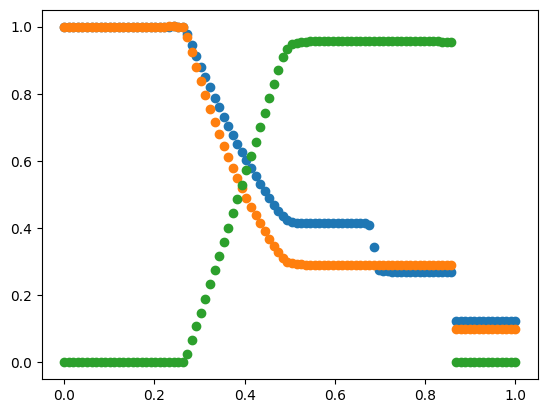

In [441]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()


In [51]:
new_array = np.array(u_pred[:,2])
#new_array = np.array(x)
file = open("p.txt", "w+")
content = str(new_array)
file.write(content)
file.close()


In [442]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

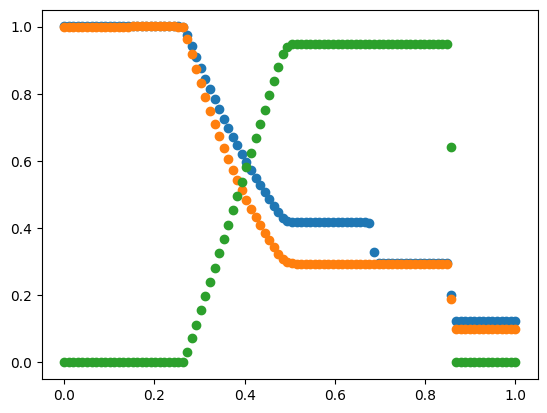

In [65]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

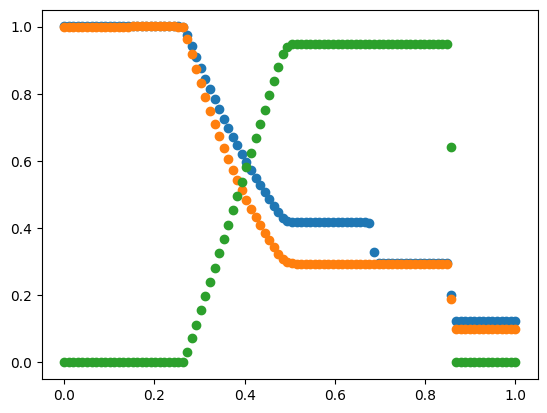

In [66]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [67]:
#np.size(id_f)
x_int_train = np.hstack((t_int, x_int))    # Random (x,t) - vectorized
#np.size(x_int_train)
#np.size(x_int)
#np.size(t_int)

In [68]:
def NewPoint(x,t):
    xl = -0.2
    xr = 1.8
    dgt = 0.0
    dg1 = np.array([])
    M = np.array([])
    N = np.size(x)
    L = np.array([])
    y = np.copy(x)
    for i in range(N):
        if i == 0:
            L = np.append(L,x[0]-xl)
            dgl = dg(x[0],t)
            dgr = dg(xl,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        elif i < N-1:
            L = np.append(L,x[i+1]-x[i])
            dgl = dg(x[i],t)
            dgr = dg(x[i+1],t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        else:
            L = np.append(L,xr-x[N-1])
            dgl = dg(x[N-1],t)
            dgr = dg(xr,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[N-1]
    for i in range(N):
        M = np.append(M,int((dg1[i]*L[i])/dgt*N+0.5))

    print("M")
  #  print(M)
  #  print("L")
  #  print(L)
    print("dg1")
    print(dg1)
    Mt = 0

    for i in range(N):
        if i ==0 and M[0] > 0:
            for j in range(int(M[0])):
                y[j] = (x[0] - xl)/M[0]*(j+1) + xl
        elif i < N-1 and M[i]> 0 and Mt<N:
            for j in range(int(M[i])):
                y[j+Mt] = (x[i] - x[i-1])/M[i]*(j+1) + x[i-1]
        elif i==N-1 and M[N-1] >0:
            for j in range(int(M[N-1])):
                y[j+Mt] = (xr - x[N-1])/M[N-1]*(j+1) + x[N-1]
        
        Mt = Mt + int(M[i])
    return dg1



In [69]:
x = np.linspace(-0.2, 1.8, 100)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                   # Partitioned spatial axis

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
i=0
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x[0:99],t[99])
    t_r[i*100:99+i*100] =t[i]

In [70]:
x_r[600:699]

array([1.60326131e+22, 5.76465166e+22, 3.70957999e+24, 2.36209280e+08,
       5.44426439e-05, 1.62787000e+31, 2.71339503e+20, 8.00166625e+05,
       2.30321930e-07, 1.63223644e+34, 9.21301453e+02, 1.04500940e+12,
       8.04466938e+05, 8.82407375e+05, 4.04630494e+30, 1.30378596e+16,
       3.74023992e+33, 5.69934527e+13, 2.48317636e+26, 1.35164815e+10,
       6.66888847e+10, 5.99938017e+22, 6.24761462e+13, 3.97429464e+27,
       9.15677632e+14, 5.88571517e+22, 6.25707169e+01, 1.52182157e+25,
       1.58646385e+16, 1.00809555e+09, 6.25212734e+04, 4.01251659e+27,
       5.91548866e+13, 7.31270681e+28, 2.80446143e+03, 3.15070821e+12,
       7.32291394e-10, 2.61014860e+14, 3.98053244e+33, 3.54250340e-09,
       8.04056745e-13, 1.10771648e+33, 7.17675236e+25, 2.96474181e+35,
       1.19384877e-05, 7.46800288e-10, 8.82343000e+05, 6.35693008e+04,
       9.44837312e+08, 3.37953381e+21, 1.60242736e-10, 2.82971350e+20,
       1.65894244e+13, 6.38337681e+25, 1.14916658e+24, 1.61912344e+28,
      

In [71]:
plt.scatter(x[0:99],x_r[0:99])

ERROR! Session/line number was not unique in database. History logging moved to new session 4629


In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x_r[i*100:99+i*100],t[i])
    #t_r[i*100:99+i*100] =t[i]

In [ ]:
t[0]

In [ ]:
T = t_r.flatten()[:, None]                                         # Vectorized t_grid
X = x_r.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain

In [ ]:

y =NewPoint(x,t[1])

In [ ]:
dg(1.8,0.2)

In [ ]:
def dg(x,t):
    y_t=np.array([[x]])
    t_t=np.array([[t]])
    x_t = np.hstack((y_t,t_t))

    x_t = torch.tensor(x_t, requires_grad=True, dtype=torch.float32).to(device)
    loss = model.loss_pde(x_t)                                    # Loss function of PDE
    y = model.net(x_t)                                                # Neural network
    rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
    drho_g = gradients(rho, x_t)[0]
    d = torch.tensor(drho_g, dtype=torch.float32).to(device1)
    return d.numpy()[0][0]


In [ ]:
x = np.linspace(-0.2, 1.8, 1000)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test1 = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred1 = to_numpy(model(x_test1))

In [ ]:

plt.plot(x[:],u_pred[:,0])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x[:],u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [ ]:
y = model.net(x_int_train)                                                # Neural network
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
drho_g = gradients(rho, x_int_train)[0]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x,u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [386]:
#device1 = torch.device('cpu')                                          # Run on CPU
torch.save(model,'1.pt')

In [ ]:
model.load(torch.load(PATH))
model.to(device)

# 文件读取模型

In [ ]:

import matplotlib.pyplot as plt
x = np.linspace(-8.0 / 28.0, 20.0 / 28.0, num_x)  # Partitioned spatial axis
t = np.linspace(2.0, 2.0, 1)  # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)  # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]  # Vectorized t_grid
X = x_grid.flatten()[:, None]  # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to('cpu')
u_pred = to_numpy(model(x_test))
plt.plot(x,u_pred[:,0])
plt.plot(x,u_pred[:,1])
plt.plot(x,u_pred[:,2])
plt.plot(x,u_pred[:,3])
plt.plot(x,u_pred[:,4])

In [ ]:

plt.plot(x,u_pred[:,4])

In [ ]:
#u_pred[:,0]
import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
x = np.linspace(-1.5, 3.125, num_x)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
def fun(x):
    return x.mean()

fun([1,2,3,4;1,2,3,4])

In [ ]:
(1,2,3,4).mean()

In [ ]:
p = np.zeros(100)

In [ ]:
p.mean()